In [1]:
from torchvision import transforms
import torch

from torch import nn
import torch.optim as optim
import argparse
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter('ignore')

In [2]:
trainy = pd.read_csv("./aru/trainy_aru.csv")
valy = pd.read_csv("./aru/valy_aru.csv")
le = preprocessing.LabelEncoder()
le.fit(trainy['celltype'])
with open("./aru/label_encoder_aru.obj","wb") as f:
   pickle.dump(le, f)

y_train = pd.DataFrame(le.transform(trainy['celltype']))
y_val = pd.DataFrame(le.transform(valy['celltype']))
np.save('./aru/train_aru_label.npy', y_train)
np.save('./aru/val_aru_label.npy', y_val)

In [3]:
class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = torch.nn.functional.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * torch.nn.functional.nll_loss(log_preds, target, reduction=self.reduction)


In [4]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='./aru/checkpoint_model_aru.pth'):
        self.patience = patience    
        self.verbose = verbose      
        self.counter = 0            
        self.best_score = None      
        self.early_stop = False     
        self.val_acc_max = 0   
        self.path = path             
    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None: 
            self.best_score = score 
            self.checkpoint(val_acc, model)
        elif score < self.best_score: 
            self.counter += 1 
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: 
                self.early_stop = True
        else:
            self.best_score = score
            self.checkpoint(val_acc, model)
            self.counter = 0  
    def checkpoint(self, val_acc, model):
        if self.verbose:  
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  
        self.val_acc_max = val_acc  

In [5]:
class MyDataset(Dataset):
    def __init__(self, img, label):
        self.img = np.load(img)
        self.label = torch.tensor(np.load(label))
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        label = self.label[index]
        label = np.squeeze(label)
        return img,label
    def __len__(self):
        return self.img.shape[0]

In [6]:
def train_net(pre_epoch, EPOCH, early_patience, training_loader, validation_loader, net, optimizer, scheduler, criteria, save_model, device):
    with open("./aru/acc.txt", "w") as f:
        with open("./aru/log.txt", "w")as f2:
            start = time.time()
            earlystopping = EarlyStopping(patience=early_patience, verbose=True)
            losses_train = []
            accs_train = []
            losses_val = []
            accs_val = []
            best_acc = 0
            total_poches = 0
            for epoch in range(pre_epoch, EPOCH):
                print('\nEpoch: %d' % (epoch + 1))
                since = time.time()
                net.train()
                sum_loss = 0.0
                correct = 0
                total = 0
                for i, data in enumerate(training_loader):
                    length = len(training_loader)
                    input, target = data
                    input, target = input.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = net(input)
                    loss = criteria(output, target)
                    loss.backward()
                    optimizer.step()
                    sum_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += predicted.eq(target.data).cpu().sum()
                    loss_train = sum_loss / (i + 1)
                    acc_train = 100. * float(correct) / float(total)
                    print('[epoch:%d, iter:%d] Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('%03d  %05d |Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('\n')
                    f2.flush()
                acc_train = 100. * float(correct) / float(total)
                accs_train.append(acc_train)
                losses_train.append(loss_train)
                print("Waiting Test!")
                with torch.no_grad():
                    sum_loss_val = 0
                    correct = 0
                    total = 0
                    loss_val = 0
                    for i, data in enumerate(validation_loader):
                        net.eval()
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criteria(outputs, labels)
                        sum_loss_val += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += predicted.eq(labels.data).cpu().sum()
                        loss_val = sum_loss_val / (i + 1)
                    acc_val = 100. * float(correct) / float(total)
                    losses_val.append(loss_val)
                    accs_val.append(acc_val)
                    print("EPOCH=%03d, Loss: %.03f, Accuracy= %.3f%%" % (epoch + 1, loss_val ,acc_val))
                    scheduler.step(acc_val)
                    if (save_model == True):
                        print('Saving model......')
                        torch.save(net.state_dict(), './aru/net_%03d.pth' % (epoch + 1))
                    f.write("EPOCH=%03d, Loss: %.03f, Accuracy= %.3f%%" % (epoch + 1, loss_val ,acc_val))
                    f.write('\n')
                    f.flush()
                    if acc_val > best_acc:
                        f3 = open("./aru/best_acc.txt", "w")
                        f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, acc_val))
                        f3.close()
                        best_acc = acc_val
                    time_elapsed = time.time() - since
                    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                    earlystopping(acc_val, net)
                    if earlystopping.early_stop: 
                        print("Early Stopping!")
                        total_poches = epoch + 1
                        break
            print("Training Finished, TotalEPOCH=%d" % total_poches)
            time_total = time.time() - start
            print('The whole training process complete in {:.0f}m {:.0f}s'.format(time_total // 60, time_total % 60))
    return losses_train, accs_train, losses_val, accs_val

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
num_classes = 31
batch_size = 128
net = EfficientNet.from_pretrained('efficientnet-b3', num_classes=31)
net._fc.out_features = num_classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

Loaded pretrained weights for efficientnet-b3


In [8]:
net.to(device)
net = net.to(device)

In [9]:
train = MyDataset("./aru/train_aru.npy", "./aru/train_aru_label.npy")
training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val = MyDataset("./aru/val_aru.npy", "./aru/val_aru_label.npy")
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

In [10]:
LR = 3e-4
# optimizer
params_to_update = net.parameters()
optimizer = optim.NAdam(params_to_update, lr=LR, betas=(0.9, 0.999), eps=1e-9, weight_decay=1e-6)
# scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
criteria = LabelSmoothingCrossEntropy(0.1)

In [11]:
losses_train, accs_train, losses_val, accs_val = train_net(pre_epoch=0,
                                                           EPOCH = 100,
                                                           early_patience = 30,
                                                           training_loader=training_loader,
                                                           validation_loader = validation_loader,
                                                           net=net,
                                                           optimizer=optimizer,
                                                           scheduler=scheduler,
                                                           criteria=criteria,
                                                           save_model=False,
                                                           device=device
                                                        )


Epoch: 1
[epoch:1, iter:1] Loss: 3.425 | Accuracy: 3.906% 
[epoch:1, iter:2] Loss: 3.331 | Accuracy: 16.406% 
[epoch:1, iter:3] Loss: 3.246 | Accuracy: 22.396% 
[epoch:1, iter:4] Loss: 3.176 | Accuracy: 25.195% 
[epoch:1, iter:5] Loss: 3.087 | Accuracy: 29.844% 
[epoch:1, iter:6] Loss: 3.013 | Accuracy: 32.552% 
[epoch:1, iter:7] Loss: 2.954 | Accuracy: 34.263% 
[epoch:1, iter:8] Loss: 2.883 | Accuracy: 36.230% 
[epoch:1, iter:9] Loss: 2.807 | Accuracy: 38.194% 
[epoch:1, iter:10] Loss: 2.743 | Accuracy: 39.141% 
[epoch:1, iter:11] Loss: 2.681 | Accuracy: 40.625% 
[epoch:1, iter:12] Loss: 2.621 | Accuracy: 41.732% 
[epoch:1, iter:13] Loss: 2.561 | Accuracy: 43.510% 
[epoch:1, iter:14] Loss: 2.509 | Accuracy: 44.866% 
[epoch:1, iter:15] Loss: 2.459 | Accuracy: 46.146% 
[epoch:1, iter:16] Loss: 2.411 | Accuracy: 47.266% 
[epoch:1, iter:17] Loss: 2.362 | Accuracy: 48.575% 
[epoch:1, iter:18] Loss: 2.316 | Accuracy: 49.826% 
[epoch:1, iter:19] Loss: 2.291 | Accuracy: 50.288% 
[epoch:1, it

[epoch:1, iter:158] Loss: 1.256 | Accuracy: 79.035% 
[epoch:1, iter:159] Loss: 1.255 | Accuracy: 79.054% 
[epoch:1, iter:160] Loss: 1.254 | Accuracy: 79.087% 
[epoch:1, iter:161] Loss: 1.253 | Accuracy: 79.100% 
[epoch:1, iter:162] Loss: 1.252 | Accuracy: 79.109% 
[epoch:1, iter:163] Loss: 1.250 | Accuracy: 79.194% 
[epoch:1, iter:164] Loss: 1.248 | Accuracy: 79.235% 
[epoch:1, iter:165] Loss: 1.248 | Accuracy: 79.228% 
[epoch:1, iter:166] Loss: 1.246 | Accuracy: 79.316% 
[epoch:1, iter:167] Loss: 1.244 | Accuracy: 79.379% 
[epoch:1, iter:168] Loss: 1.242 | Accuracy: 79.422% 
[epoch:1, iter:169] Loss: 1.240 | Accuracy: 79.484% 
[epoch:1, iter:170] Loss: 1.238 | Accuracy: 79.573% 
[epoch:1, iter:171] Loss: 1.237 | Accuracy: 79.605% 
[epoch:1, iter:172] Loss: 1.235 | Accuracy: 79.665% 
[epoch:1, iter:173] Loss: 1.234 | Accuracy: 79.706% 
[epoch:1, iter:174] Loss: 1.232 | Accuracy: 79.768% 
[epoch:1, iter:175] Loss: 1.231 | Accuracy: 79.799% 
[epoch:1, iter:176] Loss: 1.230 | Accuracy: 79

[epoch:1, iter:313] Loss: 1.104 | Accuracy: 83.741% 
[epoch:1, iter:314] Loss: 1.104 | Accuracy: 83.760% 
[epoch:1, iter:315] Loss: 1.103 | Accuracy: 83.780% 
[epoch:1, iter:316] Loss: 1.103 | Accuracy: 83.782% 
[epoch:1, iter:317] Loss: 1.102 | Accuracy: 83.798% 
[epoch:1, iter:318] Loss: 1.102 | Accuracy: 83.805% 
[epoch:1, iter:319] Loss: 1.101 | Accuracy: 83.822% 
[epoch:1, iter:320] Loss: 1.101 | Accuracy: 83.831% 
[epoch:1, iter:321] Loss: 1.101 | Accuracy: 83.847% 
[epoch:1, iter:322] Loss: 1.100 | Accuracy: 83.856% 
[epoch:1, iter:323] Loss: 1.100 | Accuracy: 83.879% 
[epoch:1, iter:324] Loss: 1.099 | Accuracy: 83.902% 
[epoch:1, iter:325] Loss: 1.098 | Accuracy: 83.935% 
[epoch:1, iter:326] Loss: 1.098 | Accuracy: 83.951% 
[epoch:1, iter:327] Loss: 1.097 | Accuracy: 83.969% 
[epoch:1, iter:328] Loss: 1.096 | Accuracy: 83.994% 
[epoch:1, iter:329] Loss: 1.095 | Accuracy: 84.024% 
[epoch:1, iter:330] Loss: 1.095 | Accuracy: 84.046% 
[epoch:1, iter:331] Loss: 1.094 | Accuracy: 84

[epoch:1, iter:468] Loss: 1.038 | Accuracy: 85.946% 
[epoch:1, iter:469] Loss: 1.037 | Accuracy: 85.949% 
[epoch:1, iter:470] Loss: 1.037 | Accuracy: 85.957% 
[epoch:1, iter:471] Loss: 1.037 | Accuracy: 85.969% 
[epoch:1, iter:472] Loss: 1.037 | Accuracy: 85.972% 
[epoch:1, iter:473] Loss: 1.036 | Accuracy: 85.990% 
[epoch:1, iter:474] Loss: 1.036 | Accuracy: 85.997% 
[epoch:1, iter:475] Loss: 1.036 | Accuracy: 86.008% 
[epoch:1, iter:476] Loss: 1.035 | Accuracy: 86.021% 
[epoch:1, iter:477] Loss: 1.035 | Accuracy: 86.029% 
[epoch:1, iter:478] Loss: 1.035 | Accuracy: 86.032% 
[epoch:1, iter:479] Loss: 1.035 | Accuracy: 86.044% 
[epoch:1, iter:480] Loss: 1.034 | Accuracy: 86.051% 
[epoch:1, iter:481] Loss: 1.034 | Accuracy: 86.061% 
[epoch:1, iter:482] Loss: 1.034 | Accuracy: 86.077% 
[epoch:1, iter:483] Loss: 1.033 | Accuracy: 86.088% 
[epoch:1, iter:484] Loss: 1.033 | Accuracy: 86.094% 
[epoch:1, iter:485] Loss: 1.033 | Accuracy: 86.103% 
[epoch:1, iter:486] Loss: 1.032 | Accuracy: 86

[epoch:1, iter:623] Loss: 0.997 | Accuracy: 87.333% 
[epoch:1, iter:624] Loss: 0.997 | Accuracy: 87.345% 
[epoch:1, iter:625] Loss: 0.996 | Accuracy: 87.362% 
[epoch:1, iter:626] Loss: 0.996 | Accuracy: 87.375% 
[epoch:1, iter:627] Loss: 0.996 | Accuracy: 87.385% 
[epoch:1, iter:628] Loss: 0.996 | Accuracy: 87.389% 
[epoch:1, iter:629] Loss: 0.995 | Accuracy: 87.399% 
[epoch:1, iter:630] Loss: 0.995 | Accuracy: 87.407% 
[epoch:1, iter:631] Loss: 0.995 | Accuracy: 87.412% 
[epoch:1, iter:632] Loss: 0.995 | Accuracy: 87.421% 
[epoch:1, iter:633] Loss: 0.995 | Accuracy: 87.425% 
[epoch:1, iter:634] Loss: 0.994 | Accuracy: 87.433% 
[epoch:1, iter:635] Loss: 0.994 | Accuracy: 87.434% 
[epoch:1, iter:636] Loss: 0.994 | Accuracy: 87.441% 
[epoch:1, iter:637] Loss: 0.994 | Accuracy: 87.445% 
[epoch:1, iter:638] Loss: 0.994 | Accuracy: 87.453% 
[epoch:1, iter:639] Loss: 0.994 | Accuracy: 87.457% 
[epoch:1, iter:640] Loss: 0.993 | Accuracy: 87.460% 
[epoch:1, iter:641] Loss: 0.993 | Accuracy: 87

[epoch:1, iter:778] Loss: 0.969 | Accuracy: 88.237% 
[epoch:1, iter:779] Loss: 0.969 | Accuracy: 88.240% 
[epoch:1, iter:780] Loss: 0.969 | Accuracy: 88.246% 
[epoch:1, iter:781] Loss: 0.969 | Accuracy: 88.248% 
[epoch:1, iter:782] Loss: 0.969 | Accuracy: 88.252% 
[epoch:1, iter:783] Loss: 0.969 | Accuracy: 88.264% 
[epoch:1, iter:784] Loss: 0.968 | Accuracy: 88.267% 
[epoch:1, iter:785] Loss: 0.968 | Accuracy: 88.269% 
[epoch:1, iter:786] Loss: 0.968 | Accuracy: 88.277% 
[epoch:1, iter:787] Loss: 0.968 | Accuracy: 88.283% 
[epoch:1, iter:788] Loss: 0.968 | Accuracy: 88.290% 
[epoch:1, iter:789] Loss: 0.968 | Accuracy: 88.294% 
[epoch:1, iter:790] Loss: 0.968 | Accuracy: 88.291% 
[epoch:1, iter:791] Loss: 0.968 | Accuracy: 88.294% 
[epoch:1, iter:792] Loss: 0.967 | Accuracy: 88.297% 
[epoch:1, iter:793] Loss: 0.967 | Accuracy: 88.302% 
[epoch:1, iter:794] Loss: 0.967 | Accuracy: 88.308% 
[epoch:1, iter:795] Loss: 0.967 | Accuracy: 88.312% 
[epoch:1, iter:796] Loss: 0.967 | Accuracy: 88

[epoch:1, iter:933] Loss: 0.950 | Accuracy: 88.910% 
[epoch:1, iter:934] Loss: 0.950 | Accuracy: 88.916% 
[epoch:1, iter:935] Loss: 0.950 | Accuracy: 88.920% 
[epoch:1, iter:936] Loss: 0.950 | Accuracy: 88.925% 
[epoch:1, iter:937] Loss: 0.950 | Accuracy: 88.932% 
[epoch:1, iter:938] Loss: 0.949 | Accuracy: 88.939% 
[epoch:1, iter:939] Loss: 0.949 | Accuracy: 88.945% 
[epoch:1, iter:940] Loss: 0.949 | Accuracy: 88.948% 
[epoch:1, iter:941] Loss: 0.949 | Accuracy: 88.953% 
[epoch:1, iter:942] Loss: 0.949 | Accuracy: 88.960% 
[epoch:1, iter:943] Loss: 0.949 | Accuracy: 88.962% 
[epoch:1, iter:944] Loss: 0.949 | Accuracy: 88.967% 
[epoch:1, iter:945] Loss: 0.949 | Accuracy: 88.969% 
[epoch:1, iter:946] Loss: 0.948 | Accuracy: 88.969% 
[epoch:1, iter:947] Loss: 0.948 | Accuracy: 88.973% 
[epoch:1, iter:948] Loss: 0.948 | Accuracy: 88.980% 
[epoch:1, iter:949] Loss: 0.948 | Accuracy: 88.981% 
[epoch:1, iter:950] Loss: 0.948 | Accuracy: 88.984% 
[epoch:1, iter:951] Loss: 0.948 | Accuracy: 88

[epoch:1, iter:1086] Loss: 0.934 | Accuracy: 89.424% 
[epoch:1, iter:1087] Loss: 0.934 | Accuracy: 89.429% 
[epoch:1, iter:1088] Loss: 0.934 | Accuracy: 89.432% 
[epoch:1, iter:1089] Loss: 0.934 | Accuracy: 89.438% 
[epoch:1, iter:1090] Loss: 0.934 | Accuracy: 89.444% 
[epoch:1, iter:1091] Loss: 0.933 | Accuracy: 89.451% 
[epoch:1, iter:1092] Loss: 0.933 | Accuracy: 89.453% 
[epoch:1, iter:1093] Loss: 0.933 | Accuracy: 89.456% 
[epoch:1, iter:1094] Loss: 0.933 | Accuracy: 89.460% 
[epoch:1, iter:1095] Loss: 0.933 | Accuracy: 89.461% 
[epoch:1, iter:1096] Loss: 0.933 | Accuracy: 89.467% 
[epoch:1, iter:1097] Loss: 0.933 | Accuracy: 89.471% 
[epoch:1, iter:1098] Loss: 0.933 | Accuracy: 89.474% 
[epoch:1, iter:1099] Loss: 0.933 | Accuracy: 89.478% 
[epoch:1, iter:1100] Loss: 0.933 | Accuracy: 89.480% 
[epoch:1, iter:1101] Loss: 0.932 | Accuracy: 89.483% 
[epoch:1, iter:1102] Loss: 0.932 | Accuracy: 89.485% 
[epoch:1, iter:1103] Loss: 0.932 | Accuracy: 89.486% 
[epoch:1, iter:1104] Loss: 0

[epoch:2, iter:1235] Loss: 0.841 | Accuracy: 92.356% 
[epoch:2, iter:1236] Loss: 0.841 | Accuracy: 92.414% 
[epoch:2, iter:1237] Loss: 0.841 | Accuracy: 92.468% 
[epoch:2, iter:1238] Loss: 0.843 | Accuracy: 92.402% 
[epoch:2, iter:1239] Loss: 0.841 | Accuracy: 92.492% 
[epoch:2, iter:1240] Loss: 0.840 | Accuracy: 92.541% 
[epoch:2, iter:1241] Loss: 0.839 | Accuracy: 92.587% 
[epoch:2, iter:1242] Loss: 0.839 | Accuracy: 92.614% 
[epoch:2, iter:1243] Loss: 0.839 | Accuracy: 92.569% 
[epoch:2, iter:1244] Loss: 0.838 | Accuracy: 92.578% 
[epoch:2, iter:1245] Loss: 0.839 | Accuracy: 92.586% 
[epoch:2, iter:1246] Loss: 0.840 | Accuracy: 92.513% 
[epoch:2, iter:1247] Loss: 0.839 | Accuracy: 92.586% 
[epoch:2, iter:1248] Loss: 0.837 | Accuracy: 92.672% 
[epoch:2, iter:1249] Loss: 0.836 | Accuracy: 92.724% 
[epoch:2, iter:1250] Loss: 0.837 | Accuracy: 92.698% 
[epoch:2, iter:1251] Loss: 0.839 | Accuracy: 92.644% 
[epoch:2, iter:1252] Loss: 0.839 | Accuracy: 92.650% 
[epoch:2, iter:1253] Loss: 0

[epoch:2, iter:1387] Loss: 0.826 | Accuracy: 93.118% 
[epoch:2, iter:1388] Loss: 0.826 | Accuracy: 93.129% 
[epoch:2, iter:1389] Loss: 0.826 | Accuracy: 93.141% 
[epoch:2, iter:1390] Loss: 0.826 | Accuracy: 93.140% 
[epoch:2, iter:1391] Loss: 0.825 | Accuracy: 93.159% 
[epoch:2, iter:1392] Loss: 0.825 | Accuracy: 93.174% 
[epoch:2, iter:1393] Loss: 0.825 | Accuracy: 93.157% 
[epoch:2, iter:1394] Loss: 0.825 | Accuracy: 93.168% 
[epoch:2, iter:1395] Loss: 0.825 | Accuracy: 93.191% 
[epoch:2, iter:1396] Loss: 0.824 | Accuracy: 93.205% 
[epoch:2, iter:1397] Loss: 0.824 | Accuracy: 93.216% 
[epoch:2, iter:1398] Loss: 0.824 | Accuracy: 93.219% 
[epoch:2, iter:1399] Loss: 0.824 | Accuracy: 93.229% 
[epoch:2, iter:1400] Loss: 0.824 | Accuracy: 93.232% 
[epoch:2, iter:1401] Loss: 0.824 | Accuracy: 93.230% 
[epoch:2, iter:1402] Loss: 0.825 | Accuracy: 93.225% 
[epoch:2, iter:1403] Loss: 0.825 | Accuracy: 93.236% 
[epoch:2, iter:1404] Loss: 0.824 | Accuracy: 93.249% 
[epoch:2, iter:1405] Loss: 0

[epoch:2, iter:1539] Loss: 0.817 | Accuracy: 93.535% 
[epoch:2, iter:1540] Loss: 0.817 | Accuracy: 93.540% 
[epoch:2, iter:1541] Loss: 0.817 | Accuracy: 93.540% 
[epoch:2, iter:1542] Loss: 0.817 | Accuracy: 93.539% 
[epoch:2, iter:1543] Loss: 0.817 | Accuracy: 93.533% 
[epoch:2, iter:1544] Loss: 0.817 | Accuracy: 93.526% 
[epoch:2, iter:1545] Loss: 0.817 | Accuracy: 93.523% 
[epoch:2, iter:1546] Loss: 0.817 | Accuracy: 93.521% 
[epoch:2, iter:1547] Loss: 0.817 | Accuracy: 93.515% 
[epoch:2, iter:1548] Loss: 0.817 | Accuracy: 93.518% 
[epoch:2, iter:1549] Loss: 0.817 | Accuracy: 93.519% 
[epoch:2, iter:1550] Loss: 0.817 | Accuracy: 93.528% 
[epoch:2, iter:1551] Loss: 0.817 | Accuracy: 93.518% 
[epoch:2, iter:1552] Loss: 0.817 | Accuracy: 93.527% 
[epoch:2, iter:1553] Loss: 0.817 | Accuracy: 93.515% 
[epoch:2, iter:1554] Loss: 0.817 | Accuracy: 93.517% 
[epoch:2, iter:1555] Loss: 0.817 | Accuracy: 93.522% 
[epoch:2, iter:1556] Loss: 0.817 | Accuracy: 93.525% 
[epoch:2, iter:1557] Loss: 0

[epoch:2, iter:1691] Loss: 0.817 | Accuracy: 93.520% 
[epoch:2, iter:1692] Loss: 0.817 | Accuracy: 93.516% 
[epoch:2, iter:1693] Loss: 0.817 | Accuracy: 93.516% 
[epoch:2, iter:1694] Loss: 0.817 | Accuracy: 93.523% 
[epoch:2, iter:1695] Loss: 0.817 | Accuracy: 93.522% 
[epoch:2, iter:1696] Loss: 0.817 | Accuracy: 93.526% 
[epoch:2, iter:1697] Loss: 0.817 | Accuracy: 93.525% 
[epoch:2, iter:1698] Loss: 0.817 | Accuracy: 93.517% 
[epoch:2, iter:1699] Loss: 0.817 | Accuracy: 93.522% 
[epoch:2, iter:1700] Loss: 0.817 | Accuracy: 93.520% 
[epoch:2, iter:1701] Loss: 0.817 | Accuracy: 93.519% 
[epoch:2, iter:1702] Loss: 0.817 | Accuracy: 93.517% 
[epoch:2, iter:1703] Loss: 0.817 | Accuracy: 93.515% 
[epoch:2, iter:1704] Loss: 0.817 | Accuracy: 93.518% 
[epoch:2, iter:1705] Loss: 0.817 | Accuracy: 93.520% 
[epoch:2, iter:1706] Loss: 0.817 | Accuracy: 93.524% 
[epoch:2, iter:1707] Loss: 0.817 | Accuracy: 93.527% 
[epoch:2, iter:1708] Loss: 0.817 | Accuracy: 93.529% 
[epoch:2, iter:1709] Loss: 0

[epoch:2, iter:1843] Loss: 0.815 | Accuracy: 93.582% 
[epoch:2, iter:1844] Loss: 0.815 | Accuracy: 93.582% 
[epoch:2, iter:1845] Loss: 0.815 | Accuracy: 93.586% 
[epoch:2, iter:1846] Loss: 0.815 | Accuracy: 93.582% 
[epoch:2, iter:1847] Loss: 0.815 | Accuracy: 93.585% 
[epoch:2, iter:1848] Loss: 0.815 | Accuracy: 93.588% 
[epoch:2, iter:1849] Loss: 0.815 | Accuracy: 93.590% 
[epoch:2, iter:1850] Loss: 0.815 | Accuracy: 93.597% 
[epoch:2, iter:1851] Loss: 0.815 | Accuracy: 93.600% 
[epoch:2, iter:1852] Loss: 0.815 | Accuracy: 93.603% 
[epoch:2, iter:1853] Loss: 0.815 | Accuracy: 93.602% 
[epoch:2, iter:1854] Loss: 0.815 | Accuracy: 93.599% 
[epoch:2, iter:1855] Loss: 0.815 | Accuracy: 93.599% 
[epoch:2, iter:1856] Loss: 0.815 | Accuracy: 93.604% 
[epoch:2, iter:1857] Loss: 0.815 | Accuracy: 93.605% 
[epoch:2, iter:1858] Loss: 0.815 | Accuracy: 93.608% 
[epoch:2, iter:1859] Loss: 0.815 | Accuracy: 93.608% 
[epoch:2, iter:1860] Loss: 0.815 | Accuracy: 93.608% 
[epoch:2, iter:1861] Loss: 0

[epoch:2, iter:1995] Loss: 0.814 | Accuracy: 93.604% 
[epoch:2, iter:1996] Loss: 0.814 | Accuracy: 93.606% 
[epoch:2, iter:1997] Loss: 0.814 | Accuracy: 93.605% 
[epoch:2, iter:1998] Loss: 0.814 | Accuracy: 93.606% 
[epoch:2, iter:1999] Loss: 0.814 | Accuracy: 93.609% 
[epoch:2, iter:2000] Loss: 0.814 | Accuracy: 93.610% 
[epoch:2, iter:2001] Loss: 0.814 | Accuracy: 93.612% 
[epoch:2, iter:2002] Loss: 0.814 | Accuracy: 93.614% 
[epoch:2, iter:2003] Loss: 0.814 | Accuracy: 93.613% 
[epoch:2, iter:2004] Loss: 0.814 | Accuracy: 93.615% 
[epoch:2, iter:2005] Loss: 0.814 | Accuracy: 93.614% 
[epoch:2, iter:2006] Loss: 0.814 | Accuracy: 93.619% 
[epoch:2, iter:2007] Loss: 0.814 | Accuracy: 93.622% 
[epoch:2, iter:2008] Loss: 0.813 | Accuracy: 93.624% 
[epoch:2, iter:2009] Loss: 0.813 | Accuracy: 93.625% 
[epoch:2, iter:2010] Loss: 0.813 | Accuracy: 93.626% 
[epoch:2, iter:2011] Loss: 0.813 | Accuracy: 93.625% 
[epoch:2, iter:2012] Loss: 0.813 | Accuracy: 93.627% 
[epoch:2, iter:2013] Loss: 0

[epoch:2, iter:2147] Loss: 0.811 | Accuracy: 93.709% 
[epoch:2, iter:2148] Loss: 0.811 | Accuracy: 93.702% 
[epoch:2, iter:2149] Loss: 0.811 | Accuracy: 93.704% 
[epoch:2, iter:2150] Loss: 0.811 | Accuracy: 93.706% 
[epoch:2, iter:2151] Loss: 0.811 | Accuracy: 93.701% 
[epoch:2, iter:2152] Loss: 0.811 | Accuracy: 93.702% 
[epoch:2, iter:2153] Loss: 0.811 | Accuracy: 93.702% 
[epoch:2, iter:2154] Loss: 0.811 | Accuracy: 93.699% 
[epoch:2, iter:2155] Loss: 0.811 | Accuracy: 93.701% 
[epoch:2, iter:2156] Loss: 0.811 | Accuracy: 93.704% 
[epoch:2, iter:2157] Loss: 0.811 | Accuracy: 93.704% 
[epoch:2, iter:2158] Loss: 0.811 | Accuracy: 93.708% 
[epoch:2, iter:2159] Loss: 0.811 | Accuracy: 93.710% 
[epoch:2, iter:2160] Loss: 0.811 | Accuracy: 93.711% 
[epoch:2, iter:2161] Loss: 0.811 | Accuracy: 93.713% 
[epoch:2, iter:2162] Loss: 0.811 | Accuracy: 93.711% 
[epoch:2, iter:2163] Loss: 0.811 | Accuracy: 93.709% 
[epoch:2, iter:2164] Loss: 0.811 | Accuracy: 93.711% 
[epoch:2, iter:2165] Loss: 0

[epoch:2, iter:2299] Loss: 0.810 | Accuracy: 93.753% 
[epoch:2, iter:2300] Loss: 0.810 | Accuracy: 93.750% 
[epoch:2, iter:2301] Loss: 0.810 | Accuracy: 93.751% 
[epoch:2, iter:2302] Loss: 0.810 | Accuracy: 93.751% 
[epoch:2, iter:2303] Loss: 0.810 | Accuracy: 93.754% 
[epoch:2, iter:2304] Loss: 0.810 | Accuracy: 93.756% 
[epoch:2, iter:2305] Loss: 0.810 | Accuracy: 93.758% 
[epoch:2, iter:2306] Loss: 0.810 | Accuracy: 93.759% 
[epoch:2, iter:2307] Loss: 0.810 | Accuracy: 93.761% 
[epoch:2, iter:2308] Loss: 0.810 | Accuracy: 93.758% 
[epoch:2, iter:2309] Loss: 0.810 | Accuracy: 93.761% 
[epoch:2, iter:2310] Loss: 0.810 | Accuracy: 93.763% 
[epoch:2, iter:2311] Loss: 0.810 | Accuracy: 93.765% 
[epoch:2, iter:2312] Loss: 0.810 | Accuracy: 93.769% 
[epoch:2, iter:2313] Loss: 0.810 | Accuracy: 93.770% 
[epoch:2, iter:2314] Loss: 0.810 | Accuracy: 93.770% 
[epoch:2, iter:2315] Loss: 0.810 | Accuracy: 93.770% 
[epoch:2, iter:2316] Loss: 0.810 | Accuracy: 93.767% 
[epoch:2, iter:2317] Loss: 0

[epoch:3, iter:2448] Loss: 0.783 | Accuracy: 94.862% 
[epoch:3, iter:2449] Loss: 0.782 | Accuracy: 94.915% 
[epoch:3, iter:2450] Loss: 0.781 | Accuracy: 94.951% 
[epoch:3, iter:2451] Loss: 0.781 | Accuracy: 94.943% 
[epoch:3, iter:2452] Loss: 0.781 | Accuracy: 94.922% 
[epoch:3, iter:2453] Loss: 0.782 | Accuracy: 94.874% 
[epoch:3, iter:2454] Loss: 0.782 | Accuracy: 94.881% 
[epoch:3, iter:2455] Loss: 0.781 | Accuracy: 94.902% 
[epoch:3, iter:2456] Loss: 0.781 | Accuracy: 94.922% 
[epoch:3, iter:2457] Loss: 0.781 | Accuracy: 94.954% 
[epoch:3, iter:2458] Loss: 0.780 | Accuracy: 94.972% 
[epoch:3, iter:2459] Loss: 0.780 | Accuracy: 95.015% 
[epoch:3, iter:2460] Loss: 0.781 | Accuracy: 94.971% 
[epoch:3, iter:2461] Loss: 0.780 | Accuracy: 94.952% 
[epoch:3, iter:2462] Loss: 0.781 | Accuracy: 94.934% 
[epoch:3, iter:2463] Loss: 0.781 | Accuracy: 94.963% 
[epoch:3, iter:2464] Loss: 0.781 | Accuracy: 94.933% 
[epoch:3, iter:2465] Loss: 0.781 | Accuracy: 94.950% 
[epoch:3, iter:2466] Loss: 0

[epoch:3, iter:2600] Loss: 0.783 | Accuracy: 94.884% 
[epoch:3, iter:2601] Loss: 0.783 | Accuracy: 94.886% 
[epoch:3, iter:2602] Loss: 0.783 | Accuracy: 94.861% 
[epoch:3, iter:2603] Loss: 0.783 | Accuracy: 94.863% 
[epoch:3, iter:2604] Loss: 0.783 | Accuracy: 94.869% 
[epoch:3, iter:2605] Loss: 0.782 | Accuracy: 94.871% 
[epoch:3, iter:2606] Loss: 0.782 | Accuracy: 94.870% 
[epoch:3, iter:2607] Loss: 0.782 | Accuracy: 94.879% 
[epoch:3, iter:2608] Loss: 0.782 | Accuracy: 94.889% 
[epoch:3, iter:2609] Loss: 0.783 | Accuracy: 94.876% 
[epoch:3, iter:2610] Loss: 0.782 | Accuracy: 94.874% 
[epoch:3, iter:2611] Loss: 0.782 | Accuracy: 94.884% 
[epoch:3, iter:2612] Loss: 0.783 | Accuracy: 94.864% 
[epoch:3, iter:2613] Loss: 0.783 | Accuracy: 94.859% 
[epoch:3, iter:2614] Loss: 0.783 | Accuracy: 94.861% 
[epoch:3, iter:2615] Loss: 0.783 | Accuracy: 94.842% 
[epoch:3, iter:2616] Loss: 0.783 | Accuracy: 94.840% 
[epoch:3, iter:2617] Loss: 0.783 | Accuracy: 94.839% 
[epoch:3, iter:2618] Loss: 0

[epoch:3, iter:2752] Loss: 0.785 | Accuracy: 94.698% 
[epoch:3, iter:2753] Loss: 0.785 | Accuracy: 94.698% 
[epoch:3, iter:2754] Loss: 0.785 | Accuracy: 94.695% 
[epoch:3, iter:2755] Loss: 0.785 | Accuracy: 94.688% 
[epoch:3, iter:2756] Loss: 0.785 | Accuracy: 94.688% 
[epoch:3, iter:2757] Loss: 0.785 | Accuracy: 94.685% 
[epoch:3, iter:2758] Loss: 0.785 | Accuracy: 94.693% 
[epoch:3, iter:2759] Loss: 0.785 | Accuracy: 94.699% 
[epoch:3, iter:2760] Loss: 0.785 | Accuracy: 94.701% 
[epoch:3, iter:2761] Loss: 0.785 | Accuracy: 94.700% 
[epoch:3, iter:2762] Loss: 0.785 | Accuracy: 94.702% 
[epoch:3, iter:2763] Loss: 0.785 | Accuracy: 94.708% 
[epoch:3, iter:2764] Loss: 0.785 | Accuracy: 94.710% 
[epoch:3, iter:2765] Loss: 0.785 | Accuracy: 94.711% 
[epoch:3, iter:2766] Loss: 0.785 | Accuracy: 94.715% 
[epoch:3, iter:2767] Loss: 0.785 | Accuracy: 94.721% 
[epoch:3, iter:2768] Loss: 0.785 | Accuracy: 94.714% 
[epoch:3, iter:2769] Loss: 0.785 | Accuracy: 94.707% 
[epoch:3, iter:2770] Loss: 0

[epoch:3, iter:2904] Loss: 0.786 | Accuracy: 94.714% 
[epoch:3, iter:2905] Loss: 0.786 | Accuracy: 94.714% 
[epoch:3, iter:2906] Loss: 0.786 | Accuracy: 94.715% 
[epoch:3, iter:2907] Loss: 0.786 | Accuracy: 94.718% 
[epoch:3, iter:2908] Loss: 0.786 | Accuracy: 94.724% 
[epoch:3, iter:2909] Loss: 0.786 | Accuracy: 94.728% 
[epoch:3, iter:2910] Loss: 0.786 | Accuracy: 94.727% 
[epoch:3, iter:2911] Loss: 0.786 | Accuracy: 94.724% 
[epoch:3, iter:2912] Loss: 0.786 | Accuracy: 94.727% 
[epoch:3, iter:2913] Loss: 0.786 | Accuracy: 94.729% 
[epoch:3, iter:2914] Loss: 0.786 | Accuracy: 94.730% 
[epoch:3, iter:2915] Loss: 0.786 | Accuracy: 94.734% 
[epoch:3, iter:2916] Loss: 0.786 | Accuracy: 94.731% 
[epoch:3, iter:2917] Loss: 0.786 | Accuracy: 94.737% 
[epoch:3, iter:2918] Loss: 0.786 | Accuracy: 94.739% 
[epoch:3, iter:2919] Loss: 0.786 | Accuracy: 94.745% 
[epoch:3, iter:2920] Loss: 0.785 | Accuracy: 94.747% 
[epoch:3, iter:2921] Loss: 0.785 | Accuracy: 94.749% 
[epoch:3, iter:2922] Loss: 0

[epoch:3, iter:3056] Loss: 0.786 | Accuracy: 94.721% 
[epoch:3, iter:3057] Loss: 0.786 | Accuracy: 94.726% 
[epoch:3, iter:3058] Loss: 0.786 | Accuracy: 94.726% 
[epoch:3, iter:3059] Loss: 0.786 | Accuracy: 94.722% 
[epoch:3, iter:3060] Loss: 0.786 | Accuracy: 94.715% 
[epoch:3, iter:3061] Loss: 0.786 | Accuracy: 94.715% 
[epoch:3, iter:3062] Loss: 0.786 | Accuracy: 94.715% 
[epoch:3, iter:3063] Loss: 0.786 | Accuracy: 94.715% 
[epoch:3, iter:3064] Loss: 0.786 | Accuracy: 94.716% 
[epoch:3, iter:3065] Loss: 0.786 | Accuracy: 94.712% 
[epoch:3, iter:3066] Loss: 0.786 | Accuracy: 94.706% 
[epoch:3, iter:3067] Loss: 0.786 | Accuracy: 94.708% 
[epoch:3, iter:3068] Loss: 0.786 | Accuracy: 94.715% 
[epoch:3, iter:3069] Loss: 0.786 | Accuracy: 94.712% 
[epoch:3, iter:3070] Loss: 0.786 | Accuracy: 94.706% 
[epoch:3, iter:3071] Loss: 0.786 | Accuracy: 94.711% 
[epoch:3, iter:3072] Loss: 0.786 | Accuracy: 94.715% 
[epoch:3, iter:3073] Loss: 0.786 | Accuracy: 94.716% 
[epoch:3, iter:3074] Loss: 0

[epoch:3, iter:3208] Loss: 0.786 | Accuracy: 94.674% 
[epoch:3, iter:3209] Loss: 0.786 | Accuracy: 94.674% 
[epoch:3, iter:3210] Loss: 0.786 | Accuracy: 94.679% 
[epoch:3, iter:3211] Loss: 0.786 | Accuracy: 94.681% 
[epoch:3, iter:3212] Loss: 0.786 | Accuracy: 94.681% 
[epoch:3, iter:3213] Loss: 0.786 | Accuracy: 94.683% 
[epoch:3, iter:3214] Loss: 0.786 | Accuracy: 94.687% 
[epoch:3, iter:3215] Loss: 0.786 | Accuracy: 94.688% 
[epoch:3, iter:3216] Loss: 0.786 | Accuracy: 94.688% 
[epoch:3, iter:3217] Loss: 0.786 | Accuracy: 94.688% 
[epoch:3, iter:3218] Loss: 0.786 | Accuracy: 94.688% 
[epoch:3, iter:3219] Loss: 0.786 | Accuracy: 94.683% 
[epoch:3, iter:3220] Loss: 0.786 | Accuracy: 94.682% 
[epoch:3, iter:3221] Loss: 0.786 | Accuracy: 94.680% 
[epoch:3, iter:3222] Loss: 0.786 | Accuracy: 94.681% 
[epoch:3, iter:3223] Loss: 0.786 | Accuracy: 94.681% 
[epoch:3, iter:3224] Loss: 0.786 | Accuracy: 94.683% 
[epoch:3, iter:3225] Loss: 0.786 | Accuracy: 94.683% 
[epoch:3, iter:3226] Loss: 0

[epoch:3, iter:3360] Loss: 0.786 | Accuracy: 94.667% 
[epoch:3, iter:3361] Loss: 0.786 | Accuracy: 94.670% 
[epoch:3, iter:3362] Loss: 0.786 | Accuracy: 94.673% 
[epoch:3, iter:3363] Loss: 0.786 | Accuracy: 94.673% 
[epoch:3, iter:3364] Loss: 0.786 | Accuracy: 94.672% 
[epoch:3, iter:3365] Loss: 0.786 | Accuracy: 94.676% 
[epoch:3, iter:3366] Loss: 0.786 | Accuracy: 94.679% 
[epoch:3, iter:3367] Loss: 0.786 | Accuracy: 94.678% 
[epoch:3, iter:3368] Loss: 0.786 | Accuracy: 94.675% 
[epoch:3, iter:3369] Loss: 0.786 | Accuracy: 94.677% 
[epoch:3, iter:3370] Loss: 0.786 | Accuracy: 94.677% 
[epoch:3, iter:3371] Loss: 0.786 | Accuracy: 94.680% 
[epoch:3, iter:3372] Loss: 0.786 | Accuracy: 94.682% 
[epoch:3, iter:3373] Loss: 0.786 | Accuracy: 94.682% 
[epoch:3, iter:3374] Loss: 0.786 | Accuracy: 94.681% 
[epoch:3, iter:3375] Loss: 0.786 | Accuracy: 94.681% 
[epoch:3, iter:3376] Loss: 0.786 | Accuracy: 94.680% 
[epoch:3, iter:3377] Loss: 0.786 | Accuracy: 94.678% 
[epoch:3, iter:3378] Loss: 0

[epoch:3, iter:3512] Loss: 0.786 | Accuracy: 94.666% 
[epoch:3, iter:3513] Loss: 0.786 | Accuracy: 94.666% 
[epoch:3, iter:3514] Loss: 0.786 | Accuracy: 94.663% 
[epoch:3, iter:3515] Loss: 0.786 | Accuracy: 94.663% 
[epoch:3, iter:3516] Loss: 0.786 | Accuracy: 94.666% 
[epoch:3, iter:3517] Loss: 0.786 | Accuracy: 94.667% 
[epoch:3, iter:3518] Loss: 0.786 | Accuracy: 94.664% 
[epoch:3, iter:3519] Loss: 0.786 | Accuracy: 94.663% 
[epoch:3, iter:3520] Loss: 0.786 | Accuracy: 94.664% 
[epoch:3, iter:3521] Loss: 0.786 | Accuracy: 94.662% 
[epoch:3, iter:3522] Loss: 0.786 | Accuracy: 94.663% 
[epoch:3, iter:3523] Loss: 0.786 | Accuracy: 94.664% 
[epoch:3, iter:3524] Loss: 0.786 | Accuracy: 94.664% 
[epoch:3, iter:3525] Loss: 0.786 | Accuracy: 94.665% 
[epoch:3, iter:3526] Loss: 0.786 | Accuracy: 94.667% 
[epoch:3, iter:3527] Loss: 0.786 | Accuracy: 94.667% 
[epoch:3, iter:3528] Loss: 0.786 | Accuracy: 94.667% 
[epoch:3, iter:3529] Loss: 0.786 | Accuracy: 94.665% 
[epoch:3, iter:3530] Loss: 0

[epoch:4, iter:3661] Loss: 0.778 | Accuracy: 94.963% 
[epoch:4, iter:3662] Loss: 0.779 | Accuracy: 94.956% 
[epoch:4, iter:3663] Loss: 0.778 | Accuracy: 94.984% 
[epoch:4, iter:3664] Loss: 0.777 | Accuracy: 95.045% 
[epoch:4, iter:3665] Loss: 0.777 | Accuracy: 95.037% 
[epoch:4, iter:3666] Loss: 0.776 | Accuracy: 95.030% 
[epoch:4, iter:3667] Loss: 0.777 | Accuracy: 95.045% 
[epoch:4, iter:3668] Loss: 0.777 | Accuracy: 95.027% 
[epoch:4, iter:3669] Loss: 0.776 | Accuracy: 95.052% 
[epoch:4, iter:3670] Loss: 0.777 | Accuracy: 95.045% 
[epoch:4, iter:3671] Loss: 0.776 | Accuracy: 95.099% 
[epoch:4, iter:3672] Loss: 0.776 | Accuracy: 95.102% 
[epoch:4, iter:3673] Loss: 0.777 | Accuracy: 95.036% 
[epoch:4, iter:3674] Loss: 0.776 | Accuracy: 95.039% 
[epoch:4, iter:3675] Loss: 0.775 | Accuracy: 95.052% 
[epoch:4, iter:3676] Loss: 0.774 | Accuracy: 95.103% 
[epoch:4, iter:3677] Loss: 0.774 | Accuracy: 95.115% 
[epoch:4, iter:3678] Loss: 0.773 | Accuracy: 95.154% 
[epoch:4, iter:3679] Loss: 0

[epoch:4, iter:3813] Loss: 0.772 | Accuracy: 95.177% 
[epoch:4, iter:3814] Loss: 0.771 | Accuracy: 95.185% 
[epoch:4, iter:3815] Loss: 0.771 | Accuracy: 95.189% 
[epoch:4, iter:3816] Loss: 0.771 | Accuracy: 95.189% 
[epoch:4, iter:3817] Loss: 0.771 | Accuracy: 95.183% 
[epoch:4, iter:3818] Loss: 0.772 | Accuracy: 95.170% 
[epoch:4, iter:3819] Loss: 0.772 | Accuracy: 95.174% 
[epoch:4, iter:3820] Loss: 0.772 | Accuracy: 95.171% 
[epoch:4, iter:3821] Loss: 0.772 | Accuracy: 95.154% 
[epoch:4, iter:3822] Loss: 0.772 | Accuracy: 95.162% 
[epoch:4, iter:3823] Loss: 0.772 | Accuracy: 95.162% 
[epoch:4, iter:3824] Loss: 0.772 | Accuracy: 95.156% 
[epoch:4, iter:3825] Loss: 0.772 | Accuracy: 95.160% 
[epoch:4, iter:3826] Loss: 0.772 | Accuracy: 95.164% 
[epoch:4, iter:3827] Loss: 0.772 | Accuracy: 95.165% 
[epoch:4, iter:3828] Loss: 0.772 | Accuracy: 95.172% 
[epoch:4, iter:3829] Loss: 0.772 | Accuracy: 95.173% 
[epoch:4, iter:3830] Loss: 0.772 | Accuracy: 95.170% 
[epoch:4, iter:3831] Loss: 0

[epoch:4, iter:3965] Loss: 0.771 | Accuracy: 95.205% 
[epoch:4, iter:3966] Loss: 0.771 | Accuracy: 95.203% 
[epoch:4, iter:3967] Loss: 0.771 | Accuracy: 95.199% 
[epoch:4, iter:3968] Loss: 0.771 | Accuracy: 95.198% 
[epoch:4, iter:3969] Loss: 0.771 | Accuracy: 95.196% 
[epoch:4, iter:3970] Loss: 0.771 | Accuracy: 95.198% 
[epoch:4, iter:3971] Loss: 0.771 | Accuracy: 95.194% 
[epoch:4, iter:3972] Loss: 0.771 | Accuracy: 95.191% 
[epoch:4, iter:3973] Loss: 0.771 | Accuracy: 95.189% 
[epoch:4, iter:3974] Loss: 0.771 | Accuracy: 95.187% 
[epoch:4, iter:3975] Loss: 0.771 | Accuracy: 95.192% 
[epoch:4, iter:3976] Loss: 0.771 | Accuracy: 95.188% 
[epoch:4, iter:3977] Loss: 0.771 | Accuracy: 95.182% 
[epoch:4, iter:3978] Loss: 0.771 | Accuracy: 95.182% 
[epoch:4, iter:3979] Loss: 0.772 | Accuracy: 95.181% 
[epoch:4, iter:3980] Loss: 0.772 | Accuracy: 95.179% 
[epoch:4, iter:3981] Loss: 0.772 | Accuracy: 95.171% 
[epoch:4, iter:3982] Loss: 0.772 | Accuracy: 95.172% 
[epoch:4, iter:3983] Loss: 0

[epoch:4, iter:4117] Loss: 0.770 | Accuracy: 95.278% 
[epoch:4, iter:4118] Loss: 0.770 | Accuracy: 95.281% 
[epoch:4, iter:4119] Loss: 0.770 | Accuracy: 95.281% 
[epoch:4, iter:4120] Loss: 0.770 | Accuracy: 95.284% 
[epoch:4, iter:4121] Loss: 0.770 | Accuracy: 95.289% 
[epoch:4, iter:4122] Loss: 0.769 | Accuracy: 95.290% 
[epoch:4, iter:4123] Loss: 0.769 | Accuracy: 95.290% 
[epoch:4, iter:4124] Loss: 0.769 | Accuracy: 95.290% 
[epoch:4, iter:4125] Loss: 0.769 | Accuracy: 95.293% 
[epoch:4, iter:4126] Loss: 0.769 | Accuracy: 95.293% 
[epoch:4, iter:4127] Loss: 0.769 | Accuracy: 95.292% 
[epoch:4, iter:4128] Loss: 0.769 | Accuracy: 95.295% 
[epoch:4, iter:4129] Loss: 0.769 | Accuracy: 95.299% 
[epoch:4, iter:4130] Loss: 0.769 | Accuracy: 95.301% 
[epoch:4, iter:4131] Loss: 0.769 | Accuracy: 95.304% 
[epoch:4, iter:4132] Loss: 0.769 | Accuracy: 95.299% 
[epoch:4, iter:4133] Loss: 0.769 | Accuracy: 95.297% 
[epoch:4, iter:4134] Loss: 0.769 | Accuracy: 95.299% 
[epoch:4, iter:4135] Loss: 0

[epoch:4, iter:4269] Loss: 0.769 | Accuracy: 95.291% 
[epoch:4, iter:4270] Loss: 0.769 | Accuracy: 95.294% 
[epoch:4, iter:4271] Loss: 0.769 | Accuracy: 95.293% 
[epoch:4, iter:4272] Loss: 0.769 | Accuracy: 95.293% 
[epoch:4, iter:4273] Loss: 0.769 | Accuracy: 95.291% 
[epoch:4, iter:4274] Loss: 0.769 | Accuracy: 95.287% 
[epoch:4, iter:4275] Loss: 0.769 | Accuracy: 95.286% 
[epoch:4, iter:4276] Loss: 0.769 | Accuracy: 95.291% 
[epoch:4, iter:4277] Loss: 0.769 | Accuracy: 95.291% 
[epoch:4, iter:4278] Loss: 0.769 | Accuracy: 95.290% 
[epoch:4, iter:4279] Loss: 0.769 | Accuracy: 95.289% 
[epoch:4, iter:4280] Loss: 0.769 | Accuracy: 95.292% 
[epoch:4, iter:4281] Loss: 0.769 | Accuracy: 95.290% 
[epoch:4, iter:4282] Loss: 0.769 | Accuracy: 95.288% 
[epoch:4, iter:4283] Loss: 0.769 | Accuracy: 95.290% 
[epoch:4, iter:4284] Loss: 0.769 | Accuracy: 95.289% 
[epoch:4, iter:4285] Loss: 0.769 | Accuracy: 95.290% 
[epoch:4, iter:4286] Loss: 0.769 | Accuracy: 95.292% 
[epoch:4, iter:4287] Loss: 0

[epoch:4, iter:4421] Loss: 0.769 | Accuracy: 95.276% 
[epoch:4, iter:4422] Loss: 0.769 | Accuracy: 95.277% 
[epoch:4, iter:4423] Loss: 0.769 | Accuracy: 95.276% 
[epoch:4, iter:4424] Loss: 0.769 | Accuracy: 95.272% 
[epoch:4, iter:4425] Loss: 0.769 | Accuracy: 95.272% 
[epoch:4, iter:4426] Loss: 0.769 | Accuracy: 95.272% 
[epoch:4, iter:4427] Loss: 0.769 | Accuracy: 95.268% 
[epoch:4, iter:4428] Loss: 0.770 | Accuracy: 95.268% 
[epoch:4, iter:4429] Loss: 0.770 | Accuracy: 95.269% 
[epoch:4, iter:4430] Loss: 0.769 | Accuracy: 95.271% 
[epoch:4, iter:4431] Loss: 0.769 | Accuracy: 95.272% 
[epoch:4, iter:4432] Loss: 0.769 | Accuracy: 95.272% 
[epoch:4, iter:4433] Loss: 0.769 | Accuracy: 95.272% 
[epoch:4, iter:4434] Loss: 0.769 | Accuracy: 95.273% 
[epoch:4, iter:4435] Loss: 0.769 | Accuracy: 95.273% 
[epoch:4, iter:4436] Loss: 0.769 | Accuracy: 95.277% 
[epoch:4, iter:4437] Loss: 0.769 | Accuracy: 95.278% 
[epoch:4, iter:4438] Loss: 0.769 | Accuracy: 95.281% 
[epoch:4, iter:4439] Loss: 0

[epoch:4, iter:4573] Loss: 0.771 | Accuracy: 95.241% 
[epoch:4, iter:4574] Loss: 0.771 | Accuracy: 95.245% 
[epoch:4, iter:4575] Loss: 0.771 | Accuracy: 95.245% 
[epoch:4, iter:4576] Loss: 0.771 | Accuracy: 95.242% 
[epoch:4, iter:4577] Loss: 0.771 | Accuracy: 95.244% 
[epoch:4, iter:4578] Loss: 0.771 | Accuracy: 95.240% 
[epoch:4, iter:4579] Loss: 0.771 | Accuracy: 95.237% 
[epoch:4, iter:4580] Loss: 0.771 | Accuracy: 95.236% 
[epoch:4, iter:4581] Loss: 0.771 | Accuracy: 95.237% 
[epoch:4, iter:4582] Loss: 0.771 | Accuracy: 95.239% 
[epoch:4, iter:4583] Loss: 0.771 | Accuracy: 95.240% 
[epoch:4, iter:4584] Loss: 0.771 | Accuracy: 95.238% 
[epoch:4, iter:4585] Loss: 0.771 | Accuracy: 95.235% 
[epoch:4, iter:4586] Loss: 0.771 | Accuracy: 95.235% 
[epoch:4, iter:4587] Loss: 0.771 | Accuracy: 95.233% 
[epoch:4, iter:4588] Loss: 0.771 | Accuracy: 95.236% 
[epoch:4, iter:4589] Loss: 0.771 | Accuracy: 95.236% 
[epoch:4, iter:4590] Loss: 0.771 | Accuracy: 95.238% 
[epoch:4, iter:4591] Loss: 0

[epoch:4, iter:4725] Loss: 0.771 | Accuracy: 95.228% 
[epoch:4, iter:4726] Loss: 0.771 | Accuracy: 95.228% 
[epoch:4, iter:4727] Loss: 0.771 | Accuracy: 95.226% 
[epoch:4, iter:4728] Loss: 0.771 | Accuracy: 95.224% 
[epoch:4, iter:4729] Loss: 0.771 | Accuracy: 95.224% 
[epoch:4, iter:4730] Loss: 0.771 | Accuracy: 95.226% 
[epoch:4, iter:4731] Loss: 0.771 | Accuracy: 95.226% 
[epoch:4, iter:4732] Loss: 0.771 | Accuracy: 95.225% 
[epoch:4, iter:4733] Loss: 0.771 | Accuracy: 95.226% 
[epoch:4, iter:4734] Loss: 0.771 | Accuracy: 95.228% 
[epoch:4, iter:4735] Loss: 0.771 | Accuracy: 95.230% 
[epoch:4, iter:4736] Loss: 0.771 | Accuracy: 95.230% 
[epoch:4, iter:4737] Loss: 0.771 | Accuracy: 95.230% 
[epoch:4, iter:4738] Loss: 0.771 | Accuracy: 95.231% 
[epoch:4, iter:4739] Loss: 0.771 | Accuracy: 95.229% 
[epoch:4, iter:4740] Loss: 0.771 | Accuracy: 95.227% 
[epoch:4, iter:4741] Loss: 0.771 | Accuracy: 95.228% 
[epoch:4, iter:4742] Loss: 0.771 | Accuracy: 95.229% 
[epoch:4, iter:4743] Loss: 0

[epoch:5, iter:4875] Loss: 0.748 | Accuracy: 96.357% 
[epoch:5, iter:4876] Loss: 0.748 | Accuracy: 96.373% 
[epoch:5, iter:4877] Loss: 0.748 | Accuracy: 96.351% 
[epoch:5, iter:4878] Loss: 0.748 | Accuracy: 96.366% 
[epoch:5, iter:4879] Loss: 0.748 | Accuracy: 96.381% 
[epoch:5, iter:4880] Loss: 0.748 | Accuracy: 96.369% 
[epoch:5, iter:4881] Loss: 0.748 | Accuracy: 96.340% 
[epoch:5, iter:4882] Loss: 0.749 | Accuracy: 96.328% 
[epoch:5, iter:4883] Loss: 0.749 | Accuracy: 96.334% 
[epoch:5, iter:4884] Loss: 0.749 | Accuracy: 96.340% 
[epoch:5, iter:4885] Loss: 0.749 | Accuracy: 96.346% 
[epoch:5, iter:4886] Loss: 0.748 | Accuracy: 96.368% 
[epoch:5, iter:4887] Loss: 0.748 | Accuracy: 96.365% 
[epoch:5, iter:4888] Loss: 0.748 | Accuracy: 96.362% 
[epoch:5, iter:4889] Loss: 0.749 | Accuracy: 96.343% 
[epoch:5, iter:4890] Loss: 0.748 | Accuracy: 96.365% 
[epoch:5, iter:4891] Loss: 0.748 | Accuracy: 96.386% 
[epoch:5, iter:4892] Loss: 0.748 | Accuracy: 96.359% 
[epoch:5, iter:4893] Loss: 0

[epoch:5, iter:5027] Loss: 0.752 | Accuracy: 96.061% 
[epoch:5, iter:5028] Loss: 0.752 | Accuracy: 96.064% 
[epoch:5, iter:5029] Loss: 0.752 | Accuracy: 96.067% 
[epoch:5, iter:5030] Loss: 0.752 | Accuracy: 96.058% 
[epoch:5, iter:5031] Loss: 0.753 | Accuracy: 96.048% 
[epoch:5, iter:5032] Loss: 0.753 | Accuracy: 96.045% 
[epoch:5, iter:5033] Loss: 0.753 | Accuracy: 96.045% 
[epoch:5, iter:5034] Loss: 0.752 | Accuracy: 96.049% 
[epoch:5, iter:5035] Loss: 0.752 | Accuracy: 96.055% 
[epoch:5, iter:5036] Loss: 0.752 | Accuracy: 96.059% 
[epoch:5, iter:5037] Loss: 0.752 | Accuracy: 96.068% 
[epoch:5, iter:5038] Loss: 0.752 | Accuracy: 96.075% 
[epoch:5, iter:5039] Loss: 0.752 | Accuracy: 96.072% 
[epoch:5, iter:5040] Loss: 0.752 | Accuracy: 96.078% 
[epoch:5, iter:5041] Loss: 0.752 | Accuracy: 96.078% 
[epoch:5, iter:5042] Loss: 0.752 | Accuracy: 96.075% 
[epoch:5, iter:5043] Loss: 0.752 | Accuracy: 96.078% 
[epoch:5, iter:5044] Loss: 0.752 | Accuracy: 96.084% 
[epoch:5, iter:5045] Loss: 0

[epoch:5, iter:5179] Loss: 0.755 | Accuracy: 95.916% 
[epoch:5, iter:5180] Loss: 0.755 | Accuracy: 95.919% 
[epoch:5, iter:5181] Loss: 0.755 | Accuracy: 95.923% 
[epoch:5, iter:5182] Loss: 0.755 | Accuracy: 95.919% 
[epoch:5, iter:5183] Loss: 0.755 | Accuracy: 95.918% 
[epoch:5, iter:5184] Loss: 0.755 | Accuracy: 95.916% 
[epoch:5, iter:5185] Loss: 0.755 | Accuracy: 95.923% 
[epoch:5, iter:5186] Loss: 0.755 | Accuracy: 95.925% 
[epoch:5, iter:5187] Loss: 0.755 | Accuracy: 95.922% 
[epoch:5, iter:5188] Loss: 0.755 | Accuracy: 95.918% 
[epoch:5, iter:5189] Loss: 0.755 | Accuracy: 95.913% 
[epoch:5, iter:5190] Loss: 0.755 | Accuracy: 95.917% 
[epoch:5, iter:5191] Loss: 0.755 | Accuracy: 95.919% 
[epoch:5, iter:5192] Loss: 0.754 | Accuracy: 95.922% 
[epoch:5, iter:5193] Loss: 0.755 | Accuracy: 95.909% 
[epoch:5, iter:5194] Loss: 0.755 | Accuracy: 95.911% 
[epoch:5, iter:5195] Loss: 0.755 | Accuracy: 95.908% 
[epoch:5, iter:5196] Loss: 0.755 | Accuracy: 95.914% 
[epoch:5, iter:5197] Loss: 0

[epoch:5, iter:5331] Loss: 0.754 | Accuracy: 95.958% 
[epoch:5, iter:5332] Loss: 0.754 | Accuracy: 95.959% 
[epoch:5, iter:5333] Loss: 0.754 | Accuracy: 95.961% 
[epoch:5, iter:5334] Loss: 0.754 | Accuracy: 95.961% 
[epoch:5, iter:5335] Loss: 0.754 | Accuracy: 95.967% 
[epoch:5, iter:5336] Loss: 0.754 | Accuracy: 95.966% 
[epoch:5, iter:5337] Loss: 0.754 | Accuracy: 95.969% 
[epoch:5, iter:5338] Loss: 0.754 | Accuracy: 95.971% 
[epoch:5, iter:5339] Loss: 0.754 | Accuracy: 95.972% 
[epoch:5, iter:5340] Loss: 0.754 | Accuracy: 95.971% 
[epoch:5, iter:5341] Loss: 0.754 | Accuracy: 95.973% 
[epoch:5, iter:5342] Loss: 0.754 | Accuracy: 95.970% 
[epoch:5, iter:5343] Loss: 0.754 | Accuracy: 95.969% 
[epoch:5, iter:5344] Loss: 0.754 | Accuracy: 95.971% 
[epoch:5, iter:5345] Loss: 0.754 | Accuracy: 95.969% 
[epoch:5, iter:5346] Loss: 0.754 | Accuracy: 95.971% 
[epoch:5, iter:5347] Loss: 0.754 | Accuracy: 95.973% 
[epoch:5, iter:5348] Loss: 0.754 | Accuracy: 95.972% 
[epoch:5, iter:5349] Loss: 0

[epoch:5, iter:5483] Loss: 0.755 | Accuracy: 95.920% 
[epoch:5, iter:5484] Loss: 0.755 | Accuracy: 95.917% 
[epoch:5, iter:5485] Loss: 0.755 | Accuracy: 95.917% 
[epoch:5, iter:5486] Loss: 0.755 | Accuracy: 95.910% 
[epoch:5, iter:5487] Loss: 0.756 | Accuracy: 95.907% 
[epoch:5, iter:5488] Loss: 0.756 | Accuracy: 95.906% 
[epoch:5, iter:5489] Loss: 0.756 | Accuracy: 95.905% 
[epoch:5, iter:5490] Loss: 0.756 | Accuracy: 95.908% 
[epoch:5, iter:5491] Loss: 0.756 | Accuracy: 95.906% 
[epoch:5, iter:5492] Loss: 0.756 | Accuracy: 95.906% 
[epoch:5, iter:5493] Loss: 0.756 | Accuracy: 95.904% 
[epoch:5, iter:5494] Loss: 0.756 | Accuracy: 95.909% 
[epoch:5, iter:5495] Loss: 0.756 | Accuracy: 95.906% 
[epoch:5, iter:5496] Loss: 0.756 | Accuracy: 95.907% 
[epoch:5, iter:5497] Loss: 0.756 | Accuracy: 95.905% 
[epoch:5, iter:5498] Loss: 0.755 | Accuracy: 95.909% 
[epoch:5, iter:5499] Loss: 0.755 | Accuracy: 95.909% 
[epoch:5, iter:5500] Loss: 0.755 | Accuracy: 95.908% 
[epoch:5, iter:5501] Loss: 0

[epoch:5, iter:5635] Loss: 0.758 | Accuracy: 95.842% 
[epoch:5, iter:5636] Loss: 0.758 | Accuracy: 95.840% 
[epoch:5, iter:5637] Loss: 0.758 | Accuracy: 95.838% 
[epoch:5, iter:5638] Loss: 0.758 | Accuracy: 95.837% 
[epoch:5, iter:5639] Loss: 0.758 | Accuracy: 95.838% 
[epoch:5, iter:5640] Loss: 0.758 | Accuracy: 95.839% 
[epoch:5, iter:5641] Loss: 0.758 | Accuracy: 95.842% 
[epoch:5, iter:5642] Loss: 0.758 | Accuracy: 95.838% 
[epoch:5, iter:5643] Loss: 0.758 | Accuracy: 95.838% 
[epoch:5, iter:5644] Loss: 0.758 | Accuracy: 95.839% 
[epoch:5, iter:5645] Loss: 0.758 | Accuracy: 95.840% 
[epoch:5, iter:5646] Loss: 0.758 | Accuracy: 95.839% 
[epoch:5, iter:5647] Loss: 0.758 | Accuracy: 95.842% 
[epoch:5, iter:5648] Loss: 0.758 | Accuracy: 95.843% 
[epoch:5, iter:5649] Loss: 0.758 | Accuracy: 95.842% 
[epoch:5, iter:5650] Loss: 0.758 | Accuracy: 95.843% 
[epoch:5, iter:5651] Loss: 0.757 | Accuracy: 95.845% 
[epoch:5, iter:5652] Loss: 0.757 | Accuracy: 95.845% 
[epoch:5, iter:5653] Loss: 0

[epoch:5, iter:5787] Loss: 0.759 | Accuracy: 95.779% 
[epoch:5, iter:5788] Loss: 0.759 | Accuracy: 95.778% 
[epoch:5, iter:5789] Loss: 0.759 | Accuracy: 95.779% 
[epoch:5, iter:5790] Loss: 0.759 | Accuracy: 95.778% 
[epoch:5, iter:5791] Loss: 0.759 | Accuracy: 95.781% 
[epoch:5, iter:5792] Loss: 0.759 | Accuracy: 95.778% 
[epoch:5, iter:5793] Loss: 0.759 | Accuracy: 95.778% 
[epoch:5, iter:5794] Loss: 0.759 | Accuracy: 95.776% 
[epoch:5, iter:5795] Loss: 0.759 | Accuracy: 95.774% 
[epoch:5, iter:5796] Loss: 0.759 | Accuracy: 95.777% 
[epoch:5, iter:5797] Loss: 0.759 | Accuracy: 95.776% 
[epoch:5, iter:5798] Loss: 0.759 | Accuracy: 95.775% 
[epoch:5, iter:5799] Loss: 0.759 | Accuracy: 95.773% 
[epoch:5, iter:5800] Loss: 0.759 | Accuracy: 95.772% 
[epoch:5, iter:5801] Loss: 0.759 | Accuracy: 95.775% 
[epoch:5, iter:5802] Loss: 0.759 | Accuracy: 95.774% 
[epoch:5, iter:5803] Loss: 0.759 | Accuracy: 95.776% 
[epoch:5, iter:5804] Loss: 0.759 | Accuracy: 95.775% 
[epoch:5, iter:5805] Loss: 0

[epoch:5, iter:5939] Loss: 0.758 | Accuracy: 95.788% 
[epoch:5, iter:5940] Loss: 0.758 | Accuracy: 95.788% 
[epoch:5, iter:5941] Loss: 0.758 | Accuracy: 95.788% 
[epoch:5, iter:5942] Loss: 0.758 | Accuracy: 95.790% 
[epoch:5, iter:5943] Loss: 0.758 | Accuracy: 95.791% 
[epoch:5, iter:5944] Loss: 0.758 | Accuracy: 95.792% 
[epoch:5, iter:5945] Loss: 0.758 | Accuracy: 95.796% 
[epoch:5, iter:5946] Loss: 0.758 | Accuracy: 95.796% 
[epoch:5, iter:5947] Loss: 0.758 | Accuracy: 95.795% 
[epoch:5, iter:5948] Loss: 0.758 | Accuracy: 95.796% 
[epoch:5, iter:5949] Loss: 0.758 | Accuracy: 95.797% 
[epoch:5, iter:5950] Loss: 0.758 | Accuracy: 95.796% 
[epoch:5, iter:5951] Loss: 0.758 | Accuracy: 95.798% 
[epoch:5, iter:5952] Loss: 0.758 | Accuracy: 95.799% 
[epoch:5, iter:5953] Loss: 0.758 | Accuracy: 95.798% 
[epoch:5, iter:5954] Loss: 0.758 | Accuracy: 95.799% 
[epoch:5, iter:5955] Loss: 0.758 | Accuracy: 95.800% 
[epoch:5, iter:5956] Loss: 0.758 | Accuracy: 95.799% 
[epoch:5, iter:5957] Loss: 0

[epoch:6, iter:6089] Loss: 0.749 | Accuracy: 96.204% 
[epoch:6, iter:6090] Loss: 0.749 | Accuracy: 96.195% 
[epoch:6, iter:6091] Loss: 0.749 | Accuracy: 96.202% 
[epoch:6, iter:6092] Loss: 0.749 | Accuracy: 96.186% 
[epoch:6, iter:6093] Loss: 0.749 | Accuracy: 96.200% 
[epoch:6, iter:6094] Loss: 0.749 | Accuracy: 96.191% 
[epoch:6, iter:6095] Loss: 0.749 | Accuracy: 96.205% 
[epoch:6, iter:6096] Loss: 0.750 | Accuracy: 96.175% 
[epoch:6, iter:6097] Loss: 0.749 | Accuracy: 96.189% 
[epoch:6, iter:6098] Loss: 0.749 | Accuracy: 96.202% 
[epoch:6, iter:6099] Loss: 0.750 | Accuracy: 96.194% 
[epoch:6, iter:6100] Loss: 0.749 | Accuracy: 96.222% 
[epoch:6, iter:6101] Loss: 0.749 | Accuracy: 96.227% 
[epoch:6, iter:6102] Loss: 0.749 | Accuracy: 96.233% 
[epoch:6, iter:6103] Loss: 0.749 | Accuracy: 96.246% 
[epoch:6, iter:6104] Loss: 0.749 | Accuracy: 96.251% 
[epoch:6, iter:6105] Loss: 0.749 | Accuracy: 96.250% 
[epoch:6, iter:6106] Loss: 0.749 | Accuracy: 96.249% 
[epoch:6, iter:6107] Loss: 0

[epoch:6, iter:6241] Loss: 0.747 | Accuracy: 96.209% 
[epoch:6, iter:6242] Loss: 0.747 | Accuracy: 96.215% 
[epoch:6, iter:6243] Loss: 0.747 | Accuracy: 96.220% 
[epoch:6, iter:6244] Loss: 0.747 | Accuracy: 96.226% 
[epoch:6, iter:6245] Loss: 0.747 | Accuracy: 96.232% 
[epoch:6, iter:6246] Loss: 0.747 | Accuracy: 96.234% 
[epoch:6, iter:6247] Loss: 0.747 | Accuracy: 96.228% 
[epoch:6, iter:6248] Loss: 0.747 | Accuracy: 96.224% 
[epoch:6, iter:6249] Loss: 0.747 | Accuracy: 96.223% 
[epoch:6, iter:6250] Loss: 0.747 | Accuracy: 96.223% 
[epoch:6, iter:6251] Loss: 0.747 | Accuracy: 96.219% 
[epoch:6, iter:6252] Loss: 0.747 | Accuracy: 96.216% 
[epoch:6, iter:6253] Loss: 0.747 | Accuracy: 96.204% 
[epoch:6, iter:6254] Loss: 0.747 | Accuracy: 96.200% 
[epoch:6, iter:6255] Loss: 0.747 | Accuracy: 96.206% 
[epoch:6, iter:6256] Loss: 0.748 | Accuracy: 96.205% 
[epoch:6, iter:6257] Loss: 0.747 | Accuracy: 96.214% 
[epoch:6, iter:6258] Loss: 0.748 | Accuracy: 96.213% 
[epoch:6, iter:6259] Loss: 0

[epoch:6, iter:6393] Loss: 0.746 | Accuracy: 96.253% 
[epoch:6, iter:6394] Loss: 0.746 | Accuracy: 96.248% 
[epoch:6, iter:6395] Loss: 0.746 | Accuracy: 96.240% 
[epoch:6, iter:6396] Loss: 0.746 | Accuracy: 96.242% 
[epoch:6, iter:6397] Loss: 0.746 | Accuracy: 96.245% 
[epoch:6, iter:6398] Loss: 0.746 | Accuracy: 96.253% 
[epoch:6, iter:6399] Loss: 0.746 | Accuracy: 96.254% 
[epoch:6, iter:6400] Loss: 0.746 | Accuracy: 96.254% 
[epoch:6, iter:6401] Loss: 0.746 | Accuracy: 96.259% 
[epoch:6, iter:6402] Loss: 0.746 | Accuracy: 96.266% 
[epoch:6, iter:6403] Loss: 0.746 | Accuracy: 96.268% 
[epoch:6, iter:6404] Loss: 0.746 | Accuracy: 96.267% 
[epoch:6, iter:6405] Loss: 0.746 | Accuracy: 96.263% 
[epoch:6, iter:6406] Loss: 0.746 | Accuracy: 96.261% 
[epoch:6, iter:6407] Loss: 0.746 | Accuracy: 96.262% 
[epoch:6, iter:6408] Loss: 0.746 | Accuracy: 96.260% 
[epoch:6, iter:6409] Loss: 0.746 | Accuracy: 96.258% 
[epoch:6, iter:6410] Loss: 0.746 | Accuracy: 96.254% 
[epoch:6, iter:6411] Loss: 0

[epoch:6, iter:6545] Loss: 0.748 | Accuracy: 96.194% 
[epoch:6, iter:6546] Loss: 0.748 | Accuracy: 96.196% 
[epoch:6, iter:6547] Loss: 0.748 | Accuracy: 96.193% 
[epoch:6, iter:6548] Loss: 0.748 | Accuracy: 96.196% 
[epoch:6, iter:6549] Loss: 0.748 | Accuracy: 96.199% 
[epoch:6, iter:6550] Loss: 0.748 | Accuracy: 96.203% 
[epoch:6, iter:6551] Loss: 0.748 | Accuracy: 96.204% 
[epoch:6, iter:6552] Loss: 0.748 | Accuracy: 96.205% 
[epoch:6, iter:6553] Loss: 0.748 | Accuracy: 96.208% 
[epoch:6, iter:6554] Loss: 0.748 | Accuracy: 96.209% 
[epoch:6, iter:6555] Loss: 0.748 | Accuracy: 96.210% 
[epoch:6, iter:6556] Loss: 0.748 | Accuracy: 96.207% 
[epoch:6, iter:6557] Loss: 0.748 | Accuracy: 96.205% 
[epoch:6, iter:6558] Loss: 0.748 | Accuracy: 96.207% 
[epoch:6, iter:6559] Loss: 0.748 | Accuracy: 96.202% 
[epoch:6, iter:6560] Loss: 0.748 | Accuracy: 96.198% 
[epoch:6, iter:6561] Loss: 0.748 | Accuracy: 96.195% 
[epoch:6, iter:6562] Loss: 0.748 | Accuracy: 96.198% 
[epoch:6, iter:6563] Loss: 0

[epoch:6, iter:6697] Loss: 0.747 | Accuracy: 96.205% 
[epoch:6, iter:6698] Loss: 0.748 | Accuracy: 96.204% 
[epoch:6, iter:6699] Loss: 0.748 | Accuracy: 96.207% 
[epoch:6, iter:6700] Loss: 0.748 | Accuracy: 96.208% 
[epoch:6, iter:6701] Loss: 0.747 | Accuracy: 96.214% 
[epoch:6, iter:6702] Loss: 0.747 | Accuracy: 96.212% 
[epoch:6, iter:6703] Loss: 0.747 | Accuracy: 96.215% 
[epoch:6, iter:6704] Loss: 0.747 | Accuracy: 96.217% 
[epoch:6, iter:6705] Loss: 0.747 | Accuracy: 96.216% 
[epoch:6, iter:6706] Loss: 0.748 | Accuracy: 96.214% 
[epoch:6, iter:6707] Loss: 0.747 | Accuracy: 96.216% 
[epoch:6, iter:6708] Loss: 0.748 | Accuracy: 96.218% 
[epoch:6, iter:6709] Loss: 0.748 | Accuracy: 96.213% 
[epoch:6, iter:6710] Loss: 0.748 | Accuracy: 96.210% 
[epoch:6, iter:6711] Loss: 0.748 | Accuracy: 96.208% 
[epoch:6, iter:6712] Loss: 0.748 | Accuracy: 96.210% 
[epoch:6, iter:6713] Loss: 0.748 | Accuracy: 96.210% 
[epoch:6, iter:6714] Loss: 0.748 | Accuracy: 96.207% 
[epoch:6, iter:6715] Loss: 0

[epoch:6, iter:6849] Loss: 0.748 | Accuracy: 96.217% 
[epoch:6, iter:6850] Loss: 0.748 | Accuracy: 96.216% 
[epoch:6, iter:6851] Loss: 0.747 | Accuracy: 96.217% 
[epoch:6, iter:6852] Loss: 0.747 | Accuracy: 96.219% 
[epoch:6, iter:6853] Loss: 0.747 | Accuracy: 96.219% 
[epoch:6, iter:6854] Loss: 0.748 | Accuracy: 96.214% 
[epoch:6, iter:6855] Loss: 0.748 | Accuracy: 96.213% 
[epoch:6, iter:6856] Loss: 0.748 | Accuracy: 96.213% 
[epoch:6, iter:6857] Loss: 0.748 | Accuracy: 96.211% 
[epoch:6, iter:6858] Loss: 0.748 | Accuracy: 96.212% 
[epoch:6, iter:6859] Loss: 0.748 | Accuracy: 96.211% 
[epoch:6, iter:6860] Loss: 0.748 | Accuracy: 96.210% 
[epoch:6, iter:6861] Loss: 0.747 | Accuracy: 96.213% 
[epoch:6, iter:6862] Loss: 0.747 | Accuracy: 96.215% 
[epoch:6, iter:6863] Loss: 0.747 | Accuracy: 96.216% 
[epoch:6, iter:6864] Loss: 0.748 | Accuracy: 96.212% 
[epoch:6, iter:6865] Loss: 0.747 | Accuracy: 96.214% 
[epoch:6, iter:6866] Loss: 0.747 | Accuracy: 96.214% 
[epoch:6, iter:6867] Loss: 0

[epoch:6, iter:7001] Loss: 0.747 | Accuracy: 96.214% 
[epoch:6, iter:7002] Loss: 0.747 | Accuracy: 96.210% 
[epoch:6, iter:7003] Loss: 0.747 | Accuracy: 96.213% 
[epoch:6, iter:7004] Loss: 0.747 | Accuracy: 96.214% 
[epoch:6, iter:7005] Loss: 0.747 | Accuracy: 96.215% 
[epoch:6, iter:7006] Loss: 0.747 | Accuracy: 96.214% 
[epoch:6, iter:7007] Loss: 0.747 | Accuracy: 96.214% 
[epoch:6, iter:7008] Loss: 0.747 | Accuracy: 96.213% 
[epoch:6, iter:7009] Loss: 0.747 | Accuracy: 96.213% 
[epoch:6, iter:7010] Loss: 0.747 | Accuracy: 96.215% 
[epoch:6, iter:7011] Loss: 0.747 | Accuracy: 96.215% 
[epoch:6, iter:7012] Loss: 0.747 | Accuracy: 96.215% 
[epoch:6, iter:7013] Loss: 0.747 | Accuracy: 96.214% 
[epoch:6, iter:7014] Loss: 0.747 | Accuracy: 96.212% 
[epoch:6, iter:7015] Loss: 0.747 | Accuracy: 96.213% 
[epoch:6, iter:7016] Loss: 0.747 | Accuracy: 96.214% 
[epoch:6, iter:7017] Loss: 0.747 | Accuracy: 96.215% 
[epoch:6, iter:7018] Loss: 0.747 | Accuracy: 96.215% 
[epoch:6, iter:7019] Loss: 0

[epoch:6, iter:7153] Loss: 0.747 | Accuracy: 96.201% 
[epoch:6, iter:7154] Loss: 0.747 | Accuracy: 96.197% 
[epoch:6, iter:7155] Loss: 0.747 | Accuracy: 96.197% 
[epoch:6, iter:7156] Loss: 0.747 | Accuracy: 96.196% 
[epoch:6, iter:7157] Loss: 0.747 | Accuracy: 96.196% 
[epoch:6, iter:7158] Loss: 0.747 | Accuracy: 96.195% 
[epoch:6, iter:7159] Loss: 0.747 | Accuracy: 96.197% 
[epoch:6, iter:7160] Loss: 0.747 | Accuracy: 96.197% 
[epoch:6, iter:7161] Loss: 0.747 | Accuracy: 96.195% 
[epoch:6, iter:7162] Loss: 0.747 | Accuracy: 96.195% 
[epoch:6, iter:7163] Loss: 0.747 | Accuracy: 96.195% 
[epoch:6, iter:7164] Loss: 0.747 | Accuracy: 96.193% 
[epoch:6, iter:7165] Loss: 0.747 | Accuracy: 96.193% 
[epoch:6, iter:7166] Loss: 0.747 | Accuracy: 96.195% 
[epoch:6, iter:7167] Loss: 0.747 | Accuracy: 96.197% 
[epoch:6, iter:7168] Loss: 0.747 | Accuracy: 96.198% 
[epoch:6, iter:7169] Loss: 0.747 | Accuracy: 96.197% 
[epoch:6, iter:7170] Loss: 0.747 | Accuracy: 96.198% 
[epoch:6, iter:7171] Loss: 0

[epoch:7, iter:7302] Loss: 0.729 | Accuracy: 97.026% 
[epoch:7, iter:7303] Loss: 0.730 | Accuracy: 96.990% 
[epoch:7, iter:7304] Loss: 0.730 | Accuracy: 96.996% 
[epoch:7, iter:7305] Loss: 0.730 | Accuracy: 97.002% 
[epoch:7, iter:7306] Loss: 0.730 | Accuracy: 97.007% 
[epoch:7, iter:7307] Loss: 0.730 | Accuracy: 97.013% 
[epoch:7, iter:7308] Loss: 0.730 | Accuracy: 97.025% 
[epoch:7, iter:7309] Loss: 0.730 | Accuracy: 97.030% 
[epoch:7, iter:7310] Loss: 0.730 | Accuracy: 97.029% 
[epoch:7, iter:7311] Loss: 0.729 | Accuracy: 97.046% 
[epoch:7, iter:7312] Loss: 0.730 | Accuracy: 97.039% 
[epoch:7, iter:7313] Loss: 0.730 | Accuracy: 97.031% 
[epoch:7, iter:7314] Loss: 0.731 | Accuracy: 97.018% 
[epoch:7, iter:7315] Loss: 0.730 | Accuracy: 97.029% 
[epoch:7, iter:7316] Loss: 0.730 | Accuracy: 97.015% 
[epoch:7, iter:7317] Loss: 0.730 | Accuracy: 97.026% 
[epoch:7, iter:7318] Loss: 0.730 | Accuracy: 97.031% 
[epoch:7, iter:7319] Loss: 0.730 | Accuracy: 97.030% 
[epoch:7, iter:7320] Loss: 0

[epoch:7, iter:7454] Loss: 0.732 | Accuracy: 96.872% 
[epoch:7, iter:7455] Loss: 0.732 | Accuracy: 96.878% 
[epoch:7, iter:7456] Loss: 0.732 | Accuracy: 96.881% 
[epoch:7, iter:7457] Loss: 0.732 | Accuracy: 96.872% 
[epoch:7, iter:7458] Loss: 0.732 | Accuracy: 96.875% 
[epoch:7, iter:7459] Loss: 0.732 | Accuracy: 96.881% 
[epoch:7, iter:7460] Loss: 0.732 | Accuracy: 96.869% 
[epoch:7, iter:7461] Loss: 0.731 | Accuracy: 96.878% 
[epoch:7, iter:7462] Loss: 0.731 | Accuracy: 96.881% 
[epoch:7, iter:7463] Loss: 0.732 | Accuracy: 96.872% 
[epoch:7, iter:7464] Loss: 0.732 | Accuracy: 96.869% 
[epoch:7, iter:7465] Loss: 0.732 | Accuracy: 96.875% 
[epoch:7, iter:7466] Loss: 0.732 | Accuracy: 96.881% 
[epoch:7, iter:7467] Loss: 0.732 | Accuracy: 96.881% 
[epoch:7, iter:7468] Loss: 0.732 | Accuracy: 96.878% 
[epoch:7, iter:7469] Loss: 0.732 | Accuracy: 96.878% 
[epoch:7, iter:7470] Loss: 0.731 | Accuracy: 96.886% 
[epoch:7, iter:7471] Loss: 0.732 | Accuracy: 96.875% 
[epoch:7, iter:7472] Loss: 0

[epoch:7, iter:7606] Loss: 0.733 | Accuracy: 96.776% 
[epoch:7, iter:7607] Loss: 0.733 | Accuracy: 96.776% 
[epoch:7, iter:7608] Loss: 0.734 | Accuracy: 96.769% 
[epoch:7, iter:7609] Loss: 0.734 | Accuracy: 96.753% 
[epoch:7, iter:7610] Loss: 0.734 | Accuracy: 96.757% 
[epoch:7, iter:7611] Loss: 0.734 | Accuracy: 96.760% 
[epoch:7, iter:7612] Loss: 0.734 | Accuracy: 96.759% 
[epoch:7, iter:7613] Loss: 0.734 | Accuracy: 96.759% 
[epoch:7, iter:7614] Loss: 0.734 | Accuracy: 96.765% 
[epoch:7, iter:7615] Loss: 0.734 | Accuracy: 96.767% 
[epoch:7, iter:7616] Loss: 0.734 | Accuracy: 96.760% 
[epoch:7, iter:7617] Loss: 0.734 | Accuracy: 96.762% 
[epoch:7, iter:7618] Loss: 0.734 | Accuracy: 96.761% 
[epoch:7, iter:7619] Loss: 0.734 | Accuracy: 96.759% 
[epoch:7, iter:7620] Loss: 0.734 | Accuracy: 96.759% 
[epoch:7, iter:7621] Loss: 0.734 | Accuracy: 96.754% 
[epoch:7, iter:7622] Loss: 0.734 | Accuracy: 96.749% 
[epoch:7, iter:7623] Loss: 0.734 | Accuracy: 96.737% 
[epoch:7, iter:7624] Loss: 0

[epoch:7, iter:7758] Loss: 0.735 | Accuracy: 96.704% 
[epoch:7, iter:7759] Loss: 0.735 | Accuracy: 96.705% 
[epoch:7, iter:7760] Loss: 0.735 | Accuracy: 96.702% 
[epoch:7, iter:7761] Loss: 0.735 | Accuracy: 96.705% 
[epoch:7, iter:7762] Loss: 0.735 | Accuracy: 96.706% 
[epoch:7, iter:7763] Loss: 0.735 | Accuracy: 96.704% 
[epoch:7, iter:7764] Loss: 0.735 | Accuracy: 96.703% 
[epoch:7, iter:7765] Loss: 0.735 | Accuracy: 96.704% 
[epoch:7, iter:7766] Loss: 0.735 | Accuracy: 96.699% 
[epoch:7, iter:7767] Loss: 0.735 | Accuracy: 96.702% 
[epoch:7, iter:7768] Loss: 0.735 | Accuracy: 96.703% 
[epoch:7, iter:7769] Loss: 0.735 | Accuracy: 96.696% 
[epoch:7, iter:7770] Loss: 0.735 | Accuracy: 96.688% 
[epoch:7, iter:7771] Loss: 0.735 | Accuracy: 96.686% 
[epoch:7, iter:7772] Loss: 0.735 | Accuracy: 96.688% 
[epoch:7, iter:7773] Loss: 0.735 | Accuracy: 96.687% 
[epoch:7, iter:7774] Loss: 0.735 | Accuracy: 96.687% 
[epoch:7, iter:7775] Loss: 0.735 | Accuracy: 96.689% 
[epoch:7, iter:7776] Loss: 0

[epoch:7, iter:7910] Loss: 0.736 | Accuracy: 96.675% 
[epoch:7, iter:7911] Loss: 0.735 | Accuracy: 96.677% 
[epoch:7, iter:7912] Loss: 0.735 | Accuracy: 96.680% 
[epoch:7, iter:7913] Loss: 0.735 | Accuracy: 96.682% 
[epoch:7, iter:7914] Loss: 0.735 | Accuracy: 96.686% 
[epoch:7, iter:7915] Loss: 0.735 | Accuracy: 96.686% 
[epoch:7, iter:7916] Loss: 0.735 | Accuracy: 96.690% 
[epoch:7, iter:7917] Loss: 0.735 | Accuracy: 96.691% 
[epoch:7, iter:7918] Loss: 0.735 | Accuracy: 96.693% 
[epoch:7, iter:7919] Loss: 0.735 | Accuracy: 96.692% 
[epoch:7, iter:7920] Loss: 0.735 | Accuracy: 96.689% 
[epoch:7, iter:7921] Loss: 0.735 | Accuracy: 96.687% 
[epoch:7, iter:7922] Loss: 0.735 | Accuracy: 96.687% 
[epoch:7, iter:7923] Loss: 0.735 | Accuracy: 96.685% 
[epoch:7, iter:7924] Loss: 0.735 | Accuracy: 96.687% 
[epoch:7, iter:7925] Loss: 0.735 | Accuracy: 96.684% 
[epoch:7, iter:7926] Loss: 0.735 | Accuracy: 96.686% 
[epoch:7, iter:7927] Loss: 0.735 | Accuracy: 96.686% 
[epoch:7, iter:7928] Loss: 0

[epoch:7, iter:8062] Loss: 0.736 | Accuracy: 96.658% 
[epoch:7, iter:8063] Loss: 0.736 | Accuracy: 96.658% 
[epoch:7, iter:8064] Loss: 0.736 | Accuracy: 96.656% 
[epoch:7, iter:8065] Loss: 0.736 | Accuracy: 96.656% 
[epoch:7, iter:8066] Loss: 0.736 | Accuracy: 96.655% 
[epoch:7, iter:8067] Loss: 0.736 | Accuracy: 96.653% 
[epoch:7, iter:8068] Loss: 0.736 | Accuracy: 96.654% 
[epoch:7, iter:8069] Loss: 0.736 | Accuracy: 96.652% 
[epoch:7, iter:8070] Loss: 0.736 | Accuracy: 96.653% 
[epoch:7, iter:8071] Loss: 0.736 | Accuracy: 96.653% 
[epoch:7, iter:8072] Loss: 0.736 | Accuracy: 96.653% 
[epoch:7, iter:8073] Loss: 0.736 | Accuracy: 96.653% 
[epoch:7, iter:8074] Loss: 0.736 | Accuracy: 96.653% 
[epoch:7, iter:8075] Loss: 0.736 | Accuracy: 96.651% 
[epoch:7, iter:8076] Loss: 0.736 | Accuracy: 96.650% 
[epoch:7, iter:8077] Loss: 0.736 | Accuracy: 96.651% 
[epoch:7, iter:8078] Loss: 0.736 | Accuracy: 96.653% 
[epoch:7, iter:8079] Loss: 0.736 | Accuracy: 96.651% 
[epoch:7, iter:8080] Loss: 0

[epoch:7, iter:8214] Loss: 0.737 | Accuracy: 96.586% 
[epoch:7, iter:8215] Loss: 0.737 | Accuracy: 96.585% 
[epoch:7, iter:8216] Loss: 0.737 | Accuracy: 96.588% 
[epoch:7, iter:8217] Loss: 0.737 | Accuracy: 96.588% 
[epoch:7, iter:8218] Loss: 0.737 | Accuracy: 96.588% 
[epoch:7, iter:8219] Loss: 0.737 | Accuracy: 96.589% 
[epoch:7, iter:8220] Loss: 0.737 | Accuracy: 96.587% 
[epoch:7, iter:8221] Loss: 0.737 | Accuracy: 96.588% 
[epoch:7, iter:8222] Loss: 0.737 | Accuracy: 96.589% 
[epoch:7, iter:8223] Loss: 0.737 | Accuracy: 96.589% 
[epoch:7, iter:8224] Loss: 0.737 | Accuracy: 96.587% 
[epoch:7, iter:8225] Loss: 0.737 | Accuracy: 96.586% 
[epoch:7, iter:8226] Loss: 0.737 | Accuracy: 96.587% 
[epoch:7, iter:8227] Loss: 0.737 | Accuracy: 96.587% 
[epoch:7, iter:8228] Loss: 0.737 | Accuracy: 96.587% 
[epoch:7, iter:8229] Loss: 0.737 | Accuracy: 96.588% 
[epoch:7, iter:8230] Loss: 0.737 | Accuracy: 96.588% 
[epoch:7, iter:8231] Loss: 0.737 | Accuracy: 96.588% 
[epoch:7, iter:8232] Loss: 0

[epoch:7, iter:8366] Loss: 0.737 | Accuracy: 96.592% 
[epoch:7, iter:8367] Loss: 0.737 | Accuracy: 96.595% 
[epoch:7, iter:8368] Loss: 0.737 | Accuracy: 96.598% 
[epoch:7, iter:8369] Loss: 0.737 | Accuracy: 96.598% 
[epoch:7, iter:8370] Loss: 0.737 | Accuracy: 96.598% 
[epoch:7, iter:8371] Loss: 0.737 | Accuracy: 96.596% 
[epoch:7, iter:8372] Loss: 0.737 | Accuracy: 96.597% 
[epoch:7, iter:8373] Loss: 0.737 | Accuracy: 96.598% 
[epoch:7, iter:8374] Loss: 0.737 | Accuracy: 96.600% 
[epoch:7, iter:8375] Loss: 0.737 | Accuracy: 96.600% 
[epoch:7, iter:8376] Loss: 0.737 | Accuracy: 96.600% 
[epoch:7, iter:8377] Loss: 0.737 | Accuracy: 96.598% 
[epoch:7, iter:8378] Loss: 0.737 | Accuracy: 96.598% 
[epoch:7, iter:8379] Loss: 0.737 | Accuracy: 96.595% 
[epoch:7, iter:8380] Loss: 0.737 | Accuracy: 96.596% 
[epoch:7, iter:8381] Loss: 0.737 | Accuracy: 96.595% 
[epoch:7, iter:8382] Loss: 0.737 | Accuracy: 96.594% 
[epoch:7, iter:8383] Loss: 0.737 | Accuracy: 96.594% 
[epoch:7, iter:8384] Loss: 0

[epoch:8, iter:8515] Loss: 0.723 | Accuracy: 97.184% 
[epoch:8, iter:8516] Loss: 0.723 | Accuracy: 97.188% 
[epoch:8, iter:8517] Loss: 0.723 | Accuracy: 97.203% 
[epoch:8, iter:8518] Loss: 0.722 | Accuracy: 97.218% 
[epoch:8, iter:8519] Loss: 0.722 | Accuracy: 97.227% 
[epoch:8, iter:8520] Loss: 0.722 | Accuracy: 97.236% 
[epoch:8, iter:8521] Loss: 0.722 | Accuracy: 97.251% 
[epoch:8, iter:8522] Loss: 0.722 | Accuracy: 97.248% 
[epoch:8, iter:8523] Loss: 0.722 | Accuracy: 97.234% 
[epoch:8, iter:8524] Loss: 0.722 | Accuracy: 97.232% 
[epoch:8, iter:8525] Loss: 0.722 | Accuracy: 97.246% 
[epoch:8, iter:8526] Loss: 0.722 | Accuracy: 97.243% 
[epoch:8, iter:8527] Loss: 0.722 | Accuracy: 97.246% 
[epoch:8, iter:8528] Loss: 0.722 | Accuracy: 97.249% 
[epoch:8, iter:8529] Loss: 0.723 | Accuracy: 97.236% 
[epoch:8, iter:8530] Loss: 0.722 | Accuracy: 97.249% 
[epoch:8, iter:8531] Loss: 0.723 | Accuracy: 97.241% 
[epoch:8, iter:8532] Loss: 0.723 | Accuracy: 97.239% 
[epoch:8, iter:8533] Loss: 0

[epoch:8, iter:8667] Loss: 0.723 | Accuracy: 97.159% 
[epoch:8, iter:8668] Loss: 0.723 | Accuracy: 97.158% 
[epoch:8, iter:8669] Loss: 0.723 | Accuracy: 97.157% 
[epoch:8, iter:8670] Loss: 0.723 | Accuracy: 97.164% 
[epoch:8, iter:8671] Loss: 0.723 | Accuracy: 97.166% 
[epoch:8, iter:8672] Loss: 0.723 | Accuracy: 97.162% 
[epoch:8, iter:8673] Loss: 0.723 | Accuracy: 97.164% 
[epoch:8, iter:8674] Loss: 0.723 | Accuracy: 97.165% 
[epoch:8, iter:8675] Loss: 0.723 | Accuracy: 97.162% 
[epoch:8, iter:8676] Loss: 0.723 | Accuracy: 97.163% 
[epoch:8, iter:8677] Loss: 0.723 | Accuracy: 97.157% 
[epoch:8, iter:8678] Loss: 0.723 | Accuracy: 97.159% 
[epoch:8, iter:8679] Loss: 0.723 | Accuracy: 97.152% 
[epoch:8, iter:8680] Loss: 0.723 | Accuracy: 97.151% 
[epoch:8, iter:8681] Loss: 0.723 | Accuracy: 97.153% 
[epoch:8, iter:8682] Loss: 0.723 | Accuracy: 97.155% 
[epoch:8, iter:8683] Loss: 0.723 | Accuracy: 97.149% 
[epoch:8, iter:8684] Loss: 0.723 | Accuracy: 97.150% 
[epoch:8, iter:8685] Loss: 0

[epoch:8, iter:8819] Loss: 0.723 | Accuracy: 97.115% 
[epoch:8, iter:8820] Loss: 0.723 | Accuracy: 97.118% 
[epoch:8, iter:8821] Loss: 0.723 | Accuracy: 97.117% 
[epoch:8, iter:8822] Loss: 0.723 | Accuracy: 97.120% 
[epoch:8, iter:8823] Loss: 0.723 | Accuracy: 97.120% 
[epoch:8, iter:8824] Loss: 0.723 | Accuracy: 97.119% 
[epoch:8, iter:8825] Loss: 0.723 | Accuracy: 97.112% 
[epoch:8, iter:8826] Loss: 0.723 | Accuracy: 97.115% 
[epoch:8, iter:8827] Loss: 0.723 | Accuracy: 97.116% 
[epoch:8, iter:8828] Loss: 0.723 | Accuracy: 97.114% 
[epoch:8, iter:8829] Loss: 0.723 | Accuracy: 97.117% 
[epoch:8, iter:8830] Loss: 0.723 | Accuracy: 97.121% 
[epoch:8, iter:8831] Loss: 0.723 | Accuracy: 97.121% 
[epoch:8, iter:8832] Loss: 0.723 | Accuracy: 97.122% 
[epoch:8, iter:8833] Loss: 0.723 | Accuracy: 97.121% 
[epoch:8, iter:8834] Loss: 0.723 | Accuracy: 97.119% 
[epoch:8, iter:8835] Loss: 0.723 | Accuracy: 97.115% 
[epoch:8, iter:8836] Loss: 0.723 | Accuracy: 97.120% 
[epoch:8, iter:8837] Loss: 0

[epoch:8, iter:8971] Loss: 0.725 | Accuracy: 97.065% 
[epoch:8, iter:8972] Loss: 0.725 | Accuracy: 97.064% 
[epoch:8, iter:8973] Loss: 0.725 | Accuracy: 97.060% 
[epoch:8, iter:8974] Loss: 0.725 | Accuracy: 97.061% 
[epoch:8, iter:8975] Loss: 0.725 | Accuracy: 97.062% 
[epoch:8, iter:8976] Loss: 0.725 | Accuracy: 97.058% 
[epoch:8, iter:8977] Loss: 0.725 | Accuracy: 97.060% 
[epoch:8, iter:8978] Loss: 0.725 | Accuracy: 97.061% 
[epoch:8, iter:8979] Loss: 0.725 | Accuracy: 97.062% 
[epoch:8, iter:8980] Loss: 0.725 | Accuracy: 97.060% 
[epoch:8, iter:8981] Loss: 0.725 | Accuracy: 97.051% 
[epoch:8, iter:8982] Loss: 0.725 | Accuracy: 97.049% 
[epoch:8, iter:8983] Loss: 0.725 | Accuracy: 97.049% 
[epoch:8, iter:8984] Loss: 0.725 | Accuracy: 97.054% 
[epoch:8, iter:8985] Loss: 0.725 | Accuracy: 97.052% 
[epoch:8, iter:8986] Loss: 0.725 | Accuracy: 97.056% 
[epoch:8, iter:8987] Loss: 0.725 | Accuracy: 97.058% 
[epoch:8, iter:8988] Loss: 0.725 | Accuracy: 97.062% 
[epoch:8, iter:8989] Loss: 0

[epoch:8, iter:9123] Loss: 0.725 | Accuracy: 97.046% 
[epoch:8, iter:9124] Loss: 0.725 | Accuracy: 97.048% 
[epoch:8, iter:9125] Loss: 0.725 | Accuracy: 97.052% 
[epoch:8, iter:9126] Loss: 0.725 | Accuracy: 97.054% 
[epoch:8, iter:9127] Loss: 0.725 | Accuracy: 97.052% 
[epoch:8, iter:9128] Loss: 0.725 | Accuracy: 97.052% 
[epoch:8, iter:9129] Loss: 0.725 | Accuracy: 97.046% 
[epoch:8, iter:9130] Loss: 0.725 | Accuracy: 97.047% 
[epoch:8, iter:9131] Loss: 0.725 | Accuracy: 97.046% 
[epoch:8, iter:9132] Loss: 0.725 | Accuracy: 97.043% 
[epoch:8, iter:9133] Loss: 0.725 | Accuracy: 97.044% 
[epoch:8, iter:9134] Loss: 0.725 | Accuracy: 97.045% 
[epoch:8, iter:9135] Loss: 0.725 | Accuracy: 97.047% 
[epoch:8, iter:9136] Loss: 0.725 | Accuracy: 97.047% 
[epoch:8, iter:9137] Loss: 0.725 | Accuracy: 97.047% 
[epoch:8, iter:9138] Loss: 0.725 | Accuracy: 97.047% 
[epoch:8, iter:9139] Loss: 0.725 | Accuracy: 97.045% 
[epoch:8, iter:9140] Loss: 0.725 | Accuracy: 97.043% 
[epoch:8, iter:9141] Loss: 0

[epoch:8, iter:9275] Loss: 0.727 | Accuracy: 96.997% 
[epoch:8, iter:9276] Loss: 0.727 | Accuracy: 96.998% 
[epoch:8, iter:9277] Loss: 0.727 | Accuracy: 96.998% 
[epoch:8, iter:9278] Loss: 0.727 | Accuracy: 96.997% 
[epoch:8, iter:9279] Loss: 0.727 | Accuracy: 96.997% 
[epoch:8, iter:9280] Loss: 0.727 | Accuracy: 96.996% 
[epoch:8, iter:9281] Loss: 0.727 | Accuracy: 96.998% 
[epoch:8, iter:9282] Loss: 0.727 | Accuracy: 96.999% 
[epoch:8, iter:9283] Loss: 0.727 | Accuracy: 97.002% 
[epoch:8, iter:9284] Loss: 0.727 | Accuracy: 97.002% 
[epoch:8, iter:9285] Loss: 0.727 | Accuracy: 97.001% 
[epoch:8, iter:9286] Loss: 0.727 | Accuracy: 97.000% 
[epoch:8, iter:9287] Loss: 0.727 | Accuracy: 96.996% 
[epoch:8, iter:9288] Loss: 0.727 | Accuracy: 96.997% 
[epoch:8, iter:9289] Loss: 0.727 | Accuracy: 96.995% 
[epoch:8, iter:9290] Loss: 0.727 | Accuracy: 96.994% 
[epoch:8, iter:9291] Loss: 0.727 | Accuracy: 96.992% 
[epoch:8, iter:9292] Loss: 0.727 | Accuracy: 96.988% 
[epoch:8, iter:9293] Loss: 0

[epoch:8, iter:9427] Loss: 0.727 | Accuracy: 96.998% 
[epoch:8, iter:9428] Loss: 0.727 | Accuracy: 96.996% 
[epoch:8, iter:9429] Loss: 0.727 | Accuracy: 96.996% 
[epoch:8, iter:9430] Loss: 0.727 | Accuracy: 96.995% 
[epoch:8, iter:9431] Loss: 0.727 | Accuracy: 96.996% 
[epoch:8, iter:9432] Loss: 0.727 | Accuracy: 96.996% 
[epoch:8, iter:9433] Loss: 0.727 | Accuracy: 96.997% 
[epoch:8, iter:9434] Loss: 0.727 | Accuracy: 96.998% 
[epoch:8, iter:9435] Loss: 0.727 | Accuracy: 97.000% 
[epoch:8, iter:9436] Loss: 0.727 | Accuracy: 97.000% 
[epoch:8, iter:9437] Loss: 0.727 | Accuracy: 97.001% 
[epoch:8, iter:9438] Loss: 0.727 | Accuracy: 97.000% 
[epoch:8, iter:9439] Loss: 0.727 | Accuracy: 97.000% 
[epoch:8, iter:9440] Loss: 0.727 | Accuracy: 97.000% 
[epoch:8, iter:9441] Loss: 0.727 | Accuracy: 97.001% 
[epoch:8, iter:9442] Loss: 0.727 | Accuracy: 97.002% 
[epoch:8, iter:9443] Loss: 0.727 | Accuracy: 97.002% 
[epoch:8, iter:9444] Loss: 0.727 | Accuracy: 97.003% 
[epoch:8, iter:9445] Loss: 0

[epoch:8, iter:9579] Loss: 0.727 | Accuracy: 96.986% 
[epoch:8, iter:9580] Loss: 0.727 | Accuracy: 96.988% 
[epoch:8, iter:9581] Loss: 0.727 | Accuracy: 96.988% 
[epoch:8, iter:9582] Loss: 0.727 | Accuracy: 96.987% 
[epoch:8, iter:9583] Loss: 0.727 | Accuracy: 96.985% 
[epoch:8, iter:9584] Loss: 0.728 | Accuracy: 96.985% 
Waiting Test!
EPOCH=008, Loss: 0.846, Accuracy= 92.099%
Training complete in 9m 47s
EarlyStopping counter: 1 out of 30

Epoch: 9
[epoch:9, iter:9585] Loss: 0.694 | Accuracy: 97.656% 
[epoch:9, iter:9586] Loss: 0.718 | Accuracy: 96.875% 
[epoch:9, iter:9587] Loss: 0.726 | Accuracy: 96.875% 
[epoch:9, iter:9588] Loss: 0.720 | Accuracy: 97.070% 
[epoch:9, iter:9589] Loss: 0.714 | Accuracy: 97.344% 
[epoch:9, iter:9590] Loss: 0.721 | Accuracy: 97.266% 
[epoch:9, iter:9591] Loss: 0.722 | Accuracy: 97.210% 
[epoch:9, iter:9592] Loss: 0.737 | Accuracy: 96.875% 
[epoch:9, iter:9593] Loss: 0.736 | Accuracy: 96.701% 
[epoch:9, iter:9594] Loss: 0.734 | Accuracy: 96.719% 
[epoch:

[epoch:9, iter:9729] Loss: 0.717 | Accuracy: 97.478% 
[epoch:9, iter:9730] Loss: 0.716 | Accuracy: 97.490% 
[epoch:9, iter:9731] Loss: 0.717 | Accuracy: 97.491% 
[epoch:9, iter:9732] Loss: 0.717 | Accuracy: 97.482% 
[epoch:9, iter:9733] Loss: 0.717 | Accuracy: 97.473% 
[epoch:9, iter:9734] Loss: 0.717 | Accuracy: 97.474% 
[epoch:9, iter:9735] Loss: 0.717 | Accuracy: 97.475% 
[epoch:9, iter:9736] Loss: 0.717 | Accuracy: 97.466% 
[epoch:9, iter:9737] Loss: 0.717 | Accuracy: 97.467% 
[epoch:9, iter:9738] Loss: 0.717 | Accuracy: 97.453% 
[epoch:9, iter:9739] Loss: 0.717 | Accuracy: 97.450% 
[epoch:9, iter:9740] Loss: 0.718 | Accuracy: 97.441% 
[epoch:9, iter:9741] Loss: 0.718 | Accuracy: 97.442% 
[epoch:9, iter:9742] Loss: 0.718 | Accuracy: 97.444% 
[epoch:9, iter:9743] Loss: 0.718 | Accuracy: 97.450% 
[epoch:9, iter:9744] Loss: 0.718 | Accuracy: 97.446% 
[epoch:9, iter:9745] Loss: 0.717 | Accuracy: 97.457% 
[epoch:9, iter:9746] Loss: 0.717 | Accuracy: 97.459% 
[epoch:9, iter:9747] Loss: 0

[epoch:9, iter:9881] Loss: 0.716 | Accuracy: 97.509% 
[epoch:9, iter:9882] Loss: 0.716 | Accuracy: 97.515% 
[epoch:9, iter:9883] Loss: 0.716 | Accuracy: 97.515% 
[epoch:9, iter:9884] Loss: 0.716 | Accuracy: 97.510% 
[epoch:9, iter:9885] Loss: 0.716 | Accuracy: 97.511% 
[epoch:9, iter:9886] Loss: 0.716 | Accuracy: 97.511% 
[epoch:9, iter:9887] Loss: 0.716 | Accuracy: 97.514% 
[epoch:9, iter:9888] Loss: 0.716 | Accuracy: 97.517% 
[epoch:9, iter:9889] Loss: 0.716 | Accuracy: 97.518% 
[epoch:9, iter:9890] Loss: 0.716 | Accuracy: 97.513% 
[epoch:9, iter:9891] Loss: 0.716 | Accuracy: 97.521% 
[epoch:9, iter:9892] Loss: 0.716 | Accuracy: 97.519% 
[epoch:9, iter:9893] Loss: 0.716 | Accuracy: 97.512% 
[epoch:9, iter:9894] Loss: 0.716 | Accuracy: 97.515% 
[epoch:9, iter:9895] Loss: 0.716 | Accuracy: 97.516% 
[epoch:9, iter:9896] Loss: 0.716 | Accuracy: 97.519% 
[epoch:9, iter:9897] Loss: 0.716 | Accuracy: 97.516% 
[epoch:9, iter:9898] Loss: 0.716 | Accuracy: 97.514% 
[epoch:9, iter:9899] Loss: 0

[epoch:9, iter:10033] Loss: 0.717 | Accuracy: 97.463% 
[epoch:9, iter:10034] Loss: 0.717 | Accuracy: 97.462% 
[epoch:9, iter:10035] Loss: 0.717 | Accuracy: 97.467% 
[epoch:9, iter:10036] Loss: 0.717 | Accuracy: 97.471% 
[epoch:9, iter:10037] Loss: 0.717 | Accuracy: 97.468% 
[epoch:9, iter:10038] Loss: 0.717 | Accuracy: 97.469% 
[epoch:9, iter:10039] Loss: 0.717 | Accuracy: 97.471% 
[epoch:9, iter:10040] Loss: 0.717 | Accuracy: 97.471% 
[epoch:9, iter:10041] Loss: 0.717 | Accuracy: 97.472% 
[epoch:9, iter:10042] Loss: 0.716 | Accuracy: 97.474% 
[epoch:9, iter:10043] Loss: 0.716 | Accuracy: 97.472% 
[epoch:9, iter:10044] Loss: 0.717 | Accuracy: 97.473% 
[epoch:9, iter:10045] Loss: 0.717 | Accuracy: 97.468% 
[epoch:9, iter:10046] Loss: 0.717 | Accuracy: 97.470% 
[epoch:9, iter:10047] Loss: 0.717 | Accuracy: 97.471% 
[epoch:9, iter:10048] Loss: 0.716 | Accuracy: 97.476% 
[epoch:9, iter:10049] Loss: 0.716 | Accuracy: 97.476% 
[epoch:9, iter:10050] Loss: 0.716 | Accuracy: 97.479% 
[epoch:9, 

[epoch:9, iter:10182] Loss: 0.717 | Accuracy: 97.437% 
[epoch:9, iter:10183] Loss: 0.717 | Accuracy: 97.435% 
[epoch:9, iter:10184] Loss: 0.717 | Accuracy: 97.436% 
[epoch:9, iter:10185] Loss: 0.717 | Accuracy: 97.438% 
[epoch:9, iter:10186] Loss: 0.717 | Accuracy: 97.438% 
[epoch:9, iter:10187] Loss: 0.717 | Accuracy: 97.440% 
[epoch:9, iter:10188] Loss: 0.717 | Accuracy: 97.439% 
[epoch:9, iter:10189] Loss: 0.717 | Accuracy: 97.441% 
[epoch:9, iter:10190] Loss: 0.717 | Accuracy: 97.442% 
[epoch:9, iter:10191] Loss: 0.717 | Accuracy: 97.440% 
[epoch:9, iter:10192] Loss: 0.717 | Accuracy: 97.440% 
[epoch:9, iter:10193] Loss: 0.717 | Accuracy: 97.442% 
[epoch:9, iter:10194] Loss: 0.717 | Accuracy: 97.437% 
[epoch:9, iter:10195] Loss: 0.717 | Accuracy: 97.436% 
[epoch:9, iter:10196] Loss: 0.717 | Accuracy: 97.438% 
[epoch:9, iter:10197] Loss: 0.717 | Accuracy: 97.440% 
[epoch:9, iter:10198] Loss: 0.717 | Accuracy: 97.441% 
[epoch:9, iter:10199] Loss: 0.717 | Accuracy: 97.442% 
[epoch:9, 

[epoch:9, iter:10331] Loss: 0.717 | Accuracy: 97.438% 
[epoch:9, iter:10332] Loss: 0.717 | Accuracy: 97.436% 
[epoch:9, iter:10333] Loss: 0.717 | Accuracy: 97.432% 
[epoch:9, iter:10334] Loss: 0.717 | Accuracy: 97.432% 
[epoch:9, iter:10335] Loss: 0.717 | Accuracy: 97.428% 
[epoch:9, iter:10336] Loss: 0.717 | Accuracy: 97.431% 
[epoch:9, iter:10337] Loss: 0.717 | Accuracy: 97.430% 
[epoch:9, iter:10338] Loss: 0.717 | Accuracy: 97.432% 
[epoch:9, iter:10339] Loss: 0.717 | Accuracy: 97.433% 
[epoch:9, iter:10340] Loss: 0.717 | Accuracy: 97.432% 
[epoch:9, iter:10341] Loss: 0.717 | Accuracy: 97.432% 
[epoch:9, iter:10342] Loss: 0.717 | Accuracy: 97.431% 
[epoch:9, iter:10343] Loss: 0.717 | Accuracy: 97.430% 
[epoch:9, iter:10344] Loss: 0.717 | Accuracy: 97.433% 
[epoch:9, iter:10345] Loss: 0.717 | Accuracy: 97.433% 
[epoch:9, iter:10346] Loss: 0.717 | Accuracy: 97.435% 
[epoch:9, iter:10347] Loss: 0.717 | Accuracy: 97.433% 
[epoch:9, iter:10348] Loss: 0.717 | Accuracy: 97.428% 
[epoch:9, 

[epoch:9, iter:10480] Loss: 0.718 | Accuracy: 97.428% 
[epoch:9, iter:10481] Loss: 0.718 | Accuracy: 97.428% 
[epoch:9, iter:10482] Loss: 0.718 | Accuracy: 97.427% 
[epoch:9, iter:10483] Loss: 0.718 | Accuracy: 97.429% 
[epoch:9, iter:10484] Loss: 0.718 | Accuracy: 97.426% 
[epoch:9, iter:10485] Loss: 0.718 | Accuracy: 97.424% 
[epoch:9, iter:10486] Loss: 0.718 | Accuracy: 97.422% 
[epoch:9, iter:10487] Loss: 0.718 | Accuracy: 97.420% 
[epoch:9, iter:10488] Loss: 0.718 | Accuracy: 97.419% 
[epoch:9, iter:10489] Loss: 0.718 | Accuracy: 97.421% 
[epoch:9, iter:10490] Loss: 0.718 | Accuracy: 97.420% 
[epoch:9, iter:10491] Loss: 0.718 | Accuracy: 97.419% 
[epoch:9, iter:10492] Loss: 0.718 | Accuracy: 97.415% 
[epoch:9, iter:10493] Loss: 0.718 | Accuracy: 97.416% 
[epoch:9, iter:10494] Loss: 0.718 | Accuracy: 97.418% 
[epoch:9, iter:10495] Loss: 0.718 | Accuracy: 97.414% 
[epoch:9, iter:10496] Loss: 0.718 | Accuracy: 97.412% 
[epoch:9, iter:10497] Loss: 0.718 | Accuracy: 97.412% 
[epoch:9, 

[epoch:9, iter:10629] Loss: 0.719 | Accuracy: 97.351% 
[epoch:9, iter:10630] Loss: 0.719 | Accuracy: 97.352% 
[epoch:9, iter:10631] Loss: 0.719 | Accuracy: 97.351% 
[epoch:9, iter:10632] Loss: 0.719 | Accuracy: 97.350% 
[epoch:9, iter:10633] Loss: 0.719 | Accuracy: 97.349% 
[epoch:9, iter:10634] Loss: 0.719 | Accuracy: 97.348% 
[epoch:9, iter:10635] Loss: 0.719 | Accuracy: 97.348% 
[epoch:9, iter:10636] Loss: 0.719 | Accuracy: 97.349% 
[epoch:9, iter:10637] Loss: 0.719 | Accuracy: 97.347% 
[epoch:9, iter:10638] Loss: 0.719 | Accuracy: 97.345% 
[epoch:9, iter:10639] Loss: 0.719 | Accuracy: 97.344% 
[epoch:9, iter:10640] Loss: 0.719 | Accuracy: 97.345% 
[epoch:9, iter:10641] Loss: 0.719 | Accuracy: 97.344% 
[epoch:9, iter:10642] Loss: 0.719 | Accuracy: 97.341% 
[epoch:9, iter:10643] Loss: 0.719 | Accuracy: 97.341% 
[epoch:9, iter:10644] Loss: 0.719 | Accuracy: 97.342% 
[epoch:9, iter:10645] Loss: 0.719 | Accuracy: 97.340% 
[epoch:9, iter:10646] Loss: 0.719 | Accuracy: 97.338% 
[epoch:9, 

[epoch:9, iter:10778] Loss: 0.719 | Accuracy: 97.340% 
[epoch:9, iter:10779] Loss: 0.719 | Accuracy: 97.338% 
[epoch:9, iter:10780] Loss: 0.719 | Accuracy: 97.337% 
[epoch:9, iter:10781] Loss: 0.719 | Accuracy: 97.338% 
[epoch:9, iter:10782] Loss: 0.719 | Accuracy: 97.339% 
Waiting Test!
EPOCH=009, Loss: 0.793, Accuracy= 94.877%
Training complete in 9m 49s
Validation accuracy increased (94.170181 --> 94.877202).  Saving model ...

Epoch: 10
[epoch:10, iter:10783] Loss: 0.696 | Accuracy: 98.438% 
[epoch:10, iter:10784] Loss: 0.692 | Accuracy: 98.828% 
[epoch:10, iter:10785] Loss: 0.702 | Accuracy: 98.438% 
[epoch:10, iter:10786] Loss: 0.696 | Accuracy: 98.633% 
[epoch:10, iter:10787] Loss: 0.700 | Accuracy: 98.438% 
[epoch:10, iter:10788] Loss: 0.697 | Accuracy: 98.568% 
[epoch:10, iter:10789] Loss: 0.695 | Accuracy: 98.438% 
[epoch:10, iter:10790] Loss: 0.700 | Accuracy: 98.242% 
[epoch:10, iter:10791] Loss: 0.698 | Accuracy: 98.264% 
[epoch:10, iter:10792] Loss: 0.698 | Accuracy: 98.2

[epoch:10, iter:10922] Loss: 0.708 | Accuracy: 97.868% 
[epoch:10, iter:10923] Loss: 0.708 | Accuracy: 97.861% 
[epoch:10, iter:10924] Loss: 0.708 | Accuracy: 97.871% 
[epoch:10, iter:10925] Loss: 0.708 | Accuracy: 97.864% 
[epoch:10, iter:10926] Loss: 0.709 | Accuracy: 97.857% 
[epoch:10, iter:10927] Loss: 0.709 | Accuracy: 97.856% 
[epoch:10, iter:10928] Loss: 0.709 | Accuracy: 97.849% 
[epoch:10, iter:10929] Loss: 0.709 | Accuracy: 97.842% 
[epoch:10, iter:10930] Loss: 0.709 | Accuracy: 97.846% 
[epoch:10, iter:10931] Loss: 0.709 | Accuracy: 97.850% 
[epoch:10, iter:10932] Loss: 0.709 | Accuracy: 97.839% 
[epoch:10, iter:10933] Loss: 0.709 | Accuracy: 97.853% 
[epoch:10, iter:10934] Loss: 0.709 | Accuracy: 97.852% 
[epoch:10, iter:10935] Loss: 0.709 | Accuracy: 97.855% 
[epoch:10, iter:10936] Loss: 0.709 | Accuracy: 97.864% 
[epoch:10, iter:10937] Loss: 0.709 | Accuracy: 97.858% 
[epoch:10, iter:10938] Loss: 0.709 | Accuracy: 97.857% 
[epoch:10, iter:10939] Loss: 0.709 | Accuracy: 9

[epoch:10, iter:11069] Loss: 0.707 | Accuracy: 97.885% 
[epoch:10, iter:11070] Loss: 0.707 | Accuracy: 97.879% 
[epoch:10, iter:11071] Loss: 0.707 | Accuracy: 97.881% 
[epoch:10, iter:11072] Loss: 0.707 | Accuracy: 97.880% 
[epoch:10, iter:11073] Loss: 0.707 | Accuracy: 97.884% 
[epoch:10, iter:11074] Loss: 0.707 | Accuracy: 97.884% 
[epoch:10, iter:11075] Loss: 0.707 | Accuracy: 97.886% 
[epoch:10, iter:11076] Loss: 0.707 | Accuracy: 97.885% 
[epoch:10, iter:11077] Loss: 0.707 | Accuracy: 97.889% 
[epoch:10, iter:11078] Loss: 0.707 | Accuracy: 97.891% 
[epoch:10, iter:11079] Loss: 0.707 | Accuracy: 97.898% 
[epoch:10, iter:11080] Loss: 0.707 | Accuracy: 97.895% 
[epoch:10, iter:11081] Loss: 0.707 | Accuracy: 97.894% 
[epoch:10, iter:11082] Loss: 0.707 | Accuracy: 97.885% 
[epoch:10, iter:11083] Loss: 0.707 | Accuracy: 97.887% 
[epoch:10, iter:11084] Loss: 0.707 | Accuracy: 97.871% 
[epoch:10, iter:11085] Loss: 0.707 | Accuracy: 97.878% 
[epoch:10, iter:11086] Loss: 0.707 | Accuracy: 9

[epoch:10, iter:11216] Loss: 0.708 | Accuracy: 97.824% 
[epoch:10, iter:11217] Loss: 0.708 | Accuracy: 97.821% 
[epoch:10, iter:11218] Loss: 0.708 | Accuracy: 97.821% 
[epoch:10, iter:11219] Loss: 0.708 | Accuracy: 97.819% 
[epoch:10, iter:11220] Loss: 0.708 | Accuracy: 97.822% 
[epoch:10, iter:11221] Loss: 0.708 | Accuracy: 97.825% 
[epoch:10, iter:11222] Loss: 0.708 | Accuracy: 97.828% 
[epoch:10, iter:11223] Loss: 0.708 | Accuracy: 97.826% 
[epoch:10, iter:11224] Loss: 0.708 | Accuracy: 97.829% 
[epoch:10, iter:11225] Loss: 0.708 | Accuracy: 97.831% 
[epoch:10, iter:11226] Loss: 0.708 | Accuracy: 97.829% 
[epoch:10, iter:11227] Loss: 0.708 | Accuracy: 97.827% 
[epoch:10, iter:11228] Loss: 0.708 | Accuracy: 97.826% 
[epoch:10, iter:11229] Loss: 0.708 | Accuracy: 97.821% 
[epoch:10, iter:11230] Loss: 0.708 | Accuracy: 97.820% 
[epoch:10, iter:11231] Loss: 0.708 | Accuracy: 97.815% 
[epoch:10, iter:11232] Loss: 0.708 | Accuracy: 97.816% 
[epoch:10, iter:11233] Loss: 0.708 | Accuracy: 9

[epoch:10, iter:11363] Loss: 0.709 | Accuracy: 97.789% 
[epoch:10, iter:11364] Loss: 0.709 | Accuracy: 97.788% 
[epoch:10, iter:11365] Loss: 0.709 | Accuracy: 97.792% 
[epoch:10, iter:11366] Loss: 0.709 | Accuracy: 97.793% 
[epoch:10, iter:11367] Loss: 0.709 | Accuracy: 97.791% 
[epoch:10, iter:11368] Loss: 0.709 | Accuracy: 97.791% 
[epoch:10, iter:11369] Loss: 0.709 | Accuracy: 97.789% 
[epoch:10, iter:11370] Loss: 0.709 | Accuracy: 97.790% 
[epoch:10, iter:11371] Loss: 0.709 | Accuracy: 97.788% 
[epoch:10, iter:11372] Loss: 0.709 | Accuracy: 97.787% 
[epoch:10, iter:11373] Loss: 0.709 | Accuracy: 97.786% 
[epoch:10, iter:11374] Loss: 0.709 | Accuracy: 97.783% 
[epoch:10, iter:11375] Loss: 0.709 | Accuracy: 97.783% 
[epoch:10, iter:11376] Loss: 0.709 | Accuracy: 97.783% 
[epoch:10, iter:11377] Loss: 0.709 | Accuracy: 97.786% 
[epoch:10, iter:11378] Loss: 0.709 | Accuracy: 97.785% 
[epoch:10, iter:11379] Loss: 0.709 | Accuracy: 97.778% 
[epoch:10, iter:11380] Loss: 0.709 | Accuracy: 9

[epoch:10, iter:11510] Loss: 0.710 | Accuracy: 97.762% 
[epoch:10, iter:11511] Loss: 0.710 | Accuracy: 97.760% 
[epoch:10, iter:11512] Loss: 0.710 | Accuracy: 97.762% 
[epoch:10, iter:11513] Loss: 0.710 | Accuracy: 97.761% 
[epoch:10, iter:11514] Loss: 0.710 | Accuracy: 97.762% 
[epoch:10, iter:11515] Loss: 0.710 | Accuracy: 97.764% 
[epoch:10, iter:11516] Loss: 0.710 | Accuracy: 97.765% 
[epoch:10, iter:11517] Loss: 0.710 | Accuracy: 97.764% 
[epoch:10, iter:11518] Loss: 0.710 | Accuracy: 97.763% 
[epoch:10, iter:11519] Loss: 0.710 | Accuracy: 97.763% 
[epoch:10, iter:11520] Loss: 0.710 | Accuracy: 97.763% 
[epoch:10, iter:11521] Loss: 0.710 | Accuracy: 97.764% 
[epoch:10, iter:11522] Loss: 0.710 | Accuracy: 97.764% 
[epoch:10, iter:11523] Loss: 0.710 | Accuracy: 97.761% 
[epoch:10, iter:11524] Loss: 0.710 | Accuracy: 97.758% 
[epoch:10, iter:11525] Loss: 0.710 | Accuracy: 97.760% 
[epoch:10, iter:11526] Loss: 0.710 | Accuracy: 97.761% 
[epoch:10, iter:11527] Loss: 0.710 | Accuracy: 9

[epoch:10, iter:11657] Loss: 0.710 | Accuracy: 97.766% 
[epoch:10, iter:11658] Loss: 0.710 | Accuracy: 97.763% 
[epoch:10, iter:11659] Loss: 0.710 | Accuracy: 97.762% 
[epoch:10, iter:11660] Loss: 0.710 | Accuracy: 97.765% 
[epoch:10, iter:11661] Loss: 0.710 | Accuracy: 97.764% 
[epoch:10, iter:11662] Loss: 0.710 | Accuracy: 97.763% 
[epoch:10, iter:11663] Loss: 0.710 | Accuracy: 97.763% 
[epoch:10, iter:11664] Loss: 0.710 | Accuracy: 97.762% 
[epoch:10, iter:11665] Loss: 0.710 | Accuracy: 97.764% 
[epoch:10, iter:11666] Loss: 0.710 | Accuracy: 97.764% 
[epoch:10, iter:11667] Loss: 0.710 | Accuracy: 97.761% 
[epoch:10, iter:11668] Loss: 0.710 | Accuracy: 97.763% 
[epoch:10, iter:11669] Loss: 0.710 | Accuracy: 97.761% 
[epoch:10, iter:11670] Loss: 0.710 | Accuracy: 97.760% 
[epoch:10, iter:11671] Loss: 0.710 | Accuracy: 97.760% 
[epoch:10, iter:11672] Loss: 0.710 | Accuracy: 97.759% 
[epoch:10, iter:11673] Loss: 0.710 | Accuracy: 97.757% 
[epoch:10, iter:11674] Loss: 0.710 | Accuracy: 9

[epoch:10, iter:11804] Loss: 0.711 | Accuracy: 97.719% 
[epoch:10, iter:11805] Loss: 0.711 | Accuracy: 97.719% 
[epoch:10, iter:11806] Loss: 0.711 | Accuracy: 97.716% 
[epoch:10, iter:11807] Loss: 0.711 | Accuracy: 97.713% 
[epoch:10, iter:11808] Loss: 0.711 | Accuracy: 97.713% 
[epoch:10, iter:11809] Loss: 0.711 | Accuracy: 97.713% 
[epoch:10, iter:11810] Loss: 0.711 | Accuracy: 97.712% 
[epoch:10, iter:11811] Loss: 0.711 | Accuracy: 97.714% 
[epoch:10, iter:11812] Loss: 0.711 | Accuracy: 97.715% 
[epoch:10, iter:11813] Loss: 0.711 | Accuracy: 97.715% 
[epoch:10, iter:11814] Loss: 0.711 | Accuracy: 97.714% 
[epoch:10, iter:11815] Loss: 0.711 | Accuracy: 97.714% 
[epoch:10, iter:11816] Loss: 0.711 | Accuracy: 97.714% 
[epoch:10, iter:11817] Loss: 0.711 | Accuracy: 97.714% 
[epoch:10, iter:11818] Loss: 0.711 | Accuracy: 97.713% 
[epoch:10, iter:11819] Loss: 0.711 | Accuracy: 97.715% 
[epoch:10, iter:11820] Loss: 0.711 | Accuracy: 97.717% 
[epoch:10, iter:11821] Loss: 0.711 | Accuracy: 9

[epoch:10, iter:11951] Loss: 0.712 | Accuracy: 97.685% 
[epoch:10, iter:11952] Loss: 0.712 | Accuracy: 97.686% 
[epoch:10, iter:11953] Loss: 0.712 | Accuracy: 97.686% 
[epoch:10, iter:11954] Loss: 0.712 | Accuracy: 97.688% 
[epoch:10, iter:11955] Loss: 0.712 | Accuracy: 97.688% 
[epoch:10, iter:11956] Loss: 0.712 | Accuracy: 97.688% 
[epoch:10, iter:11957] Loss: 0.712 | Accuracy: 97.686% 
[epoch:10, iter:11958] Loss: 0.712 | Accuracy: 97.686% 
[epoch:10, iter:11959] Loss: 0.712 | Accuracy: 97.687% 
[epoch:10, iter:11960] Loss: 0.712 | Accuracy: 97.689% 
[epoch:10, iter:11961] Loss: 0.711 | Accuracy: 97.689% 
[epoch:10, iter:11962] Loss: 0.711 | Accuracy: 97.691% 
[epoch:10, iter:11963] Loss: 0.711 | Accuracy: 97.692% 
[epoch:10, iter:11964] Loss: 0.711 | Accuracy: 97.691% 
[epoch:10, iter:11965] Loss: 0.711 | Accuracy: 97.692% 
[epoch:10, iter:11966] Loss: 0.711 | Accuracy: 97.693% 
[epoch:10, iter:11967] Loss: 0.711 | Accuracy: 97.692% 
[epoch:10, iter:11968] Loss: 0.711 | Accuracy: 9

[epoch:11, iter:12095] Loss: 0.702 | Accuracy: 98.071% 
[epoch:11, iter:12096] Loss: 0.702 | Accuracy: 98.067% 
[epoch:11, iter:12097] Loss: 0.702 | Accuracy: 98.084% 
[epoch:11, iter:12098] Loss: 0.702 | Accuracy: 98.080% 
[epoch:11, iter:12099] Loss: 0.702 | Accuracy: 98.076% 
[epoch:11, iter:12100] Loss: 0.702 | Accuracy: 98.092% 
[epoch:11, iter:12101] Loss: 0.701 | Accuracy: 98.095% 
[epoch:11, iter:12102] Loss: 0.702 | Accuracy: 98.085% 
[epoch:11, iter:12103] Loss: 0.702 | Accuracy: 98.069% 
[epoch:11, iter:12104] Loss: 0.702 | Accuracy: 98.053% 
[epoch:11, iter:12105] Loss: 0.702 | Accuracy: 98.044% 
[epoch:11, iter:12106] Loss: 0.702 | Accuracy: 98.047% 
[epoch:11, iter:12107] Loss: 0.702 | Accuracy: 98.056% 
[epoch:11, iter:12108] Loss: 0.703 | Accuracy: 98.047% 
[epoch:11, iter:12109] Loss: 0.702 | Accuracy: 98.050% 
[epoch:11, iter:12110] Loss: 0.702 | Accuracy: 98.053% 
[epoch:11, iter:12111] Loss: 0.702 | Accuracy: 98.056% 
[epoch:11, iter:12112] Loss: 0.702 | Accuracy: 9

[epoch:11, iter:12242] Loss: 0.701 | Accuracy: 98.092% 
[epoch:11, iter:12243] Loss: 0.701 | Accuracy: 98.090% 
[epoch:11, iter:12244] Loss: 0.701 | Accuracy: 98.088% 
[epoch:11, iter:12245] Loss: 0.701 | Accuracy: 98.084% 
[epoch:11, iter:12246] Loss: 0.701 | Accuracy: 98.085% 
[epoch:11, iter:12247] Loss: 0.701 | Accuracy: 98.075% 
[epoch:11, iter:12248] Loss: 0.701 | Accuracy: 98.076% 
[epoch:11, iter:12249] Loss: 0.701 | Accuracy: 98.072% 
[epoch:11, iter:12250] Loss: 0.701 | Accuracy: 98.076% 
[epoch:11, iter:12251] Loss: 0.701 | Accuracy: 98.077% 
[epoch:11, iter:12252] Loss: 0.701 | Accuracy: 98.073% 
[epoch:11, iter:12253] Loss: 0.701 | Accuracy: 98.080% 
[epoch:11, iter:12254] Loss: 0.700 | Accuracy: 98.087% 
[epoch:11, iter:12255] Loss: 0.700 | Accuracy: 98.088% 
[epoch:11, iter:12256] Loss: 0.700 | Accuracy: 98.087% 
[epoch:11, iter:12257] Loss: 0.700 | Accuracy: 98.091% 
[epoch:11, iter:12258] Loss: 0.701 | Accuracy: 98.089% 
[epoch:11, iter:12259] Loss: 0.701 | Accuracy: 9

[epoch:11, iter:12389] Loss: 0.702 | Accuracy: 98.017% 
[epoch:11, iter:12390] Loss: 0.702 | Accuracy: 98.022% 
[epoch:11, iter:12391] Loss: 0.702 | Accuracy: 98.019% 
[epoch:11, iter:12392] Loss: 0.702 | Accuracy: 98.020% 
[epoch:11, iter:12393] Loss: 0.702 | Accuracy: 98.014% 
[epoch:11, iter:12394] Loss: 0.702 | Accuracy: 98.015% 
[epoch:11, iter:12395] Loss: 0.702 | Accuracy: 98.014% 
[epoch:11, iter:12396] Loss: 0.702 | Accuracy: 98.011% 
[epoch:11, iter:12397] Loss: 0.702 | Accuracy: 98.008% 
[epoch:11, iter:12398] Loss: 0.702 | Accuracy: 98.009% 
[epoch:11, iter:12399] Loss: 0.702 | Accuracy: 98.011% 
[epoch:11, iter:12400] Loss: 0.702 | Accuracy: 98.010% 
[epoch:11, iter:12401] Loss: 0.702 | Accuracy: 98.011% 
[epoch:11, iter:12402] Loss: 0.702 | Accuracy: 98.012% 
[epoch:11, iter:12403] Loss: 0.702 | Accuracy: 98.013% 
[epoch:11, iter:12404] Loss: 0.702 | Accuracy: 98.012% 
[epoch:11, iter:12405] Loss: 0.702 | Accuracy: 98.011% 
[epoch:11, iter:12406] Loss: 0.702 | Accuracy: 9

[epoch:11, iter:12536] Loss: 0.703 | Accuracy: 98.009% 
[epoch:11, iter:12537] Loss: 0.703 | Accuracy: 98.005% 
[epoch:11, iter:12538] Loss: 0.703 | Accuracy: 98.008% 
[epoch:11, iter:12539] Loss: 0.703 | Accuracy: 98.004% 
[epoch:11, iter:12540] Loss: 0.703 | Accuracy: 98.006% 
[epoch:11, iter:12541] Loss: 0.703 | Accuracy: 98.006% 
[epoch:11, iter:12542] Loss: 0.703 | Accuracy: 98.008% 
[epoch:11, iter:12543] Loss: 0.703 | Accuracy: 98.006% 
[epoch:11, iter:12544] Loss: 0.703 | Accuracy: 98.007% 
[epoch:11, iter:12545] Loss: 0.703 | Accuracy: 98.007% 
[epoch:11, iter:12546] Loss: 0.703 | Accuracy: 98.008% 
[epoch:11, iter:12547] Loss: 0.703 | Accuracy: 98.005% 
[epoch:11, iter:12548] Loss: 0.703 | Accuracy: 98.003% 
[epoch:11, iter:12549] Loss: 0.703 | Accuracy: 98.006% 
[epoch:11, iter:12550] Loss: 0.703 | Accuracy: 98.004% 
[epoch:11, iter:12551] Loss: 0.703 | Accuracy: 98.004% 
[epoch:11, iter:12552] Loss: 0.703 | Accuracy: 98.006% 
[epoch:11, iter:12553] Loss: 0.703 | Accuracy: 9

[epoch:11, iter:12683] Loss: 0.703 | Accuracy: 97.986% 
[epoch:11, iter:12684] Loss: 0.703 | Accuracy: 97.986% 
[epoch:11, iter:12685] Loss: 0.703 | Accuracy: 97.988% 
[epoch:11, iter:12686] Loss: 0.703 | Accuracy: 97.984% 
[epoch:11, iter:12687] Loss: 0.703 | Accuracy: 97.987% 
[epoch:11, iter:12688] Loss: 0.703 | Accuracy: 97.989% 
[epoch:11, iter:12689] Loss: 0.703 | Accuracy: 97.991% 
[epoch:11, iter:12690] Loss: 0.703 | Accuracy: 97.994% 
[epoch:11, iter:12691] Loss: 0.703 | Accuracy: 97.997% 
[epoch:11, iter:12692] Loss: 0.703 | Accuracy: 97.996% 
[epoch:11, iter:12693] Loss: 0.703 | Accuracy: 97.998% 
[epoch:11, iter:12694] Loss: 0.703 | Accuracy: 97.999% 
[epoch:11, iter:12695] Loss: 0.703 | Accuracy: 97.999% 
[epoch:11, iter:12696] Loss: 0.703 | Accuracy: 97.997% 
[epoch:11, iter:12697] Loss: 0.703 | Accuracy: 97.993% 
[epoch:11, iter:12698] Loss: 0.703 | Accuracy: 97.991% 
[epoch:11, iter:12699] Loss: 0.703 | Accuracy: 97.990% 
[epoch:11, iter:12700] Loss: 0.703 | Accuracy: 9

[epoch:11, iter:12830] Loss: 0.704 | Accuracy: 97.944% 
[epoch:11, iter:12831] Loss: 0.704 | Accuracy: 97.945% 
[epoch:11, iter:12832] Loss: 0.704 | Accuracy: 97.947% 
[epoch:11, iter:12833] Loss: 0.704 | Accuracy: 97.949% 
[epoch:11, iter:12834] Loss: 0.704 | Accuracy: 97.946% 
[epoch:11, iter:12835] Loss: 0.704 | Accuracy: 97.943% 
[epoch:11, iter:12836] Loss: 0.704 | Accuracy: 97.942% 
[epoch:11, iter:12837] Loss: 0.704 | Accuracy: 97.942% 
[epoch:11, iter:12838] Loss: 0.705 | Accuracy: 97.941% 
[epoch:11, iter:12839] Loss: 0.705 | Accuracy: 97.938% 
[epoch:11, iter:12840] Loss: 0.704 | Accuracy: 97.941% 
[epoch:11, iter:12841] Loss: 0.705 | Accuracy: 97.938% 
[epoch:11, iter:12842] Loss: 0.704 | Accuracy: 97.940% 
[epoch:11, iter:12843] Loss: 0.704 | Accuracy: 97.941% 
[epoch:11, iter:12844] Loss: 0.704 | Accuracy: 97.943% 
[epoch:11, iter:12845] Loss: 0.704 | Accuracy: 97.944% 
[epoch:11, iter:12846] Loss: 0.704 | Accuracy: 97.945% 
[epoch:11, iter:12847] Loss: 0.704 | Accuracy: 9

[epoch:11, iter:12977] Loss: 0.704 | Accuracy: 97.950% 
[epoch:11, iter:12978] Loss: 0.704 | Accuracy: 97.949% 
[epoch:11, iter:12979] Loss: 0.704 | Accuracy: 97.949% 
[epoch:11, iter:12980] Loss: 0.704 | Accuracy: 97.950% 
[epoch:11, iter:12981] Loss: 0.704 | Accuracy: 97.952% 
[epoch:11, iter:12982] Loss: 0.704 | Accuracy: 97.952% 
[epoch:11, iter:12983] Loss: 0.704 | Accuracy: 97.953% 
[epoch:11, iter:12984] Loss: 0.704 | Accuracy: 97.955% 
[epoch:11, iter:12985] Loss: 0.704 | Accuracy: 97.953% 
[epoch:11, iter:12986] Loss: 0.704 | Accuracy: 97.954% 
[epoch:11, iter:12987] Loss: 0.704 | Accuracy: 97.951% 
[epoch:11, iter:12988] Loss: 0.704 | Accuracy: 97.951% 
[epoch:11, iter:12989] Loss: 0.704 | Accuracy: 97.952% 
[epoch:11, iter:12990] Loss: 0.704 | Accuracy: 97.954% 
[epoch:11, iter:12991] Loss: 0.704 | Accuracy: 97.955% 
[epoch:11, iter:12992] Loss: 0.704 | Accuracy: 97.955% 
[epoch:11, iter:12993] Loss: 0.704 | Accuracy: 97.955% 
[epoch:11, iter:12994] Loss: 0.704 | Accuracy: 9

[epoch:11, iter:13124] Loss: 0.705 | Accuracy: 97.933% 
[epoch:11, iter:13125] Loss: 0.705 | Accuracy: 97.933% 
[epoch:11, iter:13126] Loss: 0.705 | Accuracy: 97.932% 
[epoch:11, iter:13127] Loss: 0.705 | Accuracy: 97.931% 
[epoch:11, iter:13128] Loss: 0.705 | Accuracy: 97.932% 
[epoch:11, iter:13129] Loss: 0.705 | Accuracy: 97.933% 
[epoch:11, iter:13130] Loss: 0.705 | Accuracy: 97.930% 
[epoch:11, iter:13131] Loss: 0.705 | Accuracy: 97.930% 
[epoch:11, iter:13132] Loss: 0.705 | Accuracy: 97.930% 
[epoch:11, iter:13133] Loss: 0.705 | Accuracy: 97.930% 
[epoch:11, iter:13134] Loss: 0.705 | Accuracy: 97.926% 
[epoch:11, iter:13135] Loss: 0.705 | Accuracy: 97.927% 
[epoch:11, iter:13136] Loss: 0.705 | Accuracy: 97.927% 
[epoch:11, iter:13137] Loss: 0.705 | Accuracy: 97.926% 
[epoch:11, iter:13138] Loss: 0.705 | Accuracy: 97.927% 
[epoch:11, iter:13139] Loss: 0.705 | Accuracy: 97.925% 
[epoch:11, iter:13140] Loss: 0.705 | Accuracy: 97.926% 
[epoch:11, iter:13141] Loss: 0.705 | Accuracy: 9

[epoch:12, iter:13268] Loss: 0.695 | Accuracy: 98.429% 
[epoch:12, iter:13269] Loss: 0.695 | Accuracy: 98.446% 
[epoch:12, iter:13270] Loss: 0.694 | Accuracy: 98.454% 
[epoch:12, iter:13271] Loss: 0.694 | Accuracy: 98.454% 
[epoch:12, iter:13272] Loss: 0.694 | Accuracy: 98.454% 
[epoch:12, iter:13273] Loss: 0.694 | Accuracy: 98.462% 
[epoch:12, iter:13274] Loss: 0.694 | Accuracy: 98.462% 
[epoch:12, iter:13275] Loss: 0.694 | Accuracy: 98.462% 
[epoch:12, iter:13276] Loss: 0.694 | Accuracy: 98.453% 
[epoch:12, iter:13277] Loss: 0.694 | Accuracy: 98.453% 
[epoch:12, iter:13278] Loss: 0.694 | Accuracy: 98.461% 
[epoch:12, iter:13279] Loss: 0.694 | Accuracy: 98.445% 
[epoch:12, iter:13280] Loss: 0.694 | Accuracy: 98.445% 
[epoch:12, iter:13281] Loss: 0.694 | Accuracy: 98.438% 
[epoch:12, iter:13282] Loss: 0.694 | Accuracy: 98.445% 
[epoch:12, iter:13283] Loss: 0.694 | Accuracy: 98.445% 
[epoch:12, iter:13284] Loss: 0.694 | Accuracy: 98.438% 
[epoch:12, iter:13285] Loss: 0.694 | Accuracy: 9

[epoch:12, iter:13415] Loss: 0.693 | Accuracy: 98.438% 
[epoch:12, iter:13416] Loss: 0.693 | Accuracy: 98.441% 
[epoch:12, iter:13417] Loss: 0.694 | Accuracy: 98.438% 
[epoch:12, iter:13418] Loss: 0.693 | Accuracy: 98.441% 
[epoch:12, iter:13419] Loss: 0.693 | Accuracy: 98.444% 
[epoch:12, iter:13420] Loss: 0.693 | Accuracy: 98.441% 
[epoch:12, iter:13421] Loss: 0.694 | Accuracy: 98.425% 
[epoch:12, iter:13422] Loss: 0.694 | Accuracy: 98.425% 
[epoch:12, iter:13423] Loss: 0.694 | Accuracy: 98.428% 
[epoch:12, iter:13424] Loss: 0.694 | Accuracy: 98.431% 
[epoch:12, iter:13425] Loss: 0.694 | Accuracy: 98.422% 
[epoch:12, iter:13426] Loss: 0.694 | Accuracy: 98.419% 
[epoch:12, iter:13427] Loss: 0.694 | Accuracy: 98.412% 
[epoch:12, iter:13428] Loss: 0.694 | Accuracy: 98.419% 
[epoch:12, iter:13429] Loss: 0.694 | Accuracy: 98.416% 
[epoch:12, iter:13430] Loss: 0.694 | Accuracy: 98.419% 
[epoch:12, iter:13431] Loss: 0.694 | Accuracy: 98.422% 
[epoch:12, iter:13432] Loss: 0.694 | Accuracy: 9

[epoch:12, iter:13562] Loss: 0.695 | Accuracy: 98.334% 
[epoch:12, iter:13563] Loss: 0.695 | Accuracy: 98.336% 
[epoch:12, iter:13564] Loss: 0.695 | Accuracy: 98.336% 
[epoch:12, iter:13565] Loss: 0.695 | Accuracy: 98.339% 
[epoch:12, iter:13566] Loss: 0.695 | Accuracy: 98.335% 
[epoch:12, iter:13567] Loss: 0.695 | Accuracy: 98.333% 
[epoch:12, iter:13568] Loss: 0.695 | Accuracy: 98.337% 
[epoch:12, iter:13569] Loss: 0.695 | Accuracy: 98.340% 
[epoch:12, iter:13570] Loss: 0.695 | Accuracy: 98.342% 
[epoch:12, iter:13571] Loss: 0.695 | Accuracy: 98.344% 
[epoch:12, iter:13572] Loss: 0.695 | Accuracy: 98.348% 
[epoch:12, iter:13573] Loss: 0.695 | Accuracy: 98.348% 
[epoch:12, iter:13574] Loss: 0.695 | Accuracy: 98.349% 
[epoch:12, iter:13575] Loss: 0.695 | Accuracy: 98.353% 
[epoch:12, iter:13576] Loss: 0.695 | Accuracy: 98.345% 
[epoch:12, iter:13577] Loss: 0.695 | Accuracy: 98.344% 
[epoch:12, iter:13578] Loss: 0.695 | Accuracy: 98.346% 
[epoch:12, iter:13579] Loss: 0.695 | Accuracy: 9

[epoch:12, iter:13709] Loss: 0.697 | Accuracy: 98.268% 
[epoch:12, iter:13710] Loss: 0.697 | Accuracy: 98.267% 
[epoch:12, iter:13711] Loss: 0.697 | Accuracy: 98.269% 
[epoch:12, iter:13712] Loss: 0.697 | Accuracy: 98.271% 
[epoch:12, iter:13713] Loss: 0.697 | Accuracy: 98.270% 
[epoch:12, iter:13714] Loss: 0.697 | Accuracy: 98.271% 
[epoch:12, iter:13715] Loss: 0.697 | Accuracy: 98.275% 
[epoch:12, iter:13716] Loss: 0.697 | Accuracy: 98.273% 
[epoch:12, iter:13717] Loss: 0.697 | Accuracy: 98.275% 
[epoch:12, iter:13718] Loss: 0.697 | Accuracy: 98.275% 
[epoch:12, iter:13719] Loss: 0.697 | Accuracy: 98.277% 
[epoch:12, iter:13720] Loss: 0.696 | Accuracy: 98.279% 
[epoch:12, iter:13721] Loss: 0.696 | Accuracy: 98.282% 
[epoch:12, iter:13722] Loss: 0.697 | Accuracy: 98.281% 
[epoch:12, iter:13723] Loss: 0.697 | Accuracy: 98.277% 
[epoch:12, iter:13724] Loss: 0.697 | Accuracy: 98.279% 
[epoch:12, iter:13725] Loss: 0.697 | Accuracy: 98.276% 
[epoch:12, iter:13726] Loss: 0.697 | Accuracy: 9

[epoch:12, iter:13856] Loss: 0.697 | Accuracy: 98.259% 
[epoch:12, iter:13857] Loss: 0.697 | Accuracy: 98.258% 
[epoch:12, iter:13858] Loss: 0.696 | Accuracy: 98.259% 
[epoch:12, iter:13859] Loss: 0.696 | Accuracy: 98.259% 
[epoch:12, iter:13860] Loss: 0.696 | Accuracy: 98.259% 
[epoch:12, iter:13861] Loss: 0.696 | Accuracy: 98.259% 
[epoch:12, iter:13862] Loss: 0.696 | Accuracy: 98.258% 
[epoch:12, iter:13863] Loss: 0.696 | Accuracy: 98.261% 
[epoch:12, iter:13864] Loss: 0.697 | Accuracy: 98.256% 
[epoch:12, iter:13865] Loss: 0.697 | Accuracy: 98.256% 
[epoch:12, iter:13866] Loss: 0.697 | Accuracy: 98.252% 
[epoch:12, iter:13867] Loss: 0.697 | Accuracy: 98.249% 
[epoch:12, iter:13868] Loss: 0.697 | Accuracy: 98.251% 
[epoch:12, iter:13869] Loss: 0.697 | Accuracy: 98.250% 
[epoch:12, iter:13870] Loss: 0.697 | Accuracy: 98.249% 
[epoch:12, iter:13871] Loss: 0.697 | Accuracy: 98.249% 
[epoch:12, iter:13872] Loss: 0.697 | Accuracy: 98.250% 
[epoch:12, iter:13873] Loss: 0.697 | Accuracy: 9

[epoch:12, iter:14003] Loss: 0.698 | Accuracy: 98.199% 
[epoch:12, iter:14004] Loss: 0.698 | Accuracy: 98.200% 
[epoch:12, iter:14005] Loss: 0.698 | Accuracy: 98.198% 
[epoch:12, iter:14006] Loss: 0.698 | Accuracy: 98.198% 
[epoch:12, iter:14007] Loss: 0.698 | Accuracy: 98.197% 
[epoch:12, iter:14008] Loss: 0.698 | Accuracy: 98.198% 
[epoch:12, iter:14009] Loss: 0.698 | Accuracy: 98.198% 
[epoch:12, iter:14010] Loss: 0.698 | Accuracy: 98.197% 
[epoch:12, iter:14011] Loss: 0.698 | Accuracy: 98.198% 
[epoch:12, iter:14012] Loss: 0.698 | Accuracy: 98.197% 
[epoch:12, iter:14013] Loss: 0.698 | Accuracy: 98.197% 
[epoch:12, iter:14014] Loss: 0.698 | Accuracy: 98.198% 
[epoch:12, iter:14015] Loss: 0.698 | Accuracy: 98.195% 
[epoch:12, iter:14016] Loss: 0.698 | Accuracy: 98.196% 
[epoch:12, iter:14017] Loss: 0.698 | Accuracy: 98.196% 
[epoch:12, iter:14018] Loss: 0.698 | Accuracy: 98.195% 
[epoch:12, iter:14019] Loss: 0.698 | Accuracy: 98.194% 
[epoch:12, iter:14020] Loss: 0.698 | Accuracy: 9

[epoch:12, iter:14150] Loss: 0.699 | Accuracy: 98.159% 
[epoch:12, iter:14151] Loss: 0.699 | Accuracy: 98.159% 
[epoch:12, iter:14152] Loss: 0.699 | Accuracy: 98.158% 
[epoch:12, iter:14153] Loss: 0.699 | Accuracy: 98.159% 
[epoch:12, iter:14154] Loss: 0.699 | Accuracy: 98.159% 
[epoch:12, iter:14155] Loss: 0.699 | Accuracy: 98.160% 
[epoch:12, iter:14156] Loss: 0.699 | Accuracy: 98.161% 
[epoch:12, iter:14157] Loss: 0.699 | Accuracy: 98.160% 
[epoch:12, iter:14158] Loss: 0.699 | Accuracy: 98.160% 
[epoch:12, iter:14159] Loss: 0.699 | Accuracy: 98.160% 
[epoch:12, iter:14160] Loss: 0.699 | Accuracy: 98.161% 
[epoch:12, iter:14161] Loss: 0.699 | Accuracy: 98.160% 
[epoch:12, iter:14162] Loss: 0.699 | Accuracy: 98.162% 
[epoch:12, iter:14163] Loss: 0.699 | Accuracy: 98.162% 
[epoch:12, iter:14164] Loss: 0.699 | Accuracy: 98.162% 
[epoch:12, iter:14165] Loss: 0.699 | Accuracy: 98.163% 
[epoch:12, iter:14166] Loss: 0.699 | Accuracy: 98.160% 
[epoch:12, iter:14167] Loss: 0.699 | Accuracy: 9

[epoch:12, iter:14297] Loss: 0.699 | Accuracy: 98.163% 
[epoch:12, iter:14298] Loss: 0.699 | Accuracy: 98.163% 
[epoch:12, iter:14299] Loss: 0.699 | Accuracy: 98.162% 
[epoch:12, iter:14300] Loss: 0.699 | Accuracy: 98.162% 
[epoch:12, iter:14301] Loss: 0.699 | Accuracy: 98.163% 
[epoch:12, iter:14302] Loss: 0.699 | Accuracy: 98.164% 
[epoch:12, iter:14303] Loss: 0.699 | Accuracy: 98.163% 
[epoch:12, iter:14304] Loss: 0.699 | Accuracy: 98.163% 
[epoch:12, iter:14305] Loss: 0.699 | Accuracy: 98.163% 
[epoch:12, iter:14306] Loss: 0.699 | Accuracy: 98.163% 
[epoch:12, iter:14307] Loss: 0.699 | Accuracy: 98.164% 
[epoch:12, iter:14308] Loss: 0.699 | Accuracy: 98.164% 
[epoch:12, iter:14309] Loss: 0.699 | Accuracy: 98.165% 
[epoch:12, iter:14310] Loss: 0.699 | Accuracy: 98.166% 
[epoch:12, iter:14311] Loss: 0.699 | Accuracy: 98.164% 
[epoch:12, iter:14312] Loss: 0.699 | Accuracy: 98.164% 
[epoch:12, iter:14313] Loss: 0.699 | Accuracy: 98.162% 
[epoch:12, iter:14314] Loss: 0.699 | Accuracy: 9

[epoch:13, iter:14441] Loss: 0.692 | Accuracy: 98.450% 
[epoch:13, iter:14442] Loss: 0.693 | Accuracy: 98.414% 
[epoch:13, iter:14443] Loss: 0.693 | Accuracy: 98.426% 
[epoch:13, iter:14444] Loss: 0.692 | Accuracy: 98.438% 
[epoch:13, iter:14445] Loss: 0.693 | Accuracy: 98.438% 
[epoch:13, iter:14446] Loss: 0.693 | Accuracy: 98.449% 
[epoch:13, iter:14447] Loss: 0.693 | Accuracy: 98.438% 
[epoch:13, iter:14448] Loss: 0.693 | Accuracy: 98.459% 
[epoch:13, iter:14449] Loss: 0.693 | Accuracy: 98.459% 
[epoch:13, iter:14450] Loss: 0.693 | Accuracy: 98.448% 
[epoch:13, iter:14451] Loss: 0.693 | Accuracy: 98.438% 
[epoch:13, iter:14452] Loss: 0.692 | Accuracy: 98.448% 
[epoch:13, iter:14453] Loss: 0.692 | Accuracy: 98.458% 
[epoch:13, iter:14454] Loss: 0.692 | Accuracy: 98.458% 
[epoch:13, iter:14455] Loss: 0.692 | Accuracy: 98.447% 
[epoch:13, iter:14456] Loss: 0.692 | Accuracy: 98.457% 
[epoch:13, iter:14457] Loss: 0.692 | Accuracy: 98.466% 
[epoch:13, iter:14458] Loss: 0.692 | Accuracy: 9

[epoch:13, iter:14588] Loss: 0.690 | Accuracy: 98.504% 
[epoch:13, iter:14589] Loss: 0.690 | Accuracy: 98.504% 
[epoch:13, iter:14590] Loss: 0.690 | Accuracy: 98.503% 
[epoch:13, iter:14591] Loss: 0.690 | Accuracy: 98.510% 
[epoch:13, iter:14592] Loss: 0.689 | Accuracy: 98.513% 
[epoch:13, iter:14593] Loss: 0.689 | Accuracy: 98.517% 
[epoch:13, iter:14594] Loss: 0.689 | Accuracy: 98.516% 
[epoch:13, iter:14595] Loss: 0.690 | Accuracy: 98.516% 
[epoch:13, iter:14596] Loss: 0.690 | Accuracy: 98.512% 
[epoch:13, iter:14597] Loss: 0.690 | Accuracy: 98.512% 
[epoch:13, iter:14598] Loss: 0.690 | Accuracy: 98.511% 
[epoch:13, iter:14599] Loss: 0.690 | Accuracy: 98.504% 
[epoch:13, iter:14600] Loss: 0.690 | Accuracy: 98.504% 
[epoch:13, iter:14601] Loss: 0.690 | Accuracy: 98.507% 
[epoch:13, iter:14602] Loss: 0.690 | Accuracy: 98.507% 
[epoch:13, iter:14603] Loss: 0.690 | Accuracy: 98.510% 
[epoch:13, iter:14604] Loss: 0.690 | Accuracy: 98.506% 
[epoch:13, iter:14605] Loss: 0.690 | Accuracy: 9

[epoch:13, iter:14735] Loss: 0.692 | Accuracy: 98.444% 
[epoch:13, iter:14736] Loss: 0.692 | Accuracy: 98.440% 
[epoch:13, iter:14737] Loss: 0.692 | Accuracy: 98.435% 
[epoch:13, iter:14738] Loss: 0.692 | Accuracy: 98.435% 
[epoch:13, iter:14739] Loss: 0.692 | Accuracy: 98.433% 
[epoch:13, iter:14740] Loss: 0.692 | Accuracy: 98.438% 
[epoch:13, iter:14741] Loss: 0.692 | Accuracy: 98.438% 
[epoch:13, iter:14742] Loss: 0.692 | Accuracy: 98.431% 
[epoch:13, iter:14743] Loss: 0.692 | Accuracy: 98.433% 
[epoch:13, iter:14744] Loss: 0.692 | Accuracy: 98.429% 
[epoch:13, iter:14745] Loss: 0.692 | Accuracy: 98.429% 
[epoch:13, iter:14746] Loss: 0.692 | Accuracy: 98.433% 
[epoch:13, iter:14747] Loss: 0.692 | Accuracy: 98.433% 
[epoch:13, iter:14748] Loss: 0.692 | Accuracy: 98.435% 
[epoch:13, iter:14749] Loss: 0.692 | Accuracy: 98.438% 
[epoch:13, iter:14750] Loss: 0.692 | Accuracy: 98.435% 
[epoch:13, iter:14751] Loss: 0.692 | Accuracy: 98.440% 
[epoch:13, iter:14752] Loss: 0.692 | Accuracy: 9

[epoch:13, iter:14882] Loss: 0.692 | Accuracy: 98.459% 
[epoch:13, iter:14883] Loss: 0.692 | Accuracy: 98.456% 
[epoch:13, iter:14884] Loss: 0.692 | Accuracy: 98.456% 
[epoch:13, iter:14885] Loss: 0.692 | Accuracy: 98.457% 
[epoch:13, iter:14886] Loss: 0.692 | Accuracy: 98.454% 
[epoch:13, iter:14887] Loss: 0.692 | Accuracy: 98.457% 
[epoch:13, iter:14888] Loss: 0.692 | Accuracy: 98.456% 
[epoch:13, iter:14889] Loss: 0.692 | Accuracy: 98.457% 
[epoch:13, iter:14890] Loss: 0.692 | Accuracy: 98.454% 
[epoch:13, iter:14891] Loss: 0.692 | Accuracy: 98.456% 
[epoch:13, iter:14892] Loss: 0.692 | Accuracy: 98.456% 
[epoch:13, iter:14893] Loss: 0.692 | Accuracy: 98.457% 
[epoch:13, iter:14894] Loss: 0.692 | Accuracy: 98.457% 
[epoch:13, iter:14895] Loss: 0.692 | Accuracy: 98.457% 
[epoch:13, iter:14896] Loss: 0.692 | Accuracy: 98.459% 
[epoch:13, iter:14897] Loss: 0.692 | Accuracy: 98.457% 
[epoch:13, iter:14898] Loss: 0.692 | Accuracy: 98.457% 
[epoch:13, iter:14899] Loss: 0.692 | Accuracy: 9

[epoch:13, iter:15029] Loss: 0.693 | Accuracy: 98.417% 
[epoch:13, iter:15030] Loss: 0.693 | Accuracy: 98.417% 
[epoch:13, iter:15031] Loss: 0.693 | Accuracy: 98.414% 
[epoch:13, iter:15032] Loss: 0.693 | Accuracy: 98.415% 
[epoch:13, iter:15033] Loss: 0.693 | Accuracy: 98.415% 
[epoch:13, iter:15034] Loss: 0.693 | Accuracy: 98.416% 
[epoch:13, iter:15035] Loss: 0.693 | Accuracy: 98.417% 
[epoch:13, iter:15036] Loss: 0.693 | Accuracy: 98.420% 
[epoch:13, iter:15037] Loss: 0.693 | Accuracy: 98.420% 
[epoch:13, iter:15038] Loss: 0.693 | Accuracy: 98.420% 
[epoch:13, iter:15039] Loss: 0.693 | Accuracy: 98.422% 
[epoch:13, iter:15040] Loss: 0.693 | Accuracy: 98.423% 
[epoch:13, iter:15041] Loss: 0.693 | Accuracy: 98.420% 
[epoch:13, iter:15042] Loss: 0.693 | Accuracy: 98.419% 
[epoch:13, iter:15043] Loss: 0.693 | Accuracy: 98.420% 
[epoch:13, iter:15044] Loss: 0.693 | Accuracy: 98.418% 
[epoch:13, iter:15045] Loss: 0.693 | Accuracy: 98.419% 
[epoch:13, iter:15046] Loss: 0.693 | Accuracy: 9

[epoch:13, iter:15176] Loss: 0.692 | Accuracy: 98.430% 
[epoch:13, iter:15177] Loss: 0.692 | Accuracy: 98.429% 
[epoch:13, iter:15178] Loss: 0.692 | Accuracy: 98.429% 
[epoch:13, iter:15179] Loss: 0.692 | Accuracy: 98.428% 
[epoch:13, iter:15180] Loss: 0.692 | Accuracy: 98.428% 
[epoch:13, iter:15181] Loss: 0.692 | Accuracy: 98.427% 
[epoch:13, iter:15182] Loss: 0.693 | Accuracy: 98.423% 
[epoch:13, iter:15183] Loss: 0.693 | Accuracy: 98.422% 
[epoch:13, iter:15184] Loss: 0.693 | Accuracy: 98.422% 
[epoch:13, iter:15185] Loss: 0.693 | Accuracy: 98.422% 
[epoch:13, iter:15186] Loss: 0.693 | Accuracy: 98.421% 
[epoch:13, iter:15187] Loss: 0.693 | Accuracy: 98.422% 
[epoch:13, iter:15188] Loss: 0.693 | Accuracy: 98.421% 
[epoch:13, iter:15189] Loss: 0.693 | Accuracy: 98.419% 
[epoch:13, iter:15190] Loss: 0.693 | Accuracy: 98.419% 
[epoch:13, iter:15191] Loss: 0.693 | Accuracy: 98.420% 
[epoch:13, iter:15192] Loss: 0.693 | Accuracy: 98.417% 
[epoch:13, iter:15193] Loss: 0.693 | Accuracy: 9

[epoch:13, iter:15323] Loss: 0.694 | Accuracy: 98.359% 
[epoch:13, iter:15324] Loss: 0.694 | Accuracy: 98.359% 
[epoch:13, iter:15325] Loss: 0.694 | Accuracy: 98.359% 
[epoch:13, iter:15326] Loss: 0.694 | Accuracy: 98.359% 
[epoch:13, iter:15327] Loss: 0.694 | Accuracy: 98.360% 
[epoch:13, iter:15328] Loss: 0.694 | Accuracy: 98.360% 
[epoch:13, iter:15329] Loss: 0.694 | Accuracy: 98.360% 
[epoch:13, iter:15330] Loss: 0.694 | Accuracy: 98.360% 
[epoch:13, iter:15331] Loss: 0.694 | Accuracy: 98.359% 
[epoch:13, iter:15332] Loss: 0.694 | Accuracy: 98.358% 
[epoch:13, iter:15333] Loss: 0.694 | Accuracy: 98.357% 
[epoch:13, iter:15334] Loss: 0.694 | Accuracy: 98.357% 
[epoch:13, iter:15335] Loss: 0.694 | Accuracy: 98.357% 
[epoch:13, iter:15336] Loss: 0.694 | Accuracy: 98.356% 
[epoch:13, iter:15337] Loss: 0.694 | Accuracy: 98.357% 
[epoch:13, iter:15338] Loss: 0.694 | Accuracy: 98.359% 
[epoch:13, iter:15339] Loss: 0.694 | Accuracy: 98.360% 
[epoch:13, iter:15340] Loss: 0.694 | Accuracy: 9

[epoch:13, iter:15470] Loss: 0.694 | Accuracy: 98.334% 
[epoch:13, iter:15471] Loss: 0.694 | Accuracy: 98.333% 
[epoch:13, iter:15472] Loss: 0.694 | Accuracy: 98.333% 
[epoch:13, iter:15473] Loss: 0.694 | Accuracy: 98.333% 
[epoch:13, iter:15474] Loss: 0.694 | Accuracy: 98.333% 
[epoch:13, iter:15475] Loss: 0.694 | Accuracy: 98.334% 
[epoch:13, iter:15476] Loss: 0.694 | Accuracy: 98.333% 
[epoch:13, iter:15477] Loss: 0.694 | Accuracy: 98.332% 
[epoch:13, iter:15478] Loss: 0.694 | Accuracy: 98.331% 
[epoch:13, iter:15479] Loss: 0.694 | Accuracy: 98.332% 
[epoch:13, iter:15480] Loss: 0.694 | Accuracy: 98.332% 
[epoch:13, iter:15481] Loss: 0.694 | Accuracy: 98.330% 
[epoch:13, iter:15482] Loss: 0.694 | Accuracy: 98.329% 
[epoch:13, iter:15483] Loss: 0.694 | Accuracy: 98.329% 
[epoch:13, iter:15484] Loss: 0.694 | Accuracy: 98.330% 
[epoch:13, iter:15485] Loss: 0.694 | Accuracy: 98.331% 
[epoch:13, iter:15486] Loss: 0.694 | Accuracy: 98.331% 
[epoch:13, iter:15487] Loss: 0.694 | Accuracy: 9

[epoch:14, iter:15613] Loss: 0.683 | Accuracy: 98.798% 
[epoch:14, iter:15614] Loss: 0.683 | Accuracy: 98.809% 
[epoch:14, iter:15615] Loss: 0.683 | Accuracy: 98.800% 
[epoch:14, iter:15616] Loss: 0.683 | Accuracy: 98.810% 
[epoch:14, iter:15617] Loss: 0.682 | Accuracy: 98.801% 
[epoch:14, iter:15618] Loss: 0.683 | Accuracy: 98.810% 
[epoch:14, iter:15619] Loss: 0.683 | Accuracy: 98.802% 
[epoch:14, iter:15620] Loss: 0.682 | Accuracy: 98.828% 
[epoch:14, iter:15621] Loss: 0.682 | Accuracy: 98.836% 
[epoch:14, iter:15622] Loss: 0.682 | Accuracy: 98.844% 
[epoch:14, iter:15623] Loss: 0.682 | Accuracy: 98.868% 
[epoch:14, iter:15624] Loss: 0.681 | Accuracy: 98.875% 
[epoch:14, iter:15625] Loss: 0.683 | Accuracy: 98.820% 
[epoch:14, iter:15626] Loss: 0.682 | Accuracy: 98.828% 
[epoch:14, iter:15627] Loss: 0.682 | Accuracy: 98.850% 
[epoch:14, iter:15628] Loss: 0.682 | Accuracy: 98.857% 
[epoch:14, iter:15629] Loss: 0.682 | Accuracy: 98.849% 
[epoch:14, iter:15630] Loss: 0.683 | Accuracy: 9

[epoch:14, iter:15760] Loss: 0.679 | Accuracy: 98.916% 
[epoch:14, iter:15761] Loss: 0.679 | Accuracy: 98.918% 
[epoch:14, iter:15762] Loss: 0.679 | Accuracy: 98.924% 
[epoch:14, iter:15763] Loss: 0.679 | Accuracy: 98.925% 
[epoch:14, iter:15764] Loss: 0.679 | Accuracy: 98.931% 
[epoch:14, iter:15765] Loss: 0.679 | Accuracy: 98.937% 
[epoch:14, iter:15766] Loss: 0.679 | Accuracy: 98.930% 
[epoch:14, iter:15767] Loss: 0.679 | Accuracy: 98.931% 
[epoch:14, iter:15768] Loss: 0.679 | Accuracy: 98.937% 
[epoch:14, iter:15769] Loss: 0.679 | Accuracy: 98.938% 
[epoch:14, iter:15770] Loss: 0.679 | Accuracy: 98.936% 
[epoch:14, iter:15771] Loss: 0.679 | Accuracy: 98.937% 
[epoch:14, iter:15772] Loss: 0.679 | Accuracy: 98.939% 
[epoch:14, iter:15773] Loss: 0.679 | Accuracy: 98.936% 
[epoch:14, iter:15774] Loss: 0.679 | Accuracy: 98.938% 
[epoch:14, iter:15775] Loss: 0.679 | Accuracy: 98.939% 
[epoch:14, iter:15776] Loss: 0.679 | Accuracy: 98.940% 
[epoch:14, iter:15777] Loss: 0.679 | Accuracy: 9

[epoch:14, iter:15907] Loss: 0.679 | Accuracy: 98.914% 
[epoch:14, iter:15908] Loss: 0.679 | Accuracy: 98.915% 
[epoch:14, iter:15909] Loss: 0.679 | Accuracy: 98.911% 
[epoch:14, iter:15910] Loss: 0.679 | Accuracy: 98.912% 
[epoch:14, iter:15911] Loss: 0.679 | Accuracy: 98.913% 
[epoch:14, iter:15912] Loss: 0.679 | Accuracy: 98.914% 
[epoch:14, iter:15913] Loss: 0.679 | Accuracy: 98.915% 
[epoch:14, iter:15914] Loss: 0.679 | Accuracy: 98.913% 
[epoch:14, iter:15915] Loss: 0.679 | Accuracy: 98.912% 
[epoch:14, iter:15916] Loss: 0.679 | Accuracy: 98.915% 
[epoch:14, iter:15917] Loss: 0.679 | Accuracy: 98.914% 
[epoch:14, iter:15918] Loss: 0.679 | Accuracy: 98.917% 
[epoch:14, iter:15919] Loss: 0.679 | Accuracy: 98.920% 
[epoch:14, iter:15920] Loss: 0.679 | Accuracy: 98.918% 
[epoch:14, iter:15921] Loss: 0.679 | Accuracy: 98.915% 
[epoch:14, iter:15922] Loss: 0.679 | Accuracy: 98.913% 
[epoch:14, iter:15923] Loss: 0.679 | Accuracy: 98.917% 
[epoch:14, iter:15924] Loss: 0.679 | Accuracy: 9

[epoch:14, iter:16054] Loss: 0.680 | Accuracy: 98.890% 
[epoch:14, iter:16055] Loss: 0.680 | Accuracy: 98.887% 
[epoch:14, iter:16056] Loss: 0.680 | Accuracy: 98.888% 
[epoch:14, iter:16057] Loss: 0.680 | Accuracy: 98.886% 
[epoch:14, iter:16058] Loss: 0.680 | Accuracy: 98.888% 
[epoch:14, iter:16059] Loss: 0.680 | Accuracy: 98.889% 
[epoch:14, iter:16060] Loss: 0.680 | Accuracy: 98.886% 
[epoch:14, iter:16061] Loss: 0.680 | Accuracy: 98.887% 
[epoch:14, iter:16062] Loss: 0.680 | Accuracy: 98.887% 
[epoch:14, iter:16063] Loss: 0.680 | Accuracy: 98.890% 
[epoch:14, iter:16064] Loss: 0.680 | Accuracy: 98.890% 
[epoch:14, iter:16065] Loss: 0.680 | Accuracy: 98.893% 
[epoch:14, iter:16066] Loss: 0.680 | Accuracy: 98.888% 
[epoch:14, iter:16067] Loss: 0.680 | Accuracy: 98.891% 
[epoch:14, iter:16068] Loss: 0.680 | Accuracy: 98.893% 
[epoch:14, iter:16069] Loss: 0.680 | Accuracy: 98.894% 
[epoch:14, iter:16070] Loss: 0.680 | Accuracy: 98.896% 
[epoch:14, iter:16071] Loss: 0.679 | Accuracy: 9

[epoch:14, iter:16201] Loss: 0.679 | Accuracy: 98.916% 
[epoch:14, iter:16202] Loss: 0.679 | Accuracy: 98.916% 
[epoch:14, iter:16203] Loss: 0.679 | Accuracy: 98.916% 
[epoch:14, iter:16204] Loss: 0.679 | Accuracy: 98.916% 
[epoch:14, iter:16205] Loss: 0.679 | Accuracy: 98.914% 
[epoch:14, iter:16206] Loss: 0.679 | Accuracy: 98.912% 
[epoch:14, iter:16207] Loss: 0.679 | Accuracy: 98.914% 
[epoch:14, iter:16208] Loss: 0.679 | Accuracy: 98.916% 
[epoch:14, iter:16209] Loss: 0.679 | Accuracy: 98.916% 
[epoch:14, iter:16210] Loss: 0.679 | Accuracy: 98.918% 
[epoch:14, iter:16211] Loss: 0.679 | Accuracy: 98.919% 
[epoch:14, iter:16212] Loss: 0.679 | Accuracy: 98.920% 
[epoch:14, iter:16213] Loss: 0.679 | Accuracy: 98.920% 
[epoch:14, iter:16214] Loss: 0.679 | Accuracy: 98.920% 
[epoch:14, iter:16215] Loss: 0.679 | Accuracy: 98.918% 
[epoch:14, iter:16216] Loss: 0.679 | Accuracy: 98.917% 
[epoch:14, iter:16217] Loss: 0.679 | Accuracy: 98.916% 
[epoch:14, iter:16218] Loss: 0.679 | Accuracy: 9

[epoch:14, iter:16348] Loss: 0.679 | Accuracy: 98.911% 
[epoch:14, iter:16349] Loss: 0.679 | Accuracy: 98.911% 
[epoch:14, iter:16350] Loss: 0.679 | Accuracy: 98.911% 
[epoch:14, iter:16351] Loss: 0.679 | Accuracy: 98.910% 
[epoch:14, iter:16352] Loss: 0.679 | Accuracy: 98.910% 
[epoch:14, iter:16353] Loss: 0.679 | Accuracy: 98.912% 
[epoch:14, iter:16354] Loss: 0.679 | Accuracy: 98.911% 
[epoch:14, iter:16355] Loss: 0.679 | Accuracy: 98.911% 
[epoch:14, iter:16356] Loss: 0.679 | Accuracy: 98.910% 
[epoch:14, iter:16357] Loss: 0.679 | Accuracy: 98.908% 
[epoch:14, iter:16358] Loss: 0.679 | Accuracy: 98.909% 
[epoch:14, iter:16359] Loss: 0.679 | Accuracy: 98.909% 
[epoch:14, iter:16360] Loss: 0.679 | Accuracy: 98.910% 
[epoch:14, iter:16361] Loss: 0.679 | Accuracy: 98.909% 
[epoch:14, iter:16362] Loss: 0.679 | Accuracy: 98.907% 
[epoch:14, iter:16363] Loss: 0.679 | Accuracy: 98.908% 
[epoch:14, iter:16364] Loss: 0.679 | Accuracy: 98.906% 
[epoch:14, iter:16365] Loss: 0.679 | Accuracy: 9

[epoch:14, iter:16495] Loss: 0.679 | Accuracy: 98.908% 
[epoch:14, iter:16496] Loss: 0.679 | Accuracy: 98.909% 
[epoch:14, iter:16497] Loss: 0.679 | Accuracy: 98.908% 
[epoch:14, iter:16498] Loss: 0.679 | Accuracy: 98.909% 
[epoch:14, iter:16499] Loss: 0.679 | Accuracy: 98.910% 
[epoch:14, iter:16500] Loss: 0.679 | Accuracy: 98.909% 
[epoch:14, iter:16501] Loss: 0.679 | Accuracy: 98.909% 
[epoch:14, iter:16502] Loss: 0.679 | Accuracy: 98.909% 
[epoch:14, iter:16503] Loss: 0.679 | Accuracy: 98.908% 
[epoch:14, iter:16504] Loss: 0.679 | Accuracy: 98.908% 
[epoch:14, iter:16505] Loss: 0.679 | Accuracy: 98.908% 
[epoch:14, iter:16506] Loss: 0.679 | Accuracy: 98.909% 
[epoch:14, iter:16507] Loss: 0.679 | Accuracy: 98.909% 
[epoch:14, iter:16508] Loss: 0.679 | Accuracy: 98.910% 
[epoch:14, iter:16509] Loss: 0.679 | Accuracy: 98.910% 
[epoch:14, iter:16510] Loss: 0.679 | Accuracy: 98.909% 
[epoch:14, iter:16511] Loss: 0.679 | Accuracy: 98.909% 
[epoch:14, iter:16512] Loss: 0.679 | Accuracy: 9

[epoch:14, iter:16642] Loss: 0.679 | Accuracy: 98.920% 
[epoch:14, iter:16643] Loss: 0.679 | Accuracy: 98.921% 
[epoch:14, iter:16644] Loss: 0.679 | Accuracy: 98.921% 
[epoch:14, iter:16645] Loss: 0.679 | Accuracy: 98.921% 
[epoch:14, iter:16646] Loss: 0.679 | Accuracy: 98.921% 
[epoch:14, iter:16647] Loss: 0.679 | Accuracy: 98.920% 
[epoch:14, iter:16648] Loss: 0.679 | Accuracy: 98.921% 
[epoch:14, iter:16649] Loss: 0.679 | Accuracy: 98.920% 
[epoch:14, iter:16650] Loss: 0.679 | Accuracy: 98.921% 
[epoch:14, iter:16651] Loss: 0.679 | Accuracy: 98.921% 
[epoch:14, iter:16652] Loss: 0.679 | Accuracy: 98.922% 
[epoch:14, iter:16653] Loss: 0.679 | Accuracy: 98.922% 
[epoch:14, iter:16654] Loss: 0.679 | Accuracy: 98.922% 
[epoch:14, iter:16655] Loss: 0.679 | Accuracy: 98.922% 
[epoch:14, iter:16656] Loss: 0.679 | Accuracy: 98.921% 
[epoch:14, iter:16657] Loss: 0.679 | Accuracy: 98.922% 
[epoch:14, iter:16658] Loss: 0.679 | Accuracy: 98.921% 
[epoch:14, iter:16659] Loss: 0.679 | Accuracy: 9

[epoch:15, iter:16786] Loss: 0.673 | Accuracy: 99.163% 
[epoch:15, iter:16787] Loss: 0.672 | Accuracy: 99.219% 
[epoch:15, iter:16788] Loss: 0.671 | Accuracy: 99.268% 
[epoch:15, iter:16789] Loss: 0.671 | Accuracy: 99.311% 
[epoch:15, iter:16790] Loss: 0.672 | Accuracy: 99.219% 
[epoch:15, iter:16791] Loss: 0.673 | Accuracy: 99.095% 
[epoch:15, iter:16792] Loss: 0.676 | Accuracy: 99.023% 
[epoch:15, iter:16793] Loss: 0.675 | Accuracy: 99.033% 
[epoch:15, iter:16794] Loss: 0.675 | Accuracy: 99.041% 
[epoch:15, iter:16795] Loss: 0.675 | Accuracy: 99.049% 
[epoch:15, iter:16796] Loss: 0.674 | Accuracy: 99.089% 
[epoch:15, iter:16797] Loss: 0.673 | Accuracy: 99.125% 
[epoch:15, iter:16798] Loss: 0.673 | Accuracy: 99.159% 
[epoch:15, iter:16799] Loss: 0.673 | Accuracy: 99.161% 
[epoch:15, iter:16800] Loss: 0.674 | Accuracy: 99.135% 
[epoch:15, iter:16801] Loss: 0.674 | Accuracy: 99.138% 
[epoch:15, iter:16802] Loss: 0.674 | Accuracy: 99.062% 
[epoch:15, iter:16803] Loss: 0.673 | Accuracy: 9

[epoch:15, iter:16933] Loss: 0.673 | Accuracy: 99.224% 
[epoch:15, iter:16934] Loss: 0.673 | Accuracy: 99.228% 
[epoch:15, iter:16935] Loss: 0.673 | Accuracy: 99.228% 
[epoch:15, iter:16936] Loss: 0.673 | Accuracy: 99.233% 
[epoch:15, iter:16937] Loss: 0.672 | Accuracy: 99.238% 
[epoch:15, iter:16938] Loss: 0.672 | Accuracy: 99.238% 
[epoch:15, iter:16939] Loss: 0.672 | Accuracy: 99.242% 
[epoch:15, iter:16940] Loss: 0.672 | Accuracy: 99.242% 
[epoch:15, iter:16941] Loss: 0.672 | Accuracy: 99.242% 
[epoch:15, iter:16942] Loss: 0.672 | Accuracy: 99.246% 
[epoch:15, iter:16943] Loss: 0.672 | Accuracy: 99.246% 
[epoch:15, iter:16944] Loss: 0.672 | Accuracy: 99.251% 
[epoch:15, iter:16945] Loss: 0.672 | Accuracy: 99.255% 
[epoch:15, iter:16946] Loss: 0.672 | Accuracy: 99.255% 
[epoch:15, iter:16947] Loss: 0.672 | Accuracy: 99.259% 
[epoch:15, iter:16948] Loss: 0.672 | Accuracy: 99.263% 
[epoch:15, iter:16949] Loss: 0.672 | Accuracy: 99.267% 
[epoch:15, iter:16950] Loss: 0.672 | Accuracy: 9

[epoch:15, iter:17080] Loss: 0.672 | Accuracy: 99.242% 
[epoch:15, iter:17081] Loss: 0.672 | Accuracy: 99.239% 
[epoch:15, iter:17082] Loss: 0.672 | Accuracy: 99.239% 
[epoch:15, iter:17083] Loss: 0.672 | Accuracy: 99.239% 
[epoch:15, iter:17084] Loss: 0.672 | Accuracy: 99.241% 
[epoch:15, iter:17085] Loss: 0.672 | Accuracy: 99.234% 
[epoch:15, iter:17086] Loss: 0.672 | Accuracy: 99.234% 
[epoch:15, iter:17087] Loss: 0.672 | Accuracy: 99.236% 
[epoch:15, iter:17088] Loss: 0.672 | Accuracy: 99.231% 
[epoch:15, iter:17089] Loss: 0.672 | Accuracy: 99.231% 
[epoch:15, iter:17090] Loss: 0.672 | Accuracy: 99.233% 
[epoch:15, iter:17091] Loss: 0.672 | Accuracy: 99.236% 
[epoch:15, iter:17092] Loss: 0.672 | Accuracy: 99.238% 
[epoch:15, iter:17093] Loss: 0.672 | Accuracy: 99.233% 
[epoch:15, iter:17094] Loss: 0.672 | Accuracy: 99.236% 
[epoch:15, iter:17095] Loss: 0.672 | Accuracy: 99.238% 
[epoch:15, iter:17096] Loss: 0.672 | Accuracy: 99.240% 
[epoch:15, iter:17097] Loss: 0.672 | Accuracy: 9

[epoch:15, iter:17227] Loss: 0.673 | Accuracy: 99.171% 
[epoch:15, iter:17228] Loss: 0.673 | Accuracy: 99.167% 
[epoch:15, iter:17229] Loss: 0.673 | Accuracy: 99.164% 
[epoch:15, iter:17230] Loss: 0.673 | Accuracy: 99.164% 
[epoch:15, iter:17231] Loss: 0.673 | Accuracy: 99.164% 
[epoch:15, iter:17232] Loss: 0.673 | Accuracy: 99.161% 
[epoch:15, iter:17233] Loss: 0.673 | Accuracy: 99.161% 
[epoch:15, iter:17234] Loss: 0.673 | Accuracy: 99.163% 
[epoch:15, iter:17235] Loss: 0.673 | Accuracy: 99.163% 
[epoch:15, iter:17236] Loss: 0.673 | Accuracy: 99.163% 
[epoch:15, iter:17237] Loss: 0.673 | Accuracy: 99.163% 
[epoch:15, iter:17238] Loss: 0.673 | Accuracy: 99.162% 
[epoch:15, iter:17239] Loss: 0.673 | Accuracy: 99.164% 
[epoch:15, iter:17240] Loss: 0.673 | Accuracy: 99.164% 
[epoch:15, iter:17241] Loss: 0.673 | Accuracy: 99.164% 
[epoch:15, iter:17242] Loss: 0.673 | Accuracy: 99.166% 
[epoch:15, iter:17243] Loss: 0.673 | Accuracy: 99.164% 
[epoch:15, iter:17244] Loss: 0.673 | Accuracy: 9

[epoch:15, iter:17374] Loss: 0.674 | Accuracy: 99.131% 
[epoch:15, iter:17375] Loss: 0.674 | Accuracy: 99.129% 
[epoch:15, iter:17376] Loss: 0.674 | Accuracy: 99.131% 
[epoch:15, iter:17377] Loss: 0.674 | Accuracy: 99.131% 
[epoch:15, iter:17378] Loss: 0.674 | Accuracy: 99.132% 
[epoch:15, iter:17379] Loss: 0.674 | Accuracy: 99.131% 
[epoch:15, iter:17380] Loss: 0.674 | Accuracy: 99.131% 
[epoch:15, iter:17381] Loss: 0.674 | Accuracy: 99.132% 
[epoch:15, iter:17382] Loss: 0.674 | Accuracy: 99.129% 
[epoch:15, iter:17383] Loss: 0.674 | Accuracy: 99.131% 
[epoch:15, iter:17384] Loss: 0.674 | Accuracy: 99.129% 
[epoch:15, iter:17385] Loss: 0.674 | Accuracy: 99.131% 
[epoch:15, iter:17386] Loss: 0.674 | Accuracy: 99.132% 
[epoch:15, iter:17387] Loss: 0.674 | Accuracy: 99.134% 
[epoch:15, iter:17388] Loss: 0.674 | Accuracy: 99.133% 
[epoch:15, iter:17389] Loss: 0.674 | Accuracy: 99.134% 
[epoch:15, iter:17390] Loss: 0.674 | Accuracy: 99.134% 
[epoch:15, iter:17391] Loss: 0.674 | Accuracy: 9

[epoch:15, iter:17521] Loss: 0.674 | Accuracy: 99.142% 
[epoch:15, iter:17522] Loss: 0.674 | Accuracy: 99.141% 
[epoch:15, iter:17523] Loss: 0.674 | Accuracy: 99.140% 
[epoch:15, iter:17524] Loss: 0.674 | Accuracy: 99.139% 
[epoch:15, iter:17525] Loss: 0.674 | Accuracy: 99.137% 
[epoch:15, iter:17526] Loss: 0.674 | Accuracy: 99.138% 
[epoch:15, iter:17527] Loss: 0.674 | Accuracy: 99.138% 
[epoch:15, iter:17528] Loss: 0.674 | Accuracy: 99.139% 
[epoch:15, iter:17529] Loss: 0.674 | Accuracy: 99.139% 
[epoch:15, iter:17530] Loss: 0.674 | Accuracy: 99.140% 
[epoch:15, iter:17531] Loss: 0.674 | Accuracy: 99.141% 
[epoch:15, iter:17532] Loss: 0.674 | Accuracy: 99.141% 
[epoch:15, iter:17533] Loss: 0.674 | Accuracy: 99.141% 
[epoch:15, iter:17534] Loss: 0.674 | Accuracy: 99.140% 
[epoch:15, iter:17535] Loss: 0.674 | Accuracy: 99.141% 
[epoch:15, iter:17536] Loss: 0.674 | Accuracy: 99.139% 
[epoch:15, iter:17537] Loss: 0.674 | Accuracy: 99.139% 
[epoch:15, iter:17538] Loss: 0.674 | Accuracy: 9

[epoch:15, iter:17668] Loss: 0.674 | Accuracy: 99.134% 
[epoch:15, iter:17669] Loss: 0.674 | Accuracy: 99.133% 
[epoch:15, iter:17670] Loss: 0.674 | Accuracy: 99.133% 
[epoch:15, iter:17671] Loss: 0.675 | Accuracy: 99.132% 
[epoch:15, iter:17672] Loss: 0.675 | Accuracy: 99.130% 
[epoch:15, iter:17673] Loss: 0.675 | Accuracy: 99.127% 
[epoch:15, iter:17674] Loss: 0.675 | Accuracy: 99.127% 
[epoch:15, iter:17675] Loss: 0.675 | Accuracy: 99.126% 
[epoch:15, iter:17676] Loss: 0.675 | Accuracy: 99.126% 
[epoch:15, iter:17677] Loss: 0.675 | Accuracy: 99.127% 
[epoch:15, iter:17678] Loss: 0.675 | Accuracy: 99.128% 
[epoch:15, iter:17679] Loss: 0.675 | Accuracy: 99.128% 
[epoch:15, iter:17680] Loss: 0.675 | Accuracy: 99.128% 
[epoch:15, iter:17681] Loss: 0.675 | Accuracy: 99.128% 
[epoch:15, iter:17682] Loss: 0.675 | Accuracy: 99.128% 
[epoch:15, iter:17683] Loss: 0.675 | Accuracy: 99.128% 
[epoch:15, iter:17684] Loss: 0.675 | Accuracy: 99.129% 
[epoch:15, iter:17685] Loss: 0.675 | Accuracy: 9

[epoch:15, iter:17815] Loss: 0.674 | Accuracy: 99.129% 
[epoch:15, iter:17816] Loss: 0.674 | Accuracy: 99.129% 
[epoch:15, iter:17817] Loss: 0.674 | Accuracy: 99.128% 
[epoch:15, iter:17818] Loss: 0.674 | Accuracy: 99.128% 
[epoch:15, iter:17819] Loss: 0.674 | Accuracy: 99.128% 
[epoch:15, iter:17820] Loss: 0.674 | Accuracy: 99.129% 
[epoch:15, iter:17821] Loss: 0.674 | Accuracy: 99.129% 
[epoch:15, iter:17822] Loss: 0.674 | Accuracy: 99.129% 
[epoch:15, iter:17823] Loss: 0.674 | Accuracy: 99.129% 
[epoch:15, iter:17824] Loss: 0.674 | Accuracy: 99.128% 
[epoch:15, iter:17825] Loss: 0.674 | Accuracy: 99.128% 
[epoch:15, iter:17826] Loss: 0.674 | Accuracy: 99.128% 
[epoch:15, iter:17827] Loss: 0.675 | Accuracy: 99.126% 
[epoch:15, iter:17828] Loss: 0.675 | Accuracy: 99.126% 
[epoch:15, iter:17829] Loss: 0.675 | Accuracy: 99.126% 
[epoch:15, iter:17830] Loss: 0.675 | Accuracy: 99.125% 
[epoch:15, iter:17831] Loss: 0.675 | Accuracy: 99.125% 
[epoch:15, iter:17832] Loss: 0.675 | Accuracy: 9

[epoch:15, iter:17962] Loss: 0.675 | Accuracy: 99.099% 
[epoch:15, iter:17963] Loss: 0.675 | Accuracy: 99.099% 
[epoch:15, iter:17964] Loss: 0.675 | Accuracy: 99.099% 
[epoch:15, iter:17965] Loss: 0.675 | Accuracy: 99.099% 
[epoch:15, iter:17966] Loss: 0.675 | Accuracy: 99.098% 
[epoch:15, iter:17967] Loss: 0.675 | Accuracy: 99.098% 
[epoch:15, iter:17968] Loss: 0.675 | Accuracy: 99.098% 
[epoch:15, iter:17969] Loss: 0.675 | Accuracy: 99.099% 
[epoch:15, iter:17970] Loss: 0.675 | Accuracy: 99.099% 
Waiting Test!
EPOCH=015, Loss: 0.829, Accuracy= 94.455%
Training complete in 9m 45s
EarlyStopping counter: 1 out of 30

Epoch: 16
[epoch:16, iter:17971] Loss: 0.663 | Accuracy: 99.219% 
[epoch:16, iter:17972] Loss: 0.662 | Accuracy: 99.609% 
[epoch:16, iter:17973] Loss: 0.660 | Accuracy: 99.740% 
[epoch:16, iter:17974] Loss: 0.662 | Accuracy: 99.609% 
[epoch:16, iter:17975] Loss: 0.671 | Accuracy: 99.219% 
[epoch:16, iter:17976] Loss: 0.668 | Accuracy: 99.349% 
[epoch:16, iter:17977] Loss: 0

[epoch:16, iter:18106] Loss: 0.669 | Accuracy: 99.322% 
[epoch:16, iter:18107] Loss: 0.669 | Accuracy: 99.321% 
[epoch:16, iter:18108] Loss: 0.669 | Accuracy: 99.326% 
[epoch:16, iter:18109] Loss: 0.669 | Accuracy: 99.326% 
[epoch:16, iter:18110] Loss: 0.669 | Accuracy: 99.325% 
[epoch:16, iter:18111] Loss: 0.669 | Accuracy: 99.330% 
[epoch:16, iter:18112] Loss: 0.669 | Accuracy: 99.329% 
[epoch:16, iter:18113] Loss: 0.669 | Accuracy: 99.328% 
[epoch:16, iter:18114] Loss: 0.669 | Accuracy: 99.322% 
[epoch:16, iter:18115] Loss: 0.669 | Accuracy: 99.321% 
[epoch:16, iter:18116] Loss: 0.669 | Accuracy: 99.326% 
[epoch:16, iter:18117] Loss: 0.669 | Accuracy: 99.325% 
[epoch:16, iter:18118] Loss: 0.669 | Accuracy: 99.319% 
[epoch:16, iter:18119] Loss: 0.669 | Accuracy: 99.318% 
[epoch:16, iter:18120] Loss: 0.669 | Accuracy: 99.312% 
[epoch:16, iter:18121] Loss: 0.669 | Accuracy: 99.307% 
[epoch:16, iter:18122] Loss: 0.669 | Accuracy: 99.306% 
[epoch:16, iter:18123] Loss: 0.669 | Accuracy: 9

[epoch:16, iter:18253] Loss: 0.670 | Accuracy: 99.263% 
[epoch:16, iter:18254] Loss: 0.670 | Accuracy: 99.266% 
[epoch:16, iter:18255] Loss: 0.670 | Accuracy: 99.268% 
[epoch:16, iter:18256] Loss: 0.670 | Accuracy: 99.268% 
[epoch:16, iter:18257] Loss: 0.670 | Accuracy: 99.270% 
[epoch:16, iter:18258] Loss: 0.670 | Accuracy: 99.270% 
[epoch:16, iter:18259] Loss: 0.670 | Accuracy: 99.267% 
[epoch:16, iter:18260] Loss: 0.670 | Accuracy: 99.265% 
[epoch:16, iter:18261] Loss: 0.670 | Accuracy: 99.262% 
[epoch:16, iter:18262] Loss: 0.670 | Accuracy: 99.259% 
[epoch:16, iter:18263] Loss: 0.670 | Accuracy: 99.261% 
[epoch:16, iter:18264] Loss: 0.670 | Accuracy: 99.264% 
[epoch:16, iter:18265] Loss: 0.670 | Accuracy: 99.266% 
[epoch:16, iter:18266] Loss: 0.670 | Accuracy: 99.266% 
[epoch:16, iter:18267] Loss: 0.670 | Accuracy: 99.269% 
[epoch:16, iter:18268] Loss: 0.670 | Accuracy: 99.269% 
[epoch:16, iter:18269] Loss: 0.670 | Accuracy: 99.268% 
[epoch:16, iter:18270] Loss: 0.670 | Accuracy: 9

[epoch:16, iter:18400] Loss: 0.671 | Accuracy: 99.266% 
[epoch:16, iter:18401] Loss: 0.671 | Accuracy: 99.266% 
[epoch:16, iter:18402] Loss: 0.671 | Accuracy: 99.264% 
[epoch:16, iter:18403] Loss: 0.671 | Accuracy: 99.262% 
[epoch:16, iter:18404] Loss: 0.671 | Accuracy: 99.264% 
[epoch:16, iter:18405] Loss: 0.671 | Accuracy: 99.260% 
[epoch:16, iter:18406] Loss: 0.671 | Accuracy: 99.260% 
[epoch:16, iter:18407] Loss: 0.671 | Accuracy: 99.262% 
[epoch:16, iter:18408] Loss: 0.671 | Accuracy: 99.263% 
[epoch:16, iter:18409] Loss: 0.671 | Accuracy: 99.265% 
[epoch:16, iter:18410] Loss: 0.671 | Accuracy: 99.263% 
[epoch:16, iter:18411] Loss: 0.671 | Accuracy: 99.263% 
[epoch:16, iter:18412] Loss: 0.671 | Accuracy: 99.263% 
[epoch:16, iter:18413] Loss: 0.671 | Accuracy: 99.261% 
[epoch:16, iter:18414] Loss: 0.671 | Accuracy: 99.261% 
[epoch:16, iter:18415] Loss: 0.671 | Accuracy: 99.259% 
[epoch:16, iter:18416] Loss: 0.671 | Accuracy: 99.257% 
[epoch:16, iter:18417] Loss: 0.671 | Accuracy: 9

[epoch:16, iter:18547] Loss: 0.671 | Accuracy: 99.236% 
[epoch:16, iter:18548] Loss: 0.671 | Accuracy: 99.238% 
[epoch:16, iter:18549] Loss: 0.671 | Accuracy: 99.236% 
[epoch:16, iter:18550] Loss: 0.671 | Accuracy: 99.232% 
[epoch:16, iter:18551] Loss: 0.671 | Accuracy: 99.230% 
[epoch:16, iter:18552] Loss: 0.671 | Accuracy: 99.225% 
[epoch:16, iter:18553] Loss: 0.671 | Accuracy: 99.224% 
[epoch:16, iter:18554] Loss: 0.671 | Accuracy: 99.224% 
[epoch:16, iter:18555] Loss: 0.671 | Accuracy: 99.224% 
[epoch:16, iter:18556] Loss: 0.671 | Accuracy: 99.224% 
[epoch:16, iter:18557] Loss: 0.671 | Accuracy: 99.223% 
[epoch:16, iter:18558] Loss: 0.671 | Accuracy: 99.220% 
[epoch:16, iter:18559] Loss: 0.671 | Accuracy: 99.220% 
[epoch:16, iter:18560] Loss: 0.671 | Accuracy: 99.221% 
[epoch:16, iter:18561] Loss: 0.671 | Accuracy: 99.221% 
[epoch:16, iter:18562] Loss: 0.671 | Accuracy: 99.219% 
[epoch:16, iter:18563] Loss: 0.671 | Accuracy: 99.219% 
[epoch:16, iter:18564] Loss: 0.671 | Accuracy: 9

[epoch:16, iter:18694] Loss: 0.672 | Accuracy: 99.204% 
[epoch:16, iter:18695] Loss: 0.672 | Accuracy: 99.203% 
[epoch:16, iter:18696] Loss: 0.672 | Accuracy: 99.203% 
[epoch:16, iter:18697] Loss: 0.672 | Accuracy: 99.204% 
[epoch:16, iter:18698] Loss: 0.672 | Accuracy: 99.203% 
[epoch:16, iter:18699] Loss: 0.672 | Accuracy: 99.203% 
[epoch:16, iter:18700] Loss: 0.672 | Accuracy: 99.203% 
[epoch:16, iter:18701] Loss: 0.672 | Accuracy: 99.204% 
[epoch:16, iter:18702] Loss: 0.672 | Accuracy: 99.204% 
[epoch:16, iter:18703] Loss: 0.672 | Accuracy: 99.204% 
[epoch:16, iter:18704] Loss: 0.672 | Accuracy: 99.204% 
[epoch:16, iter:18705] Loss: 0.672 | Accuracy: 99.203% 
[epoch:16, iter:18706] Loss: 0.672 | Accuracy: 99.203% 
[epoch:16, iter:18707] Loss: 0.672 | Accuracy: 99.204% 
[epoch:16, iter:18708] Loss: 0.672 | Accuracy: 99.203% 
[epoch:16, iter:18709] Loss: 0.672 | Accuracy: 99.203% 
[epoch:16, iter:18710] Loss: 0.672 | Accuracy: 99.203% 
[epoch:16, iter:18711] Loss: 0.672 | Accuracy: 9

[epoch:16, iter:18841] Loss: 0.673 | Accuracy: 99.195% 
[epoch:16, iter:18842] Loss: 0.673 | Accuracy: 99.196% 
[epoch:16, iter:18843] Loss: 0.673 | Accuracy: 99.196% 
[epoch:16, iter:18844] Loss: 0.672 | Accuracy: 99.197% 
[epoch:16, iter:18845] Loss: 0.672 | Accuracy: 99.197% 
[epoch:16, iter:18846] Loss: 0.672 | Accuracy: 99.197% 
[epoch:16, iter:18847] Loss: 0.672 | Accuracy: 99.196% 
[epoch:16, iter:18848] Loss: 0.672 | Accuracy: 99.197% 
[epoch:16, iter:18849] Loss: 0.673 | Accuracy: 99.197% 
[epoch:16, iter:18850] Loss: 0.673 | Accuracy: 99.195% 
[epoch:16, iter:18851] Loss: 0.673 | Accuracy: 99.195% 
[epoch:16, iter:18852] Loss: 0.673 | Accuracy: 99.195% 
[epoch:16, iter:18853] Loss: 0.673 | Accuracy: 99.195% 
[epoch:16, iter:18854] Loss: 0.673 | Accuracy: 99.195% 
[epoch:16, iter:18855] Loss: 0.673 | Accuracy: 99.195% 
[epoch:16, iter:18856] Loss: 0.673 | Accuracy: 99.196% 
[epoch:16, iter:18857] Loss: 0.672 | Accuracy: 99.197% 
[epoch:16, iter:18858] Loss: 0.672 | Accuracy: 9

[epoch:16, iter:18988] Loss: 0.673 | Accuracy: 99.170% 
[epoch:16, iter:18989] Loss: 0.673 | Accuracy: 99.170% 
[epoch:16, iter:18990] Loss: 0.673 | Accuracy: 99.169% 
[epoch:16, iter:18991] Loss: 0.673 | Accuracy: 99.169% 
[epoch:16, iter:18992] Loss: 0.673 | Accuracy: 99.170% 
[epoch:16, iter:18993] Loss: 0.673 | Accuracy: 99.170% 
[epoch:16, iter:18994] Loss: 0.673 | Accuracy: 99.171% 
[epoch:16, iter:18995] Loss: 0.673 | Accuracy: 99.171% 
[epoch:16, iter:18996] Loss: 0.673 | Accuracy: 99.170% 
[epoch:16, iter:18997] Loss: 0.673 | Accuracy: 99.169% 
[epoch:16, iter:18998] Loss: 0.673 | Accuracy: 99.168% 
[epoch:16, iter:18999] Loss: 0.673 | Accuracy: 99.167% 
[epoch:16, iter:19000] Loss: 0.673 | Accuracy: 99.166% 
[epoch:16, iter:19001] Loss: 0.673 | Accuracy: 99.165% 
[epoch:16, iter:19002] Loss: 0.673 | Accuracy: 99.166% 
[epoch:16, iter:19003] Loss: 0.673 | Accuracy: 99.165% 
[epoch:16, iter:19004] Loss: 0.673 | Accuracy: 99.164% 
[epoch:16, iter:19005] Loss: 0.673 | Accuracy: 9

[epoch:16, iter:19135] Loss: 0.673 | Accuracy: 99.168% 
[epoch:16, iter:19136] Loss: 0.673 | Accuracy: 99.168% 
[epoch:16, iter:19137] Loss: 0.673 | Accuracy: 99.169% 
[epoch:16, iter:19138] Loss: 0.673 | Accuracy: 99.169% 
[epoch:16, iter:19139] Loss: 0.673 | Accuracy: 99.170% 
[epoch:16, iter:19140] Loss: 0.673 | Accuracy: 99.171% 
[epoch:16, iter:19141] Loss: 0.673 | Accuracy: 99.171% 
[epoch:16, iter:19142] Loss: 0.673 | Accuracy: 99.171% 
[epoch:16, iter:19143] Loss: 0.673 | Accuracy: 99.170% 
[epoch:16, iter:19144] Loss: 0.673 | Accuracy: 99.171% 
[epoch:16, iter:19145] Loss: 0.673 | Accuracy: 99.172% 
[epoch:16, iter:19146] Loss: 0.673 | Accuracy: 99.172% 
[epoch:16, iter:19147] Loss: 0.673 | Accuracy: 99.170% 
[epoch:16, iter:19148] Loss: 0.673 | Accuracy: 99.170% 
[epoch:16, iter:19149] Loss: 0.673 | Accuracy: 99.170% 
[epoch:16, iter:19150] Loss: 0.673 | Accuracy: 99.170% 
[epoch:16, iter:19151] Loss: 0.673 | Accuracy: 99.171% 
[epoch:16, iter:19152] Loss: 0.673 | Accuracy: 9

[epoch:17, iter:19279] Loss: 0.668 | Accuracy: 99.352% 
[epoch:17, iter:19280] Loss: 0.668 | Accuracy: 99.344% 
[epoch:17, iter:19281] Loss: 0.668 | Accuracy: 99.350% 
[epoch:17, iter:19282] Loss: 0.668 | Accuracy: 99.356% 
[epoch:17, iter:19283] Loss: 0.668 | Accuracy: 99.355% 
[epoch:17, iter:19284] Loss: 0.668 | Accuracy: 99.360% 
[epoch:17, iter:19285] Loss: 0.668 | Accuracy: 99.366% 
[epoch:17, iter:19286] Loss: 0.668 | Accuracy: 99.371% 
[epoch:17, iter:19287] Loss: 0.668 | Accuracy: 99.376% 
[epoch:17, iter:19288] Loss: 0.668 | Accuracy: 99.382% 
[epoch:17, iter:19289] Loss: 0.668 | Accuracy: 99.374% 
[epoch:17, iter:19290] Loss: 0.668 | Accuracy: 99.379% 
[epoch:17, iter:19291] Loss: 0.668 | Accuracy: 99.371% 
[epoch:17, iter:19292] Loss: 0.668 | Accuracy: 99.370% 
[epoch:17, iter:19293] Loss: 0.668 | Accuracy: 99.369% 
[epoch:17, iter:19294] Loss: 0.668 | Accuracy: 99.368% 
[epoch:17, iter:19295] Loss: 0.668 | Accuracy: 99.373% 
[epoch:17, iter:19296] Loss: 0.668 | Accuracy: 9

[epoch:17, iter:19426] Loss: 0.669 | Accuracy: 99.328% 
[epoch:17, iter:19427] Loss: 0.669 | Accuracy: 99.321% 
[epoch:17, iter:19428] Loss: 0.669 | Accuracy: 99.324% 
[epoch:17, iter:19429] Loss: 0.669 | Accuracy: 99.327% 
[epoch:17, iter:19430] Loss: 0.669 | Accuracy: 99.320% 
[epoch:17, iter:19431] Loss: 0.669 | Accuracy: 99.320% 
[epoch:17, iter:19432] Loss: 0.669 | Accuracy: 99.322% 
[epoch:17, iter:19433] Loss: 0.669 | Accuracy: 99.319% 
[epoch:17, iter:19434] Loss: 0.669 | Accuracy: 99.316% 
[epoch:17, iter:19435] Loss: 0.669 | Accuracy: 99.315% 
[epoch:17, iter:19436] Loss: 0.669 | Accuracy: 99.315% 
[epoch:17, iter:19437] Loss: 0.669 | Accuracy: 99.312% 
[epoch:17, iter:19438] Loss: 0.669 | Accuracy: 99.311% 
[epoch:17, iter:19439] Loss: 0.669 | Accuracy: 99.305% 
[epoch:17, iter:19440] Loss: 0.669 | Accuracy: 99.308% 
[epoch:17, iter:19441] Loss: 0.669 | Accuracy: 99.310% 
[epoch:17, iter:19442] Loss: 0.669 | Accuracy: 99.313% 
[epoch:17, iter:19443] Loss: 0.669 | Accuracy: 9

[epoch:17, iter:19573] Loss: 0.670 | Accuracy: 99.259% 
[epoch:17, iter:19574] Loss: 0.670 | Accuracy: 99.259% 
[epoch:17, iter:19575] Loss: 0.670 | Accuracy: 99.259% 
[epoch:17, iter:19576] Loss: 0.670 | Accuracy: 99.257% 
[epoch:17, iter:19577] Loss: 0.670 | Accuracy: 99.257% 
[epoch:17, iter:19578] Loss: 0.670 | Accuracy: 99.257% 
[epoch:17, iter:19579] Loss: 0.670 | Accuracy: 99.257% 
[epoch:17, iter:19580] Loss: 0.670 | Accuracy: 99.259% 
[epoch:17, iter:19581] Loss: 0.670 | Accuracy: 99.257% 
[epoch:17, iter:19582] Loss: 0.671 | Accuracy: 99.255% 
[epoch:17, iter:19583] Loss: 0.671 | Accuracy: 99.253% 
[epoch:17, iter:19584] Loss: 0.671 | Accuracy: 99.247% 
[epoch:17, iter:19585] Loss: 0.671 | Accuracy: 99.249% 
[epoch:17, iter:19586] Loss: 0.671 | Accuracy: 99.251% 
[epoch:17, iter:19587] Loss: 0.671 | Accuracy: 99.249% 
[epoch:17, iter:19588] Loss: 0.671 | Accuracy: 99.249% 
[epoch:17, iter:19589] Loss: 0.671 | Accuracy: 99.248% 
[epoch:17, iter:19590] Loss: 0.671 | Accuracy: 9

[epoch:17, iter:19720] Loss: 0.671 | Accuracy: 99.241% 
[epoch:17, iter:19721] Loss: 0.671 | Accuracy: 99.241% 
[epoch:17, iter:19722] Loss: 0.671 | Accuracy: 99.241% 
[epoch:17, iter:19723] Loss: 0.671 | Accuracy: 99.240% 
[epoch:17, iter:19724] Loss: 0.671 | Accuracy: 99.240% 
[epoch:17, iter:19725] Loss: 0.671 | Accuracy: 99.241% 
[epoch:17, iter:19726] Loss: 0.671 | Accuracy: 99.238% 
[epoch:17, iter:19727] Loss: 0.671 | Accuracy: 99.237% 
[epoch:17, iter:19728] Loss: 0.671 | Accuracy: 99.238% 
[epoch:17, iter:19729] Loss: 0.671 | Accuracy: 99.240% 
[epoch:17, iter:19730] Loss: 0.671 | Accuracy: 99.240% 
[epoch:17, iter:19731] Loss: 0.671 | Accuracy: 99.240% 
[epoch:17, iter:19732] Loss: 0.671 | Accuracy: 99.238% 
[epoch:17, iter:19733] Loss: 0.671 | Accuracy: 99.238% 
[epoch:17, iter:19734] Loss: 0.671 | Accuracy: 99.238% 
[epoch:17, iter:19735] Loss: 0.671 | Accuracy: 99.238% 
[epoch:17, iter:19736] Loss: 0.671 | Accuracy: 99.237% 
[epoch:17, iter:19737] Loss: 0.671 | Accuracy: 9

[epoch:17, iter:19867] Loss: 0.671 | Accuracy: 99.211% 
[epoch:17, iter:19868] Loss: 0.671 | Accuracy: 99.211% 
[epoch:17, iter:19869] Loss: 0.671 | Accuracy: 99.209% 
[epoch:17, iter:19870] Loss: 0.671 | Accuracy: 99.210% 
[epoch:17, iter:19871] Loss: 0.671 | Accuracy: 99.210% 
[epoch:17, iter:19872] Loss: 0.671 | Accuracy: 99.210% 
[epoch:17, iter:19873] Loss: 0.671 | Accuracy: 99.208% 
[epoch:17, iter:19874] Loss: 0.671 | Accuracy: 99.207% 
[epoch:17, iter:19875] Loss: 0.671 | Accuracy: 99.207% 
[epoch:17, iter:19876] Loss: 0.671 | Accuracy: 99.207% 
[epoch:17, iter:19877] Loss: 0.671 | Accuracy: 99.208% 
[epoch:17, iter:19878] Loss: 0.671 | Accuracy: 99.208% 
[epoch:17, iter:19879] Loss: 0.671 | Accuracy: 99.206% 
[epoch:17, iter:19880] Loss: 0.671 | Accuracy: 99.202% 
[epoch:17, iter:19881] Loss: 0.671 | Accuracy: 99.202% 
[epoch:17, iter:19882] Loss: 0.671 | Accuracy: 99.202% 
[epoch:17, iter:19883] Loss: 0.671 | Accuracy: 99.202% 
[epoch:17, iter:19884] Loss: 0.671 | Accuracy: 9

[epoch:17, iter:20014] Loss: 0.672 | Accuracy: 99.194% 
[epoch:17, iter:20015] Loss: 0.672 | Accuracy: 99.194% 
[epoch:17, iter:20016] Loss: 0.672 | Accuracy: 99.195% 
[epoch:17, iter:20017] Loss: 0.672 | Accuracy: 99.196% 
[epoch:17, iter:20018] Loss: 0.672 | Accuracy: 99.195% 
[epoch:17, iter:20019] Loss: 0.672 | Accuracy: 99.196% 
[epoch:17, iter:20020] Loss: 0.672 | Accuracy: 99.196% 
[epoch:17, iter:20021] Loss: 0.672 | Accuracy: 99.195% 
[epoch:17, iter:20022] Loss: 0.672 | Accuracy: 99.193% 
[epoch:17, iter:20023] Loss: 0.672 | Accuracy: 99.192% 
[epoch:17, iter:20024] Loss: 0.672 | Accuracy: 99.191% 
[epoch:17, iter:20025] Loss: 0.672 | Accuracy: 99.192% 
[epoch:17, iter:20026] Loss: 0.672 | Accuracy: 99.192% 
[epoch:17, iter:20027] Loss: 0.672 | Accuracy: 99.192% 
[epoch:17, iter:20028] Loss: 0.672 | Accuracy: 99.193% 
[epoch:17, iter:20029] Loss: 0.672 | Accuracy: 99.193% 
[epoch:17, iter:20030] Loss: 0.672 | Accuracy: 99.193% 
[epoch:17, iter:20031] Loss: 0.672 | Accuracy: 9

[epoch:17, iter:20161] Loss: 0.672 | Accuracy: 99.196% 
[epoch:17, iter:20162] Loss: 0.672 | Accuracy: 99.197% 
[epoch:17, iter:20163] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:20164] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:20165] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:20166] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:20167] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:20168] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:20169] Loss: 0.672 | Accuracy: 99.196% 
[epoch:17, iter:20170] Loss: 0.672 | Accuracy: 99.196% 
[epoch:17, iter:20171] Loss: 0.672 | Accuracy: 99.196% 
[epoch:17, iter:20172] Loss: 0.672 | Accuracy: 99.197% 
[epoch:17, iter:20173] Loss: 0.672 | Accuracy: 99.197% 
[epoch:17, iter:20174] Loss: 0.672 | Accuracy: 99.197% 
[epoch:17, iter:20175] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:20176] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:20177] Loss: 0.672 | Accuracy: 99.198% 
[epoch:17, iter:20178] Loss: 0.672 | Accuracy: 9

[epoch:17, iter:20308] Loss: 0.672 | Accuracy: 99.192% 
[epoch:17, iter:20309] Loss: 0.672 | Accuracy: 99.193% 
[epoch:17, iter:20310] Loss: 0.672 | Accuracy: 99.193% 
[epoch:17, iter:20311] Loss: 0.672 | Accuracy: 99.193% 
[epoch:17, iter:20312] Loss: 0.672 | Accuracy: 99.193% 
[epoch:17, iter:20313] Loss: 0.672 | Accuracy: 99.194% 
[epoch:17, iter:20314] Loss: 0.672 | Accuracy: 99.194% 
[epoch:17, iter:20315] Loss: 0.672 | Accuracy: 99.195% 
[epoch:17, iter:20316] Loss: 0.672 | Accuracy: 99.196% 
[epoch:17, iter:20317] Loss: 0.672 | Accuracy: 99.195% 
[epoch:17, iter:20318] Loss: 0.672 | Accuracy: 99.192% 
[epoch:17, iter:20319] Loss: 0.672 | Accuracy: 99.192% 
[epoch:17, iter:20320] Loss: 0.672 | Accuracy: 99.192% 
[epoch:17, iter:20321] Loss: 0.672 | Accuracy: 99.192% 
[epoch:17, iter:20322] Loss: 0.672 | Accuracy: 99.192% 
[epoch:17, iter:20323] Loss: 0.672 | Accuracy: 99.193% 
[epoch:17, iter:20324] Loss: 0.672 | Accuracy: 99.192% 
[epoch:17, iter:20325] Loss: 0.672 | Accuracy: 9

[epoch:18, iter:20452] Loss: 0.668 | Accuracy: 99.282% 
[epoch:18, iter:20453] Loss: 0.668 | Accuracy: 99.282% 
[epoch:18, iter:20454] Loss: 0.668 | Accuracy: 99.263% 
[epoch:18, iter:20455] Loss: 0.668 | Accuracy: 99.271% 
[epoch:18, iter:20456] Loss: 0.668 | Accuracy: 99.271% 
[epoch:18, iter:20457] Loss: 0.668 | Accuracy: 99.279% 
[epoch:18, iter:20458] Loss: 0.668 | Accuracy: 99.287% 
[epoch:18, iter:20459] Loss: 0.668 | Accuracy: 99.286% 
[epoch:18, iter:20460] Loss: 0.668 | Accuracy: 99.285% 
[epoch:18, iter:20461] Loss: 0.669 | Accuracy: 99.268% 
[epoch:18, iter:20462] Loss: 0.669 | Accuracy: 99.268% 
[epoch:18, iter:20463] Loss: 0.669 | Accuracy: 99.275% 
[epoch:18, iter:20464] Loss: 0.669 | Accuracy: 99.275% 
[epoch:18, iter:20465] Loss: 0.669 | Accuracy: 99.282% 
[epoch:18, iter:20466] Loss: 0.669 | Accuracy: 99.289% 
[epoch:18, iter:20467] Loss: 0.669 | Accuracy: 99.296% 
[epoch:18, iter:20468] Loss: 0.668 | Accuracy: 99.295% 
[epoch:18, iter:20469] Loss: 0.668 | Accuracy: 9

[epoch:18, iter:20599] Loss: 0.669 | Accuracy: 99.309% 
[epoch:18, iter:20600] Loss: 0.669 | Accuracy: 99.306% 
[epoch:18, iter:20601] Loss: 0.669 | Accuracy: 99.309% 
[epoch:18, iter:20602] Loss: 0.669 | Accuracy: 99.308% 
[epoch:18, iter:20603] Loss: 0.669 | Accuracy: 99.311% 
[epoch:18, iter:20604] Loss: 0.669 | Accuracy: 99.311% 
[epoch:18, iter:20605] Loss: 0.669 | Accuracy: 99.314% 
[epoch:18, iter:20606] Loss: 0.669 | Accuracy: 99.316% 
[epoch:18, iter:20607] Loss: 0.669 | Accuracy: 99.316% 
[epoch:18, iter:20608] Loss: 0.669 | Accuracy: 99.316% 
[epoch:18, iter:20609] Loss: 0.669 | Accuracy: 99.315% 
[epoch:18, iter:20610] Loss: 0.669 | Accuracy: 99.315% 
[epoch:18, iter:20611] Loss: 0.669 | Accuracy: 99.318% 
[epoch:18, iter:20612] Loss: 0.669 | Accuracy: 99.320% 
[epoch:18, iter:20613] Loss: 0.669 | Accuracy: 99.323% 
[epoch:18, iter:20614] Loss: 0.669 | Accuracy: 99.320% 
[epoch:18, iter:20615] Loss: 0.669 | Accuracy: 99.316% 
[epoch:18, iter:20616] Loss: 0.669 | Accuracy: 9

[epoch:18, iter:20746] Loss: 0.668 | Accuracy: 99.330% 
[epoch:18, iter:20747] Loss: 0.668 | Accuracy: 99.329% 
[epoch:18, iter:20748] Loss: 0.668 | Accuracy: 99.331% 
[epoch:18, iter:20749] Loss: 0.668 | Accuracy: 99.333% 
[epoch:18, iter:20750] Loss: 0.668 | Accuracy: 99.333% 
[epoch:18, iter:20751] Loss: 0.668 | Accuracy: 99.332% 
[epoch:18, iter:20752] Loss: 0.668 | Accuracy: 99.330% 
[epoch:18, iter:20753] Loss: 0.668 | Accuracy: 99.332% 
[epoch:18, iter:20754] Loss: 0.668 | Accuracy: 99.334% 
[epoch:18, iter:20755] Loss: 0.668 | Accuracy: 99.335% 
[epoch:18, iter:20756] Loss: 0.668 | Accuracy: 99.337% 
[epoch:18, iter:20757] Loss: 0.668 | Accuracy: 99.337% 
[epoch:18, iter:20758] Loss: 0.668 | Accuracy: 99.338% 
[epoch:18, iter:20759] Loss: 0.668 | Accuracy: 99.338% 
[epoch:18, iter:20760] Loss: 0.668 | Accuracy: 99.340% 
[epoch:18, iter:20761] Loss: 0.668 | Accuracy: 99.341% 
[epoch:18, iter:20762] Loss: 0.668 | Accuracy: 99.339% 
[epoch:18, iter:20763] Loss: 0.668 | Accuracy: 9

[epoch:18, iter:20893] Loss: 0.669 | Accuracy: 99.323% 
[epoch:18, iter:20894] Loss: 0.669 | Accuracy: 99.322% 
[epoch:18, iter:20895] Loss: 0.669 | Accuracy: 99.318% 
[epoch:18, iter:20896] Loss: 0.669 | Accuracy: 99.315% 
[epoch:18, iter:20897] Loss: 0.669 | Accuracy: 99.313% 
[epoch:18, iter:20898] Loss: 0.669 | Accuracy: 99.311% 
[epoch:18, iter:20899] Loss: 0.669 | Accuracy: 99.311% 
[epoch:18, iter:20900] Loss: 0.669 | Accuracy: 99.311% 
[epoch:18, iter:20901] Loss: 0.669 | Accuracy: 99.312% 
[epoch:18, iter:20902] Loss: 0.669 | Accuracy: 99.312% 
[epoch:18, iter:20903] Loss: 0.669 | Accuracy: 99.309% 
[epoch:18, iter:20904] Loss: 0.669 | Accuracy: 99.310% 
[epoch:18, iter:20905] Loss: 0.669 | Accuracy: 99.310% 
[epoch:18, iter:20906] Loss: 0.669 | Accuracy: 99.311% 
[epoch:18, iter:20907] Loss: 0.669 | Accuracy: 99.313% 
[epoch:18, iter:20908] Loss: 0.669 | Accuracy: 99.311% 
[epoch:18, iter:20909] Loss: 0.669 | Accuracy: 99.311% 
[epoch:18, iter:20910] Loss: 0.669 | Accuracy: 9

[epoch:18, iter:21040] Loss: 0.669 | Accuracy: 99.303% 
[epoch:18, iter:21041] Loss: 0.669 | Accuracy: 99.303% 
[epoch:18, iter:21042] Loss: 0.669 | Accuracy: 99.302% 
[epoch:18, iter:21043] Loss: 0.669 | Accuracy: 99.301% 
[epoch:18, iter:21044] Loss: 0.669 | Accuracy: 99.301% 
[epoch:18, iter:21045] Loss: 0.669 | Accuracy: 99.300% 
[epoch:18, iter:21046] Loss: 0.669 | Accuracy: 99.299% 
[epoch:18, iter:21047] Loss: 0.669 | Accuracy: 99.298% 
[epoch:18, iter:21048] Loss: 0.669 | Accuracy: 99.298% 
[epoch:18, iter:21049] Loss: 0.669 | Accuracy: 99.299% 
[epoch:18, iter:21050] Loss: 0.669 | Accuracy: 99.295% 
[epoch:18, iter:21051] Loss: 0.669 | Accuracy: 99.296% 
[epoch:18, iter:21052] Loss: 0.669 | Accuracy: 99.297% 
[epoch:18, iter:21053] Loss: 0.669 | Accuracy: 99.297% 
[epoch:18, iter:21054] Loss: 0.669 | Accuracy: 99.297% 
[epoch:18, iter:21055] Loss: 0.669 | Accuracy: 99.297% 
[epoch:18, iter:21056] Loss: 0.669 | Accuracy: 99.298% 
[epoch:18, iter:21057] Loss: 0.669 | Accuracy: 9

[epoch:18, iter:21187] Loss: 0.669 | Accuracy: 99.304% 
[epoch:18, iter:21188] Loss: 0.669 | Accuracy: 99.303% 
[epoch:18, iter:21189] Loss: 0.669 | Accuracy: 99.302% 
[epoch:18, iter:21190] Loss: 0.669 | Accuracy: 99.302% 
[epoch:18, iter:21191] Loss: 0.669 | Accuracy: 99.303% 
[epoch:18, iter:21192] Loss: 0.669 | Accuracy: 99.304% 
[epoch:18, iter:21193] Loss: 0.669 | Accuracy: 99.305% 
[epoch:18, iter:21194] Loss: 0.669 | Accuracy: 99.305% 
[epoch:18, iter:21195] Loss: 0.669 | Accuracy: 99.304% 
[epoch:18, iter:21196] Loss: 0.669 | Accuracy: 99.303% 
[epoch:18, iter:21197] Loss: 0.669 | Accuracy: 99.302% 
[epoch:18, iter:21198] Loss: 0.669 | Accuracy: 99.301% 
[epoch:18, iter:21199] Loss: 0.669 | Accuracy: 99.302% 
[epoch:18, iter:21200] Loss: 0.669 | Accuracy: 99.298% 
[epoch:18, iter:21201] Loss: 0.669 | Accuracy: 99.299% 
[epoch:18, iter:21202] Loss: 0.669 | Accuracy: 99.300% 
[epoch:18, iter:21203] Loss: 0.669 | Accuracy: 99.301% 
[epoch:18, iter:21204] Loss: 0.669 | Accuracy: 9

[epoch:18, iter:21334] Loss: 0.670 | Accuracy: 99.278% 
[epoch:18, iter:21335] Loss: 0.670 | Accuracy: 99.278% 
[epoch:18, iter:21336] Loss: 0.670 | Accuracy: 99.278% 
[epoch:18, iter:21337] Loss: 0.670 | Accuracy: 99.277% 
[epoch:18, iter:21338] Loss: 0.670 | Accuracy: 99.277% 
[epoch:18, iter:21339] Loss: 0.669 | Accuracy: 99.277% 
[epoch:18, iter:21340] Loss: 0.669 | Accuracy: 99.277% 
[epoch:18, iter:21341] Loss: 0.670 | Accuracy: 99.276% 
[epoch:18, iter:21342] Loss: 0.670 | Accuracy: 99.276% 
[epoch:18, iter:21343] Loss: 0.670 | Accuracy: 99.276% 
[epoch:18, iter:21344] Loss: 0.670 | Accuracy: 99.275% 
[epoch:18, iter:21345] Loss: 0.670 | Accuracy: 99.274% 
[epoch:18, iter:21346] Loss: 0.670 | Accuracy: 99.275% 
[epoch:18, iter:21347] Loss: 0.670 | Accuracy: 99.274% 
[epoch:18, iter:21348] Loss: 0.670 | Accuracy: 99.274% 
[epoch:18, iter:21349] Loss: 0.670 | Accuracy: 99.274% 
[epoch:18, iter:21350] Loss: 0.670 | Accuracy: 99.274% 
[epoch:18, iter:21351] Loss: 0.670 | Accuracy: 9

[epoch:18, iter:21481] Loss: 0.670 | Accuracy: 99.266% 
[epoch:18, iter:21482] Loss: 0.670 | Accuracy: 99.266% 
[epoch:18, iter:21483] Loss: 0.670 | Accuracy: 99.266% 
[epoch:18, iter:21484] Loss: 0.670 | Accuracy: 99.265% 
[epoch:18, iter:21485] Loss: 0.670 | Accuracy: 99.266% 
[epoch:18, iter:21486] Loss: 0.670 | Accuracy: 99.265% 
[epoch:18, iter:21487] Loss: 0.670 | Accuracy: 99.265% 
[epoch:18, iter:21488] Loss: 0.670 | Accuracy: 99.265% 
[epoch:18, iter:21489] Loss: 0.670 | Accuracy: 99.265% 
[epoch:18, iter:21490] Loss: 0.670 | Accuracy: 99.266% 
[epoch:18, iter:21491] Loss: 0.670 | Accuracy: 99.266% 
[epoch:18, iter:21492] Loss: 0.670 | Accuracy: 99.266% 
[epoch:18, iter:21493] Loss: 0.670 | Accuracy: 99.267% 
[epoch:18, iter:21494] Loss: 0.670 | Accuracy: 99.267% 
[epoch:18, iter:21495] Loss: 0.670 | Accuracy: 99.266% 
[epoch:18, iter:21496] Loss: 0.670 | Accuracy: 99.267% 
[epoch:18, iter:21497] Loss: 0.670 | Accuracy: 99.266% 
[epoch:18, iter:21498] Loss: 0.670 | Accuracy: 9

[epoch:19, iter:21624] Loss: 0.678 | Accuracy: 98.945% 
[epoch:19, iter:21625] Loss: 0.678 | Accuracy: 98.937% 
[epoch:19, iter:21626] Loss: 0.678 | Accuracy: 98.929% 
[epoch:19, iter:21627] Loss: 0.678 | Accuracy: 98.946% 
[epoch:19, iter:21628] Loss: 0.677 | Accuracy: 98.950% 
[epoch:19, iter:21629] Loss: 0.677 | Accuracy: 98.966% 
[epoch:19, iter:21630] Loss: 0.677 | Accuracy: 98.982% 
[epoch:19, iter:21631] Loss: 0.677 | Accuracy: 98.974% 
[epoch:19, iter:21632] Loss: 0.677 | Accuracy: 98.989% 
[epoch:19, iter:21633] Loss: 0.676 | Accuracy: 99.004% 
[epoch:19, iter:21634] Loss: 0.676 | Accuracy: 98.996% 
[epoch:19, iter:21635] Loss: 0.676 | Accuracy: 99.010% 
[epoch:19, iter:21636] Loss: 0.676 | Accuracy: 98.991% 
[epoch:19, iter:21637] Loss: 0.676 | Accuracy: 98.994% 
[epoch:19, iter:21638] Loss: 0.676 | Accuracy: 98.997% 
[epoch:19, iter:21639] Loss: 0.676 | Accuracy: 99.010% 
[epoch:19, iter:21640] Loss: 0.675 | Accuracy: 99.023% 
[epoch:19, iter:21641] Loss: 0.676 | Accuracy: 9

[epoch:19, iter:21771] Loss: 0.671 | Accuracy: 99.230% 
[epoch:19, iter:21772] Loss: 0.671 | Accuracy: 99.234% 
[epoch:19, iter:21773] Loss: 0.671 | Accuracy: 99.230% 
[epoch:19, iter:21774] Loss: 0.670 | Accuracy: 99.234% 
[epoch:19, iter:21775] Loss: 0.670 | Accuracy: 99.234% 
[epoch:19, iter:21776] Loss: 0.670 | Accuracy: 99.237% 
[epoch:19, iter:21777] Loss: 0.670 | Accuracy: 99.237% 
[epoch:19, iter:21778] Loss: 0.670 | Accuracy: 99.241% 
[epoch:19, iter:21779] Loss: 0.670 | Accuracy: 99.241% 
[epoch:19, iter:21780] Loss: 0.670 | Accuracy: 99.237% 
[epoch:19, iter:21781] Loss: 0.670 | Accuracy: 99.240% 
[epoch:19, iter:21782] Loss: 0.670 | Accuracy: 99.244% 
[epoch:19, iter:21783] Loss: 0.670 | Accuracy: 99.247% 
[epoch:19, iter:21784] Loss: 0.670 | Accuracy: 99.247% 
[epoch:19, iter:21785] Loss: 0.670 | Accuracy: 99.251% 
[epoch:19, iter:21786] Loss: 0.670 | Accuracy: 99.247% 
[epoch:19, iter:21787] Loss: 0.670 | Accuracy: 99.250% 
[epoch:19, iter:21788] Loss: 0.670 | Accuracy: 9

[epoch:19, iter:21918] Loss: 0.668 | Accuracy: 99.356% 
[epoch:19, iter:21919] Loss: 0.668 | Accuracy: 99.357% 
[epoch:19, iter:21920] Loss: 0.668 | Accuracy: 99.359% 
[epoch:19, iter:21921] Loss: 0.667 | Accuracy: 99.361% 
[epoch:19, iter:21922] Loss: 0.667 | Accuracy: 99.363% 
[epoch:19, iter:21923] Loss: 0.667 | Accuracy: 99.365% 
[epoch:19, iter:21924] Loss: 0.667 | Accuracy: 99.366% 
[epoch:19, iter:21925] Loss: 0.667 | Accuracy: 99.362% 
[epoch:19, iter:21926] Loss: 0.667 | Accuracy: 99.363% 
[epoch:19, iter:21927] Loss: 0.667 | Accuracy: 99.363% 
[epoch:19, iter:21928] Loss: 0.667 | Accuracy: 99.365% 
[epoch:19, iter:21929] Loss: 0.667 | Accuracy: 99.362% 
[epoch:19, iter:21930] Loss: 0.667 | Accuracy: 99.362% 
[epoch:19, iter:21931] Loss: 0.667 | Accuracy: 99.364% 
[epoch:19, iter:21932] Loss: 0.667 | Accuracy: 99.365% 
[epoch:19, iter:21933] Loss: 0.667 | Accuracy: 99.367% 
[epoch:19, iter:21934] Loss: 0.667 | Accuracy: 99.367% 
[epoch:19, iter:21935] Loss: 0.667 | Accuracy: 9

[epoch:19, iter:22065] Loss: 0.666 | Accuracy: 99.415% 
[epoch:19, iter:22066] Loss: 0.666 | Accuracy: 99.415% 
[epoch:19, iter:22067] Loss: 0.666 | Accuracy: 99.414% 
[epoch:19, iter:22068] Loss: 0.666 | Accuracy: 99.416% 
[epoch:19, iter:22069] Loss: 0.666 | Accuracy: 99.417% 
[epoch:19, iter:22070] Loss: 0.666 | Accuracy: 99.418% 
[epoch:19, iter:22071] Loss: 0.666 | Accuracy: 99.419% 
[epoch:19, iter:22072] Loss: 0.666 | Accuracy: 99.420% 
[epoch:19, iter:22073] Loss: 0.666 | Accuracy: 99.421% 
[epoch:19, iter:22074] Loss: 0.666 | Accuracy: 99.422% 
[epoch:19, iter:22075] Loss: 0.666 | Accuracy: 99.424% 
[epoch:19, iter:22076] Loss: 0.666 | Accuracy: 99.422% 
[epoch:19, iter:22077] Loss: 0.666 | Accuracy: 99.423% 
[epoch:19, iter:22078] Loss: 0.666 | Accuracy: 99.422% 
[epoch:19, iter:22079] Loss: 0.666 | Accuracy: 99.424% 
[epoch:19, iter:22080] Loss: 0.666 | Accuracy: 99.423% 
[epoch:19, iter:22081] Loss: 0.666 | Accuracy: 99.424% 
[epoch:19, iter:22082] Loss: 0.666 | Accuracy: 9

[epoch:19, iter:22212] Loss: 0.665 | Accuracy: 99.466% 
[epoch:19, iter:22213] Loss: 0.665 | Accuracy: 99.464% 
[epoch:19, iter:22214] Loss: 0.665 | Accuracy: 99.464% 
[epoch:19, iter:22215] Loss: 0.665 | Accuracy: 99.465% 
[epoch:19, iter:22216] Loss: 0.665 | Accuracy: 99.466% 
[epoch:19, iter:22217] Loss: 0.665 | Accuracy: 99.465% 
[epoch:19, iter:22218] Loss: 0.665 | Accuracy: 99.465% 
[epoch:19, iter:22219] Loss: 0.665 | Accuracy: 99.464% 
[epoch:19, iter:22220] Loss: 0.665 | Accuracy: 99.465% 
[epoch:19, iter:22221] Loss: 0.665 | Accuracy: 99.466% 
[epoch:19, iter:22222] Loss: 0.665 | Accuracy: 99.466% 
[epoch:19, iter:22223] Loss: 0.665 | Accuracy: 99.467% 
[epoch:19, iter:22224] Loss: 0.665 | Accuracy: 99.467% 
[epoch:19, iter:22225] Loss: 0.665 | Accuracy: 99.467% 
[epoch:19, iter:22226] Loss: 0.665 | Accuracy: 99.468% 
[epoch:19, iter:22227] Loss: 0.665 | Accuracy: 99.469% 
[epoch:19, iter:22228] Loss: 0.665 | Accuracy: 99.469% 
[epoch:19, iter:22229] Loss: 0.665 | Accuracy: 9

[epoch:19, iter:22359] Loss: 0.665 | Accuracy: 99.479% 
[epoch:19, iter:22360] Loss: 0.665 | Accuracy: 99.479% 
[epoch:19, iter:22361] Loss: 0.665 | Accuracy: 99.479% 
[epoch:19, iter:22362] Loss: 0.665 | Accuracy: 99.480% 
[epoch:19, iter:22363] Loss: 0.665 | Accuracy: 99.480% 
[epoch:19, iter:22364] Loss: 0.665 | Accuracy: 99.480% 
[epoch:19, iter:22365] Loss: 0.665 | Accuracy: 99.480% 
[epoch:19, iter:22366] Loss: 0.665 | Accuracy: 99.481% 
[epoch:19, iter:22367] Loss: 0.665 | Accuracy: 99.481% 
[epoch:19, iter:22368] Loss: 0.665 | Accuracy: 99.480% 
[epoch:19, iter:22369] Loss: 0.665 | Accuracy: 99.480% 
[epoch:19, iter:22370] Loss: 0.665 | Accuracy: 99.479% 
[epoch:19, iter:22371] Loss: 0.665 | Accuracy: 99.478% 
[epoch:19, iter:22372] Loss: 0.665 | Accuracy: 99.478% 
[epoch:19, iter:22373] Loss: 0.665 | Accuracy: 99.479% 
[epoch:19, iter:22374] Loss: 0.665 | Accuracy: 99.476% 
[epoch:19, iter:22375] Loss: 0.665 | Accuracy: 99.476% 
[epoch:19, iter:22376] Loss: 0.665 | Accuracy: 9

[epoch:19, iter:22506] Loss: 0.665 | Accuracy: 99.481% 
[epoch:19, iter:22507] Loss: 0.665 | Accuracy: 99.481% 
[epoch:19, iter:22508] Loss: 0.665 | Accuracy: 99.482% 
[epoch:19, iter:22509] Loss: 0.665 | Accuracy: 99.482% 
[epoch:19, iter:22510] Loss: 0.665 | Accuracy: 99.482% 
[epoch:19, iter:22511] Loss: 0.665 | Accuracy: 99.482% 
[epoch:19, iter:22512] Loss: 0.665 | Accuracy: 99.482% 
[epoch:19, iter:22513] Loss: 0.665 | Accuracy: 99.482% 
[epoch:19, iter:22514] Loss: 0.665 | Accuracy: 99.481% 
[epoch:19, iter:22515] Loss: 0.665 | Accuracy: 99.482% 
[epoch:19, iter:22516] Loss: 0.665 | Accuracy: 99.482% 
[epoch:19, iter:22517] Loss: 0.665 | Accuracy: 99.482% 
[epoch:19, iter:22518] Loss: 0.665 | Accuracy: 99.482% 
[epoch:19, iter:22519] Loss: 0.665 | Accuracy: 99.481% 
[epoch:19, iter:22520] Loss: 0.665 | Accuracy: 99.482% 
[epoch:19, iter:22521] Loss: 0.665 | Accuracy: 99.482% 
[epoch:19, iter:22522] Loss: 0.665 | Accuracy: 99.483% 
[epoch:19, iter:22523] Loss: 0.665 | Accuracy: 9

[epoch:19, iter:22653] Loss: 0.664 | Accuracy: 99.488% 
[epoch:19, iter:22654] Loss: 0.664 | Accuracy: 99.488% 
[epoch:19, iter:22655] Loss: 0.664 | Accuracy: 99.489% 
[epoch:19, iter:22656] Loss: 0.664 | Accuracy: 99.488% 
[epoch:19, iter:22657] Loss: 0.664 | Accuracy: 99.489% 
[epoch:19, iter:22658] Loss: 0.664 | Accuracy: 99.489% 
[epoch:19, iter:22659] Loss: 0.664 | Accuracy: 99.488% 
[epoch:19, iter:22660] Loss: 0.664 | Accuracy: 99.488% 
[epoch:19, iter:22661] Loss: 0.664 | Accuracy: 99.489% 
[epoch:19, iter:22662] Loss: 0.664 | Accuracy: 99.489% 
[epoch:19, iter:22663] Loss: 0.664 | Accuracy: 99.490% 
[epoch:19, iter:22664] Loss: 0.664 | Accuracy: 99.490% 
[epoch:19, iter:22665] Loss: 0.664 | Accuracy: 99.488% 
[epoch:19, iter:22666] Loss: 0.664 | Accuracy: 99.488% 
[epoch:19, iter:22667] Loss: 0.664 | Accuracy: 99.488% 
[epoch:19, iter:22668] Loss: 0.664 | Accuracy: 99.487% 
[epoch:19, iter:22669] Loss: 0.664 | Accuracy: 99.487% 
[epoch:19, iter:22670] Loss: 0.664 | Accuracy: 9

[epoch:20, iter:22797] Loss: 0.668 | Accuracy: 99.442% 
[epoch:20, iter:22798] Loss: 0.668 | Accuracy: 99.457% 
[epoch:20, iter:22799] Loss: 0.668 | Accuracy: 99.430% 
[epoch:20, iter:22800] Loss: 0.668 | Accuracy: 99.445% 
[epoch:20, iter:22801] Loss: 0.667 | Accuracy: 99.459% 
[epoch:20, iter:22802] Loss: 0.667 | Accuracy: 99.473% 
[epoch:20, iter:22803] Loss: 0.667 | Accuracy: 99.486% 
[epoch:20, iter:22804] Loss: 0.667 | Accuracy: 99.479% 
[epoch:20, iter:22805] Loss: 0.666 | Accuracy: 99.491% 
[epoch:20, iter:22806] Loss: 0.666 | Accuracy: 99.503% 
[epoch:20, iter:22807] Loss: 0.666 | Accuracy: 99.497% 
[epoch:20, iter:22808] Loss: 0.666 | Accuracy: 99.490% 
[epoch:20, iter:22809] Loss: 0.666 | Accuracy: 99.501% 
[epoch:20, iter:22810] Loss: 0.666 | Accuracy: 99.495% 
[epoch:20, iter:22811] Loss: 0.665 | Accuracy: 99.506% 
[epoch:20, iter:22812] Loss: 0.665 | Accuracy: 99.516% 
[epoch:20, iter:22813] Loss: 0.665 | Accuracy: 99.510% 
[epoch:20, iter:22814] Loss: 0.666 | Accuracy: 9

[epoch:20, iter:22944] Loss: 0.663 | Accuracy: 99.549% 
[epoch:20, iter:22945] Loss: 0.663 | Accuracy: 99.547% 
[epoch:20, iter:22946] Loss: 0.663 | Accuracy: 99.550% 
[epoch:20, iter:22947] Loss: 0.663 | Accuracy: 99.548% 
[epoch:20, iter:22948] Loss: 0.663 | Accuracy: 99.546% 
[epoch:20, iter:22949] Loss: 0.663 | Accuracy: 99.549% 
[epoch:20, iter:22950] Loss: 0.663 | Accuracy: 99.551% 
[epoch:20, iter:22951] Loss: 0.663 | Accuracy: 99.554% 
[epoch:20, iter:22952] Loss: 0.663 | Accuracy: 99.552% 
[epoch:20, iter:22953] Loss: 0.663 | Accuracy: 99.554% 
[epoch:20, iter:22954] Loss: 0.663 | Accuracy: 99.556% 
[epoch:20, iter:22955] Loss: 0.663 | Accuracy: 99.559% 
[epoch:20, iter:22956] Loss: 0.663 | Accuracy: 99.561% 
[epoch:20, iter:22957] Loss: 0.663 | Accuracy: 99.559% 
[epoch:20, iter:22958] Loss: 0.663 | Accuracy: 99.558% 
[epoch:20, iter:22959] Loss: 0.663 | Accuracy: 99.560% 
[epoch:20, iter:22960] Loss: 0.663 | Accuracy: 99.558% 
[epoch:20, iter:22961] Loss: 0.663 | Accuracy: 9

[epoch:20, iter:23091] Loss: 0.662 | Accuracy: 99.577% 
[epoch:20, iter:23092] Loss: 0.662 | Accuracy: 99.579% 
[epoch:20, iter:23093] Loss: 0.662 | Accuracy: 99.580% 
[epoch:20, iter:23094] Loss: 0.662 | Accuracy: 99.581% 
[epoch:20, iter:23095] Loss: 0.662 | Accuracy: 99.580% 
[epoch:20, iter:23096] Loss: 0.662 | Accuracy: 99.581% 
[epoch:20, iter:23097] Loss: 0.662 | Accuracy: 99.583% 
[epoch:20, iter:23098] Loss: 0.662 | Accuracy: 99.581% 
[epoch:20, iter:23099] Loss: 0.662 | Accuracy: 99.580% 
[epoch:20, iter:23100] Loss: 0.662 | Accuracy: 99.579% 
[epoch:20, iter:23101] Loss: 0.661 | Accuracy: 99.581% 
[epoch:20, iter:23102] Loss: 0.662 | Accuracy: 99.580% 
[epoch:20, iter:23103] Loss: 0.662 | Accuracy: 99.578% 
[epoch:20, iter:23104] Loss: 0.662 | Accuracy: 99.580% 
[epoch:20, iter:23105] Loss: 0.662 | Accuracy: 99.579% 
[epoch:20, iter:23106] Loss: 0.662 | Accuracy: 99.580% 
[epoch:20, iter:23107] Loss: 0.661 | Accuracy: 99.581% 
[epoch:20, iter:23108] Loss: 0.661 | Accuracy: 9

[epoch:20, iter:23238] Loss: 0.662 | Accuracy: 99.575% 
[epoch:20, iter:23239] Loss: 0.662 | Accuracy: 99.576% 
[epoch:20, iter:23240] Loss: 0.662 | Accuracy: 99.575% 
[epoch:20, iter:23241] Loss: 0.662 | Accuracy: 99.576% 
[epoch:20, iter:23242] Loss: 0.662 | Accuracy: 99.577% 
[epoch:20, iter:23243] Loss: 0.662 | Accuracy: 99.578% 
[epoch:20, iter:23244] Loss: 0.662 | Accuracy: 99.579% 
[epoch:20, iter:23245] Loss: 0.662 | Accuracy: 99.579% 
[epoch:20, iter:23246] Loss: 0.662 | Accuracy: 99.575% 
[epoch:20, iter:23247] Loss: 0.662 | Accuracy: 99.575% 
[epoch:20, iter:23248] Loss: 0.662 | Accuracy: 99.574% 
[epoch:20, iter:23249] Loss: 0.662 | Accuracy: 99.573% 
[epoch:20, iter:23250] Loss: 0.662 | Accuracy: 99.574% 
[epoch:20, iter:23251] Loss: 0.662 | Accuracy: 99.575% 
[epoch:20, iter:23252] Loss: 0.662 | Accuracy: 99.574% 
[epoch:20, iter:23253] Loss: 0.662 | Accuracy: 99.575% 
[epoch:20, iter:23254] Loss: 0.662 | Accuracy: 99.574% 
[epoch:20, iter:23255] Loss: 0.662 | Accuracy: 9

[epoch:20, iter:23385] Loss: 0.662 | Accuracy: 99.545% 
[epoch:20, iter:23386] Loss: 0.662 | Accuracy: 99.546% 
[epoch:20, iter:23387] Loss: 0.662 | Accuracy: 99.543% 
[epoch:20, iter:23388] Loss: 0.662 | Accuracy: 99.543% 
[epoch:20, iter:23389] Loss: 0.662 | Accuracy: 99.544% 
[epoch:20, iter:23390] Loss: 0.662 | Accuracy: 99.543% 
[epoch:20, iter:23391] Loss: 0.662 | Accuracy: 99.544% 
[epoch:20, iter:23392] Loss: 0.662 | Accuracy: 99.544% 
[epoch:20, iter:23393] Loss: 0.662 | Accuracy: 99.544% 
[epoch:20, iter:23394] Loss: 0.662 | Accuracy: 99.545% 
[epoch:20, iter:23395] Loss: 0.662 | Accuracy: 99.545% 
[epoch:20, iter:23396] Loss: 0.662 | Accuracy: 99.545% 
[epoch:20, iter:23397] Loss: 0.662 | Accuracy: 99.546% 
[epoch:20, iter:23398] Loss: 0.662 | Accuracy: 99.547% 
[epoch:20, iter:23399] Loss: 0.662 | Accuracy: 99.547% 
[epoch:20, iter:23400] Loss: 0.662 | Accuracy: 99.548% 
[epoch:20, iter:23401] Loss: 0.662 | Accuracy: 99.549% 
[epoch:20, iter:23402] Loss: 0.662 | Accuracy: 9

[epoch:20, iter:23532] Loss: 0.662 | Accuracy: 99.544% 
[epoch:20, iter:23533] Loss: 0.662 | Accuracy: 99.544% 
[epoch:20, iter:23534] Loss: 0.662 | Accuracy: 99.544% 
[epoch:20, iter:23535] Loss: 0.662 | Accuracy: 99.544% 
[epoch:20, iter:23536] Loss: 0.662 | Accuracy: 99.545% 
[epoch:20, iter:23537] Loss: 0.662 | Accuracy: 99.543% 
[epoch:20, iter:23538] Loss: 0.662 | Accuracy: 99.544% 
[epoch:20, iter:23539] Loss: 0.662 | Accuracy: 99.545% 
[epoch:20, iter:23540] Loss: 0.662 | Accuracy: 99.545% 
[epoch:20, iter:23541] Loss: 0.662 | Accuracy: 99.545% 
[epoch:20, iter:23542] Loss: 0.662 | Accuracy: 99.545% 
[epoch:20, iter:23543] Loss: 0.662 | Accuracy: 99.546% 
[epoch:20, iter:23544] Loss: 0.662 | Accuracy: 99.544% 
[epoch:20, iter:23545] Loss: 0.662 | Accuracy: 99.545% 
[epoch:20, iter:23546] Loss: 0.662 | Accuracy: 99.546% 
[epoch:20, iter:23547] Loss: 0.662 | Accuracy: 99.546% 
[epoch:20, iter:23548] Loss: 0.662 | Accuracy: 99.547% 
[epoch:20, iter:23549] Loss: 0.662 | Accuracy: 9

[epoch:20, iter:23679] Loss: 0.662 | Accuracy: 99.571% 
[epoch:20, iter:23680] Loss: 0.662 | Accuracy: 99.571% 
[epoch:20, iter:23681] Loss: 0.662 | Accuracy: 99.570% 
[epoch:20, iter:23682] Loss: 0.662 | Accuracy: 99.568% 
[epoch:20, iter:23683] Loss: 0.662 | Accuracy: 99.567% 
[epoch:20, iter:23684] Loss: 0.662 | Accuracy: 99.567% 
[epoch:20, iter:23685] Loss: 0.662 | Accuracy: 99.567% 
[epoch:20, iter:23686] Loss: 0.662 | Accuracy: 99.567% 
[epoch:20, iter:23687] Loss: 0.662 | Accuracy: 99.568% 
[epoch:20, iter:23688] Loss: 0.662 | Accuracy: 99.567% 
[epoch:20, iter:23689] Loss: 0.662 | Accuracy: 99.567% 
[epoch:20, iter:23690] Loss: 0.662 | Accuracy: 99.567% 
[epoch:20, iter:23691] Loss: 0.662 | Accuracy: 99.568% 
[epoch:20, iter:23692] Loss: 0.662 | Accuracy: 99.568% 
[epoch:20, iter:23693] Loss: 0.662 | Accuracy: 99.568% 
[epoch:20, iter:23694] Loss: 0.662 | Accuracy: 99.567% 
[epoch:20, iter:23695] Loss: 0.662 | Accuracy: 99.567% 
[epoch:20, iter:23696] Loss: 0.662 | Accuracy: 9

[epoch:20, iter:23826] Loss: 0.662 | Accuracy: 99.560% 
[epoch:20, iter:23827] Loss: 0.662 | Accuracy: 99.560% 
[epoch:20, iter:23828] Loss: 0.662 | Accuracy: 99.560% 
[epoch:20, iter:23829] Loss: 0.662 | Accuracy: 99.559% 
[epoch:20, iter:23830] Loss: 0.662 | Accuracy: 99.560% 
[epoch:20, iter:23831] Loss: 0.662 | Accuracy: 99.560% 
[epoch:20, iter:23832] Loss: 0.662 | Accuracy: 99.559% 
[epoch:20, iter:23833] Loss: 0.662 | Accuracy: 99.559% 
[epoch:20, iter:23834] Loss: 0.662 | Accuracy: 99.558% 
[epoch:20, iter:23835] Loss: 0.662 | Accuracy: 99.558% 
[epoch:20, iter:23836] Loss: 0.662 | Accuracy: 99.558% 
[epoch:20, iter:23837] Loss: 0.662 | Accuracy: 99.559% 
[epoch:20, iter:23838] Loss: 0.662 | Accuracy: 99.558% 
[epoch:20, iter:23839] Loss: 0.662 | Accuracy: 99.558% 
[epoch:20, iter:23840] Loss: 0.662 | Accuracy: 99.558% 
[epoch:20, iter:23841] Loss: 0.662 | Accuracy: 99.558% 
[epoch:20, iter:23842] Loss: 0.662 | Accuracy: 99.559% 
[epoch:20, iter:23843] Loss: 0.662 | Accuracy: 9

[epoch:21, iter:23970] Loss: 0.658 | Accuracy: 99.766% 
[epoch:21, iter:23971] Loss: 0.660 | Accuracy: 99.716% 
[epoch:21, iter:23972] Loss: 0.659 | Accuracy: 99.740% 
[epoch:21, iter:23973] Loss: 0.659 | Accuracy: 99.760% 
[epoch:21, iter:23974] Loss: 0.658 | Accuracy: 99.777% 
[epoch:21, iter:23975] Loss: 0.658 | Accuracy: 99.792% 
[epoch:21, iter:23976] Loss: 0.660 | Accuracy: 99.756% 
[epoch:21, iter:23977] Loss: 0.660 | Accuracy: 99.724% 
[epoch:21, iter:23978] Loss: 0.659 | Accuracy: 99.740% 
[epoch:21, iter:23979] Loss: 0.659 | Accuracy: 99.712% 
[epoch:21, iter:23980] Loss: 0.659 | Accuracy: 99.727% 
[epoch:21, iter:23981] Loss: 0.660 | Accuracy: 99.702% 
[epoch:21, iter:23982] Loss: 0.659 | Accuracy: 99.716% 
[epoch:21, iter:23983] Loss: 0.659 | Accuracy: 99.728% 
[epoch:21, iter:23984] Loss: 0.661 | Accuracy: 99.609% 
[epoch:21, iter:23985] Loss: 0.661 | Accuracy: 99.625% 
[epoch:21, iter:23986] Loss: 0.661 | Accuracy: 99.639% 
[epoch:21, iter:23987] Loss: 0.660 | Accuracy: 9

[epoch:21, iter:24117] Loss: 0.658 | Accuracy: 99.736% 
[epoch:21, iter:24118] Loss: 0.658 | Accuracy: 99.738% 
[epoch:21, iter:24119] Loss: 0.658 | Accuracy: 99.740% 
[epoch:21, iter:24120] Loss: 0.658 | Accuracy: 99.741% 
[epoch:21, iter:24121] Loss: 0.658 | Accuracy: 99.743% 
[epoch:21, iter:24122] Loss: 0.658 | Accuracy: 99.740% 
[epoch:21, iter:24123] Loss: 0.658 | Accuracy: 99.741% 
[epoch:21, iter:24124] Loss: 0.658 | Accuracy: 99.743% 
[epoch:21, iter:24125] Loss: 0.658 | Accuracy: 99.740% 
[epoch:21, iter:24126] Loss: 0.658 | Accuracy: 99.741% 
[epoch:21, iter:24127] Loss: 0.658 | Accuracy: 99.743% 
[epoch:21, iter:24128] Loss: 0.658 | Accuracy: 99.744% 
[epoch:21, iter:24129] Loss: 0.658 | Accuracy: 99.741% 
[epoch:21, iter:24130] Loss: 0.658 | Accuracy: 99.743% 
[epoch:21, iter:24131] Loss: 0.658 | Accuracy: 99.744% 
[epoch:21, iter:24132] Loss: 0.658 | Accuracy: 99.746% 
[epoch:21, iter:24133] Loss: 0.658 | Accuracy: 99.747% 
[epoch:21, iter:24134] Loss: 0.658 | Accuracy: 9

[epoch:21, iter:24264] Loss: 0.658 | Accuracy: 99.722% 
[epoch:21, iter:24265] Loss: 0.658 | Accuracy: 99.723% 
[epoch:21, iter:24266] Loss: 0.658 | Accuracy: 99.724% 
[epoch:21, iter:24267] Loss: 0.658 | Accuracy: 99.725% 
[epoch:21, iter:24268] Loss: 0.658 | Accuracy: 99.726% 
[epoch:21, iter:24269] Loss: 0.658 | Accuracy: 99.727% 
[epoch:21, iter:24270] Loss: 0.658 | Accuracy: 99.725% 
[epoch:21, iter:24271] Loss: 0.658 | Accuracy: 99.726% 
[epoch:21, iter:24272] Loss: 0.658 | Accuracy: 99.727% 
[epoch:21, iter:24273] Loss: 0.658 | Accuracy: 99.728% 
[epoch:21, iter:24274] Loss: 0.658 | Accuracy: 99.729% 
[epoch:21, iter:24275] Loss: 0.658 | Accuracy: 99.725% 
[epoch:21, iter:24276] Loss: 0.658 | Accuracy: 99.723% 
[epoch:21, iter:24277] Loss: 0.658 | Accuracy: 99.724% 
[epoch:21, iter:24278] Loss: 0.658 | Accuracy: 99.725% 
[epoch:21, iter:24279] Loss: 0.658 | Accuracy: 99.723% 
[epoch:21, iter:24280] Loss: 0.658 | Accuracy: 99.724% 
[epoch:21, iter:24281] Loss: 0.658 | Accuracy: 9

[epoch:21, iter:24411] Loss: 0.658 | Accuracy: 99.716% 
[epoch:21, iter:24412] Loss: 0.658 | Accuracy: 99.717% 
[epoch:21, iter:24413] Loss: 0.658 | Accuracy: 99.717% 
[epoch:21, iter:24414] Loss: 0.658 | Accuracy: 99.716% 
[epoch:21, iter:24415] Loss: 0.658 | Accuracy: 99.715% 
[epoch:21, iter:24416] Loss: 0.658 | Accuracy: 99.716% 
[epoch:21, iter:24417] Loss: 0.658 | Accuracy: 99.716% 
[epoch:21, iter:24418] Loss: 0.658 | Accuracy: 99.717% 
[epoch:21, iter:24419] Loss: 0.658 | Accuracy: 99.716% 
[epoch:21, iter:24420] Loss: 0.658 | Accuracy: 99.716% 
[epoch:21, iter:24421] Loss: 0.658 | Accuracy: 99.717% 
[epoch:21, iter:24422] Loss: 0.658 | Accuracy: 99.718% 
[epoch:21, iter:24423] Loss: 0.658 | Accuracy: 99.718% 
[epoch:21, iter:24424] Loss: 0.658 | Accuracy: 99.719% 
[epoch:21, iter:24425] Loss: 0.658 | Accuracy: 99.716% 
[epoch:21, iter:24426] Loss: 0.658 | Accuracy: 99.717% 
[epoch:21, iter:24427] Loss: 0.658 | Accuracy: 99.717% 
[epoch:21, iter:24428] Loss: 0.658 | Accuracy: 9

[epoch:21, iter:24558] Loss: 0.659 | Accuracy: 99.681% 
[epoch:21, iter:24559] Loss: 0.659 | Accuracy: 99.682% 
[epoch:21, iter:24560] Loss: 0.659 | Accuracy: 99.682% 
[epoch:21, iter:24561] Loss: 0.659 | Accuracy: 99.683% 
[epoch:21, iter:24562] Loss: 0.658 | Accuracy: 99.683% 
[epoch:21, iter:24563] Loss: 0.659 | Accuracy: 99.683% 
[epoch:21, iter:24564] Loss: 0.659 | Accuracy: 99.683% 
[epoch:21, iter:24565] Loss: 0.659 | Accuracy: 99.684% 
[epoch:21, iter:24566] Loss: 0.659 | Accuracy: 99.683% 
[epoch:21, iter:24567] Loss: 0.659 | Accuracy: 99.683% 
[epoch:21, iter:24568] Loss: 0.659 | Accuracy: 99.683% 
[epoch:21, iter:24569] Loss: 0.659 | Accuracy: 99.682% 
[epoch:21, iter:24570] Loss: 0.659 | Accuracy: 99.682% 
[epoch:21, iter:24571] Loss: 0.659 | Accuracy: 99.680% 
[epoch:21, iter:24572] Loss: 0.659 | Accuracy: 99.680% 
[epoch:21, iter:24573] Loss: 0.659 | Accuracy: 99.679% 
[epoch:21, iter:24574] Loss: 0.659 | Accuracy: 99.679% 
[epoch:21, iter:24575] Loss: 0.659 | Accuracy: 9

[epoch:21, iter:24705] Loss: 0.659 | Accuracy: 99.658% 
[epoch:21, iter:24706] Loss: 0.659 | Accuracy: 99.659% 
[epoch:21, iter:24707] Loss: 0.659 | Accuracy: 99.658% 
[epoch:21, iter:24708] Loss: 0.659 | Accuracy: 99.657% 
[epoch:21, iter:24709] Loss: 0.659 | Accuracy: 99.656% 
[epoch:21, iter:24710] Loss: 0.659 | Accuracy: 99.656% 
[epoch:21, iter:24711] Loss: 0.659 | Accuracy: 99.657% 
[epoch:21, iter:24712] Loss: 0.659 | Accuracy: 99.656% 
[epoch:21, iter:24713] Loss: 0.659 | Accuracy: 99.657% 
[epoch:21, iter:24714] Loss: 0.659 | Accuracy: 99.657% 
[epoch:21, iter:24715] Loss: 0.659 | Accuracy: 99.657% 
[epoch:21, iter:24716] Loss: 0.659 | Accuracy: 99.657% 
[epoch:21, iter:24717] Loss: 0.659 | Accuracy: 99.656% 
[epoch:21, iter:24718] Loss: 0.659 | Accuracy: 99.653% 
[epoch:21, iter:24719] Loss: 0.659 | Accuracy: 99.651% 
[epoch:21, iter:24720] Loss: 0.659 | Accuracy: 99.650% 
[epoch:21, iter:24721] Loss: 0.659 | Accuracy: 99.650% 
[epoch:21, iter:24722] Loss: 0.659 | Accuracy: 9

[epoch:21, iter:24852] Loss: 0.660 | Accuracy: 99.638% 
[epoch:21, iter:24853] Loss: 0.660 | Accuracy: 99.639% 
[epoch:21, iter:24854] Loss: 0.660 | Accuracy: 99.637% 
[epoch:21, iter:24855] Loss: 0.660 | Accuracy: 99.638% 
[epoch:21, iter:24856] Loss: 0.660 | Accuracy: 99.636% 
[epoch:21, iter:24857] Loss: 0.660 | Accuracy: 99.636% 
[epoch:21, iter:24858] Loss: 0.660 | Accuracy: 99.635% 
[epoch:21, iter:24859] Loss: 0.660 | Accuracy: 99.636% 
[epoch:21, iter:24860] Loss: 0.660 | Accuracy: 99.635% 
[epoch:21, iter:24861] Loss: 0.660 | Accuracy: 99.635% 
[epoch:21, iter:24862] Loss: 0.660 | Accuracy: 99.635% 
[epoch:21, iter:24863] Loss: 0.660 | Accuracy: 99.635% 
[epoch:21, iter:24864] Loss: 0.660 | Accuracy: 99.634% 
[epoch:21, iter:24865] Loss: 0.660 | Accuracy: 99.635% 
[epoch:21, iter:24866] Loss: 0.660 | Accuracy: 99.635% 
[epoch:21, iter:24867] Loss: 0.660 | Accuracy: 99.636% 
[epoch:21, iter:24868] Loss: 0.660 | Accuracy: 99.635% 
[epoch:21, iter:24869] Loss: 0.660 | Accuracy: 9

[epoch:21, iter:24999] Loss: 0.660 | Accuracy: 99.629% 
[epoch:21, iter:25000] Loss: 0.660 | Accuracy: 99.629% 
[epoch:21, iter:25001] Loss: 0.660 | Accuracy: 99.629% 
[epoch:21, iter:25002] Loss: 0.660 | Accuracy: 99.629% 
[epoch:21, iter:25003] Loss: 0.660 | Accuracy: 99.629% 
[epoch:21, iter:25004] Loss: 0.660 | Accuracy: 99.630% 
[epoch:21, iter:25005] Loss: 0.660 | Accuracy: 99.630% 
[epoch:21, iter:25006] Loss: 0.660 | Accuracy: 99.630% 
[epoch:21, iter:25007] Loss: 0.660 | Accuracy: 99.630% 
[epoch:21, iter:25008] Loss: 0.660 | Accuracy: 99.630% 
[epoch:21, iter:25009] Loss: 0.660 | Accuracy: 99.630% 
[epoch:21, iter:25010] Loss: 0.660 | Accuracy: 99.630% 
[epoch:21, iter:25011] Loss: 0.660 | Accuracy: 99.631% 
[epoch:21, iter:25012] Loss: 0.660 | Accuracy: 99.631% 
[epoch:21, iter:25013] Loss: 0.660 | Accuracy: 99.631% 
[epoch:21, iter:25014] Loss: 0.660 | Accuracy: 99.629% 
[epoch:21, iter:25015] Loss: 0.660 | Accuracy: 99.629% 
[epoch:21, iter:25016] Loss: 0.660 | Accuracy: 9

[epoch:21, iter:25146] Loss: 0.660 | Accuracy: 99.619% 
[epoch:21, iter:25147] Loss: 0.660 | Accuracy: 99.619% 
[epoch:21, iter:25148] Loss: 0.660 | Accuracy: 99.619% 
[epoch:21, iter:25149] Loss: 0.660 | Accuracy: 99.619% 
[epoch:21, iter:25150] Loss: 0.660 | Accuracy: 99.619% 
[epoch:21, iter:25151] Loss: 0.660 | Accuracy: 99.618% 
[epoch:21, iter:25152] Loss: 0.660 | Accuracy: 99.618% 
[epoch:21, iter:25153] Loss: 0.660 | Accuracy: 99.618% 
[epoch:21, iter:25154] Loss: 0.660 | Accuracy: 99.618% 
[epoch:21, iter:25155] Loss: 0.660 | Accuracy: 99.618% 
[epoch:21, iter:25156] Loss: 0.660 | Accuracy: 99.618% 
[epoch:21, iter:25157] Loss: 0.660 | Accuracy: 99.618% 
[epoch:21, iter:25158] Loss: 0.660 | Accuracy: 99.618% 
Waiting Test!
EPOCH=021, Loss: 0.832, Accuracy= 94.716%
Training complete in 9m 36s
EarlyStopping counter: 7 out of 30

Epoch: 22
[epoch:22, iter:25159] Loss: 0.666 | Accuracy: 99.219% 
[epoch:22, iter:25160] Loss: 0.661 | Accuracy: 99.609% 
[epoch:22, iter:25161] Loss: 0

[epoch:22, iter:25290] Loss: 0.659 | Accuracy: 99.663% 
[epoch:22, iter:25291] Loss: 0.659 | Accuracy: 99.659% 
[epoch:22, iter:25292] Loss: 0.659 | Accuracy: 99.662% 
[epoch:22, iter:25293] Loss: 0.659 | Accuracy: 99.664% 
[epoch:22, iter:25294] Loss: 0.659 | Accuracy: 99.661% 
[epoch:22, iter:25295] Loss: 0.659 | Accuracy: 99.664% 
[epoch:22, iter:25296] Loss: 0.659 | Accuracy: 99.660% 
[epoch:22, iter:25297] Loss: 0.659 | Accuracy: 99.657% 
[epoch:22, iter:25298] Loss: 0.659 | Accuracy: 99.660% 
[epoch:22, iter:25299] Loss: 0.659 | Accuracy: 99.662% 
[epoch:22, iter:25300] Loss: 0.659 | Accuracy: 99.664% 
[epoch:22, iter:25301] Loss: 0.659 | Accuracy: 99.667% 
[epoch:22, iter:25302] Loss: 0.659 | Accuracy: 99.669% 
[epoch:22, iter:25303] Loss: 0.659 | Accuracy: 99.666% 
[epoch:22, iter:25304] Loss: 0.660 | Accuracy: 99.658% 
[epoch:22, iter:25305] Loss: 0.660 | Accuracy: 99.660% 
[epoch:22, iter:25306] Loss: 0.660 | Accuracy: 99.652% 
[epoch:22, iter:25307] Loss: 0.660 | Accuracy: 9

[epoch:22, iter:25437] Loss: 0.660 | Accuracy: 99.650% 
[epoch:22, iter:25438] Loss: 0.660 | Accuracy: 99.651% 
[epoch:22, iter:25439] Loss: 0.660 | Accuracy: 99.652% 
[epoch:22, iter:25440] Loss: 0.660 | Accuracy: 99.654% 
[epoch:22, iter:25441] Loss: 0.660 | Accuracy: 99.655% 
[epoch:22, iter:25442] Loss: 0.660 | Accuracy: 99.653% 
[epoch:22, iter:25443] Loss: 0.660 | Accuracy: 99.655% 
[epoch:22, iter:25444] Loss: 0.660 | Accuracy: 99.656% 
[epoch:22, iter:25445] Loss: 0.660 | Accuracy: 99.654% 
[epoch:22, iter:25446] Loss: 0.660 | Accuracy: 99.655% 
[epoch:22, iter:25447] Loss: 0.659 | Accuracy: 99.657% 
[epoch:22, iter:25448] Loss: 0.659 | Accuracy: 99.658% 
[epoch:22, iter:25449] Loss: 0.659 | Accuracy: 99.656% 
[epoch:22, iter:25450] Loss: 0.659 | Accuracy: 99.655% 
[epoch:22, iter:25451] Loss: 0.659 | Accuracy: 99.656% 
[epoch:22, iter:25452] Loss: 0.659 | Accuracy: 99.657% 
[epoch:22, iter:25453] Loss: 0.659 | Accuracy: 99.658% 
[epoch:22, iter:25454] Loss: 0.659 | Accuracy: 9

[epoch:22, iter:25584] Loss: 0.659 | Accuracy: 99.664% 
[epoch:22, iter:25585] Loss: 0.659 | Accuracy: 99.665% 
[epoch:22, iter:25586] Loss: 0.659 | Accuracy: 99.664% 
[epoch:22, iter:25587] Loss: 0.659 | Accuracy: 99.665% 
[epoch:22, iter:25588] Loss: 0.659 | Accuracy: 99.666% 
[epoch:22, iter:25589] Loss: 0.659 | Accuracy: 99.665% 
[epoch:22, iter:25590] Loss: 0.659 | Accuracy: 99.665% 
[epoch:22, iter:25591] Loss: 0.659 | Accuracy: 99.666% 
[epoch:22, iter:25592] Loss: 0.659 | Accuracy: 99.667% 
[epoch:22, iter:25593] Loss: 0.659 | Accuracy: 99.668% 
[epoch:22, iter:25594] Loss: 0.659 | Accuracy: 99.669% 
[epoch:22, iter:25595] Loss: 0.659 | Accuracy: 99.666% 
[epoch:22, iter:25596] Loss: 0.659 | Accuracy: 99.665% 
[epoch:22, iter:25597] Loss: 0.659 | Accuracy: 99.665% 
[epoch:22, iter:25598] Loss: 0.659 | Accuracy: 99.664% 
[epoch:22, iter:25599] Loss: 0.659 | Accuracy: 99.665% 
[epoch:22, iter:25600] Loss: 0.659 | Accuracy: 99.666% 
[epoch:22, iter:25601] Loss: 0.659 | Accuracy: 9

[epoch:22, iter:25731] Loss: 0.659 | Accuracy: 99.661% 
[epoch:22, iter:25732] Loss: 0.659 | Accuracy: 99.661% 
[epoch:22, iter:25733] Loss: 0.659 | Accuracy: 99.662% 
[epoch:22, iter:25734] Loss: 0.659 | Accuracy: 99.661% 
[epoch:22, iter:25735] Loss: 0.659 | Accuracy: 99.662% 
[epoch:22, iter:25736] Loss: 0.659 | Accuracy: 99.658% 
[epoch:22, iter:25737] Loss: 0.659 | Accuracy: 99.659% 
[epoch:22, iter:25738] Loss: 0.659 | Accuracy: 99.659% 
[epoch:22, iter:25739] Loss: 0.660 | Accuracy: 99.657% 
[epoch:22, iter:25740] Loss: 0.660 | Accuracy: 99.658% 
[epoch:22, iter:25741] Loss: 0.659 | Accuracy: 99.658% 
[epoch:22, iter:25742] Loss: 0.659 | Accuracy: 99.659% 
[epoch:22, iter:25743] Loss: 0.660 | Accuracy: 99.658% 
[epoch:22, iter:25744] Loss: 0.659 | Accuracy: 99.659% 
[epoch:22, iter:25745] Loss: 0.660 | Accuracy: 99.657% 
[epoch:22, iter:25746] Loss: 0.660 | Accuracy: 99.657% 
[epoch:22, iter:25747] Loss: 0.659 | Accuracy: 99.658% 
[epoch:22, iter:25748] Loss: 0.659 | Accuracy: 9

[epoch:22, iter:25878] Loss: 0.660 | Accuracy: 99.639% 
[epoch:22, iter:25879] Loss: 0.660 | Accuracy: 99.639% 
[epoch:22, iter:25880] Loss: 0.660 | Accuracy: 99.639% 
[epoch:22, iter:25881] Loss: 0.660 | Accuracy: 99.639% 
[epoch:22, iter:25882] Loss: 0.660 | Accuracy: 99.639% 
[epoch:22, iter:25883] Loss: 0.660 | Accuracy: 99.639% 
[epoch:22, iter:25884] Loss: 0.660 | Accuracy: 99.640% 
[epoch:22, iter:25885] Loss: 0.660 | Accuracy: 99.640% 
[epoch:22, iter:25886] Loss: 0.660 | Accuracy: 99.640% 
[epoch:22, iter:25887] Loss: 0.660 | Accuracy: 99.640% 
[epoch:22, iter:25888] Loss: 0.660 | Accuracy: 99.640% 
[epoch:22, iter:25889] Loss: 0.660 | Accuracy: 99.641% 
[epoch:22, iter:25890] Loss: 0.660 | Accuracy: 99.640% 
[epoch:22, iter:25891] Loss: 0.660 | Accuracy: 99.641% 
[epoch:22, iter:25892] Loss: 0.660 | Accuracy: 99.639% 
[epoch:22, iter:25893] Loss: 0.660 | Accuracy: 99.640% 
[epoch:22, iter:25894] Loss: 0.660 | Accuracy: 99.640% 
[epoch:22, iter:25895] Loss: 0.660 | Accuracy: 9

[epoch:22, iter:26025] Loss: 0.660 | Accuracy: 99.626% 
[epoch:22, iter:26026] Loss: 0.660 | Accuracy: 99.626% 
[epoch:22, iter:26027] Loss: 0.660 | Accuracy: 99.626% 
[epoch:22, iter:26028] Loss: 0.660 | Accuracy: 99.625% 
[epoch:22, iter:26029] Loss: 0.660 | Accuracy: 99.624% 
[epoch:22, iter:26030] Loss: 0.660 | Accuracy: 99.624% 
[epoch:22, iter:26031] Loss: 0.660 | Accuracy: 99.623% 
[epoch:22, iter:26032] Loss: 0.660 | Accuracy: 99.623% 
[epoch:22, iter:26033] Loss: 0.660 | Accuracy: 99.623% 
[epoch:22, iter:26034] Loss: 0.660 | Accuracy: 99.623% 
[epoch:22, iter:26035] Loss: 0.660 | Accuracy: 99.623% 
[epoch:22, iter:26036] Loss: 0.660 | Accuracy: 99.624% 
[epoch:22, iter:26037] Loss: 0.660 | Accuracy: 99.623% 
[epoch:22, iter:26038] Loss: 0.660 | Accuracy: 99.623% 
[epoch:22, iter:26039] Loss: 0.660 | Accuracy: 99.623% 
[epoch:22, iter:26040] Loss: 0.660 | Accuracy: 99.624% 
[epoch:22, iter:26041] Loss: 0.660 | Accuracy: 99.623% 
[epoch:22, iter:26042] Loss: 0.660 | Accuracy: 9

[epoch:22, iter:26172] Loss: 0.660 | Accuracy: 99.616% 
[epoch:22, iter:26173] Loss: 0.660 | Accuracy: 99.616% 
[epoch:22, iter:26174] Loss: 0.660 | Accuracy: 99.616% 
[epoch:22, iter:26175] Loss: 0.660 | Accuracy: 99.615% 
[epoch:22, iter:26176] Loss: 0.660 | Accuracy: 99.616% 
[epoch:22, iter:26177] Loss: 0.660 | Accuracy: 99.616% 
[epoch:22, iter:26178] Loss: 0.660 | Accuracy: 99.616% 
[epoch:22, iter:26179] Loss: 0.660 | Accuracy: 99.617% 
[epoch:22, iter:26180] Loss: 0.660 | Accuracy: 99.616% 
[epoch:22, iter:26181] Loss: 0.660 | Accuracy: 99.617% 
[epoch:22, iter:26182] Loss: 0.660 | Accuracy: 99.616% 
[epoch:22, iter:26183] Loss: 0.660 | Accuracy: 99.617% 
[epoch:22, iter:26184] Loss: 0.660 | Accuracy: 99.616% 
[epoch:22, iter:26185] Loss: 0.660 | Accuracy: 99.617% 
[epoch:22, iter:26186] Loss: 0.660 | Accuracy: 99.617% 
[epoch:22, iter:26187] Loss: 0.660 | Accuracy: 99.617% 
[epoch:22, iter:26188] Loss: 0.660 | Accuracy: 99.618% 
[epoch:22, iter:26189] Loss: 0.660 | Accuracy: 9

[epoch:22, iter:26319] Loss: 0.660 | Accuracy: 99.622% 
[epoch:22, iter:26320] Loss: 0.660 | Accuracy: 99.622% 
[epoch:22, iter:26321] Loss: 0.660 | Accuracy: 99.620% 
[epoch:22, iter:26322] Loss: 0.660 | Accuracy: 99.621% 
[epoch:22, iter:26323] Loss: 0.660 | Accuracy: 99.621% 
[epoch:22, iter:26324] Loss: 0.660 | Accuracy: 99.621% 
[epoch:22, iter:26325] Loss: 0.660 | Accuracy: 99.622% 
[epoch:22, iter:26326] Loss: 0.660 | Accuracy: 99.621% 
[epoch:22, iter:26327] Loss: 0.660 | Accuracy: 99.621% 
[epoch:22, iter:26328] Loss: 0.660 | Accuracy: 99.621% 
[epoch:22, iter:26329] Loss: 0.660 | Accuracy: 99.621% 
[epoch:22, iter:26330] Loss: 0.660 | Accuracy: 99.621% 
[epoch:22, iter:26331] Loss: 0.660 | Accuracy: 99.621% 
[epoch:22, iter:26332] Loss: 0.660 | Accuracy: 99.621% 
[epoch:22, iter:26333] Loss: 0.660 | Accuracy: 99.622% 
[epoch:22, iter:26334] Loss: 0.660 | Accuracy: 99.621% 
[epoch:22, iter:26335] Loss: 0.660 | Accuracy: 99.621% 
[epoch:22, iter:26336] Loss: 0.660 | Accuracy: 9

[epoch:23, iter:26462] Loss: 0.657 | Accuracy: 99.713% 
[epoch:23, iter:26463] Loss: 0.657 | Accuracy: 99.708% 
[epoch:23, iter:26464] Loss: 0.657 | Accuracy: 99.703% 
[epoch:23, iter:26465] Loss: 0.658 | Accuracy: 99.699% 
[epoch:23, iter:26466] Loss: 0.658 | Accuracy: 99.702% 
[epoch:23, iter:26467] Loss: 0.658 | Accuracy: 99.690% 
[epoch:23, iter:26468] Loss: 0.658 | Accuracy: 99.693% 
[epoch:23, iter:26469] Loss: 0.658 | Accuracy: 99.696% 
[epoch:23, iter:26470] Loss: 0.658 | Accuracy: 99.698% 
[epoch:23, iter:26471] Loss: 0.658 | Accuracy: 99.701% 
[epoch:23, iter:26472] Loss: 0.657 | Accuracy: 99.704% 
[epoch:23, iter:26473] Loss: 0.658 | Accuracy: 99.693% 
[epoch:23, iter:26474] Loss: 0.658 | Accuracy: 99.689% 
[epoch:23, iter:26475] Loss: 0.658 | Accuracy: 99.691% 
[epoch:23, iter:26476] Loss: 0.658 | Accuracy: 99.694% 
[epoch:23, iter:26477] Loss: 0.658 | Accuracy: 99.690% 
[epoch:23, iter:26478] Loss: 0.658 | Accuracy: 99.680% 
[epoch:23, iter:26479] Loss: 0.658 | Accuracy: 9

[epoch:23, iter:26609] Loss: 0.658 | Accuracy: 99.697% 
[epoch:23, iter:26610] Loss: 0.658 | Accuracy: 99.692% 
[epoch:23, iter:26611] Loss: 0.658 | Accuracy: 99.694% 
[epoch:23, iter:26612] Loss: 0.658 | Accuracy: 99.695% 
[epoch:23, iter:26613] Loss: 0.658 | Accuracy: 99.696% 
[epoch:23, iter:26614] Loss: 0.658 | Accuracy: 99.697% 
[epoch:23, iter:26615] Loss: 0.658 | Accuracy: 99.698% 
[epoch:23, iter:26616] Loss: 0.658 | Accuracy: 99.700% 
[epoch:23, iter:26617] Loss: 0.658 | Accuracy: 99.701% 
[epoch:23, iter:26618] Loss: 0.658 | Accuracy: 99.699% 
[epoch:23, iter:26619] Loss: 0.658 | Accuracy: 99.700% 
[epoch:23, iter:26620] Loss: 0.658 | Accuracy: 99.701% 
[epoch:23, iter:26621] Loss: 0.658 | Accuracy: 99.699% 
[epoch:23, iter:26622] Loss: 0.658 | Accuracy: 99.697% 
[epoch:23, iter:26623] Loss: 0.658 | Accuracy: 99.699% 
[epoch:23, iter:26624] Loss: 0.658 | Accuracy: 99.700% 
[epoch:23, iter:26625] Loss: 0.658 | Accuracy: 99.701% 
[epoch:23, iter:26626] Loss: 0.658 | Accuracy: 9

[epoch:23, iter:26756] Loss: 0.657 | Accuracy: 99.713% 
[epoch:23, iter:26757] Loss: 0.657 | Accuracy: 99.712% 
[epoch:23, iter:26758] Loss: 0.657 | Accuracy: 99.712% 
[epoch:23, iter:26759] Loss: 0.657 | Accuracy: 99.713% 
[epoch:23, iter:26760] Loss: 0.657 | Accuracy: 99.714% 
[epoch:23, iter:26761] Loss: 0.657 | Accuracy: 99.715% 
[epoch:23, iter:26762] Loss: 0.657 | Accuracy: 99.713% 
[epoch:23, iter:26763] Loss: 0.657 | Accuracy: 99.712% 
[epoch:23, iter:26764] Loss: 0.657 | Accuracy: 99.713% 
[epoch:23, iter:26765] Loss: 0.657 | Accuracy: 99.713% 
[epoch:23, iter:26766] Loss: 0.657 | Accuracy: 99.712% 
[epoch:23, iter:26767] Loss: 0.657 | Accuracy: 99.713% 
[epoch:23, iter:26768] Loss: 0.657 | Accuracy: 99.710% 
[epoch:23, iter:26769] Loss: 0.657 | Accuracy: 99.711% 
[epoch:23, iter:26770] Loss: 0.657 | Accuracy: 99.709% 
[epoch:23, iter:26771] Loss: 0.657 | Accuracy: 99.708% 
[epoch:23, iter:26772] Loss: 0.657 | Accuracy: 99.709% 
[epoch:23, iter:26773] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:26903] Loss: 0.657 | Accuracy: 99.723% 
[epoch:23, iter:26904] Loss: 0.657 | Accuracy: 99.723% 
[epoch:23, iter:26905] Loss: 0.657 | Accuracy: 99.724% 
[epoch:23, iter:26906] Loss: 0.657 | Accuracy: 99.724% 
[epoch:23, iter:26907] Loss: 0.657 | Accuracy: 99.725% 
[epoch:23, iter:26908] Loss: 0.657 | Accuracy: 99.725% 
[epoch:23, iter:26909] Loss: 0.657 | Accuracy: 99.726% 
[epoch:23, iter:26910] Loss: 0.657 | Accuracy: 99.726% 
[epoch:23, iter:26911] Loss: 0.657 | Accuracy: 99.727% 
[epoch:23, iter:26912] Loss: 0.657 | Accuracy: 99.726% 
[epoch:23, iter:26913] Loss: 0.657 | Accuracy: 99.726% 
[epoch:23, iter:26914] Loss: 0.657 | Accuracy: 99.727% 
[epoch:23, iter:26915] Loss: 0.657 | Accuracy: 99.727% 
[epoch:23, iter:26916] Loss: 0.657 | Accuracy: 99.728% 
[epoch:23, iter:26917] Loss: 0.657 | Accuracy: 99.727% 
[epoch:23, iter:26918] Loss: 0.657 | Accuracy: 99.726% 
[epoch:23, iter:26919] Loss: 0.657 | Accuracy: 99.725% 
[epoch:23, iter:26920] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:27050] Loss: 0.657 | Accuracy: 99.719% 
[epoch:23, iter:27051] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:27052] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:27053] Loss: 0.657 | Accuracy: 99.719% 
[epoch:23, iter:27054] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:27055] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:27056] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:27057] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:27058] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:27059] Loss: 0.657 | Accuracy: 99.718% 
[epoch:23, iter:27060] Loss: 0.657 | Accuracy: 99.717% 
[epoch:23, iter:27061] Loss: 0.657 | Accuracy: 99.716% 
[epoch:23, iter:27062] Loss: 0.657 | Accuracy: 99.717% 
[epoch:23, iter:27063] Loss: 0.657 | Accuracy: 99.716% 
[epoch:23, iter:27064] Loss: 0.657 | Accuracy: 99.715% 
[epoch:23, iter:27065] Loss: 0.657 | Accuracy: 99.715% 
[epoch:23, iter:27066] Loss: 0.657 | Accuracy: 99.715% 
[epoch:23, iter:27067] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:27197] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:27198] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:27199] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:27200] Loss: 0.657 | Accuracy: 99.731% 
[epoch:23, iter:27201] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:27202] Loss: 0.657 | Accuracy: 99.729% 
[epoch:23, iter:27203] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:27204] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:27205] Loss: 0.657 | Accuracy: 99.729% 
[epoch:23, iter:27206] Loss: 0.657 | Accuracy: 99.730% 
[epoch:23, iter:27207] Loss: 0.657 | Accuracy: 99.729% 
[epoch:23, iter:27208] Loss: 0.657 | Accuracy: 99.729% 
[epoch:23, iter:27209] Loss: 0.657 | Accuracy: 99.729% 
[epoch:23, iter:27210] Loss: 0.657 | Accuracy: 99.727% 
[epoch:23, iter:27211] Loss: 0.657 | Accuracy: 99.727% 
[epoch:23, iter:27212] Loss: 0.657 | Accuracy: 99.727% 
[epoch:23, iter:27213] Loss: 0.657 | Accuracy: 99.727% 
[epoch:23, iter:27214] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:27344] Loss: 0.657 | Accuracy: 99.735% 
[epoch:23, iter:27345] Loss: 0.657 | Accuracy: 99.735% 
[epoch:23, iter:27346] Loss: 0.657 | Accuracy: 99.736% 
[epoch:23, iter:27347] Loss: 0.657 | Accuracy: 99.736% 
[epoch:23, iter:27348] Loss: 0.657 | Accuracy: 99.736% 
[epoch:23, iter:27349] Loss: 0.657 | Accuracy: 99.735% 
[epoch:23, iter:27350] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:27351] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:27352] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27353] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:27354] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:27355] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27356] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:27357] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:27358] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:27359] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27360] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27361] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:27491] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27492] Loss: 0.657 | Accuracy: 99.732% 
[epoch:23, iter:27493] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27494] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27495] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27496] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27497] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27498] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27499] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27500] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27501] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27502] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:27503] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:27504] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:27505] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:27506] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:27507] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:27508] Loss: 0.657 | Accuracy: 9

[epoch:24, iter:27635] Loss: 0.660 | Accuracy: 99.633% 
[epoch:24, iter:27636] Loss: 0.660 | Accuracy: 99.638% 
[epoch:24, iter:27637] Loss: 0.660 | Accuracy: 99.642% 
[epoch:24, iter:27638] Loss: 0.660 | Accuracy: 99.647% 
[epoch:24, iter:27639] Loss: 0.660 | Accuracy: 99.651% 
[epoch:24, iter:27640] Loss: 0.660 | Accuracy: 99.646% 
[epoch:24, iter:27641] Loss: 0.660 | Accuracy: 99.650% 
[epoch:24, iter:27642] Loss: 0.660 | Accuracy: 99.654% 
[epoch:24, iter:27643] Loss: 0.660 | Accuracy: 99.649% 
[epoch:24, iter:27644] Loss: 0.660 | Accuracy: 99.644% 
[epoch:24, iter:27645] Loss: 0.660 | Accuracy: 99.648% 
[epoch:24, iter:27646] Loss: 0.660 | Accuracy: 99.635% 
[epoch:24, iter:27647] Loss: 0.660 | Accuracy: 99.622% 
[epoch:24, iter:27648] Loss: 0.660 | Accuracy: 99.609% 
[epoch:24, iter:27649] Loss: 0.660 | Accuracy: 99.613% 
[epoch:24, iter:27650] Loss: 0.660 | Accuracy: 99.618% 
[epoch:24, iter:27651] Loss: 0.660 | Accuracy: 99.621% 
[epoch:24, iter:27652] Loss: 0.660 | Accuracy: 9

[epoch:24, iter:27782] Loss: 0.658 | Accuracy: 99.719% 
[epoch:24, iter:27783] Loss: 0.658 | Accuracy: 99.720% 
[epoch:24, iter:27784] Loss: 0.657 | Accuracy: 99.721% 
[epoch:24, iter:27785] Loss: 0.657 | Accuracy: 99.719% 
[epoch:24, iter:27786] Loss: 0.657 | Accuracy: 99.721% 
[epoch:24, iter:27787] Loss: 0.657 | Accuracy: 99.722% 
[epoch:24, iter:27788] Loss: 0.657 | Accuracy: 99.723% 
[epoch:24, iter:27789] Loss: 0.657 | Accuracy: 99.721% 
[epoch:24, iter:27790] Loss: 0.657 | Accuracy: 99.722% 
[epoch:24, iter:27791] Loss: 0.657 | Accuracy: 99.720% 
[epoch:24, iter:27792] Loss: 0.657 | Accuracy: 99.721% 
[epoch:24, iter:27793] Loss: 0.657 | Accuracy: 99.722% 
[epoch:24, iter:27794] Loss: 0.657 | Accuracy: 99.720% 
[epoch:24, iter:27795] Loss: 0.657 | Accuracy: 99.718% 
[epoch:24, iter:27796] Loss: 0.657 | Accuracy: 99.719% 
[epoch:24, iter:27797] Loss: 0.657 | Accuracy: 99.720% 
[epoch:24, iter:27798] Loss: 0.657 | Accuracy: 99.718% 
[epoch:24, iter:27799] Loss: 0.657 | Accuracy: 9

[epoch:24, iter:27929] Loss: 0.657 | Accuracy: 99.756% 
[epoch:24, iter:27930] Loss: 0.656 | Accuracy: 99.757% 
[epoch:24, iter:27931] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:27932] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:27933] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:27934] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:27935] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:27936] Loss: 0.656 | Accuracy: 99.761% 
[epoch:24, iter:27937] Loss: 0.656 | Accuracy: 99.761% 
[epoch:24, iter:27938] Loss: 0.656 | Accuracy: 99.762% 
[epoch:24, iter:27939] Loss: 0.657 | Accuracy: 99.759% 
[epoch:24, iter:27940] Loss: 0.657 | Accuracy: 99.759% 
[epoch:24, iter:27941] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:27942] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:27943] Loss: 0.656 | Accuracy: 99.761% 
[epoch:24, iter:27944] Loss: 0.656 | Accuracy: 99.762% 
[epoch:24, iter:27945] Loss: 0.656 | Accuracy: 99.762% 
[epoch:24, iter:27946] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:28076] Loss: 0.656 | Accuracy: 99.762% 
[epoch:24, iter:28077] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:28078] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:28079] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28080] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28081] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:28082] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:28083] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28084] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:28085] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28086] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28087] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:28088] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:28089] Loss: 0.656 | Accuracy: 99.761% 
[epoch:24, iter:28090] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:28091] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:28092] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:28093] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:28223] Loss: 0.656 | Accuracy: 99.763% 
[epoch:24, iter:28224] Loss: 0.656 | Accuracy: 99.763% 
[epoch:24, iter:28225] Loss: 0.656 | Accuracy: 99.764% 
[epoch:24, iter:28226] Loss: 0.656 | Accuracy: 99.764% 
[epoch:24, iter:28227] Loss: 0.656 | Accuracy: 99.764% 
[epoch:24, iter:28228] Loss: 0.656 | Accuracy: 99.764% 
[epoch:24, iter:28229] Loss: 0.656 | Accuracy: 99.764% 
[epoch:24, iter:28230] Loss: 0.656 | Accuracy: 99.764% 
[epoch:24, iter:28231] Loss: 0.656 | Accuracy: 99.765% 
[epoch:24, iter:28232] Loss: 0.656 | Accuracy: 99.765% 
[epoch:24, iter:28233] Loss: 0.656 | Accuracy: 99.765% 
[epoch:24, iter:28234] Loss: 0.656 | Accuracy: 99.766% 
[epoch:24, iter:28235] Loss: 0.656 | Accuracy: 99.766% 
[epoch:24, iter:28236] Loss: 0.656 | Accuracy: 99.766% 
[epoch:24, iter:28237] Loss: 0.656 | Accuracy: 99.767% 
[epoch:24, iter:28238] Loss: 0.656 | Accuracy: 99.767% 
[epoch:24, iter:28239] Loss: 0.656 | Accuracy: 99.767% 
[epoch:24, iter:28240] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:28370] Loss: 0.656 | Accuracy: 99.757% 
[epoch:24, iter:28371] Loss: 0.656 | Accuracy: 99.757% 
[epoch:24, iter:28372] Loss: 0.656 | Accuracy: 99.757% 
[epoch:24, iter:28373] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:28374] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:28375] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:28376] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28377] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28378] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:28379] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28380] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:28381] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:28382] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:28383] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28384] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:28385] Loss: 0.656 | Accuracy: 99.757% 
[epoch:24, iter:28386] Loss: 0.656 | Accuracy: 99.758% 
[epoch:24, iter:28387] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:28517] Loss: 0.656 | Accuracy: 99.754% 
[epoch:24, iter:28518] Loss: 0.656 | Accuracy: 99.754% 
[epoch:24, iter:28519] Loss: 0.656 | Accuracy: 99.754% 
[epoch:24, iter:28520] Loss: 0.656 | Accuracy: 99.753% 
[epoch:24, iter:28521] Loss: 0.656 | Accuracy: 99.754% 
[epoch:24, iter:28522] Loss: 0.656 | Accuracy: 99.754% 
[epoch:24, iter:28523] Loss: 0.656 | Accuracy: 99.754% 
[epoch:24, iter:28524] Loss: 0.656 | Accuracy: 99.754% 
[epoch:24, iter:28525] Loss: 0.656 | Accuracy: 99.753% 
[epoch:24, iter:28526] Loss: 0.656 | Accuracy: 99.753% 
[epoch:24, iter:28527] Loss: 0.656 | Accuracy: 99.754% 
[epoch:24, iter:28528] Loss: 0.656 | Accuracy: 99.752% 
[epoch:24, iter:28529] Loss: 0.656 | Accuracy: 99.752% 
[epoch:24, iter:28530] Loss: 0.656 | Accuracy: 99.752% 
[epoch:24, iter:28531] Loss: 0.656 | Accuracy: 99.751% 
[epoch:24, iter:28532] Loss: 0.656 | Accuracy: 99.752% 
[epoch:24, iter:28533] Loss: 0.656 | Accuracy: 99.752% 
[epoch:24, iter:28534] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:28664] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28665] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28666] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28667] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28668] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28669] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28670] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28671] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28672] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28673] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28674] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28675] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28676] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28677] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28678] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:28679] Loss: 0.656 | Accuracy: 99.760% 
[epoch:24, iter:28680] Loss: 0.656 | Accuracy: 99.759% 
[epoch:24, iter:28681] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:28808] Loss: 0.656 | Accuracy: 99.791% 
[epoch:25, iter:28809] Loss: 0.656 | Accuracy: 99.794% 
[epoch:25, iter:28810] Loss: 0.657 | Accuracy: 99.784% 
[epoch:25, iter:28811] Loss: 0.657 | Accuracy: 99.788% 
[epoch:25, iter:28812] Loss: 0.657 | Accuracy: 99.779% 
[epoch:25, iter:28813] Loss: 0.657 | Accuracy: 99.782% 
[epoch:25, iter:28814] Loss: 0.657 | Accuracy: 99.773% 
[epoch:25, iter:28815] Loss: 0.657 | Accuracy: 99.777% 
[epoch:25, iter:28816] Loss: 0.657 | Accuracy: 99.780% 
[epoch:25, iter:28817] Loss: 0.657 | Accuracy: 99.772% 
[epoch:25, iter:28818] Loss: 0.657 | Accuracy: 99.775% 
[epoch:25, iter:28819] Loss: 0.657 | Accuracy: 99.778% 
[epoch:25, iter:28820] Loss: 0.657 | Accuracy: 99.782% 
[epoch:25, iter:28821] Loss: 0.657 | Accuracy: 99.785% 
[epoch:25, iter:28822] Loss: 0.657 | Accuracy: 99.788% 
[epoch:25, iter:28823] Loss: 0.657 | Accuracy: 99.780% 
[epoch:25, iter:28824] Loss: 0.657 | Accuracy: 99.772% 
[epoch:25, iter:28825] Loss: 0.657 | Accuracy: 9

[epoch:25, iter:28955] Loss: 0.656 | Accuracy: 99.792% 
[epoch:25, iter:28956] Loss: 0.656 | Accuracy: 99.786% 
[epoch:25, iter:28957] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:28958] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28959] Loss: 0.656 | Accuracy: 99.785% 
[epoch:25, iter:28960] Loss: 0.656 | Accuracy: 99.786% 
[epoch:25, iter:28961] Loss: 0.656 | Accuracy: 99.787% 
[epoch:25, iter:28962] Loss: 0.656 | Accuracy: 99.788% 
[epoch:25, iter:28963] Loss: 0.656 | Accuracy: 99.789% 
[epoch:25, iter:28964] Loss: 0.656 | Accuracy: 99.790% 
[epoch:25, iter:28965] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28966] Loss: 0.656 | Accuracy: 99.785% 
[epoch:25, iter:28967] Loss: 0.656 | Accuracy: 99.782% 
[epoch:25, iter:28968] Loss: 0.656 | Accuracy: 99.779% 
[epoch:25, iter:28969] Loss: 0.656 | Accuracy: 99.780% 
[epoch:25, iter:28970] Loss: 0.656 | Accuracy: 99.781% 
[epoch:25, iter:28971] Loss: 0.656 | Accuracy: 99.775% 
[epoch:25, iter:28972] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:29102] Loss: 0.655 | Accuracy: 99.783% 
[epoch:25, iter:29103] Loss: 0.655 | Accuracy: 99.782% 
[epoch:25, iter:29104] Loss: 0.655 | Accuracy: 99.782% 
[epoch:25, iter:29105] Loss: 0.655 | Accuracy: 99.783% 
[epoch:25, iter:29106] Loss: 0.655 | Accuracy: 99.784% 
[epoch:25, iter:29107] Loss: 0.655 | Accuracy: 99.784% 
[epoch:25, iter:29108] Loss: 0.655 | Accuracy: 99.785% 
[epoch:25, iter:29109] Loss: 0.655 | Accuracy: 99.786% 
[epoch:25, iter:29110] Loss: 0.655 | Accuracy: 99.784% 
[epoch:25, iter:29111] Loss: 0.655 | Accuracy: 99.785% 
[epoch:25, iter:29112] Loss: 0.655 | Accuracy: 99.785% 
[epoch:25, iter:29113] Loss: 0.655 | Accuracy: 99.786% 
[epoch:25, iter:29114] Loss: 0.655 | Accuracy: 99.786% 
[epoch:25, iter:29115] Loss: 0.655 | Accuracy: 99.787% 
[epoch:25, iter:29116] Loss: 0.655 | Accuracy: 99.788% 
[epoch:25, iter:29117] Loss: 0.655 | Accuracy: 99.788% 
[epoch:25, iter:29118] Loss: 0.655 | Accuracy: 99.789% 
[epoch:25, iter:29119] Loss: 0.655 | Accuracy: 9

[epoch:25, iter:29249] Loss: 0.656 | Accuracy: 99.772% 
[epoch:25, iter:29250] Loss: 0.656 | Accuracy: 99.771% 
[epoch:25, iter:29251] Loss: 0.656 | Accuracy: 99.771% 
[epoch:25, iter:29252] Loss: 0.656 | Accuracy: 99.770% 
[epoch:25, iter:29253] Loss: 0.656 | Accuracy: 99.771% 
[epoch:25, iter:29254] Loss: 0.656 | Accuracy: 99.770% 
[epoch:25, iter:29255] Loss: 0.656 | Accuracy: 99.770% 
[epoch:25, iter:29256] Loss: 0.656 | Accuracy: 99.771% 
[epoch:25, iter:29257] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29258] Loss: 0.656 | Accuracy: 99.768% 
[epoch:25, iter:29259] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29260] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29261] Loss: 0.656 | Accuracy: 99.770% 
[epoch:25, iter:29262] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29263] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29264] Loss: 0.656 | Accuracy: 99.770% 
[epoch:25, iter:29265] Loss: 0.656 | Accuracy: 99.770% 
[epoch:25, iter:29266] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:29396] Loss: 0.656 | Accuracy: 99.767% 
[epoch:25, iter:29397] Loss: 0.656 | Accuracy: 99.767% 
[epoch:25, iter:29398] Loss: 0.656 | Accuracy: 99.768% 
[epoch:25, iter:29399] Loss: 0.656 | Accuracy: 99.767% 
[epoch:25, iter:29400] Loss: 0.656 | Accuracy: 99.767% 
[epoch:25, iter:29401] Loss: 0.656 | Accuracy: 99.768% 
[epoch:25, iter:29402] Loss: 0.656 | Accuracy: 99.766% 
[epoch:25, iter:29403] Loss: 0.656 | Accuracy: 99.766% 
[epoch:25, iter:29404] Loss: 0.656 | Accuracy: 99.766% 
[epoch:25, iter:29405] Loss: 0.656 | Accuracy: 99.767% 
[epoch:25, iter:29406] Loss: 0.656 | Accuracy: 99.767% 
[epoch:25, iter:29407] Loss: 0.656 | Accuracy: 99.766% 
[epoch:25, iter:29408] Loss: 0.656 | Accuracy: 99.765% 
[epoch:25, iter:29409] Loss: 0.656 | Accuracy: 99.765% 
[epoch:25, iter:29410] Loss: 0.656 | Accuracy: 99.764% 
[epoch:25, iter:29411] Loss: 0.656 | Accuracy: 99.764% 
[epoch:25, iter:29412] Loss: 0.656 | Accuracy: 99.764% 
[epoch:25, iter:29413] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:29543] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29544] Loss: 0.656 | Accuracy: 99.768% 
[epoch:25, iter:29545] Loss: 0.656 | Accuracy: 99.768% 
[epoch:25, iter:29546] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29547] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29548] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29549] Loss: 0.656 | Accuracy: 99.770% 
[epoch:25, iter:29550] Loss: 0.656 | Accuracy: 99.770% 
[epoch:25, iter:29551] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29552] Loss: 0.656 | Accuracy: 99.770% 
[epoch:25, iter:29553] Loss: 0.656 | Accuracy: 99.768% 
[epoch:25, iter:29554] Loss: 0.656 | Accuracy: 99.768% 
[epoch:25, iter:29555] Loss: 0.656 | Accuracy: 99.767% 
[epoch:25, iter:29556] Loss: 0.656 | Accuracy: 99.767% 
[epoch:25, iter:29557] Loss: 0.656 | Accuracy: 99.767% 
[epoch:25, iter:29558] Loss: 0.656 | Accuracy: 99.767% 
[epoch:25, iter:29559] Loss: 0.656 | Accuracy: 99.768% 
[epoch:25, iter:29560] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:29690] Loss: 0.656 | Accuracy: 99.765% 
[epoch:25, iter:29691] Loss: 0.656 | Accuracy: 99.765% 
[epoch:25, iter:29692] Loss: 0.656 | Accuracy: 99.765% 
[epoch:25, iter:29693] Loss: 0.656 | Accuracy: 99.765% 
[epoch:25, iter:29694] Loss: 0.656 | Accuracy: 99.765% 
[epoch:25, iter:29695] Loss: 0.656 | Accuracy: 99.766% 
[epoch:25, iter:29696] Loss: 0.656 | Accuracy: 99.766% 
[epoch:25, iter:29697] Loss: 0.656 | Accuracy: 99.766% 
[epoch:25, iter:29698] Loss: 0.656 | Accuracy: 99.766% 
[epoch:25, iter:29699] Loss: 0.656 | Accuracy: 99.767% 
[epoch:25, iter:29700] Loss: 0.656 | Accuracy: 99.767% 
[epoch:25, iter:29701] Loss: 0.656 | Accuracy: 99.766% 
[epoch:25, iter:29702] Loss: 0.656 | Accuracy: 99.766% 
[epoch:25, iter:29703] Loss: 0.656 | Accuracy: 99.764% 
[epoch:25, iter:29704] Loss: 0.656 | Accuracy: 99.764% 
[epoch:25, iter:29705] Loss: 0.656 | Accuracy: 99.764% 
[epoch:25, iter:29706] Loss: 0.656 | Accuracy: 99.763% 
[epoch:25, iter:29707] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:29837] Loss: 0.656 | Accuracy: 99.770% 
[epoch:25, iter:29838] Loss: 0.656 | Accuracy: 99.770% 
[epoch:25, iter:29839] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29840] Loss: 0.656 | Accuracy: 99.770% 
[epoch:25, iter:29841] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29842] Loss: 0.656 | Accuracy: 99.768% 
[epoch:25, iter:29843] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29844] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29845] Loss: 0.656 | Accuracy: 99.768% 
[epoch:25, iter:29846] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29847] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29848] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29849] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29850] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29851] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29852] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29853] Loss: 0.656 | Accuracy: 99.769% 
[epoch:25, iter:29854] Loss: 0.656 | Accuracy: 9

[epoch:26, iter:29981] Loss: 0.658 | Accuracy: 99.773% 
[epoch:26, iter:29982] Loss: 0.657 | Accuracy: 99.780% 
[epoch:26, iter:29983] Loss: 0.658 | Accuracy: 99.740% 
[epoch:26, iter:29984] Loss: 0.658 | Accuracy: 99.747% 
[epoch:26, iter:29985] Loss: 0.658 | Accuracy: 99.754% 
[epoch:26, iter:29986] Loss: 0.657 | Accuracy: 99.761% 
[epoch:26, iter:29987] Loss: 0.657 | Accuracy: 99.768% 
[epoch:26, iter:29988] Loss: 0.657 | Accuracy: 99.774% 
[epoch:26, iter:29989] Loss: 0.657 | Accuracy: 99.780% 
[epoch:26, iter:29990] Loss: 0.657 | Accuracy: 99.785% 
[epoch:26, iter:29991] Loss: 0.657 | Accuracy: 99.790% 
[epoch:26, iter:29992] Loss: 0.657 | Accuracy: 99.795% 
[epoch:26, iter:29993] Loss: 0.657 | Accuracy: 99.782% 
[epoch:26, iter:29994] Loss: 0.656 | Accuracy: 99.787% 
[epoch:26, iter:29995] Loss: 0.657 | Accuracy: 99.774% 
[epoch:26, iter:29996] Loss: 0.657 | Accuracy: 99.762% 
[epoch:26, iter:29997] Loss: 0.657 | Accuracy: 99.767% 
[epoch:26, iter:29998] Loss: 0.657 | Accuracy: 9

[epoch:26, iter:30128] Loss: 0.656 | Accuracy: 99.772% 
[epoch:26, iter:30129] Loss: 0.656 | Accuracy: 99.773% 
[epoch:26, iter:30130] Loss: 0.656 | Accuracy: 99.774% 
[epoch:26, iter:30131] Loss: 0.656 | Accuracy: 99.767% 
[epoch:26, iter:30132] Loss: 0.656 | Accuracy: 99.760% 
[epoch:26, iter:30133] Loss: 0.656 | Accuracy: 99.761% 
[epoch:26, iter:30134] Loss: 0.656 | Accuracy: 99.754% 
[epoch:26, iter:30135] Loss: 0.656 | Accuracy: 99.755% 
[epoch:26, iter:30136] Loss: 0.656 | Accuracy: 99.748% 
[epoch:26, iter:30137] Loss: 0.656 | Accuracy: 99.749% 
[epoch:26, iter:30138] Loss: 0.656 | Accuracy: 99.751% 
[epoch:26, iter:30139] Loss: 0.656 | Accuracy: 99.752% 
[epoch:26, iter:30140] Loss: 0.656 | Accuracy: 99.753% 
[epoch:26, iter:30141] Loss: 0.656 | Accuracy: 99.755% 
[epoch:26, iter:30142] Loss: 0.656 | Accuracy: 99.756% 
[epoch:26, iter:30143] Loss: 0.656 | Accuracy: 99.757% 
[epoch:26, iter:30144] Loss: 0.656 | Accuracy: 99.758% 
[epoch:26, iter:30145] Loss: 0.656 | Accuracy: 9

[epoch:26, iter:30275] Loss: 0.656 | Accuracy: 99.767% 
[epoch:26, iter:30276] Loss: 0.656 | Accuracy: 99.763% 
[epoch:26, iter:30277] Loss: 0.656 | Accuracy: 99.763% 
[epoch:26, iter:30278] Loss: 0.656 | Accuracy: 99.764% 
[epoch:26, iter:30279] Loss: 0.655 | Accuracy: 99.765% 
[epoch:26, iter:30280] Loss: 0.655 | Accuracy: 99.766% 
[epoch:26, iter:30281] Loss: 0.655 | Accuracy: 99.764% 
[epoch:26, iter:30282] Loss: 0.655 | Accuracy: 99.765% 
[epoch:26, iter:30283] Loss: 0.655 | Accuracy: 99.765% 
[epoch:26, iter:30284] Loss: 0.655 | Accuracy: 99.766% 
[epoch:26, iter:30285] Loss: 0.655 | Accuracy: 99.767% 
[epoch:26, iter:30286] Loss: 0.655 | Accuracy: 99.767% 
[epoch:26, iter:30287] Loss: 0.655 | Accuracy: 99.768% 
[epoch:26, iter:30288] Loss: 0.655 | Accuracy: 99.767% 
[epoch:26, iter:30289] Loss: 0.655 | Accuracy: 99.767% 
[epoch:26, iter:30290] Loss: 0.655 | Accuracy: 99.766% 
[epoch:26, iter:30291] Loss: 0.655 | Accuracy: 99.766% 
[epoch:26, iter:30292] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:30422] Loss: 0.655 | Accuracy: 99.772% 
[epoch:26, iter:30423] Loss: 0.655 | Accuracy: 99.772% 
[epoch:26, iter:30424] Loss: 0.655 | Accuracy: 99.773% 
[epoch:26, iter:30425] Loss: 0.655 | Accuracy: 99.773% 
[epoch:26, iter:30426] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:30427] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:30428] Loss: 0.655 | Accuracy: 99.774% 
[epoch:26, iter:30429] Loss: 0.655 | Accuracy: 99.775% 
[epoch:26, iter:30430] Loss: 0.655 | Accuracy: 99.775% 
[epoch:26, iter:30431] Loss: 0.655 | Accuracy: 99.776% 
[epoch:26, iter:30432] Loss: 0.655 | Accuracy: 99.775% 
[epoch:26, iter:30433] Loss: 0.655 | Accuracy: 99.775% 
[epoch:26, iter:30434] Loss: 0.655 | Accuracy: 99.776% 
[epoch:26, iter:30435] Loss: 0.655 | Accuracy: 99.776% 
[epoch:26, iter:30436] Loss: 0.655 | Accuracy: 99.777% 
[epoch:26, iter:30437] Loss: 0.655 | Accuracy: 99.777% 
[epoch:26, iter:30438] Loss: 0.655 | Accuracy: 99.777% 
[epoch:26, iter:30439] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:30569] Loss: 0.655 | Accuracy: 99.783% 
[epoch:26, iter:30570] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:30571] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:30572] Loss: 0.655 | Accuracy: 99.783% 
[epoch:26, iter:30573] Loss: 0.655 | Accuracy: 99.783% 
[epoch:26, iter:30574] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:30575] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:30576] Loss: 0.655 | Accuracy: 99.783% 
[epoch:26, iter:30577] Loss: 0.655 | Accuracy: 99.783% 
[epoch:26, iter:30578] Loss: 0.655 | Accuracy: 99.784% 
[epoch:26, iter:30579] Loss: 0.655 | Accuracy: 99.784% 
[epoch:26, iter:30580] Loss: 0.655 | Accuracy: 99.784% 
[epoch:26, iter:30581] Loss: 0.655 | Accuracy: 99.785% 
[epoch:26, iter:30582] Loss: 0.655 | Accuracy: 99.784% 
[epoch:26, iter:30583] Loss: 0.655 | Accuracy: 99.784% 
[epoch:26, iter:30584] Loss: 0.655 | Accuracy: 99.784% 
[epoch:26, iter:30585] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:30586] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:30716] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:30717] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:30718] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:30719] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:30720] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:30721] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:30722] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:30723] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:30724] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:30725] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:30726] Loss: 0.655 | Accuracy: 99.783% 
[epoch:26, iter:30727] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:30728] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:30729] Loss: 0.655 | Accuracy: 99.782% 
[epoch:26, iter:30730] Loss: 0.655 | Accuracy: 99.783% 
[epoch:26, iter:30731] Loss: 0.655 | Accuracy: 99.783% 
[epoch:26, iter:30732] Loss: 0.655 | Accuracy: 99.783% 
[epoch:26, iter:30733] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:30863] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:30864] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:30865] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:30866] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:30867] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:30868] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:30869] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:30870] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:30871] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:30872] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:30873] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:30874] Loss: 0.655 | Accuracy: 99.778% 
[epoch:26, iter:30875] Loss: 0.655 | Accuracy: 99.778% 
[epoch:26, iter:30876] Loss: 0.655 | Accuracy: 99.778% 
[epoch:26, iter:30877] Loss: 0.655 | Accuracy: 99.778% 
[epoch:26, iter:30878] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:30879] Loss: 0.655 | Accuracy: 99.778% 
[epoch:26, iter:30880] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:31010] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:31011] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:31012] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:31013] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:31014] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:31015] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:31016] Loss: 0.655 | Accuracy: 99.779% 
[epoch:26, iter:31017] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:31018] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:31019] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:31020] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:31021] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:31022] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:31023] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:31024] Loss: 0.655 | Accuracy: 99.780% 
[epoch:26, iter:31025] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:31026] Loss: 0.655 | Accuracy: 99.781% 
[epoch:26, iter:31027] Loss: 0.655 | Accuracy: 9

[epoch:27, iter:31153] Loss: 0.652 | Accuracy: 99.844% 
[epoch:27, iter:31154] Loss: 0.652 | Accuracy: 99.870% 
[epoch:27, iter:31155] Loss: 0.652 | Accuracy: 99.888% 
[epoch:27, iter:31156] Loss: 0.653 | Accuracy: 99.805% 
[epoch:27, iter:31157] Loss: 0.655 | Accuracy: 99.740% 
[epoch:27, iter:31158] Loss: 0.658 | Accuracy: 99.688% 
[epoch:27, iter:31159] Loss: 0.657 | Accuracy: 99.716% 
[epoch:27, iter:31160] Loss: 0.657 | Accuracy: 99.740% 
[epoch:27, iter:31161] Loss: 0.657 | Accuracy: 99.760% 
[epoch:27, iter:31162] Loss: 0.657 | Accuracy: 99.777% 
[epoch:27, iter:31163] Loss: 0.656 | Accuracy: 99.792% 
[epoch:27, iter:31164] Loss: 0.656 | Accuracy: 99.805% 
[epoch:27, iter:31165] Loss: 0.656 | Accuracy: 99.816% 
[epoch:27, iter:31166] Loss: 0.655 | Accuracy: 99.826% 
[epoch:27, iter:31167] Loss: 0.655 | Accuracy: 99.836% 
[epoch:27, iter:31168] Loss: 0.655 | Accuracy: 99.844% 
[epoch:27, iter:31169] Loss: 0.655 | Accuracy: 99.851% 
[epoch:27, iter:31170] Loss: 0.656 | Accuracy: 9

[epoch:27, iter:31300] Loss: 0.654 | Accuracy: 99.841% 
[epoch:27, iter:31301] Loss: 0.654 | Accuracy: 99.842% 
[epoch:27, iter:31302] Loss: 0.654 | Accuracy: 99.843% 
[epoch:27, iter:31303] Loss: 0.654 | Accuracy: 99.844% 
[epoch:27, iter:31304] Loss: 0.654 | Accuracy: 99.845% 
[epoch:27, iter:31305] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:31306] Loss: 0.654 | Accuracy: 99.842% 
[epoch:27, iter:31307] Loss: 0.654 | Accuracy: 99.843% 
[epoch:27, iter:31308] Loss: 0.654 | Accuracy: 99.844% 
[epoch:27, iter:31309] Loss: 0.654 | Accuracy: 99.845% 
[epoch:27, iter:31310] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:31311] Loss: 0.653 | Accuracy: 99.847% 
[epoch:27, iter:31312] Loss: 0.653 | Accuracy: 99.848% 
[epoch:27, iter:31313] Loss: 0.653 | Accuracy: 99.848% 
[epoch:27, iter:31314] Loss: 0.654 | Accuracy: 99.845% 
[epoch:27, iter:31315] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:31316] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:31317] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:31447] Loss: 0.654 | Accuracy: 99.833% 
[epoch:27, iter:31448] Loss: 0.654 | Accuracy: 99.833% 
[epoch:27, iter:31449] Loss: 0.654 | Accuracy: 99.834% 
[epoch:27, iter:31450] Loss: 0.654 | Accuracy: 99.834% 
[epoch:27, iter:31451] Loss: 0.654 | Accuracy: 99.835% 
[epoch:27, iter:31452] Loss: 0.654 | Accuracy: 99.836% 
[epoch:27, iter:31453] Loss: 0.654 | Accuracy: 99.834% 
[epoch:27, iter:31454] Loss: 0.654 | Accuracy: 99.829% 
[epoch:27, iter:31455] Loss: 0.654 | Accuracy: 99.827% 
[epoch:27, iter:31456] Loss: 0.654 | Accuracy: 99.828% 
[epoch:27, iter:31457] Loss: 0.654 | Accuracy: 99.828% 
[epoch:27, iter:31458] Loss: 0.654 | Accuracy: 99.829% 
[epoch:27, iter:31459] Loss: 0.654 | Accuracy: 99.829% 
[epoch:27, iter:31460] Loss: 0.654 | Accuracy: 99.830% 
[epoch:27, iter:31461] Loss: 0.654 | Accuracy: 99.830% 
[epoch:27, iter:31462] Loss: 0.654 | Accuracy: 99.831% 
[epoch:27, iter:31463] Loss: 0.654 | Accuracy: 99.831% 
[epoch:27, iter:31464] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:31594] Loss: 0.653 | Accuracy: 99.848% 
[epoch:27, iter:31595] Loss: 0.653 | Accuracy: 99.848% 
[epoch:27, iter:31596] Loss: 0.653 | Accuracy: 99.847% 
[epoch:27, iter:31597] Loss: 0.653 | Accuracy: 99.847% 
[epoch:27, iter:31598] Loss: 0.653 | Accuracy: 99.847% 
[epoch:27, iter:31599] Loss: 0.653 | Accuracy: 99.848% 
[epoch:27, iter:31600] Loss: 0.653 | Accuracy: 99.846% 
[epoch:27, iter:31601] Loss: 0.653 | Accuracy: 99.847% 
[epoch:27, iter:31602] Loss: 0.653 | Accuracy: 99.847% 
[epoch:27, iter:31603] Loss: 0.653 | Accuracy: 99.847% 
[epoch:27, iter:31604] Loss: 0.653 | Accuracy: 99.848% 
[epoch:27, iter:31605] Loss: 0.653 | Accuracy: 99.848% 
[epoch:27, iter:31606] Loss: 0.653 | Accuracy: 99.846% 
[epoch:27, iter:31607] Loss: 0.653 | Accuracy: 99.847% 
[epoch:27, iter:31608] Loss: 0.653 | Accuracy: 99.845% 
[epoch:27, iter:31609] Loss: 0.653 | Accuracy: 99.846% 
[epoch:27, iter:31610] Loss: 0.653 | Accuracy: 99.846% 
[epoch:27, iter:31611] Loss: 0.653 | Accuracy: 9

[epoch:27, iter:31741] Loss: 0.654 | Accuracy: 99.839% 
[epoch:27, iter:31742] Loss: 0.653 | Accuracy: 99.840% 
[epoch:27, iter:31743] Loss: 0.653 | Accuracy: 99.840% 
[epoch:27, iter:31744] Loss: 0.653 | Accuracy: 99.840% 
[epoch:27, iter:31745] Loss: 0.653 | Accuracy: 99.840% 
[epoch:27, iter:31746] Loss: 0.653 | Accuracy: 99.841% 
[epoch:27, iter:31747] Loss: 0.653 | Accuracy: 99.841% 
[epoch:27, iter:31748] Loss: 0.653 | Accuracy: 99.841% 
[epoch:27, iter:31749] Loss: 0.653 | Accuracy: 99.841% 
[epoch:27, iter:31750] Loss: 0.653 | Accuracy: 99.842% 
[epoch:27, iter:31751] Loss: 0.653 | Accuracy: 99.841% 
[epoch:27, iter:31752] Loss: 0.653 | Accuracy: 99.841% 
[epoch:27, iter:31753] Loss: 0.653 | Accuracy: 99.841% 
[epoch:27, iter:31754] Loss: 0.653 | Accuracy: 99.841% 
[epoch:27, iter:31755] Loss: 0.653 | Accuracy: 99.842% 
[epoch:27, iter:31756] Loss: 0.653 | Accuracy: 99.842% 
[epoch:27, iter:31757] Loss: 0.653 | Accuracy: 99.842% 
[epoch:27, iter:31758] Loss: 0.653 | Accuracy: 9

[epoch:27, iter:31888] Loss: 0.653 | Accuracy: 99.849% 
[epoch:27, iter:31889] Loss: 0.653 | Accuracy: 99.849% 
[epoch:27, iter:31890] Loss: 0.653 | Accuracy: 99.849% 
[epoch:27, iter:31891] Loss: 0.653 | Accuracy: 99.850% 
[epoch:27, iter:31892] Loss: 0.653 | Accuracy: 99.850% 
[epoch:27, iter:31893] Loss: 0.653 | Accuracy: 99.850% 
[epoch:27, iter:31894] Loss: 0.653 | Accuracy: 99.850% 
[epoch:27, iter:31895] Loss: 0.653 | Accuracy: 99.849% 
[epoch:27, iter:31896] Loss: 0.653 | Accuracy: 99.850% 
[epoch:27, iter:31897] Loss: 0.653 | Accuracy: 99.849% 
[epoch:27, iter:31898] Loss: 0.653 | Accuracy: 99.849% 
[epoch:27, iter:31899] Loss: 0.653 | Accuracy: 99.849% 
[epoch:27, iter:31900] Loss: 0.653 | Accuracy: 99.849% 
[epoch:27, iter:31901] Loss: 0.653 | Accuracy: 99.849% 
[epoch:27, iter:31902] Loss: 0.653 | Accuracy: 99.848% 
[epoch:27, iter:31903] Loss: 0.653 | Accuracy: 99.848% 
[epoch:27, iter:31904] Loss: 0.653 | Accuracy: 99.848% 
[epoch:27, iter:31905] Loss: 0.653 | Accuracy: 9

[epoch:27, iter:32035] Loss: 0.653 | Accuracy: 99.863% 
[epoch:27, iter:32036] Loss: 0.653 | Accuracy: 99.863% 
[epoch:27, iter:32037] Loss: 0.653 | Accuracy: 99.862% 
[epoch:27, iter:32038] Loss: 0.653 | Accuracy: 99.862% 
[epoch:27, iter:32039] Loss: 0.653 | Accuracy: 99.862% 
[epoch:27, iter:32040] Loss: 0.653 | Accuracy: 99.862% 
[epoch:27, iter:32041] Loss: 0.653 | Accuracy: 99.861% 
[epoch:27, iter:32042] Loss: 0.653 | Accuracy: 99.861% 
[epoch:27, iter:32043] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32044] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32045] Loss: 0.653 | Accuracy: 99.861% 
[epoch:27, iter:32046] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32047] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32048] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32049] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32050] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32051] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32052] Loss: 0.653 | Accuracy: 9

[epoch:27, iter:32182] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32183] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32184] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32185] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32186] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32187] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32188] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32189] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32190] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32191] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32192] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32193] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32194] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32195] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32196] Loss: 0.653 | Accuracy: 99.861% 
[epoch:27, iter:32197] Loss: 0.653 | Accuracy: 99.861% 
[epoch:27, iter:32198] Loss: 0.653 | Accuracy: 99.860% 
[epoch:27, iter:32199] Loss: 0.653 | Accuracy: 9

[epoch:27, iter:32329] Loss: 0.653 | Accuracy: 99.858% 
[epoch:27, iter:32330] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32331] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32332] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32333] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32334] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32335] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32336] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32337] Loss: 0.653 | Accuracy: 99.859% 
[epoch:27, iter:32338] Loss: 0.653 | Accuracy: 99.858% 
[epoch:27, iter:32339] Loss: 0.653 | Accuracy: 99.858% 
[epoch:27, iter:32340] Loss: 0.653 | Accuracy: 99.858% 
[epoch:27, iter:32341] Loss: 0.653 | Accuracy: 99.858% 
[epoch:27, iter:32342] Loss: 0.653 | Accuracy: 99.858% 
[epoch:27, iter:32343] Loss: 0.653 | Accuracy: 99.858% 
[epoch:27, iter:32344] Loss: 0.653 | Accuracy: 99.858% 
[epoch:27, iter:32345] Loss: 0.653 | Accuracy: 99.858% 
[epoch:27, iter:32346] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:32473] Loss: 0.652 | Accuracy: 99.895% 
[epoch:28, iter:32474] Loss: 0.652 | Accuracy: 99.890% 
[epoch:28, iter:32475] Loss: 0.652 | Accuracy: 99.891% 
[epoch:28, iter:32476] Loss: 0.652 | Accuracy: 99.892% 
[epoch:28, iter:32477] Loss: 0.652 | Accuracy: 99.893% 
[epoch:28, iter:32478] Loss: 0.652 | Accuracy: 99.893% 
[epoch:28, iter:32479] Loss: 0.652 | Accuracy: 99.894% 
[epoch:28, iter:32480] Loss: 0.652 | Accuracy: 99.895% 
[epoch:28, iter:32481] Loss: 0.652 | Accuracy: 99.896% 
[epoch:28, iter:32482] Loss: 0.652 | Accuracy: 99.891% 
[epoch:28, iter:32483] Loss: 0.652 | Accuracy: 99.892% 
[epoch:28, iter:32484] Loss: 0.652 | Accuracy: 99.892% 
[epoch:28, iter:32485] Loss: 0.652 | Accuracy: 99.893% 
[epoch:28, iter:32486] Loss: 0.652 | Accuracy: 99.894% 
[epoch:28, iter:32487] Loss: 0.652 | Accuracy: 99.889% 
[epoch:28, iter:32488] Loss: 0.653 | Accuracy: 99.884% 
[epoch:28, iter:32489] Loss: 0.653 | Accuracy: 99.885% 
[epoch:28, iter:32490] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:32620] Loss: 0.652 | Accuracy: 99.900% 
[epoch:28, iter:32621] Loss: 0.652 | Accuracy: 99.901% 
[epoch:28, iter:32622] Loss: 0.652 | Accuracy: 99.898% 
[epoch:28, iter:32623] Loss: 0.652 | Accuracy: 99.898% 
[epoch:28, iter:32624] Loss: 0.652 | Accuracy: 99.899% 
[epoch:28, iter:32625] Loss: 0.652 | Accuracy: 99.894% 
[epoch:28, iter:32626] Loss: 0.652 | Accuracy: 99.894% 
[epoch:28, iter:32627] Loss: 0.652 | Accuracy: 99.892% 
[epoch:28, iter:32628] Loss: 0.652 | Accuracy: 99.892% 
[epoch:28, iter:32629] Loss: 0.652 | Accuracy: 99.892% 
[epoch:28, iter:32630] Loss: 0.652 | Accuracy: 99.893% 
[epoch:28, iter:32631] Loss: 0.652 | Accuracy: 99.893% 
[epoch:28, iter:32632] Loss: 0.652 | Accuracy: 99.893% 
[epoch:28, iter:32633] Loss: 0.652 | Accuracy: 99.894% 
[epoch:28, iter:32634] Loss: 0.652 | Accuracy: 99.891% 
[epoch:28, iter:32635] Loss: 0.652 | Accuracy: 99.892% 
[epoch:28, iter:32636] Loss: 0.652 | Accuracy: 99.892% 
[epoch:28, iter:32637] Loss: 0.652 | Accuracy: 9

[epoch:28, iter:32767] Loss: 0.652 | Accuracy: 99.894% 
[epoch:28, iter:32768] Loss: 0.652 | Accuracy: 99.894% 
[epoch:28, iter:32769] Loss: 0.652 | Accuracy: 99.893% 
[epoch:28, iter:32770] Loss: 0.652 | Accuracy: 99.893% 
[epoch:28, iter:32771] Loss: 0.652 | Accuracy: 99.892% 
[epoch:28, iter:32772] Loss: 0.652 | Accuracy: 99.892% 
[epoch:28, iter:32773] Loss: 0.652 | Accuracy: 99.892% 
[epoch:28, iter:32774] Loss: 0.652 | Accuracy: 99.892% 
[epoch:28, iter:32775] Loss: 0.652 | Accuracy: 99.891% 
[epoch:28, iter:32776] Loss: 0.652 | Accuracy: 99.889% 
[epoch:28, iter:32777] Loss: 0.652 | Accuracy: 99.889% 
[epoch:28, iter:32778] Loss: 0.652 | Accuracy: 99.890% 
[epoch:28, iter:32779] Loss: 0.652 | Accuracy: 99.888% 
[epoch:28, iter:32780] Loss: 0.652 | Accuracy: 99.888% 
[epoch:28, iter:32781] Loss: 0.652 | Accuracy: 99.889% 
[epoch:28, iter:32782] Loss: 0.652 | Accuracy: 99.887% 
[epoch:28, iter:32783] Loss: 0.652 | Accuracy: 99.887% 
[epoch:28, iter:32784] Loss: 0.652 | Accuracy: 9

[epoch:28, iter:32914] Loss: 0.653 | Accuracy: 99.883% 
[epoch:28, iter:32915] Loss: 0.653 | Accuracy: 99.883% 
[epoch:28, iter:32916] Loss: 0.653 | Accuracy: 99.882% 
[epoch:28, iter:32917] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:32918] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:32919] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:32920] Loss: 0.653 | Accuracy: 99.882% 
[epoch:28, iter:32921] Loss: 0.653 | Accuracy: 99.880% 
[epoch:28, iter:32922] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:32923] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:32924] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:32925] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:32926] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:32927] Loss: 0.653 | Accuracy: 99.880% 
[epoch:28, iter:32928] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:32929] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:32930] Loss: 0.653 | Accuracy: 99.881% 
[epoch:28, iter:32931] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:33061] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33062] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33063] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33064] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:33065] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33066] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:33067] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:33068] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:33069] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:33070] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:33071] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33072] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33073] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33074] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33075] Loss: 0.653 | Accuracy: 99.868% 
[epoch:28, iter:33076] Loss: 0.653 | Accuracy: 99.867% 
[epoch:28, iter:33077] Loss: 0.653 | Accuracy: 99.867% 
[epoch:28, iter:33078] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:33208] Loss: 0.653 | Accuracy: 99.864% 
[epoch:28, iter:33209] Loss: 0.653 | Accuracy: 99.864% 
[epoch:28, iter:33210] Loss: 0.653 | Accuracy: 99.864% 
[epoch:28, iter:33211] Loss: 0.653 | Accuracy: 99.864% 
[epoch:28, iter:33212] Loss: 0.653 | Accuracy: 99.864% 
[epoch:28, iter:33213] Loss: 0.653 | Accuracy: 99.864% 
[epoch:28, iter:33214] Loss: 0.653 | Accuracy: 99.864% 
[epoch:28, iter:33215] Loss: 0.653 | Accuracy: 99.864% 
[epoch:28, iter:33216] Loss: 0.653 | Accuracy: 99.864% 
[epoch:28, iter:33217] Loss: 0.653 | Accuracy: 99.865% 
[epoch:28, iter:33218] Loss: 0.653 | Accuracy: 99.865% 
[epoch:28, iter:33219] Loss: 0.653 | Accuracy: 99.865% 
[epoch:28, iter:33220] Loss: 0.653 | Accuracy: 99.865% 
[epoch:28, iter:33221] Loss: 0.653 | Accuracy: 99.865% 
[epoch:28, iter:33222] Loss: 0.653 | Accuracy: 99.865% 
[epoch:28, iter:33223] Loss: 0.653 | Accuracy: 99.865% 
[epoch:28, iter:33224] Loss: 0.653 | Accuracy: 99.866% 
[epoch:28, iter:33225] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:33355] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33356] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33357] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33358] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:33359] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:33360] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:33361] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:33362] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:33363] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:33364] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:33365] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:33366] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:33367] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:33368] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33369] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33370] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:33371] Loss: 0.653 | Accuracy: 99.869% 
[epoch:28, iter:33372] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:33502] Loss: 0.653 | Accuracy: 99.862% 
[epoch:28, iter:33503] Loss: 0.653 | Accuracy: 99.862% 
[epoch:28, iter:33504] Loss: 0.653 | Accuracy: 99.862% 
[epoch:28, iter:33505] Loss: 0.653 | Accuracy: 99.862% 
[epoch:28, iter:33506] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:33507] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:33508] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:33509] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:33510] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:33511] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:33512] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:33513] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:33514] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:33515] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:33516] Loss: 0.653 | Accuracy: 99.862% 
[epoch:28, iter:33517] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:33518] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:33519] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:33646] Loss: 0.651 | Accuracy: 99.908% 
[epoch:29, iter:33647] Loss: 0.651 | Accuracy: 99.909% 
[epoch:29, iter:33648] Loss: 0.651 | Accuracy: 99.910% 
[epoch:29, iter:33649] Loss: 0.651 | Accuracy: 99.911% 
[epoch:29, iter:33650] Loss: 0.651 | Accuracy: 99.912% 
[epoch:29, iter:33651] Loss: 0.651 | Accuracy: 99.912% 
[epoch:29, iter:33652] Loss: 0.651 | Accuracy: 99.913% 
[epoch:29, iter:33653] Loss: 0.651 | Accuracy: 99.907% 
[epoch:29, iter:33654] Loss: 0.651 | Accuracy: 99.908% 
[epoch:29, iter:33655] Loss: 0.651 | Accuracy: 99.909% 
[epoch:29, iter:33656] Loss: 0.651 | Accuracy: 99.909% 
[epoch:29, iter:33657] Loss: 0.651 | Accuracy: 99.903% 
[epoch:29, iter:33658] Loss: 0.651 | Accuracy: 99.904% 
[epoch:29, iter:33659] Loss: 0.651 | Accuracy: 99.905% 
[epoch:29, iter:33660] Loss: 0.651 | Accuracy: 99.906% 
[epoch:29, iter:33661] Loss: 0.651 | Accuracy: 99.900% 
[epoch:29, iter:33662] Loss: 0.651 | Accuracy: 99.901% 
[epoch:29, iter:33663] Loss: 0.651 | Accuracy: 9

[epoch:29, iter:33793] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:33794] Loss: 0.652 | Accuracy: 99.903% 
[epoch:29, iter:33795] Loss: 0.652 | Accuracy: 99.904% 
[epoch:29, iter:33796] Loss: 0.652 | Accuracy: 99.901% 
[epoch:29, iter:33797] Loss: 0.652 | Accuracy: 99.898% 
[epoch:29, iter:33798] Loss: 0.652 | Accuracy: 99.898% 
[epoch:29, iter:33799] Loss: 0.652 | Accuracy: 99.899% 
[epoch:29, iter:33800] Loss: 0.652 | Accuracy: 99.899% 
[epoch:29, iter:33801] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:33802] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:33803] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:33804] Loss: 0.652 | Accuracy: 99.901% 
[epoch:29, iter:33805] Loss: 0.652 | Accuracy: 99.901% 
[epoch:29, iter:33806] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:33807] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:33808] Loss: 0.652 | Accuracy: 99.899% 
[epoch:29, iter:33809] Loss: 0.652 | Accuracy: 99.900% 
[epoch:29, iter:33810] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:33940] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:33941] Loss: 0.652 | Accuracy: 99.892% 
[epoch:29, iter:33942] Loss: 0.652 | Accuracy: 99.892% 
[epoch:29, iter:33943] Loss: 0.652 | Accuracy: 99.892% 
[epoch:29, iter:33944] Loss: 0.652 | Accuracy: 99.893% 
[epoch:29, iter:33945] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:33946] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:33947] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:33948] Loss: 0.652 | Accuracy: 99.892% 
[epoch:29, iter:33949] Loss: 0.652 | Accuracy: 99.890% 
[epoch:29, iter:33950] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:33951] Loss: 0.652 | Accuracy: 99.889% 
[epoch:29, iter:33952] Loss: 0.652 | Accuracy: 99.889% 
[epoch:29, iter:33953] Loss: 0.652 | Accuracy: 99.889% 
[epoch:29, iter:33954] Loss: 0.652 | Accuracy: 99.889% 
[epoch:29, iter:33955] Loss: 0.652 | Accuracy: 99.890% 
[epoch:29, iter:33956] Loss: 0.652 | Accuracy: 99.890% 
[epoch:29, iter:33957] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:34087] Loss: 0.652 | Accuracy: 99.882% 
[epoch:29, iter:34088] Loss: 0.652 | Accuracy: 99.882% 
[epoch:29, iter:34089] Loss: 0.652 | Accuracy: 99.882% 
[epoch:29, iter:34090] Loss: 0.652 | Accuracy: 99.883% 
[epoch:29, iter:34091] Loss: 0.652 | Accuracy: 99.881% 
[epoch:29, iter:34092] Loss: 0.652 | Accuracy: 99.880% 
[epoch:29, iter:34093] Loss: 0.652 | Accuracy: 99.879% 
[epoch:29, iter:34094] Loss: 0.652 | Accuracy: 99.879% 
[epoch:29, iter:34095] Loss: 0.652 | Accuracy: 99.879% 
[epoch:29, iter:34096] Loss: 0.652 | Accuracy: 99.880% 
[epoch:29, iter:34097] Loss: 0.652 | Accuracy: 99.880% 
[epoch:29, iter:34098] Loss: 0.652 | Accuracy: 99.880% 
[epoch:29, iter:34099] Loss: 0.652 | Accuracy: 99.880% 
[epoch:29, iter:34100] Loss: 0.652 | Accuracy: 99.881% 
[epoch:29, iter:34101] Loss: 0.652 | Accuracy: 99.881% 
[epoch:29, iter:34102] Loss: 0.652 | Accuracy: 99.881% 
[epoch:29, iter:34103] Loss: 0.652 | Accuracy: 99.881% 
[epoch:29, iter:34104] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:34234] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:34235] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:34236] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:34237] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:34238] Loss: 0.652 | Accuracy: 99.887% 
[epoch:29, iter:34239] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:34240] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:34241] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:34242] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:34243] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:34244] Loss: 0.652 | Accuracy: 99.887% 
[epoch:29, iter:34245] Loss: 0.652 | Accuracy: 99.887% 
[epoch:29, iter:34246] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:34247] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:34248] Loss: 0.652 | Accuracy: 99.888% 
[epoch:29, iter:34249] Loss: 0.652 | Accuracy: 99.887% 
[epoch:29, iter:34250] Loss: 0.652 | Accuracy: 99.887% 
[epoch:29, iter:34251] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:34381] Loss: 0.652 | Accuracy: 99.885% 
[epoch:29, iter:34382] Loss: 0.652 | Accuracy: 99.885% 
[epoch:29, iter:34383] Loss: 0.652 | Accuracy: 99.885% 
[epoch:29, iter:34384] Loss: 0.652 | Accuracy: 99.886% 
[epoch:29, iter:34385] Loss: 0.652 | Accuracy: 99.886% 
[epoch:29, iter:34386] Loss: 0.652 | Accuracy: 99.886% 
[epoch:29, iter:34387] Loss: 0.652 | Accuracy: 99.886% 
[epoch:29, iter:34388] Loss: 0.652 | Accuracy: 99.886% 
[epoch:29, iter:34389] Loss: 0.652 | Accuracy: 99.886% 
[epoch:29, iter:34390] Loss: 0.652 | Accuracy: 99.886% 
[epoch:29, iter:34391] Loss: 0.652 | Accuracy: 99.887% 
[epoch:29, iter:34392] Loss: 0.652 | Accuracy: 99.887% 
[epoch:29, iter:34393] Loss: 0.652 | Accuracy: 99.886% 
[epoch:29, iter:34394] Loss: 0.652 | Accuracy: 99.886% 
[epoch:29, iter:34395] Loss: 0.652 | Accuracy: 99.885% 
[epoch:29, iter:34396] Loss: 0.652 | Accuracy: 99.885% 
[epoch:29, iter:34397] Loss: 0.652 | Accuracy: 99.886% 
[epoch:29, iter:34398] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:34528] Loss: 0.652 | Accuracy: 99.890% 
[epoch:29, iter:34529] Loss: 0.652 | Accuracy: 99.890% 
[epoch:29, iter:34530] Loss: 0.652 | Accuracy: 99.890% 
[epoch:29, iter:34531] Loss: 0.652 | Accuracy: 99.890% 
[epoch:29, iter:34532] Loss: 0.652 | Accuracy: 99.890% 
[epoch:29, iter:34533] Loss: 0.652 | Accuracy: 99.890% 
[epoch:29, iter:34534] Loss: 0.652 | Accuracy: 99.890% 
[epoch:29, iter:34535] Loss: 0.652 | Accuracy: 99.890% 
[epoch:29, iter:34536] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34537] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34538] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34539] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34540] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34541] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34542] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34543] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34544] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34545] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:34675] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34676] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34677] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34678] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34679] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34680] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34681] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34682] Loss: 0.652 | Accuracy: 99.892% 
[epoch:29, iter:34683] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34684] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34685] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34686] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34687] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34688] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34689] Loss: 0.652 | Accuracy: 99.892% 
[epoch:29, iter:34690] Loss: 0.652 | Accuracy: 99.892% 
[epoch:29, iter:34691] Loss: 0.652 | Accuracy: 99.891% 
[epoch:29, iter:34692] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:34819] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:34820] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:34821] Loss: 0.652 | Accuracy: 99.901% 
[epoch:30, iter:34822] Loss: 0.652 | Accuracy: 99.902% 
[epoch:30, iter:34823] Loss: 0.652 | Accuracy: 99.904% 
[epoch:30, iter:34824] Loss: 0.652 | Accuracy: 99.905% 
[epoch:30, iter:34825] Loss: 0.652 | Accuracy: 99.906% 
[epoch:30, iter:34826] Loss: 0.652 | Accuracy: 99.898% 
[epoch:30, iter:34827] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:34828] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:34829] Loss: 0.652 | Accuracy: 99.892% 
[epoch:30, iter:34830] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:34831] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:34832] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:34833] Loss: 0.652 | Accuracy: 99.897% 
[epoch:30, iter:34834] Loss: 0.652 | Accuracy: 99.898% 
[epoch:30, iter:34835] Loss: 0.652 | Accuracy: 99.882% 
[epoch:30, iter:34836] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:34966] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:34967] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:34968] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:34969] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:34970] Loss: 0.652 | Accuracy: 99.901% 
[epoch:30, iter:34971] Loss: 0.652 | Accuracy: 99.901% 
[epoch:30, iter:34972] Loss: 0.652 | Accuracy: 99.901% 
[epoch:30, iter:34973] Loss: 0.652 | Accuracy: 99.902% 
[epoch:30, iter:34974] Loss: 0.652 | Accuracy: 99.902% 
[epoch:30, iter:34975] Loss: 0.652 | Accuracy: 99.903% 
[epoch:30, iter:34976] Loss: 0.652 | Accuracy: 99.903% 
[epoch:30, iter:34977] Loss: 0.652 | Accuracy: 99.904% 
[epoch:30, iter:34978] Loss: 0.652 | Accuracy: 99.904% 
[epoch:30, iter:34979] Loss: 0.652 | Accuracy: 99.904% 
[epoch:30, iter:34980] Loss: 0.652 | Accuracy: 99.905% 
[epoch:30, iter:34981] Loss: 0.652 | Accuracy: 99.905% 
[epoch:30, iter:34982] Loss: 0.652 | Accuracy: 99.906% 
[epoch:30, iter:34983] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:35113] Loss: 0.652 | Accuracy: 99.905% 
[epoch:30, iter:35114] Loss: 0.652 | Accuracy: 99.905% 
[epoch:30, iter:35115] Loss: 0.652 | Accuracy: 99.906% 
[epoch:30, iter:35116] Loss: 0.652 | Accuracy: 99.906% 
[epoch:30, iter:35117] Loss: 0.652 | Accuracy: 99.906% 
[epoch:30, iter:35118] Loss: 0.652 | Accuracy: 99.904% 
[epoch:30, iter:35119] Loss: 0.652 | Accuracy: 99.905% 
[epoch:30, iter:35120] Loss: 0.652 | Accuracy: 99.905% 
[epoch:30, iter:35121] Loss: 0.652 | Accuracy: 99.905% 
[epoch:30, iter:35122] Loss: 0.652 | Accuracy: 99.903% 
[epoch:30, iter:35123] Loss: 0.652 | Accuracy: 99.904% 
[epoch:30, iter:35124] Loss: 0.652 | Accuracy: 99.904% 
[epoch:30, iter:35125] Loss: 0.652 | Accuracy: 99.904% 
[epoch:30, iter:35126] Loss: 0.652 | Accuracy: 99.904% 
[epoch:30, iter:35127] Loss: 0.652 | Accuracy: 99.905% 
[epoch:30, iter:35128] Loss: 0.652 | Accuracy: 99.905% 
[epoch:30, iter:35129] Loss: 0.652 | Accuracy: 99.903% 
[epoch:30, iter:35130] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:35260] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:35261] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:35262] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:35263] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:35264] Loss: 0.652 | Accuracy: 99.898% 
[epoch:30, iter:35265] Loss: 0.652 | Accuracy: 99.898% 
[epoch:30, iter:35266] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:35267] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:35268] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:35269] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:35270] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:35271] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:35272] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:35273] Loss: 0.652 | Accuracy: 99.898% 
[epoch:30, iter:35274] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:35275] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:35276] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:35277] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:35407] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:35408] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35409] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35410] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35411] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35412] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35413] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35414] Loss: 0.652 | Accuracy: 99.897% 
[epoch:30, iter:35415] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35416] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35417] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35418] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35419] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35420] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35421] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:35422] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:35423] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:35424] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:35554] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:35555] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:35556] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:35557] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:35558] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:35559] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:35560] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:35561] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:35562] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:35563] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:35564] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:35565] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:35566] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:35567] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:35568] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:35569] Loss: 0.652 | Accuracy: 99.892% 
[epoch:30, iter:35570] Loss: 0.652 | Accuracy: 99.892% 
[epoch:30, iter:35571] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:35701] Loss: 0.652 | Accuracy: 99.882% 
[epoch:30, iter:35702] Loss: 0.652 | Accuracy: 99.882% 
[epoch:30, iter:35703] Loss: 0.652 | Accuracy: 99.881% 
[epoch:30, iter:35704] Loss: 0.652 | Accuracy: 99.881% 
[epoch:30, iter:35705] Loss: 0.652 | Accuracy: 99.882% 
[epoch:30, iter:35706] Loss: 0.652 | Accuracy: 99.882% 
[epoch:30, iter:35707] Loss: 0.652 | Accuracy: 99.882% 
[epoch:30, iter:35708] Loss: 0.652 | Accuracy: 99.881% 
[epoch:30, iter:35709] Loss: 0.652 | Accuracy: 99.881% 
[epoch:30, iter:35710] Loss: 0.652 | Accuracy: 99.881% 
[epoch:30, iter:35711] Loss: 0.652 | Accuracy: 99.881% 
[epoch:30, iter:35712] Loss: 0.652 | Accuracy: 99.882% 
[epoch:30, iter:35713] Loss: 0.652 | Accuracy: 99.882% 
[epoch:30, iter:35714] Loss: 0.652 | Accuracy: 99.882% 
[epoch:30, iter:35715] Loss: 0.652 | Accuracy: 99.881% 
[epoch:30, iter:35716] Loss: 0.652 | Accuracy: 99.881% 
[epoch:30, iter:35717] Loss: 0.652 | Accuracy: 99.881% 
[epoch:30, iter:35718] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:35848] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35849] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35850] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35851] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35852] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35853] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35854] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35855] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35856] Loss: 0.652 | Accuracy: 99.884% 
[epoch:30, iter:35857] Loss: 0.652 | Accuracy: 99.884% 
[epoch:30, iter:35858] Loss: 0.652 | Accuracy: 99.884% 
[epoch:30, iter:35859] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35860] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35861] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35862] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35863] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35864] Loss: 0.652 | Accuracy: 99.885% 
[epoch:30, iter:35865] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:35992] Loss: 0.654 | Accuracy: 99.820% 
[epoch:31, iter:35993] Loss: 0.654 | Accuracy: 99.823% 
[epoch:31, iter:35994] Loss: 0.654 | Accuracy: 99.826% 
[epoch:31, iter:35995] Loss: 0.654 | Accuracy: 99.815% 
[epoch:31, iter:35996] Loss: 0.654 | Accuracy: 99.819% 
[epoch:31, iter:35997] Loss: 0.654 | Accuracy: 99.822% 
[epoch:31, iter:35998] Loss: 0.654 | Accuracy: 99.825% 
[epoch:31, iter:35999] Loss: 0.654 | Accuracy: 99.815% 
[epoch:31, iter:36000] Loss: 0.654 | Accuracy: 99.818% 
[epoch:31, iter:36001] Loss: 0.654 | Accuracy: 99.821% 
[epoch:31, iter:36002] Loss: 0.654 | Accuracy: 99.824% 
[epoch:31, iter:36003] Loss: 0.654 | Accuracy: 99.826% 
[epoch:31, iter:36004] Loss: 0.654 | Accuracy: 99.829% 
[epoch:31, iter:36005] Loss: 0.654 | Accuracy: 99.832% 
[epoch:31, iter:36006] Loss: 0.654 | Accuracy: 99.834% 
[epoch:31, iter:36007] Loss: 0.654 | Accuracy: 99.837% 
[epoch:31, iter:36008] Loss: 0.654 | Accuracy: 99.839% 
[epoch:31, iter:36009] Loss: 0.654 | Accuracy: 9

[epoch:31, iter:36139] Loss: 0.653 | Accuracy: 99.867% 
[epoch:31, iter:36140] Loss: 0.653 | Accuracy: 99.867% 
[epoch:31, iter:36141] Loss: 0.653 | Accuracy: 99.868% 
[epoch:31, iter:36142] Loss: 0.653 | Accuracy: 99.865% 
[epoch:31, iter:36143] Loss: 0.653 | Accuracy: 99.865% 
[epoch:31, iter:36144] Loss: 0.653 | Accuracy: 99.866% 
[epoch:31, iter:36145] Loss: 0.653 | Accuracy: 99.867% 
[epoch:31, iter:36146] Loss: 0.653 | Accuracy: 99.867% 
[epoch:31, iter:36147] Loss: 0.653 | Accuracy: 99.864% 
[epoch:31, iter:36148] Loss: 0.653 | Accuracy: 99.865% 
[epoch:31, iter:36149] Loss: 0.653 | Accuracy: 99.865% 
[epoch:31, iter:36150] Loss: 0.653 | Accuracy: 99.866% 
[epoch:31, iter:36151] Loss: 0.653 | Accuracy: 99.867% 
[epoch:31, iter:36152] Loss: 0.653 | Accuracy: 99.864% 
[epoch:31, iter:36153] Loss: 0.653 | Accuracy: 99.861% 
[epoch:31, iter:36154] Loss: 0.653 | Accuracy: 99.861% 
[epoch:31, iter:36155] Loss: 0.653 | Accuracy: 99.862% 
[epoch:31, iter:36156] Loss: 0.653 | Accuracy: 9

[epoch:31, iter:36286] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:36287] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36288] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36289] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:36290] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:36291] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36292] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36293] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36294] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:36295] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:36296] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:36297] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36298] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36299] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36300] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36301] Loss: 0.652 | Accuracy: 99.877% 
[epoch:31, iter:36302] Loss: 0.652 | Accuracy: 99.877% 
[epoch:31, iter:36303] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:36433] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36434] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36435] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:36436] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:36437] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:36438] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:36439] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36440] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36441] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36442] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36443] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36444] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36445] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36446] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36447] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36448] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:36449] Loss: 0.652 | Accuracy: 99.877% 
[epoch:31, iter:36450] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:36580] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:36581] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:36582] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:36583] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:36584] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:36585] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:36586] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:36587] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:36588] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:36589] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:36590] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:36591] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:36592] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:36593] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:36594] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36595] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36596] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:36597] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:36727] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:36728] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:36729] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:36730] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:36731] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36732] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36733] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36734] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36735] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36736] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36737] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36738] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36739] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36740] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36741] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:36742] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36743] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:36744] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:36874] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36875] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36876] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36877] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36878] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36879] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36880] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36881] Loss: 0.653 | Accuracy: 99.875% 
[epoch:31, iter:36882] Loss: 0.653 | Accuracy: 99.876% 
[epoch:31, iter:36883] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36884] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36885] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36886] Loss: 0.652 | Accuracy: 99.875% 
[epoch:31, iter:36887] Loss: 0.652 | Accuracy: 99.875% 
[epoch:31, iter:36888] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36889] Loss: 0.652 | Accuracy: 99.876% 
[epoch:31, iter:36890] Loss: 0.652 | Accuracy: 99.875% 
[epoch:31, iter:36891] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:37021] Loss: 0.652 | Accuracy: 99.870% 
[epoch:31, iter:37022] Loss: 0.652 | Accuracy: 99.870% 
[epoch:31, iter:37023] Loss: 0.652 | Accuracy: 99.870% 
[epoch:31, iter:37024] Loss: 0.652 | Accuracy: 99.870% 
[epoch:31, iter:37025] Loss: 0.652 | Accuracy: 99.870% 
[epoch:31, iter:37026] Loss: 0.652 | Accuracy: 99.871% 
[epoch:31, iter:37027] Loss: 0.652 | Accuracy: 99.871% 
[epoch:31, iter:37028] Loss: 0.652 | Accuracy: 99.871% 
[epoch:31, iter:37029] Loss: 0.652 | Accuracy: 99.871% 
[epoch:31, iter:37030] Loss: 0.652 | Accuracy: 99.871% 
[epoch:31, iter:37031] Loss: 0.652 | Accuracy: 99.870% 
[epoch:31, iter:37032] Loss: 0.652 | Accuracy: 99.871% 
[epoch:31, iter:37033] Loss: 0.652 | Accuracy: 99.871% 
[epoch:31, iter:37034] Loss: 0.652 | Accuracy: 99.871% 
[epoch:31, iter:37035] Loss: 0.652 | Accuracy: 99.871% 
[epoch:31, iter:37036] Loss: 0.652 | Accuracy: 99.871% 
[epoch:31, iter:37037] Loss: 0.653 | Accuracy: 99.870% 
[epoch:31, iter:37038] Loss: 0.653 | Accuracy: 9

[epoch:32, iter:37164] Loss: 0.651 | Accuracy: 99.910% 
[epoch:32, iter:37165] Loss: 0.651 | Accuracy: 99.913% 
[epoch:32, iter:37166] Loss: 0.651 | Accuracy: 99.916% 
[epoch:32, iter:37167] Loss: 0.651 | Accuracy: 99.919% 
[epoch:32, iter:37168] Loss: 0.651 | Accuracy: 99.922% 
[epoch:32, iter:37169] Loss: 0.651 | Accuracy: 99.924% 
[epoch:32, iter:37170] Loss: 0.651 | Accuracy: 99.927% 
[epoch:32, iter:37171] Loss: 0.651 | Accuracy: 99.929% 
[epoch:32, iter:37172] Loss: 0.651 | Accuracy: 99.931% 
[epoch:32, iter:37173] Loss: 0.650 | Accuracy: 99.933% 
[epoch:32, iter:37174] Loss: 0.651 | Accuracy: 99.935% 
[epoch:32, iter:37175] Loss: 0.651 | Accuracy: 99.937% 
[epoch:32, iter:37176] Loss: 0.650 | Accuracy: 99.938% 
[epoch:32, iter:37177] Loss: 0.650 | Accuracy: 99.940% 
[epoch:32, iter:37178] Loss: 0.650 | Accuracy: 99.941% 
[epoch:32, iter:37179] Loss: 0.650 | Accuracy: 99.943% 
[epoch:32, iter:37180] Loss: 0.650 | Accuracy: 99.944% 
[epoch:32, iter:37181] Loss: 0.650 | Accuracy: 9

[epoch:32, iter:37311] Loss: 0.651 | Accuracy: 99.910% 
[epoch:32, iter:37312] Loss: 0.651 | Accuracy: 99.910% 
[epoch:32, iter:37313] Loss: 0.651 | Accuracy: 99.911% 
[epoch:32, iter:37314] Loss: 0.651 | Accuracy: 99.911% 
[epoch:32, iter:37315] Loss: 0.651 | Accuracy: 99.912% 
[epoch:32, iter:37316] Loss: 0.651 | Accuracy: 99.912% 
[epoch:32, iter:37317] Loss: 0.651 | Accuracy: 99.913% 
[epoch:32, iter:37318] Loss: 0.651 | Accuracy: 99.913% 
[epoch:32, iter:37319] Loss: 0.651 | Accuracy: 99.914% 
[epoch:32, iter:37320] Loss: 0.651 | Accuracy: 99.914% 
[epoch:32, iter:37321] Loss: 0.651 | Accuracy: 99.915% 
[epoch:32, iter:37322] Loss: 0.651 | Accuracy: 99.915% 
[epoch:32, iter:37323] Loss: 0.651 | Accuracy: 99.916% 
[epoch:32, iter:37324] Loss: 0.651 | Accuracy: 99.916% 
[epoch:32, iter:37325] Loss: 0.651 | Accuracy: 99.916% 
[epoch:32, iter:37326] Loss: 0.651 | Accuracy: 99.917% 
[epoch:32, iter:37327] Loss: 0.651 | Accuracy: 99.913% 
[epoch:32, iter:37328] Loss: 0.651 | Accuracy: 9

[epoch:32, iter:37458] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:37459] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:37460] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:37461] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:37462] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:37463] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:37464] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:37465] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:37466] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:37467] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:37468] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:37469] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:37470] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:37471] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:37472] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:37473] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:37474] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:37475] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:37605] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:37606] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:37607] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:37608] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:37609] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:37610] Loss: 0.652 | Accuracy: 99.901% 
[epoch:32, iter:37611] Loss: 0.652 | Accuracy: 99.901% 
[epoch:32, iter:37612] Loss: 0.652 | Accuracy: 99.901% 
[epoch:32, iter:37613] Loss: 0.652 | Accuracy: 99.901% 
[epoch:32, iter:37614] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:37615] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:37616] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:37617] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:37618] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:37619] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:37620] Loss: 0.652 | Accuracy: 99.901% 
[epoch:32, iter:37621] Loss: 0.652 | Accuracy: 99.901% 
[epoch:32, iter:37622] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:37752] Loss: 0.652 | Accuracy: 99.896% 
[epoch:32, iter:37753] Loss: 0.652 | Accuracy: 99.895% 
[epoch:32, iter:37754] Loss: 0.652 | Accuracy: 99.895% 
[epoch:32, iter:37755] Loss: 0.652 | Accuracy: 99.895% 
[epoch:32, iter:37756] Loss: 0.652 | Accuracy: 99.895% 
[epoch:32, iter:37757] Loss: 0.652 | Accuracy: 99.895% 
[epoch:32, iter:37758] Loss: 0.652 | Accuracy: 99.895% 
[epoch:32, iter:37759] Loss: 0.652 | Accuracy: 99.896% 
[epoch:32, iter:37760] Loss: 0.652 | Accuracy: 99.896% 
[epoch:32, iter:37761] Loss: 0.652 | Accuracy: 99.896% 
[epoch:32, iter:37762] Loss: 0.652 | Accuracy: 99.896% 
[epoch:32, iter:37763] Loss: 0.652 | Accuracy: 99.896% 
[epoch:32, iter:37764] Loss: 0.652 | Accuracy: 99.896% 
[epoch:32, iter:37765] Loss: 0.652 | Accuracy: 99.897% 
[epoch:32, iter:37766] Loss: 0.652 | Accuracy: 99.897% 
[epoch:32, iter:37767] Loss: 0.652 | Accuracy: 99.897% 
[epoch:32, iter:37768] Loss: 0.652 | Accuracy: 99.897% 
[epoch:32, iter:37769] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:37899] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:37900] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:37901] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:37902] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:37903] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:37904] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:37905] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:37906] Loss: 0.652 | Accuracy: 99.900% 
[epoch:32, iter:37907] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:37908] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:37909] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:37910] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:37911] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:37912] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:37913] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:37914] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:37915] Loss: 0.652 | Accuracy: 99.899% 
[epoch:32, iter:37916] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:38046] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:38047] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:38048] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:38049] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:38050] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:38051] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:38052] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:38053] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:38054] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:38055] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:38056] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:38057] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:38058] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:38059] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:38060] Loss: 0.652 | Accuracy: 99.903% 
[epoch:32, iter:38061] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:38062] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:38063] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:38193] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38194] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38195] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38196] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38197] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38198] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38199] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38200] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38201] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38202] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38203] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38204] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:38205] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38206] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:38207] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:38208] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:38209] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:38210] Loss: 0.652 | Accuracy: 9


Epoch: 33
[epoch:33, iter:38337] Loss: 0.649 | Accuracy: 100.000% 
[epoch:33, iter:38338] Loss: 0.649 | Accuracy: 100.000% 
[epoch:33, iter:38339] Loss: 0.649 | Accuracy: 100.000% 
[epoch:33, iter:38340] Loss: 0.649 | Accuracy: 100.000% 
[epoch:33, iter:38341] Loss: 0.649 | Accuracy: 100.000% 
[epoch:33, iter:38342] Loss: 0.649 | Accuracy: 100.000% 
[epoch:33, iter:38343] Loss: 0.649 | Accuracy: 100.000% 
[epoch:33, iter:38344] Loss: 0.649 | Accuracy: 100.000% 
[epoch:33, iter:38345] Loss: 0.649 | Accuracy: 100.000% 
[epoch:33, iter:38346] Loss: 0.650 | Accuracy: 100.000% 
[epoch:33, iter:38347] Loss: 0.650 | Accuracy: 100.000% 
[epoch:33, iter:38348] Loss: 0.650 | Accuracy: 100.000% 
[epoch:33, iter:38349] Loss: 0.650 | Accuracy: 100.000% 
[epoch:33, iter:38350] Loss: 0.651 | Accuracy: 99.944% 
[epoch:33, iter:38351] Loss: 0.651 | Accuracy: 99.948% 
[epoch:33, iter:38352] Loss: 0.650 | Accuracy: 99.951% 
[epoch:33, iter:38353] Loss: 0.650 | Accuracy: 99.954% 
[epoch:33, iter:38354] L

[epoch:33, iter:38483] Loss: 0.651 | Accuracy: 99.931% 
[epoch:33, iter:38484] Loss: 0.651 | Accuracy: 99.931% 
[epoch:33, iter:38485] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:38486] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:38487] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:38488] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:38489] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:38490] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:38491] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:38492] Loss: 0.651 | Accuracy: 99.930% 
[epoch:33, iter:38493] Loss: 0.651 | Accuracy: 99.925% 
[epoch:33, iter:38494] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:38495] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:38496] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:38497] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:38498] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:38499] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:38500] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:38630] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:38631] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:38632] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:38633] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:38634] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:38635] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:38636] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:38637] Loss: 0.651 | Accuracy: 99.925% 
[epoch:33, iter:38638] Loss: 0.651 | Accuracy: 99.925% 
[epoch:33, iter:38639] Loss: 0.651 | Accuracy: 99.925% 
[epoch:33, iter:38640] Loss: 0.651 | Accuracy: 99.925% 
[epoch:33, iter:38641] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:38642] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:38643] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:38644] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:38645] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:38646] Loss: 0.651 | Accuracy: 99.917% 
[epoch:33, iter:38647] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:38777] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38778] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38779] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38780] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38781] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38782] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38783] Loss: 0.651 | Accuracy: 99.920% 
[epoch:33, iter:38784] Loss: 0.651 | Accuracy: 99.920% 
[epoch:33, iter:38785] Loss: 0.651 | Accuracy: 99.920% 
[epoch:33, iter:38786] Loss: 0.651 | Accuracy: 99.920% 
[epoch:33, iter:38787] Loss: 0.651 | Accuracy: 99.920% 
[epoch:33, iter:38788] Loss: 0.651 | Accuracy: 99.920% 
[epoch:33, iter:38789] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:38790] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38791] Loss: 0.651 | Accuracy: 99.918% 
[epoch:33, iter:38792] Loss: 0.651 | Accuracy: 99.918% 
[epoch:33, iter:38793] Loss: 0.651 | Accuracy: 99.918% 
[epoch:33, iter:38794] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:38924] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38925] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38926] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38927] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38928] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38929] Loss: 0.651 | Accuracy: 99.920% 
[epoch:33, iter:38930] Loss: 0.651 | Accuracy: 99.920% 
[epoch:33, iter:38931] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38932] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38933] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38934] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38935] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38936] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38937] Loss: 0.651 | Accuracy: 99.919% 
[epoch:33, iter:38938] Loss: 0.651 | Accuracy: 99.920% 
[epoch:33, iter:38939] Loss: 0.651 | Accuracy: 99.920% 
[epoch:33, iter:38940] Loss: 0.651 | Accuracy: 99.920% 
[epoch:33, iter:38941] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:39071] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:39072] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:39073] Loss: 0.651 | Accuracy: 99.925% 
[epoch:33, iter:39074] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39075] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39076] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39077] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39078] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39079] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39080] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39081] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39082] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39083] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39084] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39085] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39086] Loss: 0.651 | Accuracy: 99.924% 
[epoch:33, iter:39087] Loss: 0.651 | Accuracy: 99.923% 
[epoch:33, iter:39088] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:39218] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:39219] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:39220] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:39221] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:39222] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:39223] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:39224] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:39225] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:39226] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:39227] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:39228] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:39229] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:39230] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:39231] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:39232] Loss: 0.651 | Accuracy: 99.922% 
[epoch:33, iter:39233] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:39234] Loss: 0.651 | Accuracy: 99.921% 
[epoch:33, iter:39235] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:39365] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:39366] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:39367] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:39368] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:39369] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:39370] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:39371] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:39372] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:39373] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:39374] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:39375] Loss: 0.651 | Accuracy: 99.915% 
[epoch:33, iter:39376] Loss: 0.651 | Accuracy: 99.914% 
[epoch:33, iter:39377] Loss: 0.651 | Accuracy: 99.914% 
[epoch:33, iter:39378] Loss: 0.651 | Accuracy: 99.914% 
[epoch:33, iter:39379] Loss: 0.651 | Accuracy: 99.914% 
[epoch:33, iter:39380] Loss: 0.651 | Accuracy: 99.914% 
[epoch:33, iter:39381] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39382] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:39512] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39513] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39514] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39515] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39516] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39517] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39518] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39519] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39520] Loss: 0.651 | Accuracy: 99.914% 
[epoch:33, iter:39521] Loss: 0.651 | Accuracy: 99.914% 
[epoch:33, iter:39522] Loss: 0.651 | Accuracy: 99.914% 
[epoch:33, iter:39523] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39524] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39525] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39526] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39527] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39528] Loss: 0.651 | Accuracy: 99.913% 
[epoch:33, iter:39529] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:39656] Loss: 0.651 | Accuracy: 99.942% 
[epoch:34, iter:39657] Loss: 0.651 | Accuracy: 99.943% 
[epoch:34, iter:39658] Loss: 0.651 | Accuracy: 99.943% 
[epoch:34, iter:39659] Loss: 0.651 | Accuracy: 99.944% 
[epoch:34, iter:39660] Loss: 0.651 | Accuracy: 99.944% 
[epoch:34, iter:39661] Loss: 0.651 | Accuracy: 99.938% 
[epoch:34, iter:39662] Loss: 0.651 | Accuracy: 99.939% 
[epoch:34, iter:39663] Loss: 0.651 | Accuracy: 99.939% 
[epoch:34, iter:39664] Loss: 0.651 | Accuracy: 99.940% 
[epoch:34, iter:39665] Loss: 0.651 | Accuracy: 99.940% 
[epoch:34, iter:39666] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:39667] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:39668] Loss: 0.651 | Accuracy: 99.942% 
[epoch:34, iter:39669] Loss: 0.651 | Accuracy: 99.942% 
[epoch:34, iter:39670] Loss: 0.651 | Accuracy: 99.943% 
[epoch:34, iter:39671] Loss: 0.651 | Accuracy: 99.943% 
[epoch:34, iter:39672] Loss: 0.651 | Accuracy: 99.943% 
[epoch:34, iter:39673] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:39803] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:39804] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:39805] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:39806] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:39807] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:39808] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:39809] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:39810] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:39811] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:39812] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:39813] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:39814] Loss: 0.651 | Accuracy: 99.930% 
[epoch:34, iter:39815] Loss: 0.651 | Accuracy: 99.930% 
[epoch:34, iter:39816] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:39817] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:39818] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:39819] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:39820] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:39950] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:39951] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:39952] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:39953] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:39954] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:39955] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:39956] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:39957] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:39958] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:39959] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:39960] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:39961] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:39962] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:39963] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:39964] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:39965] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:39966] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:39967] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:40097] Loss: 0.651 | Accuracy: 99.940% 
[epoch:34, iter:40098] Loss: 0.651 | Accuracy: 99.940% 
[epoch:34, iter:40099] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:40100] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:40101] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:40102] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:40103] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:40104] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:40105] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:40106] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:40107] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:40108] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:40109] Loss: 0.651 | Accuracy: 99.940% 
[epoch:34, iter:40110] Loss: 0.651 | Accuracy: 99.940% 
[epoch:34, iter:40111] Loss: 0.651 | Accuracy: 99.940% 
[epoch:34, iter:40112] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:40113] Loss: 0.651 | Accuracy: 99.941% 
[epoch:34, iter:40114] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:40244] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:40245] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:40246] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:40247] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:40248] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:40249] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:40250] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:40251] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:40252] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:40253] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:40254] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:40255] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:40256] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:40257] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:40258] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:40259] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:40260] Loss: 0.651 | Accuracy: 99.931% 
[epoch:34, iter:40261] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:40391] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40392] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:40393] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:40394] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:40395] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:40396] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40397] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40398] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40399] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40400] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40401] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40402] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40403] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40404] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:40405] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:40406] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:40407] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:40408] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:40538] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40539] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40540] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40541] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40542] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40543] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40544] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40545] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:40546] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:40547] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:40548] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:40549] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40550] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:40551] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:40552] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:40553] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:40554] Loss: 0.651 | Accuracy: 99.932% 
[epoch:34, iter:40555] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:40685] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40686] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40687] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40688] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40689] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40690] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40691] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40692] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40693] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40694] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40695] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40696] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40697] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40698] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:40699] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:40700] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:40701] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:40702] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:40829] Loss: 0.653 | Accuracy: 99.847% 
[epoch:35, iter:40830] Loss: 0.653 | Accuracy: 99.849% 
[epoch:35, iter:40831] Loss: 0.653 | Accuracy: 99.850% 
[epoch:35, iter:40832] Loss: 0.653 | Accuracy: 99.852% 
[epoch:35, iter:40833] Loss: 0.652 | Accuracy: 99.853% 
[epoch:35, iter:40834] Loss: 0.652 | Accuracy: 99.854% 
[epoch:35, iter:40835] Loss: 0.652 | Accuracy: 99.856% 
[epoch:35, iter:40836] Loss: 0.652 | Accuracy: 99.857% 
[epoch:35, iter:40837] Loss: 0.652 | Accuracy: 99.859% 
[epoch:35, iter:40838] Loss: 0.652 | Accuracy: 99.860% 
[epoch:35, iter:40839] Loss: 0.652 | Accuracy: 99.861% 
[epoch:35, iter:40840] Loss: 0.652 | Accuracy: 99.863% 
[epoch:35, iter:40841] Loss: 0.652 | Accuracy: 99.864% 
[epoch:35, iter:40842] Loss: 0.652 | Accuracy: 99.865% 
[epoch:35, iter:40843] Loss: 0.652 | Accuracy: 99.866% 
[epoch:35, iter:40844] Loss: 0.652 | Accuracy: 99.867% 
[epoch:35, iter:40845] Loss: 0.652 | Accuracy: 99.869% 
[epoch:35, iter:40846] Loss: 0.652 | Accuracy: 9

[epoch:35, iter:40976] Loss: 0.652 | Accuracy: 99.888% 
[epoch:35, iter:40977] Loss: 0.652 | Accuracy: 99.888% 
[epoch:35, iter:40978] Loss: 0.652 | Accuracy: 99.889% 
[epoch:35, iter:40979] Loss: 0.652 | Accuracy: 99.889% 
[epoch:35, iter:40980] Loss: 0.652 | Accuracy: 99.890% 
[epoch:35, iter:40981] Loss: 0.652 | Accuracy: 99.890% 
[epoch:35, iter:40982] Loss: 0.652 | Accuracy: 99.891% 
[epoch:35, iter:40983] Loss: 0.652 | Accuracy: 99.891% 
[epoch:35, iter:40984] Loss: 0.652 | Accuracy: 99.891% 
[epoch:35, iter:40985] Loss: 0.652 | Accuracy: 99.892% 
[epoch:35, iter:40986] Loss: 0.652 | Accuracy: 99.892% 
[epoch:35, iter:40987] Loss: 0.652 | Accuracy: 99.893% 
[epoch:35, iter:40988] Loss: 0.652 | Accuracy: 99.893% 
[epoch:35, iter:40989] Loss: 0.652 | Accuracy: 99.894% 
[epoch:35, iter:40990] Loss: 0.652 | Accuracy: 99.894% 
[epoch:35, iter:40991] Loss: 0.652 | Accuracy: 99.894% 
[epoch:35, iter:40992] Loss: 0.652 | Accuracy: 99.895% 
[epoch:35, iter:40993] Loss: 0.652 | Accuracy: 9

[epoch:35, iter:41123] Loss: 0.651 | Accuracy: 99.900% 
[epoch:35, iter:41124] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41125] Loss: 0.651 | Accuracy: 99.899% 
[epoch:35, iter:41126] Loss: 0.651 | Accuracy: 99.899% 
[epoch:35, iter:41127] Loss: 0.651 | Accuracy: 99.899% 
[epoch:35, iter:41128] Loss: 0.651 | Accuracy: 99.899% 
[epoch:35, iter:41129] Loss: 0.651 | Accuracy: 99.900% 
[epoch:35, iter:41130] Loss: 0.651 | Accuracy: 99.900% 
[epoch:35, iter:41131] Loss: 0.651 | Accuracy: 99.900% 
[epoch:35, iter:41132] Loss: 0.651 | Accuracy: 99.900% 
[epoch:35, iter:41133] Loss: 0.651 | Accuracy: 99.901% 
[epoch:35, iter:41134] Loss: 0.651 | Accuracy: 99.901% 
[epoch:35, iter:41135] Loss: 0.651 | Accuracy: 99.901% 
[epoch:35, iter:41136] Loss: 0.651 | Accuracy: 99.901% 
[epoch:35, iter:41137] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41138] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41139] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41140] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:41270] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41271] Loss: 0.651 | Accuracy: 99.899% 
[epoch:35, iter:41272] Loss: 0.651 | Accuracy: 99.899% 
[epoch:35, iter:41273] Loss: 0.651 | Accuracy: 99.897% 
[epoch:35, iter:41274] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41275] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41276] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41277] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41278] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41279] Loss: 0.651 | Accuracy: 99.899% 
[epoch:35, iter:41280] Loss: 0.651 | Accuracy: 99.897% 
[epoch:35, iter:41281] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41282] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41283] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41284] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41285] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41286] Loss: 0.651 | Accuracy: 99.898% 
[epoch:35, iter:41287] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:41417] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41418] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41419] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41420] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41421] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41422] Loss: 0.651 | Accuracy: 99.903% 
[epoch:35, iter:41423] Loss: 0.651 | Accuracy: 99.903% 
[epoch:35, iter:41424] Loss: 0.651 | Accuracy: 99.903% 
[epoch:35, iter:41425] Loss: 0.651 | Accuracy: 99.903% 
[epoch:35, iter:41426] Loss: 0.651 | Accuracy: 99.903% 
[epoch:35, iter:41427] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41428] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41429] Loss: 0.651 | Accuracy: 99.901% 
[epoch:35, iter:41430] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41431] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41432] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41433] Loss: 0.651 | Accuracy: 99.902% 
[epoch:35, iter:41434] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:41564] Loss: 0.651 | Accuracy: 99.905% 
[epoch:35, iter:41565] Loss: 0.651 | Accuracy: 99.905% 
[epoch:35, iter:41566] Loss: 0.651 | Accuracy: 99.905% 
[epoch:35, iter:41567] Loss: 0.651 | Accuracy: 99.906% 
[epoch:35, iter:41568] Loss: 0.651 | Accuracy: 99.906% 
[epoch:35, iter:41569] Loss: 0.651 | Accuracy: 99.906% 
[epoch:35, iter:41570] Loss: 0.651 | Accuracy: 99.906% 
[epoch:35, iter:41571] Loss: 0.651 | Accuracy: 99.906% 
[epoch:35, iter:41572] Loss: 0.651 | Accuracy: 99.906% 
[epoch:35, iter:41573] Loss: 0.651 | Accuracy: 99.906% 
[epoch:35, iter:41574] Loss: 0.651 | Accuracy: 99.906% 
[epoch:35, iter:41575] Loss: 0.651 | Accuracy: 99.906% 
[epoch:35, iter:41576] Loss: 0.651 | Accuracy: 99.907% 
[epoch:35, iter:41577] Loss: 0.651 | Accuracy: 99.907% 
[epoch:35, iter:41578] Loss: 0.651 | Accuracy: 99.906% 
[epoch:35, iter:41579] Loss: 0.651 | Accuracy: 99.906% 
[epoch:35, iter:41580] Loss: 0.651 | Accuracy: 99.906% 
[epoch:35, iter:41581] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:41711] Loss: 0.651 | Accuracy: 99.912% 
[epoch:35, iter:41712] Loss: 0.651 | Accuracy: 99.912% 
[epoch:35, iter:41713] Loss: 0.651 | Accuracy: 99.912% 
[epoch:35, iter:41714] Loss: 0.651 | Accuracy: 99.912% 
[epoch:35, iter:41715] Loss: 0.651 | Accuracy: 99.913% 
[epoch:35, iter:41716] Loss: 0.651 | Accuracy: 99.913% 
[epoch:35, iter:41717] Loss: 0.651 | Accuracy: 99.912% 
[epoch:35, iter:41718] Loss: 0.651 | Accuracy: 99.912% 
[epoch:35, iter:41719] Loss: 0.651 | Accuracy: 99.912% 
[epoch:35, iter:41720] Loss: 0.651 | Accuracy: 99.912% 
[epoch:35, iter:41721] Loss: 0.651 | Accuracy: 99.912% 
[epoch:35, iter:41722] Loss: 0.651 | Accuracy: 99.912% 
[epoch:35, iter:41723] Loss: 0.651 | Accuracy: 99.912% 
[epoch:35, iter:41724] Loss: 0.651 | Accuracy: 99.913% 
[epoch:35, iter:41725] Loss: 0.651 | Accuracy: 99.913% 
[epoch:35, iter:41726] Loss: 0.651 | Accuracy: 99.913% 
[epoch:35, iter:41727] Loss: 0.651 | Accuracy: 99.913% 
[epoch:35, iter:41728] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:41858] Loss: 0.651 | Accuracy: 99.913% 
[epoch:35, iter:41859] Loss: 0.651 | Accuracy: 99.913% 
[epoch:35, iter:41860] Loss: 0.651 | Accuracy: 99.913% 
[epoch:35, iter:41861] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41862] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41863] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41864] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41865] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41866] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41867] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41868] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41869] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41870] Loss: 0.651 | Accuracy: 99.913% 
[epoch:35, iter:41871] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41872] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41873] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41874] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:41875] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:42002] Loss: 0.651 | Accuracy: 99.924% 
[epoch:36, iter:42003] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:42004] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:42005] Loss: 0.651 | Accuracy: 99.927% 
[epoch:36, iter:42006] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:42007] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:42008] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:42009] Loss: 0.651 | Accuracy: 99.931% 
[epoch:36, iter:42010] Loss: 0.651 | Accuracy: 99.932% 
[epoch:36, iter:42011] Loss: 0.651 | Accuracy: 99.923% 
[epoch:36, iter:42012] Loss: 0.651 | Accuracy: 99.924% 
[epoch:36, iter:42013] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:42014] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:42015] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:42016] Loss: 0.651 | Accuracy: 99.927% 
[epoch:36, iter:42017] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:42018] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:42019] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:42149] Loss: 0.652 | Accuracy: 99.897% 
[epoch:36, iter:42150] Loss: 0.652 | Accuracy: 99.897% 
[epoch:36, iter:42151] Loss: 0.652 | Accuracy: 99.897% 
[epoch:36, iter:42152] Loss: 0.652 | Accuracy: 99.898% 
[epoch:36, iter:42153] Loss: 0.652 | Accuracy: 99.898% 
[epoch:36, iter:42154] Loss: 0.652 | Accuracy: 99.899% 
[epoch:36, iter:42155] Loss: 0.652 | Accuracy: 99.899% 
[epoch:36, iter:42156] Loss: 0.652 | Accuracy: 99.900% 
[epoch:36, iter:42157] Loss: 0.652 | Accuracy: 99.900% 
[epoch:36, iter:42158] Loss: 0.652 | Accuracy: 99.901% 
[epoch:36, iter:42159] Loss: 0.652 | Accuracy: 99.901% 
[epoch:36, iter:42160] Loss: 0.652 | Accuracy: 99.901% 
[epoch:36, iter:42161] Loss: 0.652 | Accuracy: 99.902% 
[epoch:36, iter:42162] Loss: 0.652 | Accuracy: 99.902% 
[epoch:36, iter:42163] Loss: 0.652 | Accuracy: 99.903% 
[epoch:36, iter:42164] Loss: 0.652 | Accuracy: 99.903% 
[epoch:36, iter:42165] Loss: 0.652 | Accuracy: 99.904% 
[epoch:36, iter:42166] Loss: 0.652 | Accuracy: 9

[epoch:36, iter:42296] Loss: 0.652 | Accuracy: 99.902% 
[epoch:36, iter:42297] Loss: 0.652 | Accuracy: 99.902% 
[epoch:36, iter:42298] Loss: 0.652 | Accuracy: 99.902% 
[epoch:36, iter:42299] Loss: 0.651 | Accuracy: 99.903% 
[epoch:36, iter:42300] Loss: 0.651 | Accuracy: 99.903% 
[epoch:36, iter:42301] Loss: 0.651 | Accuracy: 99.903% 
[epoch:36, iter:42302] Loss: 0.651 | Accuracy: 99.903% 
[epoch:36, iter:42303] Loss: 0.651 | Accuracy: 99.904% 
[epoch:36, iter:42304] Loss: 0.651 | Accuracy: 99.904% 
[epoch:36, iter:42305] Loss: 0.651 | Accuracy: 99.904% 
[epoch:36, iter:42306] Loss: 0.651 | Accuracy: 99.904% 
[epoch:36, iter:42307] Loss: 0.651 | Accuracy: 99.905% 
[epoch:36, iter:42308] Loss: 0.651 | Accuracy: 99.905% 
[epoch:36, iter:42309] Loss: 0.651 | Accuracy: 99.905% 
[epoch:36, iter:42310] Loss: 0.651 | Accuracy: 99.905% 
[epoch:36, iter:42311] Loss: 0.651 | Accuracy: 99.906% 
[epoch:36, iter:42312] Loss: 0.651 | Accuracy: 99.906% 
[epoch:36, iter:42313] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:42443] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:42444] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:42445] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42446] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42447] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42448] Loss: 0.651 | Accuracy: 99.914% 
[epoch:36, iter:42449] Loss: 0.651 | Accuracy: 99.914% 
[epoch:36, iter:42450] Loss: 0.651 | Accuracy: 99.914% 
[epoch:36, iter:42451] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42452] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42453] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42454] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42455] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42456] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42457] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:42458] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:42459] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:42460] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:42590] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42591] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42592] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42593] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42594] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42595] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42596] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:42597] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:42598] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42599] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42600] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42601] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42602] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42603] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42604] Loss: 0.651 | Accuracy: 99.915% 
[epoch:36, iter:42605] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:42606] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:42607] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:42737] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42738] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42739] Loss: 0.651 | Accuracy: 99.909% 
[epoch:36, iter:42740] Loss: 0.651 | Accuracy: 99.909% 
[epoch:36, iter:42741] Loss: 0.651 | Accuracy: 99.909% 
[epoch:36, iter:42742] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42743] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42744] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42745] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42746] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42747] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42748] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42749] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42750] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42751] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42752] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42753] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42754] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:42884] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:42885] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:42886] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:42887] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:42888] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42889] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42890] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42891] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42892] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42893] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42894] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42895] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42896] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42897] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42898] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42899] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42900] Loss: 0.651 | Accuracy: 99.910% 
[epoch:36, iter:42901] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:43031] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43032] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43033] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43034] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43035] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43036] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43037] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43038] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43039] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43040] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43041] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43042] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43043] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43044] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43045] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43046] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43047] Loss: 0.651 | Accuracy: 99.911% 
[epoch:36, iter:43048] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:43175] Loss: 0.651 | Accuracy: 99.900% 
[epoch:37, iter:43176] Loss: 0.651 | Accuracy: 99.902% 
[epoch:37, iter:43177] Loss: 0.651 | Accuracy: 99.904% 
[epoch:37, iter:43178] Loss: 0.651 | Accuracy: 99.906% 
[epoch:37, iter:43179] Loss: 0.651 | Accuracy: 99.908% 
[epoch:37, iter:43180] Loss: 0.651 | Accuracy: 99.910% 
[epoch:37, iter:43181] Loss: 0.651 | Accuracy: 99.912% 
[epoch:37, iter:43182] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:43183] Loss: 0.651 | Accuracy: 99.915% 
[epoch:37, iter:43184] Loss: 0.651 | Accuracy: 99.916% 
[epoch:37, iter:43185] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:43186] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:43187] Loss: 0.650 | Accuracy: 99.921% 
[epoch:37, iter:43188] Loss: 0.650 | Accuracy: 99.922% 
[epoch:37, iter:43189] Loss: 0.650 | Accuracy: 99.923% 
[epoch:37, iter:43190] Loss: 0.650 | Accuracy: 99.924% 
[epoch:37, iter:43191] Loss: 0.650 | Accuracy: 99.926% 
[epoch:37, iter:43192] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:43322] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:43323] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43324] Loss: 0.651 | Accuracy: 99.916% 
[epoch:37, iter:43325] Loss: 0.651 | Accuracy: 99.917% 
[epoch:37, iter:43326] Loss: 0.651 | Accuracy: 99.917% 
[epoch:37, iter:43327] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:43328] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:43329] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:43330] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:43331] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:43332] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43333] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43334] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43335] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:43336] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:43337] Loss: 0.651 | Accuracy: 99.922% 
[epoch:37, iter:43338] Loss: 0.651 | Accuracy: 99.922% 
[epoch:37, iter:43339] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:43469] Loss: 0.651 | Accuracy: 99.911% 
[epoch:37, iter:43470] Loss: 0.651 | Accuracy: 99.911% 
[epoch:37, iter:43471] Loss: 0.651 | Accuracy: 99.911% 
[epoch:37, iter:43472] Loss: 0.651 | Accuracy: 99.911% 
[epoch:37, iter:43473] Loss: 0.651 | Accuracy: 99.912% 
[epoch:37, iter:43474] Loss: 0.651 | Accuracy: 99.912% 
[epoch:37, iter:43475] Loss: 0.651 | Accuracy: 99.912% 
[epoch:37, iter:43476] Loss: 0.651 | Accuracy: 99.912% 
[epoch:37, iter:43477] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:43478] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:43479] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:43480] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:43481] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43482] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43483] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43484] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43485] Loss: 0.651 | Accuracy: 99.912% 
[epoch:37, iter:43486] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:43616] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:43617] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:43618] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:43619] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:43620] Loss: 0.651 | Accuracy: 99.917% 
[epoch:37, iter:43621] Loss: 0.651 | Accuracy: 99.916% 
[epoch:37, iter:43622] Loss: 0.651 | Accuracy: 99.916% 
[epoch:37, iter:43623] Loss: 0.651 | Accuracy: 99.916% 
[epoch:37, iter:43624] Loss: 0.651 | Accuracy: 99.917% 
[epoch:37, iter:43625] Loss: 0.651 | Accuracy: 99.917% 
[epoch:37, iter:43626] Loss: 0.651 | Accuracy: 99.917% 
[epoch:37, iter:43627] Loss: 0.651 | Accuracy: 99.917% 
[epoch:37, iter:43628] Loss: 0.651 | Accuracy: 99.917% 
[epoch:37, iter:43629] Loss: 0.651 | Accuracy: 99.917% 
[epoch:37, iter:43630] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:43631] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:43632] Loss: 0.651 | Accuracy: 99.918% 
[epoch:37, iter:43633] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:43763] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43764] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43765] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:43766] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:43767] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:43768] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:43769] Loss: 0.651 | Accuracy: 99.913% 
[epoch:37, iter:43770] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43771] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43772] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43773] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43774] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43775] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43776] Loss: 0.651 | Accuracy: 99.914% 
[epoch:37, iter:43777] Loss: 0.651 | Accuracy: 99.915% 
[epoch:37, iter:43778] Loss: 0.651 | Accuracy: 99.915% 
[epoch:37, iter:43779] Loss: 0.651 | Accuracy: 99.915% 
[epoch:37, iter:43780] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:43910] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43911] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43912] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43913] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43914] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43915] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:43916] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:43917] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:43918] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:43919] Loss: 0.651 | Accuracy: 99.921% 
[epoch:37, iter:43920] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43921] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:43922] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:43923] Loss: 0.651 | Accuracy: 99.919% 
[epoch:37, iter:43924] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43925] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43926] Loss: 0.651 | Accuracy: 99.920% 
[epoch:37, iter:43927] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:44057] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44058] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44059] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44060] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44061] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44062] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44063] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44064] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44065] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44066] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44067] Loss: 0.651 | Accuracy: 99.924% 
[epoch:37, iter:44068] Loss: 0.651 | Accuracy: 99.924% 
[epoch:37, iter:44069] Loss: 0.651 | Accuracy: 99.924% 
[epoch:37, iter:44070] Loss: 0.651 | Accuracy: 99.924% 
[epoch:37, iter:44071] Loss: 0.651 | Accuracy: 99.924% 
[epoch:37, iter:44072] Loss: 0.651 | Accuracy: 99.923% 
[epoch:37, iter:44073] Loss: 0.651 | Accuracy: 99.923% 
[epoch:37, iter:44074] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:44204] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44205] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44206] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44207] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44208] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44209] Loss: 0.651 | Accuracy: 99.926% 
[epoch:37, iter:44210] Loss: 0.651 | Accuracy: 99.926% 
[epoch:37, iter:44211] Loss: 0.651 | Accuracy: 99.926% 
[epoch:37, iter:44212] Loss: 0.651 | Accuracy: 99.926% 
[epoch:37, iter:44213] Loss: 0.651 | Accuracy: 99.926% 
[epoch:37, iter:44214] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44215] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44216] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44217] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44218] Loss: 0.651 | Accuracy: 99.925% 
[epoch:37, iter:44219] Loss: 0.651 | Accuracy: 99.926% 
[epoch:37, iter:44220] Loss: 0.651 | Accuracy: 99.926% 
[epoch:37, iter:44221] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:44348] Loss: 0.654 | Accuracy: 99.822% 
[epoch:38, iter:44349] Loss: 0.654 | Accuracy: 99.830% 
[epoch:38, iter:44350] Loss: 0.653 | Accuracy: 99.837% 
[epoch:38, iter:44351] Loss: 0.653 | Accuracy: 99.844% 
[epoch:38, iter:44352] Loss: 0.653 | Accuracy: 99.850% 
[epoch:38, iter:44353] Loss: 0.653 | Accuracy: 99.855% 
[epoch:38, iter:44354] Loss: 0.653 | Accuracy: 99.860% 
[epoch:38, iter:44355] Loss: 0.653 | Accuracy: 99.865% 
[epoch:38, iter:44356] Loss: 0.653 | Accuracy: 99.870% 
[epoch:38, iter:44357] Loss: 0.652 | Accuracy: 99.874% 
[epoch:38, iter:44358] Loss: 0.652 | Accuracy: 99.878% 
[epoch:38, iter:44359] Loss: 0.652 | Accuracy: 99.882% 
[epoch:38, iter:44360] Loss: 0.652 | Accuracy: 99.885% 
[epoch:38, iter:44361] Loss: 0.652 | Accuracy: 99.888% 
[epoch:38, iter:44362] Loss: 0.652 | Accuracy: 99.891% 
[epoch:38, iter:44363] Loss: 0.652 | Accuracy: 99.894% 
[epoch:38, iter:44364] Loss: 0.652 | Accuracy: 99.897% 
[epoch:38, iter:44365] Loss: 0.652 | Accuracy: 9

[epoch:38, iter:44495] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:44496] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:44497] Loss: 0.651 | Accuracy: 99.927% 
[epoch:38, iter:44498] Loss: 0.651 | Accuracy: 99.927% 
[epoch:38, iter:44499] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:44500] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:44501] Loss: 0.651 | Accuracy: 99.929% 
[epoch:38, iter:44502] Loss: 0.651 | Accuracy: 99.929% 
[epoch:38, iter:44503] Loss: 0.651 | Accuracy: 99.929% 
[epoch:38, iter:44504] Loss: 0.651 | Accuracy: 99.930% 
[epoch:38, iter:44505] Loss: 0.651 | Accuracy: 99.930% 
[epoch:38, iter:44506] Loss: 0.651 | Accuracy: 99.931% 
[epoch:38, iter:44507] Loss: 0.651 | Accuracy: 99.931% 
[epoch:38, iter:44508] Loss: 0.651 | Accuracy: 99.931% 
[epoch:38, iter:44509] Loss: 0.651 | Accuracy: 99.932% 
[epoch:38, iter:44510] Loss: 0.651 | Accuracy: 99.932% 
[epoch:38, iter:44511] Loss: 0.651 | Accuracy: 99.932% 
[epoch:38, iter:44512] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:44642] Loss: 0.651 | Accuracy: 99.928% 
[epoch:38, iter:44643] Loss: 0.651 | Accuracy: 99.929% 
[epoch:38, iter:44644] Loss: 0.651 | Accuracy: 99.929% 
[epoch:38, iter:44645] Loss: 0.651 | Accuracy: 99.927% 
[epoch:38, iter:44646] Loss: 0.651 | Accuracy: 99.927% 
[epoch:38, iter:44647] Loss: 0.651 | Accuracy: 99.925% 
[epoch:38, iter:44648] Loss: 0.651 | Accuracy: 99.925% 
[epoch:38, iter:44649] Loss: 0.651 | Accuracy: 99.925% 
[epoch:38, iter:44650] Loss: 0.651 | Accuracy: 99.925% 
[epoch:38, iter:44651] Loss: 0.651 | Accuracy: 99.925% 
[epoch:38, iter:44652] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:44653] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:44654] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:44655] Loss: 0.651 | Accuracy: 99.926% 
[epoch:38, iter:44656] Loss: 0.651 | Accuracy: 99.927% 
[epoch:38, iter:44657] Loss: 0.651 | Accuracy: 99.927% 
[epoch:38, iter:44658] Loss: 0.651 | Accuracy: 99.927% 
[epoch:38, iter:44659] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:44789] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:44790] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:44791] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:44792] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:44793] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:44794] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:44795] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:44796] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:44797] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:44798] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:44799] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:44800] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:44801] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:44802] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:44803] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:44804] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:44805] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:44806] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:44936] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:44937] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:44938] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:44939] Loss: 0.651 | Accuracy: 99.906% 
[epoch:38, iter:44940] Loss: 0.651 | Accuracy: 99.906% 
[epoch:38, iter:44941] Loss: 0.651 | Accuracy: 99.906% 
[epoch:38, iter:44942] Loss: 0.651 | Accuracy: 99.906% 
[epoch:38, iter:44943] Loss: 0.651 | Accuracy: 99.906% 
[epoch:38, iter:44944] Loss: 0.651 | Accuracy: 99.906% 
[epoch:38, iter:44945] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:44946] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:44947] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:44948] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:44949] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:44950] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:44951] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:44952] Loss: 0.651 | Accuracy: 99.908% 
[epoch:38, iter:44953] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:45083] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:45084] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:45085] Loss: 0.651 | Accuracy: 99.908% 
[epoch:38, iter:45086] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:45087] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:45088] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:45089] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:45090] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:45091] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:45092] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:45093] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:45094] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:45095] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:45096] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:45097] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:45098] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:45099] Loss: 0.651 | Accuracy: 99.910% 
[epoch:38, iter:45100] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:45230] Loss: 0.651 | Accuracy: 99.908% 
[epoch:38, iter:45231] Loss: 0.651 | Accuracy: 99.908% 
[epoch:38, iter:45232] Loss: 0.651 | Accuracy: 99.909% 
[epoch:38, iter:45233] Loss: 0.651 | Accuracy: 99.908% 
[epoch:38, iter:45234] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:45235] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:45236] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:45237] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:45238] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:45239] Loss: 0.651 | Accuracy: 99.908% 
[epoch:38, iter:45240] Loss: 0.651 | Accuracy: 99.908% 
[epoch:38, iter:45241] Loss: 0.651 | Accuracy: 99.908% 
[epoch:38, iter:45242] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:45243] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:45244] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:45245] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:45246] Loss: 0.651 | Accuracy: 99.907% 
[epoch:38, iter:45247] Loss: 0.651 | Accuracy: 9

[epoch:38, iter:45377] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45378] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45379] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45380] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45381] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45382] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45383] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45384] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45385] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45386] Loss: 0.651 | Accuracy: 99.912% 
[epoch:38, iter:45387] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45388] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45389] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45390] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45391] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45392] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45393] Loss: 0.651 | Accuracy: 99.911% 
[epoch:38, iter:45394] Loss: 0.651 | Accuracy: 9

EPOCH=038, Loss: 0.829, Accuracy= 95.287%
Epoch 00038: reducing learning rate of group 0 to 3.5295e-05.
Training complete in 9m 51s
EarlyStopping counter: 4 out of 30

Epoch: 39
[epoch:39, iter:45525] Loss: 0.685 | Accuracy: 98.438% 
[epoch:39, iter:45526] Loss: 0.667 | Accuracy: 99.219% 
[epoch:39, iter:45527] Loss: 0.661 | Accuracy: 99.479% 
[epoch:39, iter:45528] Loss: 0.658 | Accuracy: 99.609% 
[epoch:39, iter:45529] Loss: 0.656 | Accuracy: 99.688% 
[epoch:39, iter:45530] Loss: 0.655 | Accuracy: 99.740% 
[epoch:39, iter:45531] Loss: 0.654 | Accuracy: 99.777% 
[epoch:39, iter:45532] Loss: 0.653 | Accuracy: 99.805% 
[epoch:39, iter:45533] Loss: 0.653 | Accuracy: 99.826% 
[epoch:39, iter:45534] Loss: 0.652 | Accuracy: 99.844% 
[epoch:39, iter:45535] Loss: 0.653 | Accuracy: 99.787% 
[epoch:39, iter:45536] Loss: 0.652 | Accuracy: 99.805% 
[epoch:39, iter:45537] Loss: 0.652 | Accuracy: 99.820% 
[epoch:39, iter:45538] Loss: 0.652 | Accuracy: 99.833% 
[epoch:39, iter:45539] Loss: 0.652 | A

[epoch:39, iter:45669] Loss: 0.650 | Accuracy: 99.925% 
[epoch:39, iter:45670] Loss: 0.650 | Accuracy: 99.925% 
[epoch:39, iter:45671] Loss: 0.650 | Accuracy: 99.926% 
[epoch:39, iter:45672] Loss: 0.650 | Accuracy: 99.926% 
[epoch:39, iter:45673] Loss: 0.650 | Accuracy: 99.927% 
[epoch:39, iter:45674] Loss: 0.650 | Accuracy: 99.927% 
[epoch:39, iter:45675] Loss: 0.650 | Accuracy: 99.928% 
[epoch:39, iter:45676] Loss: 0.650 | Accuracy: 99.928% 
[epoch:39, iter:45677] Loss: 0.650 | Accuracy: 99.929% 
[epoch:39, iter:45678] Loss: 0.650 | Accuracy: 99.929% 
[epoch:39, iter:45679] Loss: 0.650 | Accuracy: 99.929% 
[epoch:39, iter:45680] Loss: 0.650 | Accuracy: 99.930% 
[epoch:39, iter:45681] Loss: 0.650 | Accuracy: 99.930% 
[epoch:39, iter:45682] Loss: 0.650 | Accuracy: 99.931% 
[epoch:39, iter:45683] Loss: 0.650 | Accuracy: 99.931% 
[epoch:39, iter:45684] Loss: 0.650 | Accuracy: 99.927% 
[epoch:39, iter:45685] Loss: 0.650 | Accuracy: 99.927% 
[epoch:39, iter:45686] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:45816] Loss: 0.651 | Accuracy: 99.917% 
[epoch:39, iter:45817] Loss: 0.651 | Accuracy: 99.917% 
[epoch:39, iter:45818] Loss: 0.651 | Accuracy: 99.918% 
[epoch:39, iter:45819] Loss: 0.651 | Accuracy: 99.918% 
[epoch:39, iter:45820] Loss: 0.651 | Accuracy: 99.918% 
[epoch:39, iter:45821] Loss: 0.650 | Accuracy: 99.918% 
[epoch:39, iter:45822] Loss: 0.650 | Accuracy: 99.919% 
[epoch:39, iter:45823] Loss: 0.650 | Accuracy: 99.919% 
[epoch:39, iter:45824] Loss: 0.650 | Accuracy: 99.919% 
[epoch:39, iter:45825] Loss: 0.650 | Accuracy: 99.920% 
[epoch:39, iter:45826] Loss: 0.650 | Accuracy: 99.920% 
[epoch:39, iter:45827] Loss: 0.650 | Accuracy: 99.920% 
[epoch:39, iter:45828] Loss: 0.650 | Accuracy: 99.920% 
[epoch:39, iter:45829] Loss: 0.650 | Accuracy: 99.921% 
[epoch:39, iter:45830] Loss: 0.650 | Accuracy: 99.921% 
[epoch:39, iter:45831] Loss: 0.650 | Accuracy: 99.919% 
[epoch:39, iter:45832] Loss: 0.650 | Accuracy: 99.919% 
[epoch:39, iter:45833] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:45963] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:45964] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:45965] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:45966] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:45967] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:45968] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:45969] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:45970] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:45971] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:45972] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:45973] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:45974] Loss: 0.650 | Accuracy: 99.938% 
[epoch:39, iter:45975] Loss: 0.650 | Accuracy: 99.938% 
[epoch:39, iter:45976] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:45977] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:45978] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:45979] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:45980] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:46110] Loss: 0.650 | Accuracy: 99.941% 
[epoch:39, iter:46111] Loss: 0.650 | Accuracy: 99.941% 
[epoch:39, iter:46112] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46113] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46114] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46115] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46116] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46117] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46118] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46119] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46120] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46121] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46122] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46123] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46124] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46125] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46126] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46127] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:46257] Loss: 0.650 | Accuracy: 99.944% 
[epoch:39, iter:46258] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46259] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46260] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46261] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46262] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46263] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46264] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46265] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46266] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46267] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46268] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46269] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46270] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46271] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46272] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46273] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:46274] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:46404] Loss: 0.650 | Accuracy: 99.941% 
[epoch:39, iter:46405] Loss: 0.650 | Accuracy: 99.941% 
[epoch:39, iter:46406] Loss: 0.650 | Accuracy: 99.941% 
[epoch:39, iter:46407] Loss: 0.650 | Accuracy: 99.941% 
[epoch:39, iter:46408] Loss: 0.650 | Accuracy: 99.941% 
[epoch:39, iter:46409] Loss: 0.650 | Accuracy: 99.941% 
[epoch:39, iter:46410] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:46411] Loss: 0.650 | Accuracy: 99.938% 
[epoch:39, iter:46412] Loss: 0.650 | Accuracy: 99.938% 
[epoch:39, iter:46413] Loss: 0.650 | Accuracy: 99.938% 
[epoch:39, iter:46414] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:46415] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:46416] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:46417] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:46418] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:46419] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:46420] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:46421] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:46551] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46552] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46553] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46554] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:46555] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:46556] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:46557] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:46558] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46559] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46560] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46561] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46562] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46563] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46564] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46565] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46566] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46567] Loss: 0.650 | Accuracy: 99.940% 
[epoch:39, iter:46568] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:46698] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46699] Loss: 0.650 | Accuracy: 99.941% 
[epoch:39, iter:46700] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46701] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46702] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46703] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46704] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46705] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46706] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46707] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46708] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46709] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46710] Loss: 0.650 | Accuracy: 99.941% 
[epoch:39, iter:46711] Loss: 0.650 | Accuracy: 99.941% 
[epoch:39, iter:46712] Loss: 0.650 | Accuracy: 99.941% 
[epoch:39, iter:46713] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46714] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:46715] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:46842] Loss: 0.650 | Accuracy: 99.967% 
[epoch:40, iter:46843] Loss: 0.650 | Accuracy: 99.968% 
[epoch:40, iter:46844] Loss: 0.650 | Accuracy: 99.968% 
[epoch:40, iter:46845] Loss: 0.650 | Accuracy: 99.968% 
[epoch:40, iter:46846] Loss: 0.650 | Accuracy: 99.968% 
[epoch:40, iter:46847] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:46848] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:46849] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:46850] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:46851] Loss: 0.650 | Accuracy: 99.964% 
[epoch:40, iter:46852] Loss: 0.650 | Accuracy: 99.964% 
[epoch:40, iter:46853] Loss: 0.650 | Accuracy: 99.964% 
[epoch:40, iter:46854] Loss: 0.650 | Accuracy: 99.964% 
[epoch:40, iter:46855] Loss: 0.650 | Accuracy: 99.965% 
[epoch:40, iter:46856] Loss: 0.650 | Accuracy: 99.965% 
[epoch:40, iter:46857] Loss: 0.650 | Accuracy: 99.965% 
[epoch:40, iter:46858] Loss: 0.650 | Accuracy: 99.966% 
[epoch:40, iter:46859] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:46989] Loss: 0.650 | Accuracy: 99.959% 
[epoch:40, iter:46990] Loss: 0.650 | Accuracy: 99.959% 
[epoch:40, iter:46991] Loss: 0.650 | Accuracy: 99.959% 
[epoch:40, iter:46992] Loss: 0.650 | Accuracy: 99.959% 
[epoch:40, iter:46993] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:46994] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:46995] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:46996] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:46997] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:46998] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:46999] Loss: 0.650 | Accuracy: 99.961% 
[epoch:40, iter:47000] Loss: 0.650 | Accuracy: 99.961% 
[epoch:40, iter:47001] Loss: 0.650 | Accuracy: 99.961% 
[epoch:40, iter:47002] Loss: 0.650 | Accuracy: 99.961% 
[epoch:40, iter:47003] Loss: 0.650 | Accuracy: 99.961% 
[epoch:40, iter:47004] Loss: 0.650 | Accuracy: 99.961% 
[epoch:40, iter:47005] Loss: 0.650 | Accuracy: 99.961% 
[epoch:40, iter:47006] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:47136] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47137] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47138] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47139] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47140] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47141] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:47142] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:47143] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:47144] Loss: 0.650 | Accuracy: 99.950% 
[epoch:40, iter:47145] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:47146] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:47147] Loss: 0.650 | Accuracy: 99.947% 
[epoch:40, iter:47148] Loss: 0.650 | Accuracy: 99.947% 
[epoch:40, iter:47149] Loss: 0.650 | Accuracy: 99.947% 
[epoch:40, iter:47150] Loss: 0.650 | Accuracy: 99.947% 
[epoch:40, iter:47151] Loss: 0.650 | Accuracy: 99.947% 
[epoch:40, iter:47152] Loss: 0.650 | Accuracy: 99.947% 
[epoch:40, iter:47153] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:47283] Loss: 0.650 | Accuracy: 99.950% 
[epoch:40, iter:47284] Loss: 0.650 | Accuracy: 99.950% 
[epoch:40, iter:47285] Loss: 0.650 | Accuracy: 99.950% 
[epoch:40, iter:47286] Loss: 0.650 | Accuracy: 99.950% 
[epoch:40, iter:47287] Loss: 0.650 | Accuracy: 99.950% 
[epoch:40, iter:47288] Loss: 0.650 | Accuracy: 99.950% 
[epoch:40, iter:47289] Loss: 0.650 | Accuracy: 99.950% 
[epoch:40, iter:47290] Loss: 0.650 | Accuracy: 99.950% 
[epoch:40, iter:47291] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47292] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47293] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47294] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47295] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47296] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47297] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47298] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47299] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47300] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:47430] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:47431] Loss: 0.650 | Accuracy: 99.955% 
[epoch:40, iter:47432] Loss: 0.650 | Accuracy: 99.954% 
[epoch:40, iter:47433] Loss: 0.650 | Accuracy: 99.954% 
[epoch:40, iter:47434] Loss: 0.650 | Accuracy: 99.954% 
[epoch:40, iter:47435] Loss: 0.650 | Accuracy: 99.954% 
[epoch:40, iter:47436] Loss: 0.650 | Accuracy: 99.954% 
[epoch:40, iter:47437] Loss: 0.650 | Accuracy: 99.954% 
[epoch:40, iter:47438] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:47439] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:47440] Loss: 0.650 | Accuracy: 99.952% 
[epoch:40, iter:47441] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47442] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47443] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47444] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47445] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47446] Loss: 0.650 | Accuracy: 99.951% 
[epoch:40, iter:47447] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:47577] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47578] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47579] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47580] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47581] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47582] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47583] Loss: 0.650 | Accuracy: 99.946% 
[epoch:40, iter:47584] Loss: 0.650 | Accuracy: 99.946% 
[epoch:40, iter:47585] Loss: 0.650 | Accuracy: 99.946% 
[epoch:40, iter:47586] Loss: 0.650 | Accuracy: 99.946% 
[epoch:40, iter:47587] Loss: 0.650 | Accuracy: 99.946% 
[epoch:40, iter:47588] Loss: 0.650 | Accuracy: 99.946% 
[epoch:40, iter:47589] Loss: 0.650 | Accuracy: 99.946% 
[epoch:40, iter:47590] Loss: 0.650 | Accuracy: 99.946% 
[epoch:40, iter:47591] Loss: 0.650 | Accuracy: 99.946% 
[epoch:40, iter:47592] Loss: 0.650 | Accuracy: 99.946% 
[epoch:40, iter:47593] Loss: 0.650 | Accuracy: 99.946% 
[epoch:40, iter:47594] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:47724] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47725] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47726] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47727] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47728] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:47729] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:47730] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:47731] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:47732] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:47733] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:47734] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:47735] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:47736] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47737] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47738] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47739] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47740] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:47741] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:47871] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47872] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47873] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47874] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47875] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47876] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47877] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47878] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47879] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47880] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47881] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47882] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47883] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47884] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47885] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47886] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47887] Loss: 0.650 | Accuracy: 99.942% 
[epoch:40, iter:47888] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:48015] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:48016] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:48017] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:48018] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:48019] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:48020] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:48021] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48022] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48023] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48024] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48025] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48026] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:48027] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:48028] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:48029] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:48030] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:48031] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:48032] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:48162] Loss: 0.650 | Accuracy: 99.948% 
[epoch:41, iter:48163] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48164] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48165] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48166] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48167] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48168] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48169] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48170] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48171] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48172] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48173] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:48174] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:48175] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:48176] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:48177] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:48178] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:48179] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:48309] Loss: 0.650 | Accuracy: 99.948% 
[epoch:41, iter:48310] Loss: 0.650 | Accuracy: 99.948% 
[epoch:41, iter:48311] Loss: 0.650 | Accuracy: 99.948% 
[epoch:41, iter:48312] Loss: 0.650 | Accuracy: 99.948% 
[epoch:41, iter:48313] Loss: 0.650 | Accuracy: 99.948% 
[epoch:41, iter:48314] Loss: 0.650 | Accuracy: 99.948% 
[epoch:41, iter:48315] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48316] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48317] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48318] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48319] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48320] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48321] Loss: 0.650 | Accuracy: 99.947% 
[epoch:41, iter:48322] Loss: 0.650 | Accuracy: 99.948% 
[epoch:41, iter:48323] Loss: 0.650 | Accuracy: 99.946% 
[epoch:41, iter:48324] Loss: 0.650 | Accuracy: 99.946% 
[epoch:41, iter:48325] Loss: 0.650 | Accuracy: 99.946% 
[epoch:41, iter:48326] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:48456] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48457] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48458] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48459] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48460] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48461] Loss: 0.650 | Accuracy: 99.949% 
[epoch:41, iter:48462] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48463] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48464] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48465] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48466] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48467] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48468] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48469] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48470] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48471] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48472] Loss: 0.650 | Accuracy: 99.950% 
[epoch:41, iter:48473] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:48603] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48604] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48605] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:48606] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:48607] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:48608] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:48609] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48610] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48611] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48612] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48613] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48614] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:48615] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:48616] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:48617] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:48618] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:48619] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:48620] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:48750] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48751] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48752] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48753] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48754] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48755] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48756] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48757] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48758] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48759] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:48760] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:48761] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48762] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48763] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48764] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48765] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48766] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48767] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:48897] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48898] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48899] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48900] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48901] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48902] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48903] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48904] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48905] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48906] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48907] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48908] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48909] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48910] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48911] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48912] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:48913] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:48914] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:49044] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:49045] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:49046] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:49047] Loss: 0.650 | Accuracy: 99.951% 
[epoch:41, iter:49048] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49049] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49050] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49051] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49052] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49053] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49054] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49055] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49056] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49057] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49058] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49059] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49060] Loss: 0.650 | Accuracy: 99.952% 
[epoch:41, iter:49061] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:49188] Loss: 0.649 | Accuracy: 99.967% 
[epoch:42, iter:49189] Loss: 0.649 | Accuracy: 99.967% 
[epoch:42, iter:49190] Loss: 0.649 | Accuracy: 99.967% 
[epoch:42, iter:49191] Loss: 0.649 | Accuracy: 99.968% 
[epoch:42, iter:49192] Loss: 0.649 | Accuracy: 99.968% 
[epoch:42, iter:49193] Loss: 0.649 | Accuracy: 99.969% 
[epoch:42, iter:49194] Loss: 0.649 | Accuracy: 99.969% 
[epoch:42, iter:49195] Loss: 0.649 | Accuracy: 99.970% 
[epoch:42, iter:49196] Loss: 0.649 | Accuracy: 99.970% 
[epoch:42, iter:49197] Loss: 0.649 | Accuracy: 99.970% 
[epoch:42, iter:49198] Loss: 0.649 | Accuracy: 99.971% 
[epoch:42, iter:49199] Loss: 0.649 | Accuracy: 99.971% 
[epoch:42, iter:49200] Loss: 0.649 | Accuracy: 99.971% 
[epoch:42, iter:49201] Loss: 0.649 | Accuracy: 99.972% 
[epoch:42, iter:49202] Loss: 0.649 | Accuracy: 99.972% 
[epoch:42, iter:49203] Loss: 0.649 | Accuracy: 99.972% 
[epoch:42, iter:49204] Loss: 0.649 | Accuracy: 99.973% 
[epoch:42, iter:49205] Loss: 0.649 | Accuracy: 9

[epoch:42, iter:49335] Loss: 0.650 | Accuracy: 99.950% 
[epoch:42, iter:49336] Loss: 0.650 | Accuracy: 99.950% 
[epoch:42, iter:49337] Loss: 0.650 | Accuracy: 99.950% 
[epoch:42, iter:49338] Loss: 0.650 | Accuracy: 99.950% 
[epoch:42, iter:49339] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:49340] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:49341] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:49342] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:49343] Loss: 0.650 | Accuracy: 99.951% 
[epoch:42, iter:49344] Loss: 0.650 | Accuracy: 99.948% 
[epoch:42, iter:49345] Loss: 0.650 | Accuracy: 99.948% 
[epoch:42, iter:49346] Loss: 0.650 | Accuracy: 99.949% 
[epoch:42, iter:49347] Loss: 0.650 | Accuracy: 99.949% 
[epoch:42, iter:49348] Loss: 0.650 | Accuracy: 99.946% 
[epoch:42, iter:49349] Loss: 0.650 | Accuracy: 99.946% 
[epoch:42, iter:49350] Loss: 0.650 | Accuracy: 99.946% 
[epoch:42, iter:49351] Loss: 0.650 | Accuracy: 99.946% 
[epoch:42, iter:49352] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:49482] Loss: 0.650 | Accuracy: 99.944% 
[epoch:42, iter:49483] Loss: 0.650 | Accuracy: 99.944% 
[epoch:42, iter:49484] Loss: 0.650 | Accuracy: 99.945% 
[epoch:42, iter:49485] Loss: 0.650 | Accuracy: 99.945% 
[epoch:42, iter:49486] Loss: 0.650 | Accuracy: 99.945% 
[epoch:42, iter:49487] Loss: 0.650 | Accuracy: 99.945% 
[epoch:42, iter:49488] Loss: 0.650 | Accuracy: 99.945% 
[epoch:42, iter:49489] Loss: 0.650 | Accuracy: 99.945% 
[epoch:42, iter:49490] Loss: 0.650 | Accuracy: 99.945% 
[epoch:42, iter:49491] Loss: 0.650 | Accuracy: 99.946% 
[epoch:42, iter:49492] Loss: 0.650 | Accuracy: 99.946% 
[epoch:42, iter:49493] Loss: 0.650 | Accuracy: 99.946% 
[epoch:42, iter:49494] Loss: 0.650 | Accuracy: 99.944% 
[epoch:42, iter:49495] Loss: 0.650 | Accuracy: 99.944% 
[epoch:42, iter:49496] Loss: 0.650 | Accuracy: 99.944% 
[epoch:42, iter:49497] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:49498] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:49499] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:49629] Loss: 0.650 | Accuracy: 99.927% 
[epoch:42, iter:49630] Loss: 0.650 | Accuracy: 99.927% 
[epoch:42, iter:49631] Loss: 0.650 | Accuracy: 99.927% 
[epoch:42, iter:49632] Loss: 0.650 | Accuracy: 99.927% 
[epoch:42, iter:49633] Loss: 0.650 | Accuracy: 99.927% 
[epoch:42, iter:49634] Loss: 0.650 | Accuracy: 99.927% 
[epoch:42, iter:49635] Loss: 0.650 | Accuracy: 99.927% 
[epoch:42, iter:49636] Loss: 0.650 | Accuracy: 99.928% 
[epoch:42, iter:49637] Loss: 0.650 | Accuracy: 99.928% 
[epoch:42, iter:49638] Loss: 0.650 | Accuracy: 99.928% 
[epoch:42, iter:49639] Loss: 0.650 | Accuracy: 99.928% 
[epoch:42, iter:49640] Loss: 0.650 | Accuracy: 99.928% 
[epoch:42, iter:49641] Loss: 0.650 | Accuracy: 99.928% 
[epoch:42, iter:49642] Loss: 0.650 | Accuracy: 99.928% 
[epoch:42, iter:49643] Loss: 0.650 | Accuracy: 99.927% 
[epoch:42, iter:49644] Loss: 0.650 | Accuracy: 99.927% 
[epoch:42, iter:49645] Loss: 0.650 | Accuracy: 99.927% 
[epoch:42, iter:49646] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:49776] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49777] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49778] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49779] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49780] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49781] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49782] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49783] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49784] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49785] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49786] Loss: 0.650 | Accuracy: 99.935% 
[epoch:42, iter:49787] Loss: 0.650 | Accuracy: 99.935% 
[epoch:42, iter:49788] Loss: 0.650 | Accuracy: 99.935% 
[epoch:42, iter:49789] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49790] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49791] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49792] Loss: 0.650 | Accuracy: 99.934% 
[epoch:42, iter:49793] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:49923] Loss: 0.650 | Accuracy: 99.941% 
[epoch:42, iter:49924] Loss: 0.650 | Accuracy: 99.941% 
[epoch:42, iter:49925] Loss: 0.650 | Accuracy: 99.941% 
[epoch:42, iter:49926] Loss: 0.650 | Accuracy: 99.941% 
[epoch:42, iter:49927] Loss: 0.650 | Accuracy: 99.941% 
[epoch:42, iter:49928] Loss: 0.650 | Accuracy: 99.941% 
[epoch:42, iter:49929] Loss: 0.650 | Accuracy: 99.941% 
[epoch:42, iter:49930] Loss: 0.650 | Accuracy: 99.941% 
[epoch:42, iter:49931] Loss: 0.650 | Accuracy: 99.941% 
[epoch:42, iter:49932] Loss: 0.650 | Accuracy: 99.941% 
[epoch:42, iter:49933] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:49934] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:49935] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:49936] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:49937] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:49938] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:49939] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:49940] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:50070] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50071] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50072] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50073] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50074] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50075] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50076] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50077] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50078] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50079] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50080] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50081] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50082] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50083] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50084] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50085] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50086] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50087] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:50217] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50218] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50219] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50220] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50221] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50222] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50223] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50224] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50225] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50226] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50227] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50228] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50229] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50230] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50231] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50232] Loss: 0.650 | Accuracy: 99.942% 
[epoch:42, iter:50233] Loss: 0.650 | Accuracy: 99.943% 
[epoch:42, iter:50234] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:50360] Loss: 0.650 | Accuracy: 99.947% 
[epoch:43, iter:50361] Loss: 0.650 | Accuracy: 99.948% 
[epoch:43, iter:50362] Loss: 0.650 | Accuracy: 99.949% 
[epoch:43, iter:50363] Loss: 0.650 | Accuracy: 99.950% 
[epoch:43, iter:50364] Loss: 0.650 | Accuracy: 99.951% 
[epoch:43, iter:50365] Loss: 0.650 | Accuracy: 99.952% 
[epoch:43, iter:50366] Loss: 0.650 | Accuracy: 99.953% 
[epoch:43, iter:50367] Loss: 0.650 | Accuracy: 99.954% 
[epoch:43, iter:50368] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:50369] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:50370] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:50371] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:50372] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:50373] Loss: 0.650 | Accuracy: 99.959% 
[epoch:43, iter:50374] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:50375] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:50376] Loss: 0.650 | Accuracy: 99.961% 
[epoch:43, iter:50377] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:50507] Loss: 0.649 | Accuracy: 99.971% 
[epoch:43, iter:50508] Loss: 0.649 | Accuracy: 99.972% 
[epoch:43, iter:50509] Loss: 0.649 | Accuracy: 99.972% 
[epoch:43, iter:50510] Loss: 0.649 | Accuracy: 99.972% 
[epoch:43, iter:50511] Loss: 0.649 | Accuracy: 99.972% 
[epoch:43, iter:50512] Loss: 0.649 | Accuracy: 99.972% 
[epoch:43, iter:50513] Loss: 0.649 | Accuracy: 99.972% 
[epoch:43, iter:50514] Loss: 0.649 | Accuracy: 99.972% 
[epoch:43, iter:50515] Loss: 0.649 | Accuracy: 99.973% 
[epoch:43, iter:50516] Loss: 0.649 | Accuracy: 99.973% 
[epoch:43, iter:50517] Loss: 0.649 | Accuracy: 99.973% 
[epoch:43, iter:50518] Loss: 0.649 | Accuracy: 99.973% 
[epoch:43, iter:50519] Loss: 0.649 | Accuracy: 99.973% 
[epoch:43, iter:50520] Loss: 0.649 | Accuracy: 99.973% 
[epoch:43, iter:50521] Loss: 0.649 | Accuracy: 99.973% 
[epoch:43, iter:50522] Loss: 0.649 | Accuracy: 99.973% 
[epoch:43, iter:50523] Loss: 0.649 | Accuracy: 99.974% 
[epoch:43, iter:50524] Loss: 0.649 | Accuracy: 9

[epoch:43, iter:50654] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:50655] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:50656] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:50657] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:50658] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:50659] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:50660] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:50661] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:50662] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:50663] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:50664] Loss: 0.650 | Accuracy: 99.969% 
[epoch:43, iter:50665] Loss: 0.650 | Accuracy: 99.969% 
[epoch:43, iter:50666] Loss: 0.650 | Accuracy: 99.969% 
[epoch:43, iter:50667] Loss: 0.650 | Accuracy: 99.969% 
[epoch:43, iter:50668] Loss: 0.650 | Accuracy: 99.969% 
[epoch:43, iter:50669] Loss: 0.650 | Accuracy: 99.969% 
[epoch:43, iter:50670] Loss: 0.650 | Accuracy: 99.969% 
[epoch:43, iter:50671] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:50801] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50802] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50803] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50804] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50805] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50806] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50807] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50808] Loss: 0.650 | Accuracy: 99.962% 
[epoch:43, iter:50809] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:50810] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:50811] Loss: 0.650 | Accuracy: 99.961% 
[epoch:43, iter:50812] Loss: 0.650 | Accuracy: 99.961% 
[epoch:43, iter:50813] Loss: 0.650 | Accuracy: 99.961% 
[epoch:43, iter:50814] Loss: 0.650 | Accuracy: 99.961% 
[epoch:43, iter:50815] Loss: 0.650 | Accuracy: 99.961% 
[epoch:43, iter:50816] Loss: 0.650 | Accuracy: 99.961% 
[epoch:43, iter:50817] Loss: 0.650 | Accuracy: 99.961% 
[epoch:43, iter:50818] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:50948] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50949] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50950] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50951] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50952] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50953] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50954] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50955] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50956] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50957] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50958] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:50959] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:50960] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:50961] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:50962] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:50963] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:50964] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:50965] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:51095] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51096] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51097] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51098] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51099] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51100] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51101] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51102] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51103] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51104] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51105] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51106] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51107] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51108] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51109] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:51110] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:51111] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:51112] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:51242] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:51243] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:51244] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:51245] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:51246] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:51247] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:51248] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:51249] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:51250] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:51251] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:51252] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:51253] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:51254] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:51255] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:51256] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:51257] Loss: 0.650 | Accuracy: 99.963% 
[epoch:43, iter:51258] Loss: 0.650 | Accuracy: 99.964% 
[epoch:43, iter:51259] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:51389] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51390] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51391] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51392] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51393] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51394] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51395] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51396] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51397] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51398] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51399] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51400] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51401] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51402] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51403] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51404] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51405] Loss: 0.650 | Accuracy: 99.960% 
[epoch:43, iter:51406] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:51533] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:51534] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:51535] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:51536] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:51537] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:51538] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:51539] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:51540] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:51541] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:51542] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:51543] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:51544] Loss: 0.649 | Accuracy: 100.000% 
[epoch:44, iter:51545] Loss: 0.649 | Accuracy: 99.975% 
[epoch:44, iter:51546] Loss: 0.649 | Accuracy: 99.976% 
[epoch:44, iter:51547] Loss: 0.649 | Accuracy: 99.976% 
[epoch:44, iter:51548] Loss: 0.649 | Accuracy: 99.977% 
[epoch:44, iter:51549] Loss: 0.649 | Accuracy: 99.978% 
[epoch:44, iter:51550] Loss: 0.649 |

[epoch:44, iter:51680] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:51681] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:51682] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:51683] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:51684] Loss: 0.650 | Accuracy: 99.959% 
[epoch:44, iter:51685] Loss: 0.650 | Accuracy: 99.959% 
[epoch:44, iter:51686] Loss: 0.650 | Accuracy: 99.959% 
[epoch:44, iter:51687] Loss: 0.650 | Accuracy: 99.959% 
[epoch:44, iter:51688] Loss: 0.650 | Accuracy: 99.955% 
[epoch:44, iter:51689] Loss: 0.650 | Accuracy: 99.955% 
[epoch:44, iter:51690] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51691] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51692] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51693] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51694] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:51695] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:51696] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:51697] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:51827] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:51828] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:51829] Loss: 0.650 | Accuracy: 99.955% 
[epoch:44, iter:51830] Loss: 0.650 | Accuracy: 99.955% 
[epoch:44, iter:51831] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51832] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51833] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51834] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51835] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:51836] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:51837] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:51838] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:51839] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:51840] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:51841] Loss: 0.650 | Accuracy: 99.955% 
[epoch:44, iter:51842] Loss: 0.650 | Accuracy: 99.955% 
[epoch:44, iter:51843] Loss: 0.650 | Accuracy: 99.955% 
[epoch:44, iter:51844] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:51974] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51975] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51976] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51977] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51978] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51979] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51980] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:51981] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:51982] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:51983] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:51984] Loss: 0.650 | Accuracy: 99.955% 
[epoch:44, iter:51985] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:51986] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:51987] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:51988] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:51989] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:51990] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:51991] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:52121] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:52122] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:52123] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:52124] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:52125] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:52126] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:52127] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:52128] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:52129] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:52130] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:52131] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:52132] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:52133] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:52134] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:52135] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:52136] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:52137] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:52138] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:52268] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:52269] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:52270] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:52271] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52272] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52273] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52274] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52275] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52276] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52277] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52278] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52279] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52280] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52281] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52282] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52283] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52284] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52285] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:52415] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:52416] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:52417] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52418] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52419] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52420] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52421] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52422] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52423] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52424] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52425] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52426] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52427] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52428] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52429] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52430] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52431] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:52432] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:52562] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52563] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52564] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52565] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52566] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52567] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52568] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52569] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:52570] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:52571] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:52572] Loss: 0.650 | Accuracy: 99.953% 
[epoch:44, iter:52573] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52574] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52575] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52576] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52577] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52578] Loss: 0.650 | Accuracy: 99.954% 
[epoch:44, iter:52579] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:52709] Loss: 0.650 | Accuracy: 99.955% 
[epoch:44, iter:52710] Loss: 0.650 | Accuracy: 99.955% 
[epoch:44, iter:52711] Loss: 0.650 | Accuracy: 99.955% 
[epoch:44, iter:52712] Loss: 0.650 | Accuracy: 99.955% 
Waiting Test!
EPOCH=044, Loss: 0.830, Accuracy= 95.225%
Training complete in 9m 44s
EarlyStopping counter: 10 out of 30

Epoch: 45
[epoch:45, iter:52713] Loss: 0.649 | Accuracy: 100.000% 
[epoch:45, iter:52714] Loss: 0.649 | Accuracy: 100.000% 
[epoch:45, iter:52715] Loss: 0.649 | Accuracy: 100.000% 
[epoch:45, iter:52716] Loss: 0.649 | Accuracy: 100.000% 
[epoch:45, iter:52717] Loss: 0.649 | Accuracy: 100.000% 
[epoch:45, iter:52718] Loss: 0.649 | Accuracy: 100.000% 
[epoch:45, iter:52719] Loss: 0.649 | Accuracy: 100.000% 
[epoch:45, iter:52720] Loss: 0.649 | Accuracy: 100.000% 
[epoch:45, iter:52721] Loss: 0.649 | Accuracy: 100.000% 
[epoch:45, iter:52722] Loss: 0.649 | Accuracy: 100.000% 
[epoch:45, iter:52723] Loss: 0.649 | Accuracy: 100.000% 
[epoch:45, iter:52

[epoch:45, iter:52853] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:52854] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:52855] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:52856] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:52857] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:52858] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:52859] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:52860] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:52861] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:52862] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:52863] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:52864] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:52865] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:52866] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:52867] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:52868] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:52869] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:52870] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:53000] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53001] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53002] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53003] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53004] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53005] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53006] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53007] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:53008] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:53009] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:53010] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:53011] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:53012] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:53013] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:53014] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:53015] Loss: 0.650 | Accuracy: 99.966% 
[epoch:45, iter:53016] Loss: 0.650 | Accuracy: 99.967% 
[epoch:45, iter:53017] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:53147] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:53148] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:53149] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:53150] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:53151] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:53152] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:53153] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53154] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53155] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53156] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53157] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53158] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53159] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53160] Loss: 0.650 | Accuracy: 99.965% 
[epoch:45, iter:53161] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:53162] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:53163] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:53164] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:53294] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53295] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53296] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53297] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53298] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53299] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53300] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53301] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53302] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53303] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53304] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53305] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53306] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53307] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53308] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53309] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53310] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53311] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:53441] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53442] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53443] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53444] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53445] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53446] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53447] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53448] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53449] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53450] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53451] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53452] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53453] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53454] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53455] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53456] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53457] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53458] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:53588] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:53589] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:53590] Loss: 0.650 | Accuracy: 99.964% 
[epoch:45, iter:53591] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:53592] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:53593] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:53594] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:53595] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:53596] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:53597] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:53598] Loss: 0.650 | Accuracy: 99.963% 
[epoch:45, iter:53599] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53600] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53601] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53602] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53603] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53604] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53605] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:53735] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53736] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53737] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53738] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53739] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53740] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53741] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53742] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53743] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53744] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53745] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53746] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:53747] Loss: 0.650 | Accuracy: 99.962% 
[epoch:45, iter:53748] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53749] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53750] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53751] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53752] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:53882] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53883] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53884] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53885] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53886] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53887] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53888] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53889] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53890] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53891] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:53892] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53893] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53894] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53895] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53896] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53897] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53898] Loss: 0.650 | Accuracy: 99.959% 
[epoch:45, iter:53899] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:54025] Loss: 0.649 | Accuracy: 99.973% 
[epoch:46, iter:54026] Loss: 0.649 | Accuracy: 99.973% 
[epoch:46, iter:54027] Loss: 0.649 | Accuracy: 99.973% 
[epoch:46, iter:54028] Loss: 0.649 | Accuracy: 99.974% 
[epoch:46, iter:54029] Loss: 0.649 | Accuracy: 99.974% 
[epoch:46, iter:54030] Loss: 0.649 | Accuracy: 99.974% 
[epoch:46, iter:54031] Loss: 0.649 | Accuracy: 99.974% 
[epoch:46, iter:54032] Loss: 0.649 | Accuracy: 99.974% 
[epoch:46, iter:54033] Loss: 0.649 | Accuracy: 99.975% 
[epoch:46, iter:54034] Loss: 0.649 | Accuracy: 99.975% 
[epoch:46, iter:54035] Loss: 0.649 | Accuracy: 99.975% 
[epoch:46, iter:54036] Loss: 0.649 | Accuracy: 99.975% 
[epoch:46, iter:54037] Loss: 0.649 | Accuracy: 99.975% 
[epoch:46, iter:54038] Loss: 0.649 | Accuracy: 99.976% 
[epoch:46, iter:54039] Loss: 0.649 | Accuracy: 99.976% 
[epoch:46, iter:54040] Loss: 0.649 | Accuracy: 99.976% 
[epoch:46, iter:54041] Loss: 0.649 | Accuracy: 99.976% 
[epoch:46, iter:54042] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:54172] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:54173] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:54174] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:54175] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54176] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54177] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54178] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54179] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54180] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54181] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54182] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54183] Loss: 0.650 | Accuracy: 99.969% 
[epoch:46, iter:54184] Loss: 0.650 | Accuracy: 99.969% 
[epoch:46, iter:54185] Loss: 0.650 | Accuracy: 99.969% 
[epoch:46, iter:54186] Loss: 0.650 | Accuracy: 99.969% 
[epoch:46, iter:54187] Loss: 0.650 | Accuracy: 99.969% 
[epoch:46, iter:54188] Loss: 0.650 | Accuracy: 99.969% 
[epoch:46, iter:54189] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:54319] Loss: 0.650 | Accuracy: 99.969% 
[epoch:46, iter:54320] Loss: 0.650 | Accuracy: 99.970% 
[epoch:46, iter:54321] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54322] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54323] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54324] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54325] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54326] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54327] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54328] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54329] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54330] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:54331] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:54332] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:54333] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:54334] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:54335] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:54336] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:54466] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:54467] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54468] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54469] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54470] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54471] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54472] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54473] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54474] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54475] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54476] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54477] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54478] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54479] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54480] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54481] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54482] Loss: 0.650 | Accuracy: 99.964% 
[epoch:46, iter:54483] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:54613] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:54614] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:54615] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:54616] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:54617] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:54618] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:54619] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:54620] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:54621] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:54622] Loss: 0.650 | Accuracy: 99.960% 
[epoch:46, iter:54623] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54624] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54625] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54626] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54627] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54628] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54629] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54630] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:54760] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:54761] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:54762] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:54763] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:54764] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:54765] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:54766] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:54767] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:54768] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:54769] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:54770] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:54771] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:54772] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:54773] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:54774] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:54775] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:54776] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:54777] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:54907] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54908] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54909] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54910] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54911] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54912] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54913] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54914] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54915] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54916] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54917] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54918] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54919] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54920] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54921] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54922] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54923] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:54924] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:55054] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55055] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55056] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55057] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55058] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55059] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55060] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55061] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55062] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55063] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55064] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55065] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55066] Loss: 0.650 | Accuracy: 99.961% 
[epoch:46, iter:55067] Loss: 0.650 | Accuracy: 99.962% 
[epoch:46, iter:55068] Loss: 0.650 | Accuracy: 99.962% 
[epoch:46, iter:55069] Loss: 0.650 | Accuracy: 99.962% 
[epoch:46, iter:55070] Loss: 0.650 | Accuracy: 99.962% 
[epoch:46, iter:55071] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:55197] Loss: 0.649 | Accuracy: 99.965% 
[epoch:47, iter:55198] Loss: 0.649 | Accuracy: 99.965% 
[epoch:47, iter:55199] Loss: 0.649 | Accuracy: 99.966% 
[epoch:47, iter:55200] Loss: 0.649 | Accuracy: 99.958% 
[epoch:47, iter:55201] Loss: 0.649 | Accuracy: 99.958% 
[epoch:47, iter:55202] Loss: 0.649 | Accuracy: 99.958% 
[epoch:47, iter:55203] Loss: 0.649 | Accuracy: 99.959% 
[epoch:47, iter:55204] Loss: 0.649 | Accuracy: 99.959% 
[epoch:47, iter:55205] Loss: 0.649 | Accuracy: 99.960% 
[epoch:47, iter:55206] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55207] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55208] Loss: 0.650 | Accuracy: 99.945% 
[epoch:47, iter:55209] Loss: 0.650 | Accuracy: 99.946% 
[epoch:47, iter:55210] Loss: 0.650 | Accuracy: 99.946% 
[epoch:47, iter:55211] Loss: 0.650 | Accuracy: 99.947% 
[epoch:47, iter:55212] Loss: 0.650 | Accuracy: 99.947% 
[epoch:47, iter:55213] Loss: 0.650 | Accuracy: 99.948% 
[epoch:47, iter:55214] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:55344] Loss: 0.650 | Accuracy: 99.950% 
[epoch:47, iter:55345] Loss: 0.650 | Accuracy: 99.951% 
[epoch:47, iter:55346] Loss: 0.650 | Accuracy: 99.951% 
[epoch:47, iter:55347] Loss: 0.650 | Accuracy: 99.951% 
[epoch:47, iter:55348] Loss: 0.650 | Accuracy: 99.951% 
[epoch:47, iter:55349] Loss: 0.650 | Accuracy: 99.951% 
[epoch:47, iter:55350] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55351] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55352] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55353] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55354] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55355] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55356] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55357] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55358] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55359] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55360] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55361] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:55491] Loss: 0.650 | Accuracy: 99.951% 
[epoch:47, iter:55492] Loss: 0.650 | Accuracy: 99.951% 
[epoch:47, iter:55493] Loss: 0.650 | Accuracy: 99.951% 
[epoch:47, iter:55494] Loss: 0.650 | Accuracy: 99.951% 
[epoch:47, iter:55495] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55496] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55497] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55498] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55499] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55500] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55501] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55502] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55503] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55504] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55505] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55506] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55507] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55508] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:55638] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55639] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55640] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55641] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55642] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55643] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55644] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55645] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55646] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55647] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55648] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55649] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55650] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55651] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55652] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55653] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55654] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55655] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:55785] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55786] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55787] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55788] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55789] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55790] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55791] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55792] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55793] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55794] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55795] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55796] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55797] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55798] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:55799] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55800] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55801] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:55802] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:55932] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55933] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55934] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55935] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55936] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55937] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55938] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55939] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55940] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55941] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55942] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55943] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55944] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55945] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55946] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55947] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55948] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:55949] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:56079] Loss: 0.650 | Accuracy: 99.957% 
[epoch:47, iter:56080] Loss: 0.650 | Accuracy: 99.957% 
[epoch:47, iter:56081] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56082] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56083] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56084] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56085] Loss: 0.650 | Accuracy: 99.955% 
[epoch:47, iter:56086] Loss: 0.650 | Accuracy: 99.955% 
[epoch:47, iter:56087] Loss: 0.650 | Accuracy: 99.955% 
[epoch:47, iter:56088] Loss: 0.650 | Accuracy: 99.955% 
[epoch:47, iter:56089] Loss: 0.650 | Accuracy: 99.955% 
[epoch:47, iter:56090] Loss: 0.650 | Accuracy: 99.955% 
[epoch:47, iter:56091] Loss: 0.650 | Accuracy: 99.955% 
[epoch:47, iter:56092] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56093] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56094] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56095] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56096] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:56226] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56227] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56228] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56229] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56230] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56231] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56232] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56233] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56234] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56235] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56236] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56237] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56238] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56239] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56240] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56241] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56242] Loss: 0.650 | Accuracy: 99.956% 
[epoch:47, iter:56243] Loss: 0.650 | Accuracy: 9

[epoch:48, iter:56370] Loss: 0.650 | Accuracy: 99.963% 
[epoch:48, iter:56371] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:56372] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:56373] Loss: 0.650 | Accuracy: 99.965% 
[epoch:48, iter:56374] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:56375] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:56376] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:56377] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:56378] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:56379] Loss: 0.650 | Accuracy: 99.968% 
[epoch:48, iter:56380] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56381] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:56382] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:56383] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:56384] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:56385] Loss: 0.649 | Accuracy: 99.970% 
[epoch:48, iter:56386] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:56387] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:56517] Loss: 0.649 | Accuracy: 99.981% 
[epoch:48, iter:56518] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:56519] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:56520] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:56521] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:56522] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:56523] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:56524] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:56525] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:56526] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:56527] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:56528] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:56529] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:56530] Loss: 0.649 | Accuracy: 99.983% 
[epoch:48, iter:56531] Loss: 0.649 | Accuracy: 99.983% 
[epoch:48, iter:56532] Loss: 0.649 | Accuracy: 99.983% 
[epoch:48, iter:56533] Loss: 0.649 | Accuracy: 99.983% 
[epoch:48, iter:56534] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:56664] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:56665] Loss: 0.649 | Accuracy: 99.967% 
[epoch:48, iter:56666] Loss: 0.649 | Accuracy: 99.967% 
[epoch:48, iter:56667] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56668] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56669] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56670] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56671] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56672] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56673] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56674] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56675] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56676] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56677] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56678] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:56679] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:56680] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:56681] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:56811] Loss: 0.649 | Accuracy: 99.961% 
[epoch:48, iter:56812] Loss: 0.649 | Accuracy: 99.961% 
[epoch:48, iter:56813] Loss: 0.649 | Accuracy: 99.961% 
[epoch:48, iter:56814] Loss: 0.649 | Accuracy: 99.962% 
[epoch:48, iter:56815] Loss: 0.649 | Accuracy: 99.962% 
[epoch:48, iter:56816] Loss: 0.650 | Accuracy: 99.960% 
[epoch:48, iter:56817] Loss: 0.650 | Accuracy: 99.960% 
[epoch:48, iter:56818] Loss: 0.650 | Accuracy: 99.960% 
[epoch:48, iter:56819] Loss: 0.650 | Accuracy: 99.960% 
[epoch:48, iter:56820] Loss: 0.650 | Accuracy: 99.960% 
[epoch:48, iter:56821] Loss: 0.650 | Accuracy: 99.959% 
[epoch:48, iter:56822] Loss: 0.650 | Accuracy: 99.959% 
[epoch:48, iter:56823] Loss: 0.650 | Accuracy: 99.959% 
[epoch:48, iter:56824] Loss: 0.650 | Accuracy: 99.959% 
[epoch:48, iter:56825] Loss: 0.650 | Accuracy: 99.959% 
[epoch:48, iter:56826] Loss: 0.650 | Accuracy: 99.959% 
[epoch:48, iter:56827] Loss: 0.650 | Accuracy: 99.960% 
[epoch:48, iter:56828] Loss: 0.650 | Accuracy: 9

[epoch:48, iter:56958] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:56959] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:56960] Loss: 0.650 | Accuracy: 99.963% 
[epoch:48, iter:56961] Loss: 0.650 | Accuracy: 99.963% 
[epoch:48, iter:56962] Loss: 0.650 | Accuracy: 99.963% 
[epoch:48, iter:56963] Loss: 0.650 | Accuracy: 99.963% 
[epoch:48, iter:56964] Loss: 0.650 | Accuracy: 99.963% 
[epoch:48, iter:56965] Loss: 0.650 | Accuracy: 99.963% 
[epoch:48, iter:56966] Loss: 0.650 | Accuracy: 99.963% 
[epoch:48, iter:56967] Loss: 0.650 | Accuracy: 99.963% 
[epoch:48, iter:56968] Loss: 0.650 | Accuracy: 99.963% 
[epoch:48, iter:56969] Loss: 0.650 | Accuracy: 99.963% 
[epoch:48, iter:56970] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:56971] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:56972] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:56973] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:56974] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:56975] Loss: 0.650 | Accuracy: 9

[epoch:48, iter:57105] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57106] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57107] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57108] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57109] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57110] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57111] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57112] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57113] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57114] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57115] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57116] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57117] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57118] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57119] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57120] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57121] Loss: 0.650 | Accuracy: 99.965% 
[epoch:48, iter:57122] Loss: 0.650 | Accuracy: 9

[epoch:48, iter:57252] Loss: 0.650 | Accuracy: 99.962% 
[epoch:48, iter:57253] Loss: 0.650 | Accuracy: 99.962% 
[epoch:48, iter:57254] Loss: 0.650 | Accuracy: 99.962% 
[epoch:48, iter:57255] Loss: 0.650 | Accuracy: 99.962% 
[epoch:48, iter:57256] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57257] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57258] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57259] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57260] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57261] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57262] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57263] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57264] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57265] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57266] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57267] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57268] Loss: 0.650 | Accuracy: 99.961% 
[epoch:48, iter:57269] Loss: 0.650 | Accuracy: 9

[epoch:48, iter:57399] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57400] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57401] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57402] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57403] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57404] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57405] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57406] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57407] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57408] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57409] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57410] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57411] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57412] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57413] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57414] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57415] Loss: 0.650 | Accuracy: 99.964% 
[epoch:48, iter:57416] Loss: 0.650 | Accuracy: 9

[epoch:49, iter:57543] Loss: 0.649 | Accuracy: 99.940% 
[epoch:49, iter:57544] Loss: 0.649 | Accuracy: 99.941% 
[epoch:49, iter:57545] Loss: 0.649 | Accuracy: 99.943% 
[epoch:49, iter:57546] Loss: 0.649 | Accuracy: 99.944% 
[epoch:49, iter:57547] Loss: 0.649 | Accuracy: 99.945% 
[epoch:49, iter:57548] Loss: 0.649 | Accuracy: 99.947% 
[epoch:49, iter:57549] Loss: 0.649 | Accuracy: 99.948% 
[epoch:49, iter:57550] Loss: 0.649 | Accuracy: 99.949% 
[epoch:49, iter:57551] Loss: 0.649 | Accuracy: 99.950% 
[epoch:49, iter:57552] Loss: 0.649 | Accuracy: 99.951% 
[epoch:49, iter:57553] Loss: 0.649 | Accuracy: 99.952% 
[epoch:49, iter:57554] Loss: 0.649 | Accuracy: 99.953% 
[epoch:49, iter:57555] Loss: 0.649 | Accuracy: 99.954% 
[epoch:49, iter:57556] Loss: 0.649 | Accuracy: 99.955% 
[epoch:49, iter:57557] Loss: 0.649 | Accuracy: 99.956% 
[epoch:49, iter:57558] Loss: 0.649 | Accuracy: 99.957% 
[epoch:49, iter:57559] Loss: 0.649 | Accuracy: 99.957% 
[epoch:49, iter:57560] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:57690] Loss: 0.649 | Accuracy: 99.971% 
[epoch:49, iter:57691] Loss: 0.649 | Accuracy: 99.971% 
[epoch:49, iter:57692] Loss: 0.649 | Accuracy: 99.971% 
[epoch:49, iter:57693] Loss: 0.649 | Accuracy: 99.971% 
[epoch:49, iter:57694] Loss: 0.649 | Accuracy: 99.971% 
[epoch:49, iter:57695] Loss: 0.649 | Accuracy: 99.971% 
[epoch:49, iter:57696] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:57697] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:57698] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:57699] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:57700] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:57701] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:57702] Loss: 0.649 | Accuracy: 99.972% 
[epoch:49, iter:57703] Loss: 0.649 | Accuracy: 99.973% 
[epoch:49, iter:57704] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:57705] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:57706] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:57707] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:57837] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:57838] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:57839] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:57840] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:57841] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:57842] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:57843] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:57844] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:57845] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:57846] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:57847] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:57848] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:57849] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:57850] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:57851] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:57852] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:57853] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:57854] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:57984] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:57985] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:57986] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:57987] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:57988] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:57989] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:57990] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:57991] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:57992] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:57993] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:57994] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:57995] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:57996] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:57997] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:57998] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:57999] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58000] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58001] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:58131] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58132] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58133] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58134] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58135] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58136] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58137] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58138] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58139] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58140] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58141] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58142] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58143] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58144] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58145] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58146] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58147] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58148] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:58278] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:58279] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:58280] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:58281] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:58282] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:58283] Loss: 0.649 | Accuracy: 99.970% 
[epoch:49, iter:58284] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:58285] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:58286] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:58287] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:58288] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:58289] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:58290] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:58291] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:58292] Loss: 0.649 | Accuracy: 99.969% 
[epoch:49, iter:58293] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:58294] Loss: 0.649 | Accuracy: 99.968% 
[epoch:49, iter:58295] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:58425] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58426] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58427] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58428] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58429] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58430] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58431] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58432] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58433] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58434] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58435] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58436] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58437] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58438] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58439] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58440] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58441] Loss: 0.649 | Accuracy: 99.967% 
[epoch:49, iter:58442] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:58572] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58573] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58574] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58575] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58576] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58577] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58578] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58579] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58580] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58581] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58582] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58583] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58584] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58585] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58586] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58587] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58588] Loss: 0.649 | Accuracy: 99.966% 
[epoch:49, iter:58589] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:58716] Loss: 0.648 | Accuracy: 100.000% 
[epoch:50, iter:58717] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:58718] Loss: 0.648 | Accuracy: 100.000% 
[epoch:50, iter:58719] Loss: 0.648 | Accuracy: 100.000% 
[epoch:50, iter:58720] Loss: 0.648 | Accuracy: 100.000% 
[epoch:50, iter:58721] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:58722] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:58723] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:58724] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:58725] Loss: 0.648 | Accuracy: 100.000% 
[epoch:50, iter:58726] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:58727] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:58728] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:58729] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:58730] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:58731] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:58732] Loss: 0.649 | Accuracy: 100.000% 
[epoch:50, iter:58733] Loss: 0.

[epoch:50, iter:58862] Loss: 0.649 | Accuracy: 99.990% 
[epoch:50, iter:58863] Loss: 0.649 | Accuracy: 99.990% 
[epoch:50, iter:58864] Loss: 0.649 | Accuracy: 99.990% 
[epoch:50, iter:58865] Loss: 0.649 | Accuracy: 99.990% 
[epoch:50, iter:58866] Loss: 0.649 | Accuracy: 99.990% 
[epoch:50, iter:58867] Loss: 0.649 | Accuracy: 99.991% 
[epoch:50, iter:58868] Loss: 0.649 | Accuracy: 99.991% 
[epoch:50, iter:58869] Loss: 0.649 | Accuracy: 99.991% 
[epoch:50, iter:58870] Loss: 0.649 | Accuracy: 99.991% 
[epoch:50, iter:58871] Loss: 0.649 | Accuracy: 99.991% 
[epoch:50, iter:58872] Loss: 0.649 | Accuracy: 99.991% 
[epoch:50, iter:58873] Loss: 0.649 | Accuracy: 99.991% 
[epoch:50, iter:58874] Loss: 0.649 | Accuracy: 99.991% 
[epoch:50, iter:58875] Loss: 0.649 | Accuracy: 99.991% 
[epoch:50, iter:58876] Loss: 0.649 | Accuracy: 99.991% 
[epoch:50, iter:58877] Loss: 0.649 | Accuracy: 99.991% 
[epoch:50, iter:58878] Loss: 0.649 | Accuracy: 99.991% 
[epoch:50, iter:58879] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:59009] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:59010] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:59011] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:59012] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:59013] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:59014] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:59015] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:59016] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:59017] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:59018] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:59019] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:59020] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:59021] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:59022] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:59023] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:59024] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:59025] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:59026] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:59156] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:59157] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:59158] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:59159] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:59160] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:59161] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:59162] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:59163] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:59164] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:59165] Loss: 0.649 | Accuracy: 99.966% 
[epoch:50, iter:59166] Loss: 0.649 | Accuracy: 99.966% 
[epoch:50, iter:59167] Loss: 0.649 | Accuracy: 99.966% 
[epoch:50, iter:59168] Loss: 0.649 | Accuracy: 99.966% 
[epoch:50, iter:59169] Loss: 0.649 | Accuracy: 99.967% 
[epoch:50, iter:59170] Loss: 0.649 | Accuracy: 99.967% 
[epoch:50, iter:59171] Loss: 0.649 | Accuracy: 99.967% 
[epoch:50, iter:59172] Loss: 0.649 | Accuracy: 99.967% 
[epoch:50, iter:59173] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:59303] Loss: 0.649 | Accuracy: 99.962% 
[epoch:50, iter:59304] Loss: 0.649 | Accuracy: 99.962% 
[epoch:50, iter:59305] Loss: 0.649 | Accuracy: 99.962% 
[epoch:50, iter:59306] Loss: 0.649 | Accuracy: 99.962% 
[epoch:50, iter:59307] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59308] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59309] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59310] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59311] Loss: 0.650 | Accuracy: 99.960% 
[epoch:50, iter:59312] Loss: 0.650 | Accuracy: 99.960% 
[epoch:50, iter:59313] Loss: 0.650 | Accuracy: 99.960% 
[epoch:50, iter:59314] Loss: 0.650 | Accuracy: 99.960% 
[epoch:50, iter:59315] Loss: 0.650 | Accuracy: 99.960% 
[epoch:50, iter:59316] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59317] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59318] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59319] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59320] Loss: 0.650 | Accuracy: 9

[epoch:50, iter:59450] Loss: 0.649 | Accuracy: 99.963% 
[epoch:50, iter:59451] Loss: 0.649 | Accuracy: 99.963% 
[epoch:50, iter:59452] Loss: 0.649 | Accuracy: 99.964% 
[epoch:50, iter:59453] Loss: 0.649 | Accuracy: 99.964% 
[epoch:50, iter:59454] Loss: 0.649 | Accuracy: 99.964% 
[epoch:50, iter:59455] Loss: 0.649 | Accuracy: 99.964% 
[epoch:50, iter:59456] Loss: 0.650 | Accuracy: 99.963% 
[epoch:50, iter:59457] Loss: 0.650 | Accuracy: 99.963% 
[epoch:50, iter:59458] Loss: 0.650 | Accuracy: 99.963% 
[epoch:50, iter:59459] Loss: 0.650 | Accuracy: 99.963% 
[epoch:50, iter:59460] Loss: 0.650 | Accuracy: 99.963% 
[epoch:50, iter:59461] Loss: 0.650 | Accuracy: 99.963% 
[epoch:50, iter:59462] Loss: 0.650 | Accuracy: 99.963% 
[epoch:50, iter:59463] Loss: 0.650 | Accuracy: 99.963% 
[epoch:50, iter:59464] Loss: 0.650 | Accuracy: 99.963% 
[epoch:50, iter:59465] Loss: 0.650 | Accuracy: 99.963% 
[epoch:50, iter:59466] Loss: 0.650 | Accuracy: 99.963% 
[epoch:50, iter:59467] Loss: 0.650 | Accuracy: 9

[epoch:50, iter:59597] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59598] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59599] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59600] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59601] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59602] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59603] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59604] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59605] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59606] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59607] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59608] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59609] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59610] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59611] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59612] Loss: 0.650 | Accuracy: 99.961% 
[epoch:50, iter:59613] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59614] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:59744] Loss: 0.649 | Accuracy: 99.962% 
[epoch:50, iter:59745] Loss: 0.649 | Accuracy: 99.962% 
[epoch:50, iter:59746] Loss: 0.649 | Accuracy: 99.962% 
[epoch:50, iter:59747] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59748] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59749] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59750] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59751] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59752] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59753] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59754] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59755] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59756] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59757] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59758] Loss: 0.649 | Accuracy: 99.962% 
[epoch:50, iter:59759] Loss: 0.649 | Accuracy: 99.962% 
[epoch:50, iter:59760] Loss: 0.649 | Accuracy: 99.962% 
[epoch:50, iter:59761] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:59891] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59892] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59893] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59894] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59895] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59896] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59897] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59898] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59899] Loss: 0.649 | Accuracy: 99.961% 
[epoch:50, iter:59900] Loss: 0.650 | Accuracy: 99.960% 
Waiting Test!
EPOCH=050, Loss: 0.834, Accuracy= 95.138%
Epoch 00050: reducing learning rate of group 0 to 1.2106e-05.
Training complete in 9m 38s
EarlyStopping counter: 16 out of 30

Epoch: 51
[epoch:51, iter:59901] Loss: 0.648 | Accuracy: 100.000% 
[epoch:51, iter:59902] Loss: 0.648 | Accuracy: 100.000% 
[epoch:51, iter:59903] Loss: 0.648 | Accuracy: 100.000% 
[epoch:51, iter:59904] Loss: 0.648 | Accuracy: 100.000% 
[epoch:51, iter:599

[epoch:51, iter:60033] Loss: 0.649 | Accuracy: 99.959% 
[epoch:51, iter:60034] Loss: 0.649 | Accuracy: 99.953% 
[epoch:51, iter:60035] Loss: 0.649 | Accuracy: 99.954% 
[epoch:51, iter:60036] Loss: 0.649 | Accuracy: 99.954% 
[epoch:51, iter:60037] Loss: 0.649 | Accuracy: 99.954% 
[epoch:51, iter:60038] Loss: 0.649 | Accuracy: 99.955% 
[epoch:51, iter:60039] Loss: 0.649 | Accuracy: 99.955% 
[epoch:51, iter:60040] Loss: 0.649 | Accuracy: 99.955% 
[epoch:51, iter:60041] Loss: 0.649 | Accuracy: 99.956% 
[epoch:51, iter:60042] Loss: 0.649 | Accuracy: 99.956% 
[epoch:51, iter:60043] Loss: 0.649 | Accuracy: 99.956% 
[epoch:51, iter:60044] Loss: 0.649 | Accuracy: 99.951% 
[epoch:51, iter:60045] Loss: 0.649 | Accuracy: 99.952% 
[epoch:51, iter:60046] Loss: 0.649 | Accuracy: 99.952% 
[epoch:51, iter:60047] Loss: 0.649 | Accuracy: 99.952% 
[epoch:51, iter:60048] Loss: 0.649 | Accuracy: 99.952% 
[epoch:51, iter:60049] Loss: 0.649 | Accuracy: 99.953% 
[epoch:51, iter:60050] Loss: 0.649 | Accuracy: 9

[epoch:51, iter:60180] Loss: 0.649 | Accuracy: 99.967% 
[epoch:51, iter:60181] Loss: 0.649 | Accuracy: 99.967% 
[epoch:51, iter:60182] Loss: 0.649 | Accuracy: 99.967% 
[epoch:51, iter:60183] Loss: 0.649 | Accuracy: 99.967% 
[epoch:51, iter:60184] Loss: 0.649 | Accuracy: 99.967% 
[epoch:51, iter:60185] Loss: 0.649 | Accuracy: 99.967% 
[epoch:51, iter:60186] Loss: 0.649 | Accuracy: 99.967% 
[epoch:51, iter:60187] Loss: 0.649 | Accuracy: 99.967% 
[epoch:51, iter:60188] Loss: 0.649 | Accuracy: 99.965% 
[epoch:51, iter:60189] Loss: 0.649 | Accuracy: 99.965% 
[epoch:51, iter:60190] Loss: 0.649 | Accuracy: 99.965% 
[epoch:51, iter:60191] Loss: 0.649 | Accuracy: 99.965% 
[epoch:51, iter:60192] Loss: 0.649 | Accuracy: 99.965% 
[epoch:51, iter:60193] Loss: 0.649 | Accuracy: 99.965% 
[epoch:51, iter:60194] Loss: 0.649 | Accuracy: 99.965% 
[epoch:51, iter:60195] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60196] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60197] Loss: 0.649 | Accuracy: 9

[epoch:51, iter:60327] Loss: 0.650 | Accuracy: 99.960% 
[epoch:51, iter:60328] Loss: 0.650 | Accuracy: 99.960% 
[epoch:51, iter:60329] Loss: 0.650 | Accuracy: 99.960% 
[epoch:51, iter:60330] Loss: 0.650 | Accuracy: 99.960% 
[epoch:51, iter:60331] Loss: 0.650 | Accuracy: 99.960% 
[epoch:51, iter:60332] Loss: 0.650 | Accuracy: 99.960% 
[epoch:51, iter:60333] Loss: 0.650 | Accuracy: 99.960% 
[epoch:51, iter:60334] Loss: 0.650 | Accuracy: 99.960% 
[epoch:51, iter:60335] Loss: 0.650 | Accuracy: 99.960% 
[epoch:51, iter:60336] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60337] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60338] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60339] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60340] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60341] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60342] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60343] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60344] Loss: 0.650 | Accuracy: 9

[epoch:51, iter:60474] Loss: 0.650 | Accuracy: 99.958% 
[epoch:51, iter:60475] Loss: 0.650 | Accuracy: 99.958% 
[epoch:51, iter:60476] Loss: 0.650 | Accuracy: 99.958% 
[epoch:51, iter:60477] Loss: 0.650 | Accuracy: 99.958% 
[epoch:51, iter:60478] Loss: 0.650 | Accuracy: 99.958% 
[epoch:51, iter:60479] Loss: 0.650 | Accuracy: 99.958% 
[epoch:51, iter:60480] Loss: 0.650 | Accuracy: 99.958% 
[epoch:51, iter:60481] Loss: 0.650 | Accuracy: 99.958% 
[epoch:51, iter:60482] Loss: 0.650 | Accuracy: 99.958% 
[epoch:51, iter:60483] Loss: 0.650 | Accuracy: 99.958% 
[epoch:51, iter:60484] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60485] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60486] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60487] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60488] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60489] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60490] Loss: 0.650 | Accuracy: 99.959% 
[epoch:51, iter:60491] Loss: 0.650 | Accuracy: 9

[epoch:51, iter:60621] Loss: 0.649 | Accuracy: 99.965% 
[epoch:51, iter:60622] Loss: 0.649 | Accuracy: 99.965% 
[epoch:51, iter:60623] Loss: 0.649 | Accuracy: 99.965% 
[epoch:51, iter:60624] Loss: 0.649 | Accuracy: 99.965% 
[epoch:51, iter:60625] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60626] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60627] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60628] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60629] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60630] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60631] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60632] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60633] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60634] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60635] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60636] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60637] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60638] Loss: 0.649 | Accuracy: 9

[epoch:51, iter:60768] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60769] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60770] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60771] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60772] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60773] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60774] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60775] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60776] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60777] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60778] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60779] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60780] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60781] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60782] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60783] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60784] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:60785] Loss: 0.649 | Accuracy: 9

[epoch:51, iter:60915] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60916] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60917] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60918] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60919] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60920] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60921] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60922] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60923] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60924] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60925] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60926] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60927] Loss: 0.649 | Accuracy: 99.967% 
[epoch:51, iter:60928] Loss: 0.649 | Accuracy: 99.967% 
[epoch:51, iter:60929] Loss: 0.649 | Accuracy: 99.967% 
[epoch:51, iter:60930] Loss: 0.649 | Accuracy: 99.967% 
[epoch:51, iter:60931] Loss: 0.649 | Accuracy: 99.966% 
[epoch:51, iter:60932] Loss: 0.649 | Accuracy: 9

[epoch:51, iter:61062] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61063] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61064] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61065] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61066] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61067] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61068] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61069] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61070] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61071] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61072] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61073] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61074] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61075] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61076] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61077] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61078] Loss: 0.649 | Accuracy: 99.968% 
[epoch:51, iter:61079] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:61206] Loss: 0.649 | Accuracy: 99.978% 
[epoch:52, iter:61207] Loss: 0.649 | Accuracy: 99.978% 
[epoch:52, iter:61208] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:61209] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:61210] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:61211] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:61212] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:61213] Loss: 0.649 | Accuracy: 99.980% 
[epoch:52, iter:61214] Loss: 0.649 | Accuracy: 99.980% 
[epoch:52, iter:61215] Loss: 0.649 | Accuracy: 99.980% 
[epoch:52, iter:61216] Loss: 0.649 | Accuracy: 99.980% 
[epoch:52, iter:61217] Loss: 0.649 | Accuracy: 99.980% 
[epoch:52, iter:61218] Loss: 0.649 | Accuracy: 99.980% 
[epoch:52, iter:61219] Loss: 0.649 | Accuracy: 99.981% 
[epoch:52, iter:61220] Loss: 0.649 | Accuracy: 99.981% 
[epoch:52, iter:61221] Loss: 0.649 | Accuracy: 99.981% 
[epoch:52, iter:61222] Loss: 0.649 | Accuracy: 99.981% 
[epoch:52, iter:61223] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:61353] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:61354] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:61355] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:61356] Loss: 0.649 | Accuracy: 99.979% 
[epoch:52, iter:61357] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:61358] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:61359] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:61360] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:61361] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:61362] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:61363] Loss: 0.649 | Accuracy: 99.976% 
[epoch:52, iter:61364] Loss: 0.649 | Accuracy: 99.977% 
[epoch:52, iter:61365] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:61366] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:61367] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:61368] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:61369] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:61370] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:61500] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:61501] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:61502] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:61503] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:61504] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:61505] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:61506] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:61507] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:61508] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:61509] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:61510] Loss: 0.649 | Accuracy: 99.973% 
[epoch:52, iter:61511] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:61512] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:61513] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:61514] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:61515] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:61516] Loss: 0.649 | Accuracy: 99.974% 
[epoch:52, iter:61517] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:61647] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61648] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61649] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61650] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61651] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61652] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61653] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61654] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61655] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61656] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61657] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61658] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61659] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61660] Loss: 0.649 | Accuracy: 99.972% 
[epoch:52, iter:61661] Loss: 0.649 | Accuracy: 99.971% 
[epoch:52, iter:61662] Loss: 0.649 | Accuracy: 99.971% 
[epoch:52, iter:61663] Loss: 0.649 | Accuracy: 99.971% 
[epoch:52, iter:61664] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:61794] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:61795] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:61796] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:61797] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:61798] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:61799] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:61800] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61801] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61802] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61803] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61804] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61805] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61806] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61807] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61808] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61809] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61810] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61811] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:61941] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61942] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61943] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61944] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61945] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61946] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61947] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61948] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61949] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61950] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61951] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61952] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61953] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61954] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61955] Loss: 0.649 | Accuracy: 99.968% 
[epoch:52, iter:61956] Loss: 0.649 | Accuracy: 99.967% 
[epoch:52, iter:61957] Loss: 0.649 | Accuracy: 99.967% 
[epoch:52, iter:61958] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:62088] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:62089] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:62090] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:62091] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:62092] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:62093] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:62094] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:62095] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:62096] Loss: 0.649 | Accuracy: 99.969% 
[epoch:52, iter:62097] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62098] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62099] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62100] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62101] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62102] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62103] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62104] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62105] Loss: 0.649 | Accuracy: 9

[epoch:52, iter:62235] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62236] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62237] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62238] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62239] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62240] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62241] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62242] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62243] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62244] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62245] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62246] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62247] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62248] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62249] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62250] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62251] Loss: 0.649 | Accuracy: 99.970% 
[epoch:52, iter:62252] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:62379] Loss: 0.649 | Accuracy: 99.972% 
[epoch:53, iter:62380] Loss: 0.649 | Accuracy: 99.972% 
[epoch:53, iter:62381] Loss: 0.649 | Accuracy: 99.972% 
[epoch:53, iter:62382] Loss: 0.649 | Accuracy: 99.973% 
[epoch:53, iter:62383] Loss: 0.649 | Accuracy: 99.973% 
[epoch:53, iter:62384] Loss: 0.649 | Accuracy: 99.973% 
[epoch:53, iter:62385] Loss: 0.649 | Accuracy: 99.974% 
[epoch:53, iter:62386] Loss: 0.649 | Accuracy: 99.974% 
[epoch:53, iter:62387] Loss: 0.649 | Accuracy: 99.974% 
[epoch:53, iter:62388] Loss: 0.649 | Accuracy: 99.975% 
[epoch:53, iter:62389] Loss: 0.649 | Accuracy: 99.975% 
[epoch:53, iter:62390] Loss: 0.649 | Accuracy: 99.975% 
[epoch:53, iter:62391] Loss: 0.649 | Accuracy: 99.975% 
[epoch:53, iter:62392] Loss: 0.649 | Accuracy: 99.976% 
[epoch:53, iter:62393] Loss: 0.649 | Accuracy: 99.976% 
[epoch:53, iter:62394] Loss: 0.649 | Accuracy: 99.976% 
[epoch:53, iter:62395] Loss: 0.649 | Accuracy: 99.976% 
[epoch:53, iter:62396] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:62526] Loss: 0.649 | Accuracy: 99.973% 
[epoch:53, iter:62527] Loss: 0.649 | Accuracy: 99.973% 
[epoch:53, iter:62528] Loss: 0.649 | Accuracy: 99.973% 
[epoch:53, iter:62529] Loss: 0.649 | Accuracy: 99.973% 
[epoch:53, iter:62530] Loss: 0.649 | Accuracy: 99.973% 
[epoch:53, iter:62531] Loss: 0.649 | Accuracy: 99.973% 
[epoch:53, iter:62532] Loss: 0.649 | Accuracy: 99.974% 
[epoch:53, iter:62533] Loss: 0.649 | Accuracy: 99.974% 
[epoch:53, iter:62534] Loss: 0.649 | Accuracy: 99.970% 
[epoch:53, iter:62535] Loss: 0.649 | Accuracy: 99.971% 
[epoch:53, iter:62536] Loss: 0.649 | Accuracy: 99.971% 
[epoch:53, iter:62537] Loss: 0.649 | Accuracy: 99.971% 
[epoch:53, iter:62538] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:62539] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:62540] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:62541] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:62542] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:62543] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:62673] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:62674] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:62675] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62676] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62677] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62678] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62679] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62680] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62681] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62682] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62683] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62684] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62685] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62686] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62687] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62688] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62689] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62690] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:62820] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62821] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62822] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62823] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62824] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62825] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62826] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62827] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62828] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62829] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62830] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62831] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62832] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62833] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:62834] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:62835] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:62836] Loss: 0.649 | Accuracy: 99.967% 
[epoch:53, iter:62837] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:62967] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62968] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62969] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62970] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62971] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62972] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62973] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62974] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62975] Loss: 0.649 | Accuracy: 99.965% 
[epoch:53, iter:62976] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62977] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62978] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62979] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62980] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62981] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62982] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62983] Loss: 0.649 | Accuracy: 99.966% 
[epoch:53, iter:62984] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:63114] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:63115] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63116] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63117] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63118] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63119] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63120] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63121] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63122] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63123] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63124] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63125] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63126] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63127] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63128] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63129] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63130] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63131] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:63261] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:63262] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:63263] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:63264] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63265] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63266] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63267] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63268] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63269] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63270] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63271] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63272] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63273] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63274] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63275] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:63276] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:63277] Loss: 0.649 | Accuracy: 99.968% 
[epoch:53, iter:63278] Loss: 0.649 | Accuracy: 9

[epoch:53, iter:63408] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63409] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63410] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63411] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63412] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63413] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63414] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63415] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63416] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63417] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63418] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63419] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63420] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63421] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63422] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63423] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63424] Loss: 0.649 | Accuracy: 99.969% 
[epoch:53, iter:63425] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:63552] Loss: 0.649 | Accuracy: 99.987% 
[epoch:54, iter:63553] Loss: 0.649 | Accuracy: 99.987% 
[epoch:54, iter:63554] Loss: 0.649 | Accuracy: 99.987% 
[epoch:54, iter:63555] Loss: 0.649 | Accuracy: 99.987% 
[epoch:54, iter:63556] Loss: 0.649 | Accuracy: 99.987% 
[epoch:54, iter:63557] Loss: 0.649 | Accuracy: 99.988% 
[epoch:54, iter:63558] Loss: 0.649 | Accuracy: 99.988% 
[epoch:54, iter:63559] Loss: 0.649 | Accuracy: 99.988% 
[epoch:54, iter:63560] Loss: 0.649 | Accuracy: 99.988% 
[epoch:54, iter:63561] Loss: 0.649 | Accuracy: 99.988% 
[epoch:54, iter:63562] Loss: 0.649 | Accuracy: 99.989% 
[epoch:54, iter:63563] Loss: 0.649 | Accuracy: 99.989% 
[epoch:54, iter:63564] Loss: 0.649 | Accuracy: 99.989% 
[epoch:54, iter:63565] Loss: 0.649 | Accuracy: 99.989% 
[epoch:54, iter:63566] Loss: 0.649 | Accuracy: 99.989% 
[epoch:54, iter:63567] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:63568] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:63569] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:63699] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:63700] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:63701] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:63702] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:63703] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:63704] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:63705] Loss: 0.649 | Accuracy: 99.981% 
[epoch:54, iter:63706] Loss: 0.649 | Accuracy: 99.982% 
[epoch:54, iter:63707] Loss: 0.649 | Accuracy: 99.982% 
[epoch:54, iter:63708] Loss: 0.649 | Accuracy: 99.982% 
[epoch:54, iter:63709] Loss: 0.649 | Accuracy: 99.982% 
[epoch:54, iter:63710] Loss: 0.649 | Accuracy: 99.982% 
[epoch:54, iter:63711] Loss: 0.649 | Accuracy: 99.982% 
[epoch:54, iter:63712] Loss: 0.649 | Accuracy: 99.982% 
[epoch:54, iter:63713] Loss: 0.649 | Accuracy: 99.982% 
[epoch:54, iter:63714] Loss: 0.649 | Accuracy: 99.982% 
[epoch:54, iter:63715] Loss: 0.649 | Accuracy: 99.982% 
[epoch:54, iter:63716] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:63846] Loss: 0.649 | Accuracy: 99.982% 
[epoch:54, iter:63847] Loss: 0.649 | Accuracy: 99.982% 
[epoch:54, iter:63848] Loss: 0.649 | Accuracy: 99.980% 
[epoch:54, iter:63849] Loss: 0.649 | Accuracy: 99.980% 
[epoch:54, iter:63850] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:63851] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:63852] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:63853] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:63854] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:63855] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:63856] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:63857] Loss: 0.649 | Accuracy: 99.978% 
[epoch:54, iter:63858] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:63859] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:63860] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:63861] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:63862] Loss: 0.649 | Accuracy: 99.979% 
[epoch:54, iter:63863] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:63993] Loss: 0.649 | Accuracy: 99.975% 
[epoch:54, iter:63994] Loss: 0.649 | Accuracy: 99.975% 
[epoch:54, iter:63995] Loss: 0.649 | Accuracy: 99.973% 
[epoch:54, iter:63996] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:63997] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:63998] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:63999] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:64000] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:64001] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:64002] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:64003] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:64004] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:64005] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:64006] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:64007] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:64008] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:64009] Loss: 0.649 | Accuracy: 99.974% 
[epoch:54, iter:64010] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:64140] Loss: 0.649 | Accuracy: 99.972% 
[epoch:54, iter:64141] Loss: 0.649 | Accuracy: 99.972% 
[epoch:54, iter:64142] Loss: 0.649 | Accuracy: 99.972% 
[epoch:54, iter:64143] Loss: 0.649 | Accuracy: 99.972% 
[epoch:54, iter:64144] Loss: 0.649 | Accuracy: 99.972% 
[epoch:54, iter:64145] Loss: 0.649 | Accuracy: 99.972% 
[epoch:54, iter:64146] Loss: 0.649 | Accuracy: 99.972% 
[epoch:54, iter:64147] Loss: 0.649 | Accuracy: 99.971% 
[epoch:54, iter:64148] Loss: 0.649 | Accuracy: 99.971% 
[epoch:54, iter:64149] Loss: 0.649 | Accuracy: 99.971% 
[epoch:54, iter:64150] Loss: 0.649 | Accuracy: 99.971% 
[epoch:54, iter:64151] Loss: 0.649 | Accuracy: 99.971% 
[epoch:54, iter:64152] Loss: 0.649 | Accuracy: 99.972% 
[epoch:54, iter:64153] Loss: 0.649 | Accuracy: 99.972% 
[epoch:54, iter:64154] Loss: 0.649 | Accuracy: 99.972% 
[epoch:54, iter:64155] Loss: 0.649 | Accuracy: 99.972% 
[epoch:54, iter:64156] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64157] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:64287] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64288] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64289] Loss: 0.649 | Accuracy: 99.971% 
[epoch:54, iter:64290] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64291] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64292] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64293] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64294] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64295] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64296] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64297] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64298] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64299] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64300] Loss: 0.649 | Accuracy: 99.970% 
[epoch:54, iter:64301] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64302] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64303] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64304] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:64434] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64435] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64436] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64437] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64438] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64439] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64440] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64441] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64442] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64443] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64444] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64445] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64446] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64447] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64448] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64449] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64450] Loss: 0.649 | Accuracy: 99.969% 
[epoch:54, iter:64451] Loss: 0.649 | Accuracy: 9

[epoch:54, iter:64581] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64582] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64583] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64584] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64585] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64586] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64587] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64588] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64589] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64590] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64591] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64592] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64593] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64594] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64595] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64596] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64597] Loss: 0.649 | Accuracy: 99.968% 
[epoch:54, iter:64598] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:64724] Loss: 0.649 | Accuracy: 99.951% 
[epoch:55, iter:64725] Loss: 0.649 | Accuracy: 99.953% 
[epoch:55, iter:64726] Loss: 0.649 | Accuracy: 99.954% 
[epoch:55, iter:64727] Loss: 0.649 | Accuracy: 99.955% 
[epoch:55, iter:64728] Loss: 0.649 | Accuracy: 99.957% 
[epoch:55, iter:64729] Loss: 0.649 | Accuracy: 99.958% 
[epoch:55, iter:64730] Loss: 0.649 | Accuracy: 99.959% 
[epoch:55, iter:64731] Loss: 0.649 | Accuracy: 99.960% 
[epoch:55, iter:64732] Loss: 0.650 | Accuracy: 99.941% 
[epoch:55, iter:64733] Loss: 0.650 | Accuracy: 99.943% 
[epoch:55, iter:64734] Loss: 0.650 | Accuracy: 99.944% 
[epoch:55, iter:64735] Loss: 0.650 | Accuracy: 99.945% 
[epoch:55, iter:64736] Loss: 0.649 | Accuracy: 99.947% 
[epoch:55, iter:64737] Loss: 0.649 | Accuracy: 99.948% 
[epoch:55, iter:64738] Loss: 0.649 | Accuracy: 99.949% 
[epoch:55, iter:64739] Loss: 0.649 | Accuracy: 99.950% 
[epoch:55, iter:64740] Loss: 0.649 | Accuracy: 99.951% 
[epoch:55, iter:64741] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:64871] Loss: 0.649 | Accuracy: 99.978% 
[epoch:55, iter:64872] Loss: 0.649 | Accuracy: 99.978% 
[epoch:55, iter:64873] Loss: 0.649 | Accuracy: 99.978% 
[epoch:55, iter:64874] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:64875] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:64876] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:64877] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:64878] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:64879] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:64880] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:64881] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:64882] Loss: 0.649 | Accuracy: 99.979% 
[epoch:55, iter:64883] Loss: 0.649 | Accuracy: 99.980% 
[epoch:55, iter:64884] Loss: 0.649 | Accuracy: 99.980% 
[epoch:55, iter:64885] Loss: 0.649 | Accuracy: 99.980% 
[epoch:55, iter:64886] Loss: 0.649 | Accuracy: 99.980% 
[epoch:55, iter:64887] Loss: 0.649 | Accuracy: 99.980% 
[epoch:55, iter:64888] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:65018] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65019] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65020] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65021] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65022] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65023] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65024] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65025] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65026] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65027] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65028] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65029] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65030] Loss: 0.649 | Accuracy: 99.975% 
[epoch:55, iter:65031] Loss: 0.649 | Accuracy: 99.975% 
[epoch:55, iter:65032] Loss: 0.649 | Accuracy: 99.975% 
[epoch:55, iter:65033] Loss: 0.649 | Accuracy: 99.975% 
[epoch:55, iter:65034] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65035] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:65165] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65166] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65167] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65168] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65169] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65170] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65171] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65172] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65173] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65174] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65175] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65176] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65177] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65178] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65179] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65180] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65181] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65182] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:65312] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65313] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65314] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65315] Loss: 0.649 | Accuracy: 99.974% 
[epoch:55, iter:65316] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65317] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65318] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65319] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65320] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65321] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65322] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65323] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65324] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65325] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65326] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65327] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65328] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65329] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:65459] Loss: 0.649 | Accuracy: 99.971% 
[epoch:55, iter:65460] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65461] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65462] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65463] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65464] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65465] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65466] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65467] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65468] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65469] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65470] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65471] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65472] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65473] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65474] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65475] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65476] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:65606] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65607] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65608] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65609] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65610] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65611] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65612] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65613] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65614] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65615] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65616] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65617] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65618] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65619] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65620] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65621] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65622] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65623] Loss: 0.649 | Accuracy: 9

[epoch:55, iter:65753] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65754] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65755] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65756] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65757] Loss: 0.649 | Accuracy: 99.973% 
[epoch:55, iter:65758] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65759] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65760] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65761] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65762] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65763] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65764] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65765] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65766] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65767] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65768] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65769] Loss: 0.649 | Accuracy: 99.972% 
[epoch:55, iter:65770] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:65897] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65898] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65899] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65900] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65901] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65902] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65903] Loss: 0.648 | Accuracy: 100.000% 
[epoch:56, iter:65904] Loss: 0.648 | Accuracy: 100.000% 
[epoch:56, iter:65905] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65906] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65907] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65908] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65909] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65910] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65911] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65912] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65913] Loss: 0.649 | Accuracy: 100.000% 
[epoch:56, iter:65914] Loss: 0.

[epoch:56, iter:66042] Loss: 0.649 | Accuracy: 99.979% 
[epoch:56, iter:66043] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:66044] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:66045] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:66046] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:66047] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:66048] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:66049] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:66050] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:66051] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66052] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66053] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66054] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66055] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66056] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66057] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66058] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66059] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:66189] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66190] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66191] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66192] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66193] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66194] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66195] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66196] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66197] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66198] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66199] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66200] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66201] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66202] Loss: 0.649 | Accuracy: 99.982% 
[epoch:56, iter:66203] Loss: 0.649 | Accuracy: 99.983% 
[epoch:56, iter:66204] Loss: 0.649 | Accuracy: 99.983% 
[epoch:56, iter:66205] Loss: 0.649 | Accuracy: 99.983% 
[epoch:56, iter:66206] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:66336] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66337] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66338] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66339] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66340] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66341] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66342] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66343] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66344] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66345] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66346] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66347] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66348] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66349] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66350] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66351] Loss: 0.649 | Accuracy: 99.981% 
[epoch:56, iter:66352] Loss: 0.649 | Accuracy: 99.980% 
[epoch:56, iter:66353] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:66483] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66484] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66485] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66486] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66487] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66488] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66489] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66490] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66491] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66492] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66493] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66494] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66495] Loss: 0.649 | Accuracy: 99.975% 
[epoch:56, iter:66496] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:66497] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:66498] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:66499] Loss: 0.649 | Accuracy: 99.976% 
[epoch:56, iter:66500] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:66630] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66631] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66632] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66633] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66634] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66635] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66636] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66637] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66638] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66639] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66640] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66641] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66642] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66643] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66644] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66645] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66646] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66647] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:66777] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66778] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66779] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66780] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66781] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66782] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66783] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66784] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66785] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66786] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66787] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66788] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66789] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66790] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66791] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66792] Loss: 0.649 | Accuracy: 99.977% 
[epoch:56, iter:66793] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66794] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:66924] Loss: 0.649 | Accuracy: 99.979% 
[epoch:56, iter:66925] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66926] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66927] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66928] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66929] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66930] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66931] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66932] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66933] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66934] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66935] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66936] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66937] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66938] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66939] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66940] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:66941] Loss: 0.649 | Accuracy: 9

[epoch:56, iter:67071] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67072] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67073] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67074] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67075] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67076] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67077] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67078] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67079] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67080] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67081] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67082] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67083] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67084] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67085] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67086] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67087] Loss: 0.649 | Accuracy: 99.978% 
[epoch:56, iter:67088] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:67215] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67216] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:67217] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:67218] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:67219] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:67220] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:67221] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67222] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67223] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67224] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67225] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67226] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67227] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67228] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67229] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67230] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67231] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67232] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:67362] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67363] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67364] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67365] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67366] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67367] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67368] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67369] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67370] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67371] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67372] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67373] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67374] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67375] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:67376] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:67377] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:67378] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:67379] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:67509] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67510] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67511] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67512] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67513] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67514] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67515] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67516] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67517] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67518] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67519] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67520] Loss: 0.649 | Accuracy: 99.978% 
[epoch:57, iter:67521] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67522] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67523] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67524] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67525] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67526] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:67656] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67657] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67658] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67659] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67660] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67661] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67662] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67663] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67664] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67665] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67666] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67667] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67668] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67669] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67670] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67671] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67672] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67673] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:67803] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67804] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67805] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67806] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:67807] Loss: 0.649 | Accuracy: 99.976% 
[epoch:57, iter:67808] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67809] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67810] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67811] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67812] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67813] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67814] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67815] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67816] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67817] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67818] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67819] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:67820] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:67950] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67951] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67952] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67953] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67954] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67955] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67956] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67957] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67958] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67959] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67960] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67961] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67962] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67963] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:67964] Loss: 0.649 | Accuracy: 99.973% 
[epoch:57, iter:67965] Loss: 0.649 | Accuracy: 99.973% 
[epoch:57, iter:67966] Loss: 0.649 | Accuracy: 99.973% 
[epoch:57, iter:67967] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:68097] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68098] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68099] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68100] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:68101] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:68102] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:68103] Loss: 0.649 | Accuracy: 99.975% 
[epoch:57, iter:68104] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68105] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68106] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68107] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68108] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68109] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68110] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68111] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68112] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68113] Loss: 0.649 | Accuracy: 99.974% 
[epoch:57, iter:68114] Loss: 0.649 | Accuracy: 9

[epoch:57, iter:68244] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68245] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68246] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68247] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68248] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68249] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68250] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68251] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68252] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68253] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68254] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68255] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68256] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68257] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68258] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68259] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68260] Loss: 0.649 | Accuracy: 99.977% 
[epoch:57, iter:68261] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:68387] Loss: 0.650 | Accuracy: 99.969% 
[epoch:58, iter:68388] Loss: 0.650 | Accuracy: 99.969% 
[epoch:58, iter:68389] Loss: 0.650 | Accuracy: 99.970% 
[epoch:58, iter:68390] Loss: 0.650 | Accuracy: 99.970% 
[epoch:58, iter:68391] Loss: 0.650 | Accuracy: 99.970% 
[epoch:58, iter:68392] Loss: 0.650 | Accuracy: 99.971% 
[epoch:58, iter:68393] Loss: 0.650 | Accuracy: 99.971% 
[epoch:58, iter:68394] Loss: 0.650 | Accuracy: 99.971% 
[epoch:58, iter:68395] Loss: 0.650 | Accuracy: 99.971% 
[epoch:58, iter:68396] Loss: 0.650 | Accuracy: 99.972% 
[epoch:58, iter:68397] Loss: 0.649 | Accuracy: 99.972% 
[epoch:58, iter:68398] Loss: 0.649 | Accuracy: 99.972% 
[epoch:58, iter:68399] Loss: 0.649 | Accuracy: 99.972% 
[epoch:58, iter:68400] Loss: 0.649 | Accuracy: 99.973% 
[epoch:58, iter:68401] Loss: 0.649 | Accuracy: 99.973% 
[epoch:58, iter:68402] Loss: 0.649 | Accuracy: 99.973% 
[epoch:58, iter:68403] Loss: 0.649 | Accuracy: 99.973% 
[epoch:58, iter:68404] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:68534] Loss: 0.649 | Accuracy: 99.981% 
[epoch:58, iter:68535] Loss: 0.649 | Accuracy: 99.981% 
[epoch:58, iter:68536] Loss: 0.649 | Accuracy: 99.981% 
[epoch:58, iter:68537] Loss: 0.649 | Accuracy: 99.981% 
[epoch:58, iter:68538] Loss: 0.649 | Accuracy: 99.981% 
[epoch:58, iter:68539] Loss: 0.649 | Accuracy: 99.981% 
[epoch:58, iter:68540] Loss: 0.649 | Accuracy: 99.982% 
[epoch:58, iter:68541] Loss: 0.649 | Accuracy: 99.982% 
[epoch:58, iter:68542] Loss: 0.649 | Accuracy: 99.982% 
[epoch:58, iter:68543] Loss: 0.649 | Accuracy: 99.982% 
[epoch:58, iter:68544] Loss: 0.649 | Accuracy: 99.982% 
[epoch:58, iter:68545] Loss: 0.649 | Accuracy: 99.982% 
[epoch:58, iter:68546] Loss: 0.649 | Accuracy: 99.982% 
[epoch:58, iter:68547] Loss: 0.649 | Accuracy: 99.982% 
[epoch:58, iter:68548] Loss: 0.649 | Accuracy: 99.982% 
[epoch:58, iter:68549] Loss: 0.649 | Accuracy: 99.982% 
[epoch:58, iter:68550] Loss: 0.649 | Accuracy: 99.982% 
[epoch:58, iter:68551] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:68681] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:68682] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:68683] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:68684] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:68685] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:68686] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:68687] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:68688] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:68689] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:68690] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:68691] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:68692] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:68693] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:68694] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:68695] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:68696] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:68697] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:68698] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:68828] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68829] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68830] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68831] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68832] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68833] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68834] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68835] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68836] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68837] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68838] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68839] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68840] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68841] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68842] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68843] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68844] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68845] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:68975] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:68976] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:68977] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:68978] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:68979] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:68980] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:68981] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68982] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68983] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68984] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68985] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68986] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68987] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68988] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68989] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68990] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68991] Loss: 0.649 | Accuracy: 99.987% 
[epoch:58, iter:68992] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:69122] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69123] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69124] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69125] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69126] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69127] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69128] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69129] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69130] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69131] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69132] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69133] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69134] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69135] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69136] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69137] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69138] Loss: 0.649 | Accuracy: 99.985% 
[epoch:58, iter:69139] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:69269] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69270] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69271] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69272] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69273] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69274] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69275] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69276] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69277] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69278] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69279] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69280] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69281] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69282] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69283] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69284] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69285] Loss: 0.649 | Accuracy: 99.984% 
[epoch:58, iter:69286] Loss: 0.649 | Accuracy: 9

[epoch:58, iter:69416] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69417] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69418] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69419] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69420] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69421] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69422] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69423] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69424] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69425] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69426] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69427] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69428] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69429] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69430] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69431] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69432] Loss: 0.649 | Accuracy: 99.986% 
[epoch:58, iter:69433] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:69559] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:69560] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:69561] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69562] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69563] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69564] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69565] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69566] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69567] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69568] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69569] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:69570] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:69571] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:69572] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:69573] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:69574] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:69575] Loss: 0.649 | Accuracy: 99.983% 
[epoch:59, iter:69576] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:69706] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:69707] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:69708] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:69709] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:69710] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:69711] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:69712] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:69713] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69714] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69715] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69716] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69717] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69718] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69719] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69720] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69721] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69722] Loss: 0.649 | Accuracy: 99.980% 
[epoch:59, iter:69723] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:69853] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69854] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69855] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69856] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69857] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69858] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69859] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69860] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69861] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69862] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69863] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69864] Loss: 0.649 | Accuracy: 99.981% 
[epoch:59, iter:69865] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:69866] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:69867] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:69868] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:69869] Loss: 0.649 | Accuracy: 99.982% 
[epoch:59, iter:69870] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:70000] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70001] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70002] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70003] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70004] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70005] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70006] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70007] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70008] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70009] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70010] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70011] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70012] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70013] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70014] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70015] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70016] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70017] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:70147] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70148] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70149] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70150] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70151] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70152] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70153] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70154] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70155] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70156] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70157] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70158] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70159] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70160] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70161] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70162] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70163] Loss: 0.649 | Accuracy: 99.979% 
[epoch:59, iter:70164] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:70294] Loss: 0.649 | Accuracy: 99.978% 
[epoch:59, iter:70295] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70296] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70297] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70298] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70299] Loss: 0.649 | Accuracy: 99.976% 
[epoch:59, iter:70300] Loss: 0.649 | Accuracy: 99.976% 
[epoch:59, iter:70301] Loss: 0.649 | Accuracy: 99.976% 
[epoch:59, iter:70302] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70303] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70304] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70305] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70306] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70307] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70308] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70309] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70310] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70311] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:70441] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70442] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70443] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70444] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70445] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70446] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70447] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70448] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70449] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70450] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70451] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70452] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70453] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70454] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70455] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70456] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70457] Loss: 0.649 | Accuracy: 99.975% 
[epoch:59, iter:70458] Loss: 0.649 | Accuracy: 9

[epoch:59, iter:70588] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70589] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70590] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70591] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70592] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70593] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70594] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70595] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70596] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70597] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70598] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70599] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70600] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70601] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70602] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70603] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70604] Loss: 0.649 | Accuracy: 99.977% 
[epoch:59, iter:70605] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:70732] Loss: 0.649 | Accuracy: 99.953% 
[epoch:60, iter:70733] Loss: 0.649 | Accuracy: 99.954% 
[epoch:60, iter:70734] Loss: 0.649 | Accuracy: 99.955% 
[epoch:60, iter:70735] Loss: 0.649 | Accuracy: 99.956% 
[epoch:60, iter:70736] Loss: 0.649 | Accuracy: 99.957% 
[epoch:60, iter:70737] Loss: 0.649 | Accuracy: 99.957% 
[epoch:60, iter:70738] Loss: 0.649 | Accuracy: 99.958% 
[epoch:60, iter:70739] Loss: 0.649 | Accuracy: 99.959% 
[epoch:60, iter:70740] Loss: 0.649 | Accuracy: 99.960% 
[epoch:60, iter:70741] Loss: 0.649 | Accuracy: 99.960% 
[epoch:60, iter:70742] Loss: 0.649 | Accuracy: 99.961% 
[epoch:60, iter:70743] Loss: 0.649 | Accuracy: 99.962% 
[epoch:60, iter:70744] Loss: 0.649 | Accuracy: 99.962% 
[epoch:60, iter:70745] Loss: 0.649 | Accuracy: 99.963% 
[epoch:60, iter:70746] Loss: 0.649 | Accuracy: 99.963% 
[epoch:60, iter:70747] Loss: 0.649 | Accuracy: 99.964% 
[epoch:60, iter:70748] Loss: 0.649 | Accuracy: 99.964% 
[epoch:60, iter:70749] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:70879] Loss: 0.649 | Accuracy: 99.968% 
[epoch:60, iter:70880] Loss: 0.649 | Accuracy: 99.968% 
[epoch:60, iter:70881] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:70882] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:70883] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:70884] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:70885] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:70886] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:70887] Loss: 0.649 | Accuracy: 99.970% 
[epoch:60, iter:70888] Loss: 0.649 | Accuracy: 99.970% 
[epoch:60, iter:70889] Loss: 0.649 | Accuracy: 99.970% 
[epoch:60, iter:70890] Loss: 0.649 | Accuracy: 99.970% 
[epoch:60, iter:70891] Loss: 0.649 | Accuracy: 99.970% 
[epoch:60, iter:70892] Loss: 0.649 | Accuracy: 99.970% 
[epoch:60, iter:70893] Loss: 0.649 | Accuracy: 99.970% 
[epoch:60, iter:70894] Loss: 0.649 | Accuracy: 99.971% 
[epoch:60, iter:70895] Loss: 0.649 | Accuracy: 99.971% 
[epoch:60, iter:70896] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:71026] Loss: 0.649 | Accuracy: 99.970% 
[epoch:60, iter:71027] Loss: 0.649 | Accuracy: 99.971% 
[epoch:60, iter:71028] Loss: 0.649 | Accuracy: 99.971% 
[epoch:60, iter:71029] Loss: 0.649 | Accuracy: 99.968% 
[epoch:60, iter:71030] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71031] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71032] Loss: 0.649 | Accuracy: 99.967% 
[epoch:60, iter:71033] Loss: 0.649 | Accuracy: 99.967% 
[epoch:60, iter:71034] Loss: 0.649 | Accuracy: 99.967% 
[epoch:60, iter:71035] Loss: 0.649 | Accuracy: 99.967% 
[epoch:60, iter:71036] Loss: 0.649 | Accuracy: 99.967% 
[epoch:60, iter:71037] Loss: 0.649 | Accuracy: 99.967% 
[epoch:60, iter:71038] Loss: 0.649 | Accuracy: 99.967% 
[epoch:60, iter:71039] Loss: 0.649 | Accuracy: 99.967% 
[epoch:60, iter:71040] Loss: 0.649 | Accuracy: 99.967% 
[epoch:60, iter:71041] Loss: 0.649 | Accuracy: 99.967% 
[epoch:60, iter:71042] Loss: 0.649 | Accuracy: 99.967% 
[epoch:60, iter:71043] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:71173] Loss: 0.649 | Accuracy: 99.968% 
[epoch:60, iter:71174] Loss: 0.649 | Accuracy: 99.968% 
[epoch:60, iter:71175] Loss: 0.649 | Accuracy: 99.968% 
[epoch:60, iter:71176] Loss: 0.649 | Accuracy: 99.968% 
[epoch:60, iter:71177] Loss: 0.649 | Accuracy: 99.968% 
[epoch:60, iter:71178] Loss: 0.649 | Accuracy: 99.968% 
[epoch:60, iter:71179] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71180] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71181] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71182] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71183] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71184] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71185] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71186] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71187] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71188] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71189] Loss: 0.649 | Accuracy: 99.969% 
[epoch:60, iter:71190] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:71320] Loss: 0.649 | Accuracy: 99.974% 
[epoch:60, iter:71321] Loss: 0.649 | Accuracy: 99.974% 
[epoch:60, iter:71322] Loss: 0.649 | Accuracy: 99.974% 
[epoch:60, iter:71323] Loss: 0.649 | Accuracy: 99.974% 
[epoch:60, iter:71324] Loss: 0.649 | Accuracy: 99.974% 
[epoch:60, iter:71325] Loss: 0.649 | Accuracy: 99.974% 
[epoch:60, iter:71326] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:71327] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:71328] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:71329] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:71330] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:71331] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:71332] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:71333] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:71334] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:71335] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:71336] Loss: 0.649 | Accuracy: 99.975% 
[epoch:60, iter:71337] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:71467] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71468] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71469] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71470] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71471] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71472] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71473] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71474] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71475] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71476] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71477] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71478] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71479] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71480] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71481] Loss: 0.649 | Accuracy: 99.978% 
[epoch:60, iter:71482] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71483] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71484] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:71614] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71615] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71616] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71617] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71618] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71619] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71620] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71621] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71622] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71623] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71624] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71625] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71626] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71627] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71628] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71629] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71630] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71631] Loss: 0.649 | Accuracy: 9

[epoch:60, iter:71761] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71762] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71763] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71764] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71765] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71766] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71767] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71768] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71769] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71770] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71771] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71772] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71773] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71774] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71775] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71776] Loss: 0.649 | Accuracy: 99.980% 
[epoch:60, iter:71777] Loss: 0.649 | Accuracy: 99.979% 
[epoch:60, iter:71778] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:71905] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71906] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71907] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71908] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71909] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71910] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71911] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71912] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71913] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71914] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71915] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71916] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71917] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71918] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71919] Loss: 0.648 | Accuracy: 100.000% 
[epoch:61, iter:71920] Loss: 0.649 | Accuracy: 99.980% 
[epoch:61, iter:71921] Loss: 0.649 | Accuracy: 99.981% 
[epoch:61, iter:71922] Loss: 0.64

[epoch:61, iter:72052] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:72053] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:72054] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72055] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72056] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72057] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72058] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72059] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72060] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72061] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72062] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72063] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72064] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72065] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72066] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72067] Loss: 0.649 | Accuracy: 99.987% 
[epoch:61, iter:72068] Loss: 0.649 | Accuracy: 99.988% 
[epoch:61, iter:72069] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:72199] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72200] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72201] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72202] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72203] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72204] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72205] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72206] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72207] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72208] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72209] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72210] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72211] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72212] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72213] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72214] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72215] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72216] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:72346] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72347] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72348] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72349] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72350] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72351] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72352] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72353] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72354] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72355] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72356] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72357] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72358] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72359] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72360] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72361] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72362] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72363] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:72493] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:72494] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:72495] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:72496] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:72497] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:72498] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:72499] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:72500] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:72501] Loss: 0.649 | Accuracy: 99.986% 
[epoch:61, iter:72502] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72503] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72504] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72505] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72506] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72507] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72508] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72509] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72510] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:72640] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72641] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72642] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72643] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72644] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72645] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72646] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72647] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72648] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72649] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72650] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72651] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72652] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72653] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72654] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72655] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72656] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72657] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:72787] Loss: 0.649 | Accuracy: 99.984% 
[epoch:61, iter:72788] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72789] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72790] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72791] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72792] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72793] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72794] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72795] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72796] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72797] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72798] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72799] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72800] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72801] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72802] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72803] Loss: 0.649 | Accuracy: 99.985% 
[epoch:61, iter:72804] Loss: 0.649 | Accuracy: 9

[epoch:61, iter:72934] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72935] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72936] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72937] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72938] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72939] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72940] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72941] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72942] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72943] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72944] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72945] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72946] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72947] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72948] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72949] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72950] Loss: 0.649 | Accuracy: 99.983% 
[epoch:61, iter:72951] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:73079] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:73080] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:73081] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:73082] Loss: 0.648 | Accuracy: 100.000% 
[epoch:62, iter:73083] Loss: 0.649 | Accuracy: 100.000% 
[epoch:62, iter:73084] Loss: 0.649 | Accuracy: 100.000% 
[epoch:62, iter:73085] Loss: 0.649 | Accuracy: 100.000% 
[epoch:62, iter:73086] Loss: 0.649 | Accuracy: 100.000% 
[epoch:62, iter:73087] Loss: 0.649 | Accuracy: 100.000% 
[epoch:62, iter:73088] Loss: 0.649 | Accuracy: 100.000% 
[epoch:62, iter:73089] Loss: 0.649 | Accuracy: 100.000% 
[epoch:62, iter:73090] Loss: 0.649 | Accuracy: 100.000% 
[epoch:62, iter:73091] Loss: 0.649 | Accuracy: 99.940% 
[epoch:62, iter:73092] Loss: 0.649 | Accuracy: 99.944% 
[epoch:62, iter:73093] Loss: 0.649 | Accuracy: 99.948% 
[epoch:62, iter:73094] Loss: 0.649 | Accuracy: 99.951% 
[epoch:62, iter:73095] Loss: 0.649 | Accuracy: 99.954% 
[epoch:62, iter:73096] Loss: 0.649 |

[epoch:62, iter:73226] Loss: 0.649 | Accuracy: 99.989% 
[epoch:62, iter:73227] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73228] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73229] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73230] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73231] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73232] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73233] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73234] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73235] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73236] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73237] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73238] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73239] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73240] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73241] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73242] Loss: 0.649 | Accuracy: 99.990% 
[epoch:62, iter:73243] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:73373] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73374] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73375] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73376] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73377] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73378] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73379] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73380] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73381] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73382] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73383] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73384] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73385] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73386] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73387] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73388] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73389] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73390] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:73520] Loss: 0.649 | Accuracy: 99.982% 
[epoch:62, iter:73521] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73522] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73523] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73524] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73525] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73526] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73527] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73528] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73529] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73530] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73531] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73532] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73533] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73534] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73535] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73536] Loss: 0.649 | Accuracy: 99.981% 
[epoch:62, iter:73537] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:73667] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73668] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73669] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73670] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73671] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73672] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73673] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73674] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73675] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73676] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73677] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73678] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73679] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73680] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73681] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73682] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73683] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73684] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:73814] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73815] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73816] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73817] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73818] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73819] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73820] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73821] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73822] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73823] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73824] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73825] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73826] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73827] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73828] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73829] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73830] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:73831] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:73961] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73962] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73963] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73964] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73965] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73966] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73967] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73968] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73969] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73970] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73971] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73972] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73973] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73974] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73975] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73976] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73977] Loss: 0.649 | Accuracy: 99.977% 
[epoch:62, iter:73978] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:74108] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74109] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74110] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74111] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74112] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74113] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74114] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74115] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74116] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74117] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74118] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74119] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74120] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74121] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74122] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74123] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74124] Loss: 0.649 | Accuracy: 99.978% 
[epoch:62, iter:74125] Loss: 0.649 | Accuracy: 9

[epoch:62, iter:74255] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74256] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74257] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74258] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74259] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74260] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74261] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74262] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74263] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74264] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74265] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74266] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74267] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74268] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74269] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74270] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74271] Loss: 0.649 | Accuracy: 99.979% 
[epoch:62, iter:74272] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:74397] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:74398] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:74399] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:74400] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:74401] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:74402] Loss: 0.649 | Accuracy: 99.981% 
[epoch:63, iter:74403] Loss: 0.649 | Accuracy: 99.982% 
[epoch:63, iter:74404] Loss: 0.649 | Accuracy: 99.982% 
[epoch:63, iter:74405] Loss: 0.649 | Accuracy: 99.982% 
[epoch:63, iter:74406] Loss: 0.649 | Accuracy: 99.982% 
[epoch:63, iter:74407] Loss: 0.649 | Accuracy: 99.982% 
[epoch:63, iter:74408] Loss: 0.649 | Accuracy: 99.982% 
[epoch:63, iter:74409] Loss: 0.649 | Accuracy: 99.982% 
[epoch:63, iter:74410] Loss: 0.649 | Accuracy: 99.983% 
[epoch:63, iter:74411] Loss: 0.649 | Accuracy: 99.983% 
[epoch:63, iter:74412] Loss: 0.649 | Accuracy: 99.983% 
[epoch:63, iter:74413] Loss: 0.649 | Accuracy: 99.983% 
[epoch:63, iter:74414] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:74544] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74545] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74546] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74547] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74548] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74549] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74550] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74551] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74552] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74553] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74554] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74555] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74556] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74557] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74558] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74559] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74560] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74561] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:74691] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74692] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74693] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74694] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74695] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74696] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74697] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74698] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74699] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74700] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74701] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74702] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74703] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74704] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74705] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74706] Loss: 0.649 | Accuracy: 99.969% 
[epoch:63, iter:74707] Loss: 0.649 | Accuracy: 99.969% 
[epoch:63, iter:74708] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:74838] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74839] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74840] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74841] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74842] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74843] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74844] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74845] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:74846] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:74847] Loss: 0.649 | Accuracy: 99.973% 
[epoch:63, iter:74848] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74849] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74850] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74851] Loss: 0.649 | Accuracy: 99.971% 
[epoch:63, iter:74852] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74853] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74854] Loss: 0.649 | Accuracy: 99.972% 
[epoch:63, iter:74855] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:74985] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74986] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74987] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74988] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74989] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74990] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74991] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74992] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74993] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74994] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74995] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74996] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74997] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74998] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:74999] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:75000] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:75001] Loss: 0.649 | Accuracy: 99.975% 
[epoch:63, iter:75002] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:75132] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75133] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75134] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75135] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75136] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75137] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75138] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75139] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75140] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75141] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75142] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75143] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75144] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75145] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75146] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75147] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75148] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75149] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:75279] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75280] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75281] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75282] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75283] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75284] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75285] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75286] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75287] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75288] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75289] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75290] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75291] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75292] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75293] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75294] Loss: 0.649 | Accuracy: 99.979% 
[epoch:63, iter:75295] Loss: 0.649 | Accuracy: 99.979% 
[epoch:63, iter:75296] Loss: 0.649 | Accuracy: 9

[epoch:63, iter:75426] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75427] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75428] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75429] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75430] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75431] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75432] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75433] Loss: 0.649 | Accuracy: 99.978% 
[epoch:63, iter:75434] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75435] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75436] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75437] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75438] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75439] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75440] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75441] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75442] Loss: 0.649 | Accuracy: 99.977% 
[epoch:63, iter:75443] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:75570] Loss: 0.649 | Accuracy: 99.959% 
[epoch:64, iter:75571] Loss: 0.649 | Accuracy: 99.960% 
[epoch:64, iter:75572] Loss: 0.649 | Accuracy: 99.960% 
[epoch:64, iter:75573] Loss: 0.649 | Accuracy: 99.961% 
[epoch:64, iter:75574] Loss: 0.649 | Accuracy: 99.961% 
[epoch:64, iter:75575] Loss: 0.649 | Accuracy: 99.961% 
[epoch:64, iter:75576] Loss: 0.649 | Accuracy: 99.962% 
[epoch:64, iter:75577] Loss: 0.649 | Accuracy: 99.962% 
[epoch:64, iter:75578] Loss: 0.649 | Accuracy: 99.962% 
[epoch:64, iter:75579] Loss: 0.649 | Accuracy: 99.963% 
[epoch:64, iter:75580] Loss: 0.649 | Accuracy: 99.963% 
[epoch:64, iter:75581] Loss: 0.649 | Accuracy: 99.963% 
[epoch:64, iter:75582] Loss: 0.649 | Accuracy: 99.964% 
[epoch:64, iter:75583] Loss: 0.649 | Accuracy: 99.964% 
[epoch:64, iter:75584] Loss: 0.649 | Accuracy: 99.964% 
[epoch:64, iter:75585] Loss: 0.649 | Accuracy: 99.965% 
[epoch:64, iter:75586] Loss: 0.649 | Accuracy: 99.965% 
[epoch:64, iter:75587] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:75717] Loss: 0.649 | Accuracy: 99.971% 
[epoch:64, iter:75718] Loss: 0.649 | Accuracy: 99.971% 
[epoch:64, iter:75719] Loss: 0.649 | Accuracy: 99.971% 
[epoch:64, iter:75720] Loss: 0.649 | Accuracy: 99.971% 
[epoch:64, iter:75721] Loss: 0.649 | Accuracy: 99.972% 
[epoch:64, iter:75722] Loss: 0.649 | Accuracy: 99.972% 
[epoch:64, iter:75723] Loss: 0.649 | Accuracy: 99.972% 
[epoch:64, iter:75724] Loss: 0.649 | Accuracy: 99.972% 
[epoch:64, iter:75725] Loss: 0.649 | Accuracy: 99.972% 
[epoch:64, iter:75726] Loss: 0.649 | Accuracy: 99.972% 
[epoch:64, iter:75727] Loss: 0.649 | Accuracy: 99.972% 
[epoch:64, iter:75728] Loss: 0.649 | Accuracy: 99.972% 
[epoch:64, iter:75729] Loss: 0.649 | Accuracy: 99.972% 
[epoch:64, iter:75730] Loss: 0.649 | Accuracy: 99.973% 
[epoch:64, iter:75731] Loss: 0.649 | Accuracy: 99.973% 
[epoch:64, iter:75732] Loss: 0.649 | Accuracy: 99.973% 
[epoch:64, iter:75733] Loss: 0.649 | Accuracy: 99.973% 
[epoch:64, iter:75734] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:75864] Loss: 0.649 | Accuracy: 99.976% 
[epoch:64, iter:75865] Loss: 0.649 | Accuracy: 99.976% 
[epoch:64, iter:75866] Loss: 0.649 | Accuracy: 99.976% 
[epoch:64, iter:75867] Loss: 0.649 | Accuracy: 99.976% 
[epoch:64, iter:75868] Loss: 0.649 | Accuracy: 99.976% 
[epoch:64, iter:75869] Loss: 0.649 | Accuracy: 99.976% 
[epoch:64, iter:75870] Loss: 0.649 | Accuracy: 99.976% 
[epoch:64, iter:75871] Loss: 0.649 | Accuracy: 99.976% 
[epoch:64, iter:75872] Loss: 0.649 | Accuracy: 99.976% 
[epoch:64, iter:75873] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:75874] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:75875] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:75876] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:75877] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:75878] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:75879] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:75880] Loss: 0.649 | Accuracy: 99.977% 
[epoch:64, iter:75881] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:76011] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76012] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76013] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76014] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76015] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76016] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76017] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76018] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76019] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76020] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76021] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76022] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76023] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76024] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76025] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76026] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76027] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76028] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:76158] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76159] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76160] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76161] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76162] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76163] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76164] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76165] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76166] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76167] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76168] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76169] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76170] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76171] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76172] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76173] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76174] Loss: 0.649 | Accuracy: 99.984% 
[epoch:64, iter:76175] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:76305] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76306] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76307] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76308] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76309] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76310] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76311] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76312] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76313] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76314] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76315] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76316] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76317] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76318] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76319] Loss: 0.649 | Accuracy: 99.983% 
[epoch:64, iter:76320] Loss: 0.649 | Accuracy: 99.982% 
[epoch:64, iter:76321] Loss: 0.649 | Accuracy: 99.982% 
[epoch:64, iter:76322] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:76452] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76453] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76454] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76455] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76456] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76457] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76458] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76459] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76460] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76461] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76462] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76463] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76464] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76465] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76466] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76467] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76468] Loss: 0.649 | Accuracy: 99.980% 
[epoch:64, iter:76469] Loss: 0.649 | Accuracy: 9

[epoch:64, iter:76599] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76600] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76601] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76602] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76603] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76604] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76605] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76606] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76607] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76608] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76609] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76610] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76611] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76612] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76613] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76614] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76615] Loss: 0.649 | Accuracy: 99.979% 
[epoch:64, iter:76616] Loss: 0.649 | Accuracy: 9

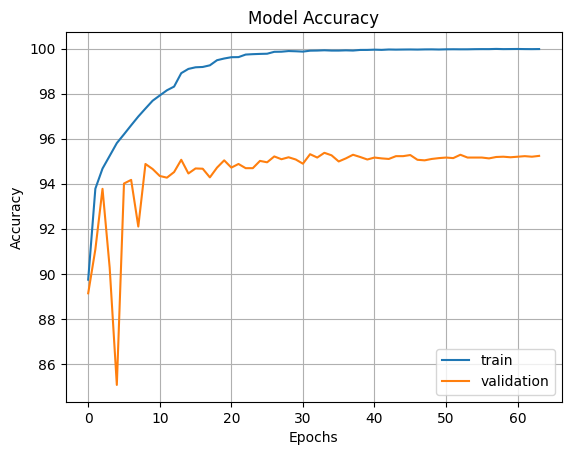

In [12]:
plt.plot(accs_train, label='Train_accuracy')
plt.plot(accs_val, label='Validation_accuracy')
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

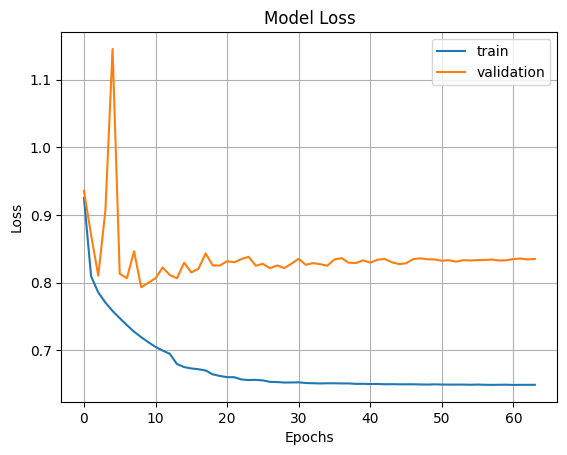

In [13]:
plt.plot(losses_train, label='Train_loss')
plt.plot(losses_val, label='Validation_loss')
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [14]:
#Test
class MyTestSet(Dataset):
    def __init__(self, img):
        self.img = np.load(img)
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        return img
    def __len__(self):
        return self.img.shape[0]

In [15]:
test = MyTestSet("./aru/query_aru.npy")
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

In [16]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
mod =EfficientNet.from_pretrained('efficientnet-b3', num_classes=31)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    mod = nn.DataParallel(mod)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

mod.to(device)
mod = mod.to(device)
mod.load_state_dict(torch.load(("./aru/checkpoint_model_aru.pth")))
mod.eval()

Loaded pretrained weights for efficientnet-b3


DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [17]:
out = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred = mod(query)
    _, predicted = torch.max(pred.data, 1)
    out.append(predicted)

pred = torch.cat(out, dim=0)
pr = pred.cpu().numpy()

real_label = pd.read_csv("./aru/queryy_aru.csv", index_col=0)
file = open("./aru/label_encoder_aru.obj",'rb')
le = pickle.load(file)
file.close()
pred_label = le.inverse_transform(pr)
pred_label = pd.DataFrame(pred_label)

pred_label = pred_label.replace("cDC1","cDC")
pred_label = pred_label.replace("cDC2","cDC")

ls = list(set(np.unique(pred_label[0]).tolist()) | set(np.unique(real_label["celltype"]).tolist()))
acc = accuracy_score(pred_label,real_label)

le2 = preprocessing.LabelEncoder()
le2.fit(ls)
pred_label_2 = le2.transform(pred_label[0])
real_label_2 = le2.transform(real_label["celltype"])
ari = adjusted_rand_score(real_label_2, pred_label_2)
print("Accuray: %.03f, ARI = %.03f" % (acc, ari))

Accuray: 0.855, ARI = 0.802
